In [ ]:
# 1. Import Module
import os
import numpy as np
import numpy
import torch
import cv2
import pandas as pd
import time
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from model.detr import DETR

In [ ]:
df = pd.read_csv('./datasets/annotations.csv')

In [ ]:
df.shape

(40570, 16)

In [ ]:
train_image_list = os.listdir('./datasets/data/image/train') 

# label을 COCO dataset과 동일하게 맞추기
df['class'].replace({'Cyclist':'bicycle','Car':'car','Van':'car','Tram':'train',
                     'Person_sitting':'person','Pedestrian':'person','Truck':'truck'}, inplace=True)
df.filename = [f.replace('txt', 'png') for f in df.filename] # .txt -> .png

In [ ]:
len(train_image_list)

7481

In [ ]:
# 3. Model 불러오기
# COCO classes (91개)
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# DETR 불러오기
model_path = 'facebookresearch/detr:main'
model_backbone = 'detr_resnet101'
#sys.modules.pop('models') # ModuleNotFoundError: No module named 'models.backbone' 이 에러 발생시 수행
DETR = DETR(model_path, model_backbone)
DETR.model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DETR.model.to(device)

Downloading: "https://github.com/facebookresearch/detr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


  0%|          | 0.00/232M [00:00<?, ?B/s]

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [ ]:
# 4. Algorithm (Make data)
# 좌표값의 제곱합(SSE)을 이용
'''
알고리즘의 목적: 실제 데이터에서 나타나는 bounding box보다 DETR이 예측하는 BOXES가 더 많아서, detr이 예측한 boxes중 어떤 것이 실제 데이터와 맞는지 비교해서 그 데이터의 zloc를 이용할 수 있게 하는 데이터 전처리 과정
Method: bounding box간의 좌표 제곱 합을 비교해서 가장 가깝다면 같은 객체를 인식한 bbox라고 판단한다. 단 하나의 객체를 DETR의 여러 BBOX가 같다고 판단했다면, 중복이기 때문에 그 데이터는 사용하지 않는다.
'''

start = time.time() # 시간 측정 시작

# 최종 df
glp_kitti_preprocessing_data = pd.DataFrame()

# 내가 원하는 이미지
for k in tqdm(range(len(train_image_list))): # 7481개의 데이터
    # 진행 상황 알라기
    print('이미지 전체 {} 중 {}번째 진행중'.format(len(train_image_list), k+1))

    mask = df['filename'] == train_image_list[k]
    df_choose = df.loc[mask]
    #print(df_choose)
    
    # Real data의 class와 좌표값 
    class_list = df_choose[['class']].values
    coordinates = df_choose[['xmin','ymin','xmax','ymax']].values
    
    # 이미지 open and make Variable
    img = Image.open(os.path.join('./datasets/data/image/train/',train_image_list[k]))
    img_shape = cv2.imread(os.path.join('./datasets/data/image/train/',train_image_list[k])).shape
    
    # 예측
    scores, boxes = DETR.detect(img) # Detection
    #prediction = GLPdepth.predict(img, img_shape) # Make Depth map
    
    boxes = boxes.cpu() # cpu 전환
    
    input_coordinates = [] # DETR's bounding box
    label = [] # detr label

    count = boxes.shape[0]
    if count == 0:
        continue
    
    else:
        for (real_xmin, real_ymin, real_xmax, real_ymax) in coordinates.tolist():
            real_coord_array = np.repeat(np.array((real_xmin, real_ymin, real_xmax, real_ymax)).reshape(1,4), count, axis=0)
            
            result = np.sum(np.square(boxes.detach().numpy() - real_coord_array), axis=1) # 각각의 좌표를 빼서 가장 작은 값 찾기
            index = result.argmin()
            
            input_coordinates.append(boxes[index].detach().numpy())
            label.append(CLASSES[scores[index].argmax()])

    input_coordinates = np.array(input_coordinates)
    
    # 임의의 데이터 프레임 제작
    glp_df = pd.DataFrame({'filename':df_choose['filename'], 'class':label, 'real_class':df_choose['class'], 
                           'xmin':input_coordinates[:,0], 'ymin':input_coordinates[:,1], 'xmax':input_coordinates[:,2], 
                           'ymax':input_coordinates[:,3], 'angle':df_choose['observation angle'], 'zloc':df_choose['zloc']})

    #print(glp_df)
    # 형식에 맞게 class 조절
    for category in glp_df['class']:
        if category not in ['person', 'truck', 'car', 'bicycle', 'Misc', 'train']:
            glp_df['class'].replace({category:'Misc'}, inplace=True) # Misc class 설정
            
    # 중복 데이터 제거
    glp_df.drop_duplicates(['xmin','ymin','xmax','ymax'], inplace=True) # keep=False

    glp_df = glp_df.loc[glp_df['class']==glp_df['real_class']] # class가 다르면 제외하기
    #glp_df.reset_index(inplace=True)
    #glp_df.drop('index',inplace=True,axis=1)

    # 데이터 병합
    glp_kitti_preprocessing_data = pd.concat([glp_kitti_preprocessing_data, glp_df], axis=0)


print('Finish')
end = time.time() # 시간 측정 끝
print(f"{end - start:.5f} sec") # 

# Information
print(glp_kitti_preprocessing_data.head(10))
print(glp_kitti_preprocessing_data.tail(10))
print(glp_kitti_preprocessing_data.info())
glp_kitti_preprocessing_data.isnull().sum(axis=0) # NA 값 확인

# 최종 저장
#glp_kitti_preprocessing_data = pd.read_csv('./datasets/glp_kitti_preprocessing_data.csv')
glp_kitti_preprocessing_data.isnull().sum(axis=0)
glp_kitti_preprocessing_data.drop('real_class', axis=1, inplace=True)
glp_kitti_preprocessing_data['weather'] = 'clone'

glp_kitti_preprocessing_data.to_csv('./datasets/detr_kitti_preprocessing_data_iou.csv') # csv 저장

  0%|          | 0/7481 [00:00<?, ?it/s]

이미지 전체 7481 중 1번째 진행중


/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
  0%|          | 1/7481 [00:01<2:44:58,  1.32s/it]

이미지 전체 7481 중 2번째 진행중


  0%|          | 2/7481 [00:02<2:10:08,  1.04s/it]

이미지 전체 7481 중 3번째 진행중


  0%|          | 3/7481 [00:02<1:56:14,  1.07it/s]

이미지 전체 7481 중 4번째 진행중


  0%|          | 4/7481 [00:04<2:15:32,  1.09s/it]

이미지 전체 7481 중 5번째 진행중


  0%|          | 5/7481 [00:05<2:06:42,  1.02s/it]

이미지 전체 7481 중 6번째 진행중


  0%|          | 6/7481 [00:05<1:50:40,  1.13it/s]

이미지 전체 7481 중 7번째 진행중


  0%|          | 7/7481 [00:06<1:53:34,  1.10it/s]

이미지 전체 7481 중 8번째 진행중


  0%|          | 8/7481 [00:07<1:45:02,  1.19it/s]

이미지 전체 7481 중 9번째 진행중


  0%|          | 9/7481 [00:08<1:42:04,  1.22it/s]

이미지 전체 7481 중 10번째 진행중


  0%|          | 10/7481 [00:09<1:43:30,  1.20it/s]

이미지 전체 7481 중 11번째 진행중


  0%|          | 11/7481 [00:10<1:51:02,  1.12it/s]

이미지 전체 7481 중 12번째 진행중


  0%|          | 12/7481 [00:10<1:39:46,  1.25it/s]

이미지 전체 7481 중 13번째 진행중


  0%|          | 13/7481 [00:11<1:37:12,  1.28it/s]

이미지 전체 7481 중 14번째 진행중


  0%|          | 14/7481 [00:12<1:32:57,  1.34it/s]

이미지 전체 7481 중 15번째 진행중


  0%|          | 15/7481 [00:12<1:34:40,  1.31it/s]

이미지 전체 7481 중 16번째 진행중


  0%|          | 16/7481 [00:13<1:37:00,  1.28it/s]

이미지 전체 7481 중 17번째 진행중


  0%|          | 17/7481 [00:14<1:38:58,  1.26it/s]

이미지 전체 7481 중 18번째 진행중


  0%|          | 18/7481 [00:15<1:42:53,  1.21it/s]

이미지 전체 7481 중 19번째 진행중


  0%|          | 19/7481 [00:16<1:43:08,  1.21it/s]

이미지 전체 7481 중 20번째 진행중


  0%|          | 20/7481 [00:17<1:46:10,  1.17it/s]

이미지 전체 7481 중 21번째 진행중


  0%|          | 21/7481 [00:18<1:45:58,  1.17it/s]

이미지 전체 7481 중 22번째 진행중


  0%|          | 22/7481 [00:18<1:45:38,  1.18it/s]

이미지 전체 7481 중 23번째 진행중


  0%|          | 23/7481 [00:19<1:44:37,  1.19it/s]

이미지 전체 7481 중 24번째 진행중


  0%|          | 24/7481 [00:20<1:43:04,  1.21it/s]

이미지 전체 7481 중 25번째 진행중


  0%|          | 25/7481 [00:21<1:45:50,  1.17it/s]

이미지 전체 7481 중 26번째 진행중


  0%|          | 26/7481 [00:22<1:44:24,  1.19it/s]

이미지 전체 7481 중 27번째 진행중


  0%|          | 27/7481 [00:23<1:49:17,  1.14it/s]

이미지 전체 7481 중 28번째 진행중


  0%|          | 28/7481 [00:24<1:48:22,  1.15it/s]

이미지 전체 7481 중 29번째 진행중


  0%|          | 29/7481 [00:24<1:44:41,  1.19it/s]

이미지 전체 7481 중 30번째 진행중


  0%|          | 30/7481 [00:25<1:44:45,  1.19it/s]

이미지 전체 7481 중 31번째 진행중


  0%|          | 31/7481 [00:26<1:37:55,  1.27it/s]

이미지 전체 7481 중 32번째 진행중


  0%|          | 32/7481 [00:27<1:39:27,  1.25it/s]

이미지 전체 7481 중 33번째 진행중


  0%|          | 33/7481 [00:28<1:40:42,  1.23it/s]

이미지 전체 7481 중 34번째 진행중


  0%|          | 34/7481 [00:28<1:40:26,  1.24it/s]

이미지 전체 7481 중 35번째 진행중


  0%|          | 35/7481 [00:29<1:37:35,  1.27it/s]

이미지 전체 7481 중 36번째 진행중


  0%|          | 36/7481 [00:30<1:37:04,  1.28it/s]

이미지 전체 7481 중 37번째 진행중


  0%|          | 37/7481 [00:31<1:39:20,  1.25it/s]

이미지 전체 7481 중 38번째 진행중


  1%|          | 38/7481 [00:32<1:40:00,  1.24it/s]

이미지 전체 7481 중 39번째 진행중


  1%|          | 39/7481 [00:32<1:40:54,  1.23it/s]

이미지 전체 7481 중 40번째 진행중


  1%|          | 40/7481 [00:33<1:36:22,  1.29it/s]

이미지 전체 7481 중 41번째 진행중


  1%|          | 41/7481 [00:34<1:36:48,  1.28it/s]

이미지 전체 7481 중 42번째 진행중


  1%|          | 42/7481 [00:35<1:40:39,  1.23it/s]

이미지 전체 7481 중 43번째 진행중


  1%|          | 43/7481 [00:36<1:40:57,  1.23it/s]

이미지 전체 7481 중 44번째 진행중


  1%|          | 44/7481 [00:36<1:40:24,  1.23it/s]

이미지 전체 7481 중 45번째 진행중


  1%|          | 45/7481 [00:37<1:40:06,  1.24it/s]

이미지 전체 7481 중 46번째 진행중


  1%|          | 46/7481 [00:38<1:40:58,  1.23it/s]

이미지 전체 7481 중 47번째 진행중


  1%|          | 47/7481 [00:39<1:37:21,  1.27it/s]

이미지 전체 7481 중 48번째 진행중


  1%|          | 48/7481 [00:40<1:41:40,  1.22it/s]

이미지 전체 7481 중 49번째 진행중


  1%|          | 49/7481 [00:41<1:45:34,  1.17it/s]

이미지 전체 7481 중 50번째 진행중


  1%|          | 50/7481 [00:41<1:38:23,  1.26it/s]

이미지 전체 7481 중 51번째 진행중


  1%|          | 51/7481 [00:43<2:06:53,  1.02s/it]

이미지 전체 7481 중 52번째 진행중


  1%|          | 52/7481 [00:44<2:03:06,  1.01it/s]

이미지 전체 7481 중 53번째 진행중


  1%|          | 53/7481 [00:44<1:54:31,  1.08it/s]

이미지 전체 7481 중 54번째 진행중


  1%|          | 54/7481 [00:45<1:47:35,  1.15it/s]

이미지 전체 7481 중 55번째 진행중


  1%|          | 55/7481 [00:46<1:45:57,  1.17it/s]

이미지 전체 7481 중 56번째 진행중


  1%|          | 56/7481 [00:47<1:40:07,  1.24it/s]

이미지 전체 7481 중 57번째 진행중


  1%|          | 57/7481 [00:47<1:40:32,  1.23it/s]

이미지 전체 7481 중 58번째 진행중


  1%|          | 58/7481 [00:48<1:42:56,  1.20it/s]

이미지 전체 7481 중 59번째 진행중


  1%|          | 59/7481 [00:49<1:38:50,  1.25it/s]

이미지 전체 7481 중 60번째 진행중


  1%|          | 60/7481 [00:50<1:38:53,  1.25it/s]

이미지 전체 7481 중 61번째 진행중


  1%|          | 61/7481 [00:51<1:40:53,  1.23it/s]

이미지 전체 7481 중 62번째 진행중


  1%|          | 62/7481 [00:52<1:39:56,  1.24it/s]

이미지 전체 7481 중 63번째 진행중


  1%|          | 63/7481 [00:52<1:41:02,  1.22it/s]

이미지 전체 7481 중 64번째 진행중


  1%|          | 64/7481 [00:53<1:40:07,  1.23it/s]

이미지 전체 7481 중 65번째 진행중


  1%|          | 65/7481 [00:54<1:37:33,  1.27it/s]

이미지 전체 7481 중 66번째 진행중


  1%|          | 66/7481 [00:55<1:37:21,  1.27it/s]

이미지 전체 7481 중 67번째 진행중


  1%|          | 67/7481 [00:55<1:36:42,  1.28it/s]

이미지 전체 7481 중 68번째 진행중


  1%|          | 68/7481 [00:56<1:36:55,  1.27it/s]

이미지 전체 7481 중 69번째 진행중


  1%|          | 69/7481 [00:57<1:37:59,  1.26it/s]

이미지 전체 7481 중 70번째 진행중


  1%|          | 70/7481 [00:58<1:32:54,  1.33it/s]

이미지 전체 7481 중 71번째 진행중


  1%|          | 71/7481 [00:59<1:35:40,  1.29it/s]

이미지 전체 7481 중 72번째 진행중


  1%|          | 72/7481 [00:59<1:39:43,  1.24it/s]

이미지 전체 7481 중 73번째 진행중


  1%|          | 73/7481 [01:00<1:34:15,  1.31it/s]

이미지 전체 7481 중 74번째 진행중


  1%|          | 74/7481 [01:01<1:36:09,  1.28it/s]

이미지 전체 7481 중 75번째 진행중


  1%|          | 75/7481 [02:56<72:16:50, 35.14s/it]

이미지 전체 7481 중 76번째 진행중


  1%|          | 77/7481 [05:26<100:14:24, 48.74s/it]

이미지 전체 7481 중 77번째 진행중
이미지 전체 7481 중 78번째 진행중


  1%|          | 79/7481 [05:27<49:15:48, 23.96s/it]

이미지 전체 7481 중 79번째 진행중
이미지 전체 7481 중 80번째 진행중


  1%|          | 81/7481 [05:27<24:14:27, 11.79s/it]

이미지 전체 7481 중 81번째 진행중
이미지 전체 7481 중 82번째 진행중


  1%|          | 83/7481 [05:27<11:58:59,  5.83s/it]

이미지 전체 7481 중 83번째 진행중
이미지 전체 7481 중 84번째 진행중


  1%|          | 85/7481 [05:27<5:58:39,  2.91s/it]

이미지 전체 7481 중 85번째 진행중
이미지 전체 7481 중 86번째 진행중


  1%|          | 88/7481 [05:28<2:22:41,  1.16s/it]

이미지 전체 7481 중 87번째 진행중
이미지 전체 7481 중 88번째 진행중
이미지 전체 7481 중 89번째 진행중


  1%|          | 90/7481 [05:28<1:30:28,  1.36it/s]

이미지 전체 7481 중 90번째 진행중
이미지 전체 7481 중 91번째 진행중


  1%|          | 92/7481 [05:28<59:36,  2.07it/s]  

이미지 전체 7481 중 92번째 진행중
이미지 전체 7481 중 93번째 진행중


  1%|▏         | 95/7481 [05:28<32:29,  3.79it/s]

이미지 전체 7481 중 94번째 진행중
이미지 전체 7481 중 95번째 진행중
이미지 전체 7481 중 96번째 진행중


  1%|▏         | 97/7481 [05:28<24:11,  5.09it/s]

이미지 전체 7481 중 97번째 진행중
이미지 전체 7481 중 98번째 진행중


  1%|▏         | 101/7481 [05:29<16:24,  7.50it/s]

이미지 전체 7481 중 99번째 진행중
이미지 전체 7481 중 100번째 진행중
이미지 전체 7481 중 101번째 진행중
이미지 전체 7481 중 102번째 진행중


  1%|▏         | 103/7481 [05:29<14:54,  8.25it/s]

이미지 전체 7481 중 103번째 진행중
이미지 전체 7481 중 104번째 진행중


  1%|▏         | 105/7481 [05:29<14:18,  8.60it/s]

이미지 전체 7481 중 105번째 진행중
이미지 전체 7481 중 106번째 진행중
이미지 전체 7481 중 107번째 진행중


  1%|▏         | 108/7481 [05:30<13:11,  9.32it/s]

이미지 전체 7481 중 108번째 진행중
이미지 전체 7481 중 109번째 진행중


  1%|▏         | 111/7481 [05:30<12:47,  9.60it/s]

이미지 전체 7481 중 110번째 진행중
이미지 전체 7481 중 111번째 진행중
이미지 전체 7481 중 112번째 진행중


  2%|▏         | 113/7481 [05:30<12:52,  9.53it/s]

이미지 전체 7481 중 113번째 진행중
이미지 전체 7481 중 114번째 진행중


  2%|▏         | 115/7481 [05:30<13:09,  9.33it/s]

이미지 전체 7481 중 115번째 진행중
이미지 전체 7481 중 116번째 진행중


  2%|▏         | 118/7481 [05:31<12:20,  9.95it/s]

이미지 전체 7481 중 117번째 진행중
이미지 전체 7481 중 118번째 진행중
이미지 전체 7481 중 119번째 진행중


  2%|▏         | 120/7481 [05:31<11:55, 10.28it/s]

이미지 전체 7481 중 120번째 진행중
이미지 전체 7481 중 121번째 진행중
이미지 전체 7481 중 122번째 진행중


  2%|▏         | 124/7481 [05:31<11:49, 10.36it/s]

이미지 전체 7481 중 123번째 진행중
이미지 전체 7481 중 124번째 진행중
이미지 전체 7481 중 125번째 진행중


  2%|▏         | 126/7481 [05:31<11:57, 10.25it/s]

이미지 전체 7481 중 126번째 진행중
이미지 전체 7481 중 127번째 진행중
이미지 전체 7481 중 128번째 진행중


  2%|▏         | 130/7481 [05:32<12:04, 10.15it/s]

이미지 전체 7481 중 129번째 진행중
이미지 전체 7481 중 130번째 진행중
이미지 전체 7481 중 131번째 진행중


  2%|▏         | 132/7481 [05:32<12:13, 10.02it/s]

이미지 전체 7481 중 132번째 진행중
이미지 전체 7481 중 133번째 진행중
이미지 전체 7481 중 134번째 진행중


  2%|▏         | 136/7481 [05:32<12:18,  9.94it/s]

이미지 전체 7481 중 135번째 진행중
이미지 전체 7481 중 136번째 진행중
이미지 전체 7481 중 137번째 진행중

  2%|▏         | 138/7481 [05:33<12:14,  9.99it/s]


이미지 전체 7481 중 138번째 진행중
이미지 전체 7481 중 139번째 진행중


  2%|▏         | 140/7481 [05:33<12:01, 10.17it/s]

이미지 전체 7481 중 140번째 진행중
이미지 전체 7481 중 141번째 진행중
이미지 전체 7481 중 142번째 진행중


  2%|▏         | 144/7481 [05:33<11:51, 10.31it/s]

이미지 전체 7481 중 143번째 진행중
이미지 전체 7481 중 144번째 진행중
이미지 전체 7481 중 145번째 진행중


  2%|▏         | 146/7481 [05:33<11:48, 10.36it/s]

이미지 전체 7481 중 146번째 진행중
이미지 전체 7481 중 147번째 진행중
이미지 전체 7481 중 148번째 진행중


  2%|▏         | 150/7481 [05:34<12:04, 10.11it/s]

이미지 전체 7481 중 149번째 진행중
이미지 전체 7481 중 150번째 진행중
이미지 전체 7481 중 151번째 진행중


  2%|▏         | 152/7481 [05:34<12:12, 10.00it/s]

이미지 전체 7481 중 152번째 진행중
이미지 전체 7481 중 153번째 진행중


  2%|▏         | 156/7481 [05:34<12:18,  9.91it/s]

이미지 전체 7481 중 154번째 진행중
이미지 전체 7481 중 155번째 진행중
이미지 전체 7481 중 156번째 진행중
이미지 전체 7481 중 157번째 진행중


  2%|▏         | 158/7481 [05:35<11:55, 10.24it/s]

이미지 전체 7481 중 158번째 진행중
이미지 전체 7481 중 159번째 진행중
이미지 전체 7481 중 160번째 진행중


  2%|▏         | 162/7481 [05:35<11:57, 10.20it/s]

이미지 전체 7481 중 161번째 진행중
이미지 전체 7481 중 162번째 진행중
이미지 전체 7481 중 163번째 진행중


  2%|▏         | 164/7481 [05:35<12:15,  9.95it/s]

이미지 전체 7481 중 164번째 진행중
이미지 전체 7481 중 165번째 진행중
이미지 전체 7481 중 166번째 진행중


  2%|▏         | 168/7481 [05:36<11:53, 10.25it/s]

이미지 전체 7481 중 167번째 진행중
이미지 전체 7481 중 168번째 진행중
이미지 전체 7481 중 169번째 진행중


  2%|▏         | 170/7481 [05:36<12:01, 10.14it/s]

이미지 전체 7481 중 170번째 진행중
이미지 전체 7481 중 171번째 진행중
이미지 전체 7481 중 172번째 진행중


  2%|▏         | 174/7481 [05:36<12:06, 10.06it/s]

이미지 전체 7481 중 173번째 진행중
이미지 전체 7481 중 174번째 진행중
이미지 전체 7481 중 175번째 진행중


  2%|▏         | 177/7481 [05:36<12:18,  9.90it/s]

이미지 전체 7481 중 176번째 진행중
이미지 전체 7481 중 177번째 진행중
이미지 전체 7481 중 178번째 진행중


  2%|▏         | 179/7481 [05:37<12:02, 10.11it/s]

이미지 전체 7481 중 179번째 진행중
이미지 전체 7481 중 180번째 진행중
이미지 전체 7481 중 181번째 진행중


  2%|▏         | 183/7481 [05:37<11:54, 10.21it/s]

이미지 전체 7481 중 182번째 진행중
이미지 전체 7481 중 183번째 진행중
이미지 전체 7481 중 184번째 진행중


  2%|▏         | 185/7481 [05:37<11:53, 10.23it/s]

이미지 전체 7481 중 185번째 진행중
이미지 전체 7481 중 186번째 진행중
이미지 전체 7481 중 187번째 진행중


  3%|▎         | 189/7481 [05:38<11:54, 10.21it/s]

이미지 전체 7481 중 188번째 진행중
이미지 전체 7481 중 189번째 진행중
이미지 전체 7481 중 190번째 진행중


  3%|▎         | 191/7481 [05:38<11:44, 10.35it/s]

이미지 전체 7481 중 191번째 진행중
이미지 전체 7481 중 192번째 진행중
이미지 전체 7481 중 193번째 진행중


  3%|▎         | 193/7481 [05:38<11:51, 10.25it/s]

이미지 전체 7481 중 194번째 진행중
이미지 전체 7481 중 195번째 진행중


  3%|▎         | 197/7481 [05:38<12:02, 10.09it/s]

이미지 전체 7481 중 196번째 진행중
이미지 전체 7481 중 197번째 진행중
이미지 전체 7481 중 198번째 진행중


  3%|▎         | 199/7481 [05:39<11:57, 10.15it/s]

이미지 전체 7481 중 199번째 진행중
이미지 전체 7481 중 200번째 진행중
이미지 전체 7481 중 201번째 진행중


  3%|▎         | 203/7481 [05:39<11:41, 10.37it/s]

이미지 전체 7481 중 202번째 진행중
이미지 전체 7481 중 203번째 진행중
이미지 전체 7481 중 204번째 진행중


  3%|▎         | 205/7481 [05:39<11:51, 10.22it/s]

이미지 전체 7481 중 205번째 진행중
이미지 전체 7481 중 206번째 진행중


  3%|▎         | 207/7481 [05:39<12:01, 10.08it/s]

이미지 전체 7481 중 207번째 진행중
이미지 전체 7481 중 208번째 진행중
이미지 전체 7481 중 209번째 진행중


  3%|▎         | 211/7481 [05:40<11:54, 10.17it/s]

이미지 전체 7481 중 210번째 진행중
이미지 전체 7481 중 211번째 진행중
이미지 전체 7481 중 212번째 진행중


  3%|▎         | 213/7481 [05:40<12:00, 10.09it/s]

이미지 전체 7481 중 213번째 진행중
이미지 전체 7481 중 214번째 진행중
이미지 전체 7481 중 215번째 진행중


  3%|▎         | 216/7481 [05:40<12:29,  9.69it/s]

이미지 전체 7481 중 216번째 진행중
이미지 전체 7481 중 217번째 진행중


  3%|▎         | 218/7481 [05:40<12:28,  9.70it/s]

이미지 전체 7481 중 218번째 진행중
이미지 전체 7481 중 219번째 진행중


  3%|▎         | 220/7481 [05:41<12:46,  9.47it/s]

이미지 전체 7481 중 220번째 진행중
이미지 전체 7481 중 221번째 진행중


  3%|▎         | 223/7481 [05:41<12:35,  9.60it/s]

이미지 전체 7481 중 222번째 진행중
이미지 전체 7481 중 223번째 진행중
이미지 전체 7481 중 224번째 진행중


  3%|▎         | 225/7481 [05:41<12:42,  9.52it/s]

이미지 전체 7481 중 225번째 진행중
이미지 전체 7481 중 226번째 진행중


  3%|▎         | 227/7481 [05:41<12:40,  9.54it/s]

이미지 전체 7481 중 227번째 진행중
이미지 전체 7481 중 228번째 진행중
이미지 전체 7481 중 229번째 진행중


  3%|▎         | 230/7481 [05:42<12:15,  9.86it/s]

이미지 전체 7481 중 230번째 진행중
이미지 전체 7481 중 231번째 진행중
이미지 전체 7481 중 232번째 진행중


  3%|▎         | 234/7481 [05:42<12:01, 10.05it/s]

이미지 전체 7481 중 233번째 진행중
이미지 전체 7481 중 234번째 진행중
이미지 전체 7481 중 235번째 진행중


  3%|▎         | 237/7481 [05:42<11:57, 10.10it/s]

이미지 전체 7481 중 236번째 진행중
이미지 전체 7481 중 237번째 진행중
이미지 전체 7481 중 238번째 진행중


  3%|▎         | 239/7481 [05:43<12:30,  9.65it/s]

이미지 전체 7481 중 239번째 진행중
이미지 전체 7481 중 240번째 진행중
이미지 전체 7481 중 241번째 진행중


  3%|▎         | 243/7481 [05:43<12:15,  9.84it/s]

이미지 전체 7481 중 242번째 진행중
이미지 전체 7481 중 243번째 진행중
이미지 전체 7481 중 244번째 진행중


  3%|▎         | 245/7481 [05:43<12:35,  9.57it/s]

이미지 전체 7481 중 245번째 진행중
이미지 전체 7481 중 246번째 진행중
이미지 전체 7481 중 247번째 진행중


  3%|▎         | 249/7481 [05:44<12:00, 10.03it/s]

이미지 전체 7481 중 248번째 진행중
이미지 전체 7481 중 249번째 진행중
이미지 전체 7481 중 250번째 진행중


  3%|▎         | 251/7481 [05:44<12:23,  9.72it/s]

이미지 전체 7481 중 251번째 진행중
이미지 전체 7481 중 252번째 진행중


  3%|▎         | 253/7481 [05:44<12:38,  9.53it/s]

이미지 전체 7481 중 253번째 진행중
이미지 전체 7481 중 254번째 진행중
이미지 전체 7481 중 255번째 진행중


  3%|▎         | 257/7481 [05:44<11:44, 10.26it/s]

이미지 전체 7481 중 256번째 진행중
이미지 전체 7481 중 257번째 진행중
이미지 전체 7481 중 258번째 진행중


  3%|▎         | 259/7481 [05:45<11:38, 10.34it/s]

이미지 전체 7481 중 259번째 진행중
이미지 전체 7481 중 260번째 진행중
이미지 전체 7481 중 261번째 진행중


  4%|▎         | 263/7481 [05:45<11:28, 10.49it/s]

이미지 전체 7481 중 262번째 진행중
이미지 전체 7481 중 263번째 진행중
이미지 전체 7481 중 264번째 진행중


  4%|▎         | 265/7481 [05:45<11:45, 10.23it/s]

이미지 전체 7481 중 265번째 진행중
이미지 전체 7481 중 266번째 진행중
이미지 전체 7481 중 267번째 진행중


  4%|▎         | 269/7481 [05:46<11:36, 10.35it/s]

이미지 전체 7481 중 268번째 진행중
이미지 전체 7481 중 269번째 진행중
이미지 전체 7481 중 270번째 진행중


  4%|▎         | 271/7481 [05:46<11:50, 10.14it/s]

이미지 전체 7481 중 271번째 진행중
이미지 전체 7481 중 272번째 진행중
이미지 전체 7481 중 273번째 진행중


  4%|▎         | 273/7481 [05:46<11:52, 10.12it/s]

이미지 전체 7481 중 274번째 진행중
이미지 전체 7481 중 275번째 진행중


  4%|▎         | 276/7481 [05:46<12:13,  9.82it/s]

이미지 전체 7481 중 276번째 진행중
이미지 전체 7481 중 277번째 진행중
이미지 전체 7481 중 278번째 진행중


  4%|▎         | 278/7481 [05:47<12:03,  9.96it/s]

이미지 전체 7481 중 279번째 진행중


  4%|▍         | 281/7481 [05:47<18:40,  6.43it/s]

이미지 전체 7481 중 280번째 진행중
이미지 전체 7481 중 281번째 진행중
이미지 전체 7481 중 282번째 진행중


  4%|▍         | 283/7481 [05:48<15:44,  7.62it/s]

이미지 전체 7481 중 283번째 진행중
이미지 전체 7481 중 284번째 진행중
이미지 전체 7481 중 285번째 진행중


  4%|▍         | 287/7481 [05:48<13:09,  9.11it/s]

이미지 전체 7481 중 286번째 진행중
이미지 전체 7481 중 287번째 진행중
이미지 전체 7481 중 288번째 진행중


  4%|▍         | 289/7481 [05:48<12:34,  9.53it/s]

이미지 전체 7481 중 289번째 진행중
이미지 전체 7481 중 290번째 진행중
이미지 전체 7481 중 291번째 진행중


  4%|▍         | 293/7481 [05:48<11:55, 10.05it/s]

이미지 전체 7481 중 292번째 진행중
이미지 전체 7481 중 293번째 진행중
이미지 전체 7481 중 294번째 진행중


  4%|▍         | 295/7481 [05:49<11:50, 10.12it/s]

이미지 전체 7481 중 295번째 진행중
이미지 전체 7481 중 296번째 진행중
이미지 전체 7481 중 297번째 진행중


  4%|▍         | 299/7481 [05:49<11:51, 10.09it/s]

이미지 전체 7481 중 298번째 진행중
이미지 전체 7481 중 299번째 진행중
이미지 전체 7481 중 300번째 진행중


  4%|▍         | 301/7481 [05:49<11:49, 10.13it/s]

이미지 전체 7481 중 301번째 진행중
이미지 전체 7481 중 302번째 진행중
이미지 전체 7481 중 303번째 진행중


  4%|▍         | 305/7481 [05:50<11:49, 10.12it/s]

이미지 전체 7481 중 304번째 진행중
이미지 전체 7481 중 305번째 진행중
이미지 전체 7481 중 306번째 진행중


  4%|▍         | 307/7481 [05:50<11:48, 10.13it/s]

이미지 전체 7481 중 307번째 진행중
이미지 전체 7481 중 308번째 진행중
이미지 전체 7481 중 309번째 진행중


  4%|▍         | 311/7481 [05:50<11:46, 10.14it/s]

이미지 전체 7481 중 310번째 진행중
이미지 전체 7481 중 311번째 진행중
이미지 전체 7481 중 312번째 진행중


  4%|▍         | 313/7481 [05:50<12:05,  9.87it/s]

이미지 전체 7481 중 313번째 진행중
이미지 전체 7481 중 314번째 진행중
이미지 전체 7481 중 315번째 진행중


  4%|▍         | 317/7481 [05:51<11:53, 10.05it/s]

이미지 전체 7481 중 316번째 진행중
이미지 전체 7481 중 317번째 진행중
이미지 전체 7481 중 318번째 진행중


  4%|▍         | 319/7481 [05:51<11:49, 10.09it/s]

이미지 전체 7481 중 319번째 진행중
이미지 전체 7481 중 320번째 진행중
이미지 전체 7481 중 321번째 진행중


  4%|▍         | 323/7481 [05:51<11:47, 10.11it/s]

이미지 전체 7481 중 322번째 진행중
이미지 전체 7481 중 323번째 진행중
이미지 전체 7481 중 324번째 진행중


  4%|▍         | 325/7481 [05:52<11:42, 10.19it/s]

이미지 전체 7481 중 325번째 진행중
이미지 전체 7481 중 326번째 진행중


  4%|▍         | 327/7481 [05:52<20:24,  5.84it/s]

이미지 전체 7481 중 327번째 진행중
이미지 전체 7481 중 328번째 진행중
이미지 전체 7481 중 329번째 진행중


  4%|▍         | 330/7481 [05:53<16:45,  7.11it/s]

이미지 전체 7481 중 330번째 진행중
이미지 전체 7481 중 331번째 진행중


  4%|▍         | 333/7481 [05:53<14:19,  8.31it/s]

이미지 전체 7481 중 332번째 진행중
이미지 전체 7481 중 333번째 진행중
이미지 전체 7481 중 334번째 진행중


  4%|▍         | 336/7481 [05:53<12:49,  9.29it/s]

이미지 전체 7481 중 335번째 진행중
이미지 전체 7481 중 336번째 진행중
이미지 전체 7481 중 337번째 진행중


  5%|▍         | 339/7481 [05:54<12:31,  9.50it/s]

이미지 전체 7481 중 338번째 진행중
이미지 전체 7481 중 339번째 진행중
이미지 전체 7481 중 340번째 진행중


  5%|▍         | 342/7481 [05:54<11:58,  9.94it/s]

이미지 전체 7481 중 341번째 진행중
이미지 전체 7481 중 342번째 진행중
이미지 전체 7481 중 343번째 진행중


  5%|▍         | 345/7481 [05:54<11:42, 10.16it/s]

이미지 전체 7481 중 344번째 진행중
이미지 전체 7481 중 345번째 진행중
이미지 전체 7481 중 346번째 진행중


  5%|▍         | 347/7481 [05:54<11:27, 10.38it/s]

이미지 전체 7481 중 347번째 진행중
이미지 전체 7481 중 348번째 진행중
이미지 전체 7481 중 349번째 진행중


  5%|▍         | 351/7481 [05:55<11:15, 10.55it/s]

이미지 전체 7481 중 350번째 진행중
이미지 전체 7481 중 351번째 진행중
이미지 전체 7481 중 352번째 진행중


  5%|▍         | 353/7481 [05:55<11:17, 10.52it/s]

이미지 전체 7481 중 353번째 진행중
이미지 전체 7481 중 354번째 진행중
이미지 전체 7481 중 355번째 진행중


  5%|▍         | 357/7481 [05:55<11:24, 10.40it/s]

이미지 전체 7481 중 356번째 진행중
이미지 전체 7481 중 357번째 진행중
이미지 전체 7481 중 358번째 진행중


  5%|▍         | 359/7481 [05:55<11:38, 10.19it/s]

이미지 전체 7481 중 359번째 진행중
이미지 전체 7481 중 360번째 진행중
이미지 전체 7481 중 361번째 진행중


  5%|▍         | 363/7481 [05:56<11:29, 10.33it/s]

이미지 전체 7481 중 362번째 진행중
이미지 전체 7481 중 363번째 진행중
이미지 전체 7481 중 364번째 진행중


  5%|▍         | 365/7481 [05:56<11:32, 10.28it/s]

이미지 전체 7481 중 365번째 진행중
이미지 전체 7481 중 366번째 진행중
이미지 전체 7481 중 367번째 진행중


  5%|▍         | 369/7481 [05:56<11:29, 10.32it/s]

이미지 전체 7481 중 368번째 진행중
이미지 전체 7481 중 369번째 진행중
이미지 전체 7481 중 370번째 진행중


  5%|▍         | 371/7481 [05:57<11:24, 10.38it/s]

이미지 전체 7481 중 371번째 진행중
이미지 전체 7481 중 372번째 진행중
이미지 전체 7481 중 373번째 진행중


  5%|▌         | 375/7481 [05:57<11:29, 10.31it/s]

이미지 전체 7481 중 374번째 진행중
이미지 전체 7481 중 375번째 진행중
이미지 전체 7481 중 376번째 진행중


  5%|▌         | 377/7481 [05:57<11:26, 10.35it/s]

이미지 전체 7481 중 377번째 진행중
이미지 전체 7481 중 378번째 진행중
이미지 전체 7481 중 379번째 진행중


  5%|▌         | 381/7481 [05:58<11:36, 10.19it/s]

이미지 전체 7481 중 380번째 진행중
이미지 전체 7481 중 381번째 진행중
이미지 전체 7481 중 382번째 진행중


  5%|▌         | 383/7481 [05:58<11:25, 10.35it/s]

이미지 전체 7481 중 383번째 진행중
이미지 전체 7481 중 384번째 진행중
이미지 전체 7481 중 385번째 진행중


  5%|▌         | 387/7481 [05:58<11:23, 10.38it/s]

이미지 전체 7481 중 386번째 진행중
이미지 전체 7481 중 387번째 진행중
이미지 전체 7481 중 388번째 진행중


  5%|▌         | 389/7481 [05:58<11:16, 10.48it/s]

이미지 전체 7481 중 389번째 진행중
이미지 전체 7481 중 390번째 진행중
이미지 전체 7481 중 391번째 진행중


  5%|▌         | 393/7481 [05:59<11:27, 10.32it/s]

이미지 전체 7481 중 392번째 진행중
이미지 전체 7481 중 393번째 진행중
이미지 전체 7481 중 394번째 진행중


  5%|▌         | 395/7481 [05:59<11:25, 10.33it/s]

이미지 전체 7481 중 395번째 진행중
이미지 전체 7481 중 396번째 진행중
이미지 전체 7481 중 397번째 진행중


  5%|▌         | 399/7481 [05:59<11:22, 10.37it/s]

이미지 전체 7481 중 398번째 진행중
이미지 전체 7481 중 399번째 진행중
이미지 전체 7481 중 400번째 진행중


  5%|▌         | 401/7481 [06:00<11:29, 10.27it/s]

이미지 전체 7481 중 401번째 진행중
이미지 전체 7481 중 402번째 진행중
이미지 전체 7481 중 403번째 진행중


  5%|▌         | 405/7481 [06:00<11:29, 10.27it/s]

이미지 전체 7481 중 404번째 진행중
이미지 전체 7481 중 405번째 진행중
이미지 전체 7481 중 406번째 진행중


  5%|▌         | 407/7481 [06:00<11:29, 10.25it/s]

이미지 전체 7481 중 407번째 진행중
이미지 전체 7481 중 408번째 진행중
이미지 전체 7481 중 409번째 진행중


  5%|▌         | 411/7481 [06:00<11:27, 10.28it/s]

이미지 전체 7481 중 410번째 진행중
이미지 전체 7481 중 411번째 진행중
이미지 전체 7481 중 412번째 진행중


  6%|▌         | 413/7481 [06:01<11:23, 10.34it/s]

이미지 전체 7481 중 413번째 진행중
이미지 전체 7481 중 414번째 진행중
이미지 전체 7481 중 415번째 진행중


  6%|▌         | 417/7481 [06:01<11:11, 10.53it/s]

이미지 전체 7481 중 416번째 진행중
이미지 전체 7481 중 417번째 진행중
이미지 전체 7481 중 418번째 진행중


  6%|▌         | 419/7481 [06:01<11:17, 10.42it/s]

이미지 전체 7481 중 419번째 진행중
이미지 전체 7481 중 420번째 진행중
이미지 전체 7481 중 421번째 진행중


  6%|▌         | 423/7481 [06:02<11:30, 10.23it/s]

이미지 전체 7481 중 422번째 진행중
이미지 전체 7481 중 423번째 진행중
이미지 전체 7481 중 424번째 진행중


  6%|▌         | 425/7481 [06:02<11:19, 10.39it/s]

이미지 전체 7481 중 425번째 진행중
이미지 전체 7481 중 426번째 진행중
이미지 전체 7481 중 427번째 진행중


  6%|▌         | 429/7481 [06:02<11:12, 10.48it/s]

이미지 전체 7481 중 428번째 진행중
이미지 전체 7481 중 429번째 진행중
이미지 전체 7481 중 430번째 진행중


  6%|▌         | 431/7481 [06:02<11:12, 10.48it/s]

이미지 전체 7481 중 431번째 진행중
이미지 전체 7481 중 432번째 진행중
이미지 전체 7481 중 433번째 진행중


  6%|▌         | 435/7481 [06:03<11:31, 10.19it/s]

이미지 전체 7481 중 434번째 진행중
이미지 전체 7481 중 435번째 진행중
이미지 전체 7481 중 436번째 진행중


  6%|▌         | 437/7481 [06:03<11:41, 10.04it/s]

이미지 전체 7481 중 437번째 진행중
이미지 전체 7481 중 438번째 진행중
이미지 전체 7481 중 439번째 진행중


  6%|▌         | 441/7481 [06:03<11:20, 10.35it/s]

이미지 전체 7481 중 440번째 진행중
이미지 전체 7481 중 441번째 진행중
이미지 전체 7481 중 442번째 진행중


  6%|▌         | 443/7481 [06:04<11:33, 10.14it/s]

이미지 전체 7481 중 443번째 진행중
이미지 전체 7481 중 444번째 진행중
이미지 전체 7481 중 445번째 진행중


  6%|▌         | 447/7481 [06:04<11:23, 10.29it/s]

이미지 전체 7481 중 446번째 진행중
이미지 전체 7481 중 447번째 진행중
이미지 전체 7481 중 448번째 진행중


  6%|▌         | 449/7481 [06:04<11:22, 10.30it/s]

이미지 전체 7481 중 449번째 진행중
이미지 전체 7481 중 450번째 진행중
이미지 전체 7481 중 451번째 진행중


  6%|▌         | 453/7481 [06:05<11:31, 10.17it/s]

이미지 전체 7481 중 452번째 진행중
이미지 전체 7481 중 453번째 진행중
이미지 전체 7481 중 454번째 진행중


  6%|▌         | 455/7481 [06:05<11:25, 10.24it/s]

이미지 전체 7481 중 455번째 진행중
이미지 전체 7481 중 456번째 진행중
이미지 전체 7481 중 457번째 진행중


  6%|▌         | 459/7481 [06:05<11:16, 10.39it/s]

이미지 전체 7481 중 458번째 진행중
이미지 전체 7481 중 459번째 진행중
이미지 전체 7481 중 460번째 진행중


  6%|▌         | 461/7481 [06:05<11:13, 10.42it/s]

이미지 전체 7481 중 461번째 진행중
이미지 전체 7481 중 462번째 진행중
이미지 전체 7481 중 463번째 진행중


  6%|▌         | 465/7481 [06:06<11:13, 10.42it/s]

이미지 전체 7481 중 464번째 진행중
이미지 전체 7481 중 465번째 진행중
이미지 전체 7481 중 466번째 진행중


  6%|▌         | 467/7481 [06:06<11:08, 10.49it/s]

이미지 전체 7481 중 467번째 진행중
이미지 전체 7481 중 468번째 진행중
이미지 전체 7481 중 469번째 진행중


  6%|▋         | 471/7481 [06:06<11:13, 10.41it/s]

이미지 전체 7481 중 470번째 진행중
이미지 전체 7481 중 471번째 진행중
이미지 전체 7481 중 472번째 진행중


  6%|▋         | 473/7481 [06:07<11:25, 10.23it/s]

이미지 전체 7481 중 473번째 진행중
이미지 전체 7481 중 474번째 진행중
이미지 전체 7481 중 475번째 진행중


  6%|▋         | 477/7481 [06:07<11:28, 10.17it/s]

이미지 전체 7481 중 476번째 진행중
이미지 전체 7481 중 477번째 진행중
이미지 전체 7481 중 478번째 진행중


  6%|▋         | 479/7481 [06:07<11:38, 10.02it/s]

이미지 전체 7481 중 479번째 진행중
이미지 전체 7481 중 480번째 진행중
이미지 전체 7481 중 481번째 진행중


  6%|▋         | 483/7481 [06:08<11:32, 10.11it/s]

이미지 전체 7481 중 482번째 진행중
이미지 전체 7481 중 483번째 진행중
이미지 전체 7481 중 484번째 진행중


  6%|▋         | 485/7481 [06:08<11:25, 10.21it/s]

이미지 전체 7481 중 485번째 진행중
이미지 전체 7481 중 486번째 진행중
이미지 전체 7481 중 487번째 진행중


  7%|▋         | 489/7481 [06:08<11:10, 10.43it/s]

이미지 전체 7481 중 488번째 진행중
이미지 전체 7481 중 489번째 진행중
이미지 전체 7481 중 490번째 진행중


  7%|▋         | 491/7481 [06:08<11:05, 10.50it/s]

이미지 전체 7481 중 491번째 진행중
이미지 전체 7481 중 492번째 진행중
이미지 전체 7481 중 493번째 진행중


  7%|▋         | 495/7481 [06:09<11:11, 10.40it/s]

이미지 전체 7481 중 494번째 진행중
이미지 전체 7481 중 495번째 진행중
이미지 전체 7481 중 496번째 진행중


  7%|▋         | 497/7481 [06:09<11:06, 10.47it/s]

이미지 전체 7481 중 497번째 진행중
이미지 전체 7481 중 498번째 진행중
이미지 전체 7481 중 499번째 진행중


  7%|▋         | 501/7481 [06:09<11:02, 10.54it/s]

이미지 전체 7481 중 500번째 진행중
이미지 전체 7481 중 501번째 진행중
이미지 전체 7481 중 502번째 진행중


  7%|▋         | 503/7481 [06:09<11:03, 10.52it/s]

이미지 전체 7481 중 503번째 진행중
이미지 전체 7481 중 504번째 진행중
이미지 전체 7481 중 505번째 진행중


  7%|▋         | 507/7481 [06:10<11:13, 10.35it/s]

이미지 전체 7481 중 506번째 진행중
이미지 전체 7481 중 507번째 진행중
이미지 전체 7481 중 508번째 진행중


  7%|▋         | 509/7481 [06:10<11:07, 10.44it/s]

이미지 전체 7481 중 509번째 진행중
이미지 전체 7481 중 510번째 진행중
이미지 전체 7481 중 511번째 진행중


  7%|▋         | 513/7481 [06:10<11:15, 10.32it/s]

이미지 전체 7481 중 512번째 진행중
이미지 전체 7481 중 513번째 진행중
이미지 전체 7481 중 514번째 진행중


  7%|▋         | 515/7481 [06:11<11:20, 10.23it/s]

이미지 전체 7481 중 515번째 진행중
이미지 전체 7481 중 516번째 진행중
이미지 전체 7481 중 517번째 진행중


  7%|▋         | 519/7481 [06:11<11:18, 10.26it/s]

이미지 전체 7481 중 518번째 진행중
이미지 전체 7481 중 519번째 진행중
이미지 전체 7481 중 520번째 진행중


  7%|▋         | 521/7481 [06:11<11:16, 10.29it/s]

이미지 전체 7481 중 521번째 진행중
이미지 전체 7481 중 522번째 진행중
이미지 전체 7481 중 523번째 진행중


  7%|▋         | 525/7481 [06:12<11:06, 10.44it/s]

이미지 전체 7481 중 524번째 진행중
이미지 전체 7481 중 525번째 진행중
이미지 전체 7481 중 526번째 진행중


  7%|▋         | 527/7481 [06:12<11:12, 10.34it/s]

이미지 전체 7481 중 527번째 진행중
이미지 전체 7481 중 528번째 진행중
이미지 전체 7481 중 529번째 진행중


  7%|▋         | 531/7481 [06:12<11:14, 10.30it/s]

이미지 전체 7481 중 530번째 진행중
이미지 전체 7481 중 531번째 진행중
이미지 전체 7481 중 532번째 진행중


  7%|▋         | 533/7481 [06:12<11:21, 10.19it/s]

이미지 전체 7481 중 533번째 진행중
이미지 전체 7481 중 534번째 진행중
이미지 전체 7481 중 535번째 진행중


  7%|▋         | 537/7481 [06:13<11:19, 10.22it/s]

이미지 전체 7481 중 536번째 진행중
이미지 전체 7481 중 537번째 진행중
이미지 전체 7481 중 538번째 진행중


  7%|▋         | 539/7481 [06:13<11:14, 10.29it/s]

이미지 전체 7481 중 539번째 진행중
이미지 전체 7481 중 540번째 진행중
이미지 전체 7481 중 541번째 진행중


  7%|▋         | 543/7481 [06:13<11:16, 10.26it/s]

이미지 전체 7481 중 542번째 진행중
이미지 전체 7481 중 543번째 진행중
이미지 전체 7481 중 544번째 진행중


  7%|▋         | 545/7481 [06:14<11:19, 10.21it/s]

이미지 전체 7481 중 545번째 진행중
이미지 전체 7481 중 546번째 진행중
이미지 전체 7481 중 547번째 진행중


  7%|▋         | 549/7481 [06:14<11:16, 10.25it/s]

이미지 전체 7481 중 548번째 진행중
이미지 전체 7481 중 549번째 진행중
이미지 전체 7481 중 550번째 진행중


  7%|▋         | 551/7481 [06:14<11:30, 10.04it/s]

이미지 전체 7481 중 551번째 진행중
이미지 전체 7481 중 552번째 진행중
이미지 전체 7481 중 553번째 진행중


  7%|▋         | 555/7481 [06:14<11:23, 10.14it/s]

이미지 전체 7481 중 554번째 진행중
이미지 전체 7481 중 555번째 진행중
이미지 전체 7481 중 556번째 진행중


  7%|▋         | 557/7481 [06:15<11:36,  9.94it/s]

이미지 전체 7481 중 557번째 진행중
이미지 전체 7481 중 558번째 진행중


  7%|▋         | 560/7481 [06:15<11:36,  9.93it/s]

이미지 전체 7481 중 559번째 진행중
이미지 전체 7481 중 560번째 진행중
이미지 전체 7481 중 561번째 진행중


  8%|▊         | 563/7481 [06:15<11:39,  9.88it/s]

이미지 전체 7481 중 562번째 진행중
이미지 전체 7481 중 563번째 진행중
이미지 전체 7481 중 564번째 진행중


  8%|▊         | 566/7481 [06:16<11:30, 10.02it/s]

이미지 전체 7481 중 565번째 진행중
이미지 전체 7481 중 566번째 진행중
이미지 전체 7481 중 567번째 진행중


  8%|▊         | 568/7481 [06:16<11:42,  9.84it/s]

이미지 전체 7481 중 568번째 진행중
이미지 전체 7481 중 569번째 진행중
이미지 전체 7481 중 570번째 진행중


  8%|▊         | 571/7481 [06:16<11:40,  9.87it/s]

이미지 전체 7481 중 571번째 진행중
이미지 전체 7481 중 572번째 진행중


  8%|▊         | 574/7481 [06:16<11:23, 10.10it/s]

이미지 전체 7481 중 573번째 진행중
이미지 전체 7481 중 574번째 진행중
이미지 전체 7481 중 575번째 진행중


  8%|▊         | 576/7481 [06:17<11:55,  9.65it/s]

이미지 전체 7481 중 576번째 진행중
이미지 전체 7481 중 577번째 진행중
이미지 전체 7481 중 578번째 진행중


  8%|▊         | 579/7481 [06:17<11:53,  9.68it/s]

이미지 전체 7481 중 579번째 진행중
이미지 전체 7481 중 580번째 진행중
이미지 전체 7481 중 581번째 진행중


  8%|▊         | 582/7481 [06:17<11:52,  9.68it/s]

이미지 전체 7481 중 582번째 진행중
이미지 전체 7481 중 583번째 진행중


  8%|▊         | 585/7481 [06:18<11:24, 10.07it/s]

이미지 전체 7481 중 584번째 진행중
이미지 전체 7481 중 585번째 진행중
이미지 전체 7481 중 586번째 진행중


  8%|▊         | 588/7481 [06:18<11:13, 10.23it/s]

이미지 전체 7481 중 587번째 진행중
이미지 전체 7481 중 588번째 진행중
이미지 전체 7481 중 589번째 진행중


  8%|▊         | 590/7481 [06:18<11:07, 10.33it/s]

이미지 전체 7481 중 590번째 진행중
이미지 전체 7481 중 591번째 진행중
이미지 전체 7481 중 592번째 진행중


  8%|▊         | 594/7481 [06:18<11:09, 10.28it/s]

이미지 전체 7481 중 593번째 진행중
이미지 전체 7481 중 594번째 진행중
이미지 전체 7481 중 595번째 진행중


  8%|▊         | 596/7481 [06:19<11:15, 10.19it/s]

이미지 전체 7481 중 596번째 진행중
이미지 전체 7481 중 597번째 진행중
이미지 전체 7481 중 598번째 진행중


  8%|▊         | 600/7481 [06:19<11:20, 10.11it/s]

이미지 전체 7481 중 599번째 진행중
이미지 전체 7481 중 600번째 진행중
이미지 전체 7481 중 601번째 진행중


  8%|▊         | 603/7481 [06:20<18:27,  6.21it/s]

이미지 전체 7481 중 602번째 진행중
이미지 전체 7481 중 603번째 진행중
이미지 전체 7481 중 604번째 진행중


  8%|▊         | 605/7481 [06:20<15:54,  7.20it/s]

이미지 전체 7481 중 605번째 진행중
이미지 전체 7481 중 606번째 진행중
이미지 전체 7481 중 607번째 진행중


  8%|▊         | 608/7481 [06:20<13:45,  8.32it/s]

이미지 전체 7481 중 608번째 진행중
이미지 전체 7481 중 609번째 진행중


  8%|▊         | 610/7481 [06:21<13:06,  8.74it/s]

이미지 전체 7481 중 610번째 진행중
이미지 전체 7481 중 611번째 진행중
이미지 전체 7481 중 612번째 진행중


  8%|▊         | 614/7481 [06:21<12:01,  9.52it/s]

이미지 전체 7481 중 613번째 진행중
이미지 전체 7481 중 614번째 진행중
이미지 전체 7481 중 615번째 진행중


  8%|▊         | 616/7481 [06:21<12:02,  9.51it/s]

이미지 전체 7481 중 616번째 진행중
이미지 전체 7481 중 617번째 진행중


  8%|▊         | 618/7481 [06:21<12:19,  9.28it/s]

이미지 전체 7481 중 618번째 진행중
이미지 전체 7481 중 619번째 진행중


  8%|▊         | 621/7481 [06:22<11:56,  9.57it/s]

이미지 전체 7481 중 620번째 진행중
이미지 전체 7481 중 621번째 진행중


  8%|▊         | 623/7481 [06:22<11:57,  9.56it/s]

이미지 전체 7481 중 622번째 진행중
이미지 전체 7481 중 623번째 진행중


  8%|▊         | 624/7481 [06:22<11:49,  9.67it/s]

이미지 전체 7481 중 624번째 진행중
이미지 전체 7481 중 625번째 진행중


  8%|▊         | 627/7481 [06:22<11:27,  9.96it/s]

이미지 전체 7481 중 626번째 진행중
이미지 전체 7481 중 627번째 진행중
이미지 전체 7481 중 628번째 진행중


  8%|▊         | 629/7481 [06:22<11:15, 10.15it/s]

이미지 전체 7481 중 629번째 진행중
이미지 전체 7481 중 630번째 진행중
이미지 전체 7481 중 631번째 진행중


  8%|▊         | 633/7481 [06:23<11:12, 10.19it/s]

이미지 전체 7481 중 632번째 진행중
이미지 전체 7481 중 633번째 진행중
이미지 전체 7481 중 634번째 진행중


  8%|▊         | 635/7481 [06:23<11:24, 10.00it/s]

이미지 전체 7481 중 635번째 진행중
이미지 전체 7481 중 636번째 진행중


  9%|▊         | 637/7481 [06:23<11:35,  9.84it/s]

이미지 전체 7481 중 637번째 진행중
이미지 전체 7481 중 638번째 진행중
이미지 전체 7481 중 639번째 진행중


  9%|▊         | 641/7481 [06:24<11:05, 10.28it/s]

이미지 전체 7481 중 640번째 진행중
이미지 전체 7481 중 641번째 진행중
이미지 전체 7481 중 642번째 진행중


  9%|▊         | 643/7481 [06:24<11:03, 10.30it/s]

이미지 전체 7481 중 643번째 진행중
이미지 전체 7481 중 644번째 진행중
이미지 전체 7481 중 645번째 진행중


  9%|▊         | 647/7481 [06:24<11:06, 10.25it/s]

이미지 전체 7481 중 646번째 진행중
이미지 전체 7481 중 647번째 진행중
이미지 전체 7481 중 648번째 진행중


  9%|▊         | 649/7481 [06:24<11:04, 10.28it/s]

이미지 전체 7481 중 649번째 진행중
이미지 전체 7481 중 650번째 진행중
이미지 전체 7481 중 651번째 진행중


  9%|▊         | 653/7481 [06:25<11:14, 10.12it/s]

이미지 전체 7481 중 652번째 진행중
이미지 전체 7481 중 653번째 진행중
이미지 전체 7481 중 654번째 진행중


  9%|▉         | 655/7481 [06:25<11:19, 10.04it/s]

이미지 전체 7481 중 655번째 진행중
이미지 전체 7481 중 656번째 진행중
이미지 전체 7481 중 657번째 진행중


  9%|▉         | 659/7481 [06:25<11:35,  9.80it/s]

이미지 전체 7481 중 658번째 진행중
이미지 전체 7481 중 659번째 진행중


  9%|▉         | 661/7481 [06:26<11:37,  9.78it/s]

이미지 전체 7481 중 660번째 진행중
이미지 전체 7481 중 661번째 진행중
이미지 전체 7481 중 662번째 진행중
이미지 전체 7481 중 663번째 진행중


  9%|▉         | 664/7481 [06:26<11:31,  9.86it/s]

이미지 전체 7481 중 664번째 진행중
이미지 전체 7481 중 665번째 진행중
이미지 전체 7481 중 666번째 진행중


  9%|▉         | 668/7481 [06:26<11:30,  9.87it/s]

이미지 전체 7481 중 667번째 진행중
이미지 전체 7481 중 668번째 진행중
이미지 전체 7481 중 669번째 진행중


  9%|▉         | 670/7481 [06:27<11:12, 10.13it/s]

이미지 전체 7481 중 670번째 진행중
이미지 전체 7481 중 671번째 진행중
이미지 전체 7481 중 672번째 진행중


  9%|▉         | 674/7481 [06:27<11:04, 10.25it/s]

이미지 전체 7481 중 673번째 진행중
이미지 전체 7481 중 674번째 진행중
이미지 전체 7481 중 675번째 진행중


  9%|▉         | 676/7481 [06:27<11:16, 10.06it/s]

이미지 전체 7481 중 676번째 진행중
이미지 전체 7481 중 677번째 진행중


  9%|▉         | 678/7481 [06:27<11:22,  9.97it/s]

이미지 전체 7481 중 678번째 진행중
이미지 전체 7481 중 679번째 진행중


  9%|▉         | 680/7481 [06:28<11:35,  9.78it/s]

이미지 전체 7481 중 680번째 진행중
이미지 전체 7481 중 681번째 진행중
이미지 전체 7481 중 682번째 진행중


  9%|▉         | 683/7481 [06:28<11:18, 10.02it/s]

이미지 전체 7481 중 683번째 진행중
이미지 전체 7481 중 684번째 진행중
이미지 전체 7481 중 685번째 진행중


  9%|▉         | 687/7481 [06:28<11:20,  9.98it/s]

이미지 전체 7481 중 686번째 진행중
이미지 전체 7481 중 687번째 진행중
이미지 전체 7481 중 688번째 진행중


  9%|▉         | 689/7481 [06:28<11:08, 10.16it/s]

이미지 전체 7481 중 689번째 진행중
이미지 전체 7481 중 690번째 진행중
이미지 전체 7481 중 691번째 진행중


  9%|▉         | 693/7481 [06:29<11:02, 10.24it/s]

이미지 전체 7481 중 692번째 진행중
이미지 전체 7481 중 693번째 진행중
이미지 전체 7481 중 694번째 진행중


  9%|▉         | 695/7481 [06:29<11:06, 10.18it/s]

이미지 전체 7481 중 695번째 진행중
이미지 전체 7481 중 696번째 진행중
이미지 전체 7481 중 697번째 진행중


  9%|▉         | 699/7481 [06:29<10:57, 10.32it/s]

이미지 전체 7481 중 698번째 진행중
이미지 전체 7481 중 699번째 진행중
이미지 전체 7481 중 700번째 진행중


  9%|▉         | 701/7481 [06:30<10:59, 10.28it/s]

이미지 전체 7481 중 701번째 진행중
이미지 전체 7481 중 702번째 진행중
이미지 전체 7481 중 703번째 진행중


  9%|▉         | 705/7481 [06:30<10:53, 10.36it/s]

이미지 전체 7481 중 704번째 진행중
이미지 전체 7481 중 705번째 진행중
이미지 전체 7481 중 706번째 진행중


  9%|▉         | 707/7481 [06:30<10:55, 10.34it/s]

이미지 전체 7481 중 707번째 진행중
이미지 전체 7481 중 708번째 진행중
이미지 전체 7481 중 709번째 진행중


 10%|▉         | 711/7481 [06:31<10:54, 10.34it/s]

이미지 전체 7481 중 710번째 진행중
이미지 전체 7481 중 711번째 진행중
이미지 전체 7481 중 712번째 진행중


 10%|▉         | 713/7481 [06:31<10:54, 10.33it/s]

이미지 전체 7481 중 713번째 진행중
이미지 전체 7481 중 714번째 진행중
이미지 전체 7481 중 715번째 진행중


 10%|▉         | 717/7481 [06:31<10:58, 10.27it/s]

이미지 전체 7481 중 716번째 진행중
이미지 전체 7481 중 717번째 진행중
이미지 전체 7481 중 718번째 진행중


 10%|▉         | 719/7481 [06:31<10:54, 10.33it/s]

이미지 전체 7481 중 719번째 진행중
이미지 전체 7481 중 720번째 진행중
이미지 전체 7481 중 721번째 진행중


 10%|▉         | 723/7481 [06:32<10:54, 10.33it/s]

이미지 전체 7481 중 722번째 진행중
이미지 전체 7481 중 723번째 진행중
이미지 전체 7481 중 724번째 진행중


 10%|▉         | 725/7481 [06:32<10:51, 10.37it/s]

이미지 전체 7481 중 725번째 진행중
이미지 전체 7481 중 726번째 진행중
이미지 전체 7481 중 727번째 진행중


 10%|▉         | 729/7481 [06:32<10:51, 10.37it/s]

이미지 전체 7481 중 728번째 진행중
이미지 전체 7481 중 729번째 진행중
이미지 전체 7481 중 730번째 진행중


 10%|▉         | 731/7481 [06:33<10:52, 10.35it/s]

이미지 전체 7481 중 731번째 진행중
이미지 전체 7481 중 732번째 진행중
이미지 전체 7481 중 733번째 진행중


 10%|▉         | 735/7481 [06:33<10:52, 10.34it/s]

이미지 전체 7481 중 734번째 진행중
이미지 전체 7481 중 735번째 진행중
이미지 전체 7481 중 736번째 진행중


 10%|▉         | 737/7481 [06:33<10:54, 10.31it/s]

이미지 전체 7481 중 737번째 진행중
이미지 전체 7481 중 738번째 진행중
이미지 전체 7481 중 739번째 진행중


 10%|▉         | 741/7481 [06:34<10:48, 10.40it/s]

이미지 전체 7481 중 740번째 진행중
이미지 전체 7481 중 741번째 진행중
이미지 전체 7481 중 742번째 진행중


 10%|▉         | 743/7481 [06:34<10:47, 10.41it/s]

이미지 전체 7481 중 743번째 진행중
이미지 전체 7481 중 744번째 진행중
이미지 전체 7481 중 745번째 진행중


 10%|▉         | 747/7481 [06:34<10:45, 10.43it/s]

이미지 전체 7481 중 746번째 진행중
이미지 전체 7481 중 747번째 진행중
이미지 전체 7481 중 748번째 진행중


 10%|█         | 749/7481 [06:34<10:54, 10.29it/s]

이미지 전체 7481 중 749번째 진행중
이미지 전체 7481 중 750번째 진행중
이미지 전체 7481 중 751번째 진행중


 10%|█         | 753/7481 [06:35<10:54, 10.28it/s]

이미지 전체 7481 중 752번째 진행중
이미지 전체 7481 중 753번째 진행중
이미지 전체 7481 중 754번째 진행중


 10%|█         | 755/7481 [06:35<10:50, 10.34it/s]

이미지 전체 7481 중 755번째 진행중
이미지 전체 7481 중 756번째 진행중
이미지 전체 7481 중 757번째 진행중


 10%|█         | 759/7481 [06:35<10:53, 10.29it/s]

이미지 전체 7481 중 758번째 진행중
이미지 전체 7481 중 759번째 진행중
이미지 전체 7481 중 760번째 진행중


 10%|█         | 761/7481 [06:35<10:49, 10.35it/s]

이미지 전체 7481 중 761번째 진행중
이미지 전체 7481 중 762번째 진행중
이미지 전체 7481 중 763번째 진행중


 10%|█         | 765/7481 [06:36<10:57, 10.22it/s]

이미지 전체 7481 중 764번째 진행중
이미지 전체 7481 중 765번째 진행중
이미지 전체 7481 중 766번째 진행중


 10%|█         | 767/7481 [06:36<10:54, 10.26it/s]

이미지 전체 7481 중 767번째 진행중
이미지 전체 7481 중 768번째 진행중
이미지 전체 7481 중 769번째 진행중


 10%|█         | 770/7481 [06:36<11:16,  9.92it/s]

이미지 전체 7481 중 770번째 진행중
이미지 전체 7481 중 771번째 진행중
이미지 전체 7481 중 772번째 진행중


 10%|█         | 774/7481 [06:37<10:57, 10.20it/s]

이미지 전체 7481 중 773번째 진행중
이미지 전체 7481 중 774번째 진행중
이미지 전체 7481 중 775번째 진행중


 10%|█         | 776/7481 [06:37<10:45, 10.39it/s]

이미지 전체 7481 중 776번째 진행중
이미지 전체 7481 중 777번째 진행중
이미지 전체 7481 중 778번째 진행중


 10%|█         | 780/7481 [06:37<10:56, 10.20it/s]

이미지 전체 7481 중 779번째 진행중
이미지 전체 7481 중 780번째 진행중
이미지 전체 7481 중 781번째 진행중


 10%|█         | 782/7481 [06:38<10:49, 10.31it/s]

이미지 전체 7481 중 782번째 진행중
이미지 전체 7481 중 783번째 진행중
이미지 전체 7481 중 784번째 진행중


 11%|█         | 786/7481 [06:38<10:43, 10.40it/s]

이미지 전체 7481 중 785번째 진행중
이미지 전체 7481 중 786번째 진행중
이미지 전체 7481 중 787번째 진행중


 11%|█         | 788/7481 [06:38<10:48, 10.32it/s]

이미지 전체 7481 중 788번째 진행중
이미지 전체 7481 중 789번째 진행중
이미지 전체 7481 중 790번째 진행중


 11%|█         | 792/7481 [06:38<10:43, 10.40it/s]

이미지 전체 7481 중 791번째 진행중
이미지 전체 7481 중 792번째 진행중
이미지 전체 7481 중 793번째 진행중


 11%|█         | 794/7481 [06:39<10:56, 10.19it/s]

이미지 전체 7481 중 794번째 진행중
이미지 전체 7481 중 795번째 진행중
이미지 전체 7481 중 796번째 진행중


 11%|█         | 798/7481 [06:39<10:47, 10.32it/s]

이미지 전체 7481 중 797번째 진행중
이미지 전체 7481 중 798번째 진행중
이미지 전체 7481 중 799번째 진행중


 11%|█         | 800/7481 [06:39<10:53, 10.22it/s]

이미지 전체 7481 중 800번째 진행중
이미지 전체 7481 중 801번째 진행중
이미지 전체 7481 중 802번째 진행중


 11%|█         | 804/7481 [06:40<10:50, 10.26it/s]

이미지 전체 7481 중 803번째 진행중
이미지 전체 7481 중 804번째 진행중
이미지 전체 7481 중 805번째 진행중


 11%|█         | 806/7481 [06:40<10:44, 10.36it/s]

이미지 전체 7481 중 806번째 진행중
이미지 전체 7481 중 807번째 진행중
이미지 전체 7481 중 808번째 진행중


 11%|█         | 810/7481 [06:40<10:41, 10.40it/s]

이미지 전체 7481 중 809번째 진행중
이미지 전체 7481 중 810번째 진행중
이미지 전체 7481 중 811번째 진행중


 11%|█         | 812/7481 [06:40<10:49, 10.28it/s]

이미지 전체 7481 중 812번째 진행중
이미지 전체 7481 중 813번째 진행중
이미지 전체 7481 중 814번째 진행중


 11%|█         | 816/7481 [06:41<10:55, 10.16it/s]

이미지 전체 7481 중 815번째 진행중
이미지 전체 7481 중 816번째 진행중
이미지 전체 7481 중 817번째 진행중


 11%|█         | 818/7481 [06:41<11:00, 10.08it/s]

이미지 전체 7481 중 818번째 진행중
이미지 전체 7481 중 819번째 진행중
이미지 전체 7481 중 820번째 진행중


 11%|█         | 821/7481 [06:41<11:17,  9.83it/s]

이미지 전체 7481 중 821번째 진행중
이미지 전체 7481 중 822번째 진행중
이미지 전체 7481 중 823번째 진행중


 11%|█         | 825/7481 [06:42<11:22,  9.76it/s]

이미지 전체 7481 중 824번째 진행중
이미지 전체 7481 중 825번째 진행중
이미지 전체 7481 중 826번째 진행중


 11%|█         | 828/7481 [06:42<11:20,  9.78it/s]

이미지 전체 7481 중 827번째 진행중
이미지 전체 7481 중 828번째 진행중
이미지 전체 7481 중 829번째 진행중


 11%|█         | 831/7481 [06:42<10:46, 10.28it/s]

이미지 전체 7481 중 830번째 진행중
이미지 전체 7481 중 831번째 진행중
이미지 전체 7481 중 832번째 진행중


 11%|█         | 833/7481 [06:43<10:56, 10.12it/s]

이미지 전체 7481 중 833번째 진행중
이미지 전체 7481 중 834번째 진행중
이미지 전체 7481 중 835번째 진행중


 11%|█         | 837/7481 [06:43<10:47, 10.26it/s]

이미지 전체 7481 중 836번째 진행중
이미지 전체 7481 중 837번째 진행중
이미지 전체 7481 중 838번째 진행중


 11%|█         | 839/7481 [06:43<10:43, 10.32it/s]

이미지 전체 7481 중 839번째 진행중
이미지 전체 7481 중 840번째 진행중
이미지 전체 7481 중 841번째 진행중


 11%|█▏        | 843/7481 [06:44<10:51, 10.19it/s]

이미지 전체 7481 중 842번째 진행중
이미지 전체 7481 중 843번째 진행중
이미지 전체 7481 중 844번째 진행중


 11%|█▏        | 845/7481 [06:44<10:55, 10.13it/s]

이미지 전체 7481 중 845번째 진행중
이미지 전체 7481 중 846번째 진행중
이미지 전체 7481 중 847번째 진행중


 11%|█▏        | 849/7481 [06:44<10:40, 10.36it/s]

이미지 전체 7481 중 848번째 진행중
이미지 전체 7481 중 849번째 진행중
이미지 전체 7481 중 850번째 진행중


 11%|█▏        | 851/7481 [06:44<10:36, 10.42it/s]

이미지 전체 7481 중 851번째 진행중
이미지 전체 7481 중 852번째 진행중
이미지 전체 7481 중 853번째 진행중


 11%|█▏        | 855/7481 [06:45<10:41, 10.33it/s]

이미지 전체 7481 중 854번째 진행중
이미지 전체 7481 중 855번째 진행중
이미지 전체 7481 중 856번째 진행중


 11%|█▏        | 857/7481 [06:45<10:46, 10.24it/s]

이미지 전체 7481 중 857번째 진행중
이미지 전체 7481 중 858번째 진행중
이미지 전체 7481 중 859번째 진행중


 12%|█▏        | 861/7481 [06:45<10:38, 10.37it/s]

이미지 전체 7481 중 860번째 진행중
이미지 전체 7481 중 861번째 진행중
이미지 전체 7481 중 862번째 진행중


 12%|█▏        | 863/7481 [06:45<10:52, 10.14it/s]

이미지 전체 7481 중 863번째 진행중
이미지 전체 7481 중 864번째 진행중
이미지 전체 7481 중 865번째 진행중


 12%|█▏        | 867/7481 [06:46<10:36, 10.39it/s]

이미지 전체 7481 중 866번째 진행중
이미지 전체 7481 중 867번째 진행중
이미지 전체 7481 중 868번째 진행중


 12%|█▏        | 869/7481 [06:46<10:34, 10.42it/s]

이미지 전체 7481 중 869번째 진행중
이미지 전체 7481 중 870번째 진행중
이미지 전체 7481 중 871번째 진행중


 12%|█▏        | 873/7481 [06:46<10:45, 10.24it/s]

이미지 전체 7481 중 872번째 진행중
이미지 전체 7481 중 873번째 진행중
이미지 전체 7481 중 874번째 진행중


 12%|█▏        | 875/7481 [06:47<10:50, 10.16it/s]

이미지 전체 7481 중 875번째 진행중
이미지 전체 7481 중 876번째 진행중
이미지 전체 7481 중 877번째 진행중


 12%|█▏        | 879/7481 [06:47<10:40, 10.31it/s]

이미지 전체 7481 중 878번째 진행중
이미지 전체 7481 중 879번째 진행중
이미지 전체 7481 중 880번째 진행중


 12%|█▏        | 881/7481 [06:47<10:41, 10.29it/s]

이미지 전체 7481 중 881번째 진행중
이미지 전체 7481 중 882번째 진행중
이미지 전체 7481 중 883번째 진행중


 12%|█▏        | 883/7481 [06:47<10:50, 10.14it/s]

이미지 전체 7481 중 884번째 진행중
이미지 전체 7481 중 885번째 진행중


 12%|█▏        | 886/7481 [06:48<11:19,  9.71it/s]

이미지 전체 7481 중 886번째 진행중
이미지 전체 7481 중 887번째 진행중


 12%|█▏        | 889/7481 [06:48<10:55, 10.06it/s]

이미지 전체 7481 중 888번째 진행중
이미지 전체 7481 중 889번째 진행중
이미지 전체 7481 중 890번째 진행중


 12%|█▏        | 892/7481 [06:48<10:49, 10.15it/s]

이미지 전체 7481 중 891번째 진행중
이미지 전체 7481 중 892번째 진행중
이미지 전체 7481 중 893번째 진행중


 12%|█▏        | 894/7481 [06:49<10:44, 10.21it/s]

이미지 전체 7481 중 894번째 진행중
이미지 전체 7481 중 895번째 진행중
이미지 전체 7481 중 896번째 진행중


 12%|█▏        | 898/7481 [06:49<10:39, 10.30it/s]

이미지 전체 7481 중 897번째 진행중
이미지 전체 7481 중 898번째 진행중
이미지 전체 7481 중 899번째 진행중


 12%|█▏        | 900/7481 [06:49<10:41, 10.26it/s]

이미지 전체 7481 중 900번째 진행중
이미지 전체 7481 중 901번째 진행중
이미지 전체 7481 중 902번째 진행중


 12%|█▏        | 904/7481 [06:49<10:35, 10.34it/s]

이미지 전체 7481 중 903번째 진행중
이미지 전체 7481 중 904번째 진행중
이미지 전체 7481 중 905번째 진행중


 12%|█▏        | 906/7481 [06:50<10:27, 10.47it/s]

이미지 전체 7481 중 906번째 진행중
이미지 전체 7481 중 907번째 진행중
이미지 전체 7481 중 908번째 진행중


 12%|█▏        | 910/7481 [06:50<10:39, 10.27it/s]

이미지 전체 7481 중 909번째 진행중
이미지 전체 7481 중 910번째 진행중
이미지 전체 7481 중 911번째 진행중


 12%|█▏        | 912/7481 [06:50<10:31, 10.40it/s]

이미지 전체 7481 중 912번째 진행중
이미지 전체 7481 중 913번째 진행중
이미지 전체 7481 중 914번째 진행중


 12%|█▏        | 916/7481 [06:51<10:51, 10.08it/s]

이미지 전체 7481 중 915번째 진행중
이미지 전체 7481 중 916번째 진행중
이미지 전체 7481 중 917번째 진행중


 12%|█▏        | 918/7481 [06:51<10:55, 10.01it/s]

이미지 전체 7481 중 918번째 진행중
이미지 전체 7481 중 919번째 진행중
이미지 전체 7481 중 920번째 진행중


 12%|█▏        | 922/7481 [06:51<10:42, 10.20it/s]

이미지 전체 7481 중 921번째 진행중
이미지 전체 7481 중 922번째 진행중
이미지 전체 7481 중 923번째 진행중


 12%|█▏        | 924/7481 [06:51<10:39, 10.25it/s]

이미지 전체 7481 중 924번째 진행중
이미지 전체 7481 중 925번째 진행중
이미지 전체 7481 중 926번째 진행중


 12%|█▏        | 928/7481 [06:52<10:35, 10.31it/s]

이미지 전체 7481 중 927번째 진행중
이미지 전체 7481 중 928번째 진행중
이미지 전체 7481 중 929번째 진행중


 12%|█▏        | 930/7481 [06:52<10:28, 10.42it/s]

이미지 전체 7481 중 930번째 진행중
이미지 전체 7481 중 931번째 진행중
이미지 전체 7481 중 932번째 진행중


 12%|█▏        | 934/7481 [06:52<10:27, 10.43it/s]

이미지 전체 7481 중 933번째 진행중
이미지 전체 7481 중 934번째 진행중
이미지 전체 7481 중 935번째 진행중


 13%|█▎        | 936/7481 [06:53<10:30, 10.38it/s]

이미지 전체 7481 중 936번째 진행중
이미지 전체 7481 중 937번째 진행중
이미지 전체 7481 중 938번째 진행중


 13%|█▎        | 940/7481 [06:53<10:29, 10.39it/s]

이미지 전체 7481 중 939번째 진행중
이미지 전체 7481 중 940번째 진행중
이미지 전체 7481 중 941번째 진행중


 13%|█▎        | 942/7481 [06:53<10:29, 10.39it/s]

이미지 전체 7481 중 942번째 진행중
이미지 전체 7481 중 943번째 진행중
이미지 전체 7481 중 944번째 진행중


 13%|█▎        | 946/7481 [06:54<10:35, 10.28it/s]

이미지 전체 7481 중 945번째 진행중
이미지 전체 7481 중 946번째 진행중
이미지 전체 7481 중 947번째 진행중


 13%|█▎        | 948/7481 [06:54<10:33, 10.31it/s]

이미지 전체 7481 중 948번째 진행중
이미지 전체 7481 중 949번째 진행중
이미지 전체 7481 중 950번째 진행중


 13%|█▎        | 952/7481 [06:54<10:32, 10.33it/s]

이미지 전체 7481 중 951번째 진행중
이미지 전체 7481 중 952번째 진행중
이미지 전체 7481 중 953번째 진행중
이미지 전체 7481 중 954번째 진행중


 13%|█▎        | 955/7481 [06:55<17:26,  6.24it/s]

이미지 전체 7481 중 955번째 진행중
이미지 전체 7481 중 956번째 진행중
이미지 전체 7481 중 957번째 진행중


 13%|█▎        | 958/7481 [06:55<14:15,  7.62it/s]

이미지 전체 7481 중 958번째 진행중
이미지 전체 7481 중 959번째 진행중
이미지 전체 7481 중 960번째 진행중


 13%|█▎        | 962/7481 [06:56<12:01,  9.03it/s]

이미지 전체 7481 중 961번째 진행중
이미지 전체 7481 중 962번째 진행중
이미지 전체 7481 중 963번째 진행중


 13%|█▎        | 964/7481 [06:56<11:26,  9.49it/s]

이미지 전체 7481 중 964번째 진행중
이미지 전체 7481 중 965번째 진행중
이미지 전체 7481 중 966번째 진행중


 13%|█▎        | 968/7481 [06:56<10:56,  9.93it/s]

이미지 전체 7481 중 967번째 진행중
이미지 전체 7481 중 968번째 진행중
이미지 전체 7481 중 969번째 진행중


 13%|█▎        | 970/7481 [06:56<10:53,  9.97it/s]

이미지 전체 7481 중 970번째 진행중
이미지 전체 7481 중 971번째 진행중
이미지 전체 7481 중 972번째 진행중


 13%|█▎        | 974/7481 [06:57<10:43, 10.11it/s]

이미지 전체 7481 중 973번째 진행중
이미지 전체 7481 중 974번째 진행중
이미지 전체 7481 중 975번째 진행중


 13%|█▎        | 976/7481 [06:57<10:37, 10.20it/s]

이미지 전체 7481 중 976번째 진행중
이미지 전체 7481 중 977번째 진행중
이미지 전체 7481 중 978번째 진행중


 13%|█▎        | 980/7481 [06:57<10:42, 10.12it/s]

이미지 전체 7481 중 979번째 진행중
이미지 전체 7481 중 980번째 진행중
이미지 전체 7481 중 981번째 진행중


 13%|█▎        | 982/7481 [06:58<10:35, 10.22it/s]

이미지 전체 7481 중 982번째 진행중
이미지 전체 7481 중 983번째 진행중
이미지 전체 7481 중 984번째 진행중


 13%|█▎        | 986/7481 [06:58<10:24, 10.40it/s]

이미지 전체 7481 중 985번째 진행중
이미지 전체 7481 중 986번째 진행중
이미지 전체 7481 중 987번째 진행중


 13%|█▎        | 988/7481 [06:58<10:27, 10.36it/s]

이미지 전체 7481 중 988번째 진행중
이미지 전체 7481 중 989번째 진행중
이미지 전체 7481 중 990번째 진행중


 13%|█▎        | 992/7481 [06:59<10:29, 10.30it/s]

이미지 전체 7481 중 991번째 진행중
이미지 전체 7481 중 992번째 진행중
이미지 전체 7481 중 993번째 진행중


 13%|█▎        | 994/7481 [06:59<10:33, 10.25it/s]

이미지 전체 7481 중 994번째 진행중
이미지 전체 7481 중 995번째 진행중
이미지 전체 7481 중 996번째 진행중


 13%|█▎        | 998/7481 [06:59<10:43, 10.07it/s]

이미지 전체 7481 중 997번째 진행중
이미지 전체 7481 중 998번째 진행중
이미지 전체 7481 중 999번째 진행중


 13%|█▎        | 1000/7481 [06:59<10:42, 10.09it/s]

이미지 전체 7481 중 1000번째 진행중
이미지 전체 7481 중 1001번째 진행중
이미지 전체 7481 중 1002번째 진행중


 13%|█▎        | 1004/7481 [07:00<10:37, 10.15it/s]

이미지 전체 7481 중 1003번째 진행중
이미지 전체 7481 중 1004번째 진행중
이미지 전체 7481 중 1005번째 진행중


 13%|█▎        | 1006/7481 [07:00<10:42, 10.08it/s]

이미지 전체 7481 중 1006번째 진행중
이미지 전체 7481 중 1007번째 진행중
이미지 전체 7481 중 1008번째 진행중


 14%|█▎        | 1010/7481 [07:00<10:39, 10.12it/s]

이미지 전체 7481 중 1009번째 진행중
이미지 전체 7481 중 1010번째 진행중
이미지 전체 7481 중 1011번째 진행중


 14%|█▎        | 1012/7481 [07:01<10:45, 10.02it/s]

이미지 전체 7481 중 1012번째 진행중
이미지 전체 7481 중 1013번째 진행중
이미지 전체 7481 중 1014번째 진행중


 14%|█▎        | 1016/7481 [07:01<10:33, 10.21it/s]

이미지 전체 7481 중 1015번째 진행중
이미지 전체 7481 중 1016번째 진행중
이미지 전체 7481 중 1017번째 진행중


 14%|█▎        | 1018/7481 [07:01<10:47,  9.99it/s]

이미지 전체 7481 중 1018번째 진행중
이미지 전체 7481 중 1019번째 진행중
이미지 전체 7481 중 1020번째 진행중


 14%|█▎        | 1022/7481 [07:02<10:39, 10.10it/s]

이미지 전체 7481 중 1021번째 진행중
이미지 전체 7481 중 1022번째 진행중
이미지 전체 7481 중 1023번째 진행중


 14%|█▎        | 1024/7481 [07:02<10:35, 10.15it/s]

이미지 전체 7481 중 1024번째 진행중
이미지 전체 7481 중 1025번째 진행중
이미지 전체 7481 중 1026번째 진행중


 14%|█▎        | 1028/7481 [07:02<10:49,  9.93it/s]

이미지 전체 7481 중 1027번째 진행중
이미지 전체 7481 중 1028번째 진행중
이미지 전체 7481 중 1029번째 진행중


 14%|█▍        | 1030/7481 [07:02<11:03,  9.72it/s]

이미지 전체 7481 중 1030번째 진행중
이미지 전체 7481 중 1031번째 진행중
이미지 전체 7481 중 1032번째 진행중


 14%|█▍        | 1034/7481 [07:03<10:33, 10.18it/s]

이미지 전체 7481 중 1033번째 진행중
이미지 전체 7481 중 1034번째 진행중
이미지 전체 7481 중 1035번째 진행중


 14%|█▍        | 1036/7481 [07:03<10:50,  9.91it/s]

이미지 전체 7481 중 1036번째 진행중
이미지 전체 7481 중 1037번째 진행중
이미지 전체 7481 중 1038번째 진행중


 14%|█▍        | 1039/7481 [07:03<10:50,  9.90it/s]

이미지 전체 7481 중 1039번째 진행중
이미지 전체 7481 중 1040번째 진행중
이미지 전체 7481 중 1041번째 진행중


 14%|█▍        | 1043/7481 [07:04<10:23, 10.32it/s]

이미지 전체 7481 중 1042번째 진행중
이미지 전체 7481 중 1043번째 진행중
이미지 전체 7481 중 1044번째 진행중


 14%|█▍        | 1045/7481 [07:04<10:33, 10.16it/s]

이미지 전체 7481 중 1045번째 진행중
이미지 전체 7481 중 1046번째 진행중
이미지 전체 7481 중 1047번째 진행중


 14%|█▍        | 1049/7481 [07:04<10:31, 10.18it/s]

이미지 전체 7481 중 1048번째 진행중
이미지 전체 7481 중 1049번째 진행중
이미지 전체 7481 중 1050번째 진행중


 14%|█▍        | 1051/7481 [07:04<10:34, 10.14it/s]

이미지 전체 7481 중 1051번째 진행중
이미지 전체 7481 중 1052번째 진행중
이미지 전체 7481 중 1053번째 진행중


 14%|█▍        | 1055/7481 [07:05<10:34, 10.13it/s]

이미지 전체 7481 중 1054번째 진행중
이미지 전체 7481 중 1055번째 진행중
이미지 전체 7481 중 1056번째 진행중


 14%|█▍        | 1057/7481 [07:05<10:44,  9.97it/s]

이미지 전체 7481 중 1057번째 진행중
이미지 전체 7481 중 1058번째 진행중


 14%|█▍        | 1060/7481 [07:05<10:58,  9.75it/s]

이미지 전체 7481 중 1059번째 진행중
이미지 전체 7481 중 1060번째 진행중
이미지 전체 7481 중 1061번째 진행중


 14%|█▍        | 1062/7481 [07:06<10:41, 10.00it/s]

이미지 전체 7481 중 1062번째 진행중
이미지 전체 7481 중 1063번째 진행중
이미지 전체 7481 중 1064번째 진행중


 14%|█▍        | 1065/7481 [07:06<10:49,  9.88it/s]

이미지 전체 7481 중 1065번째 진행중
이미지 전체 7481 중 1066번째 진행중


 14%|█▍        | 1067/7481 [07:06<11:04,  9.65it/s]

이미지 전체 7481 중 1067번째 진행중
이미지 전체 7481 중 1068번째 진행중


 14%|█▍        | 1070/7481 [07:06<12:12,  8.75it/s]

이미지 전체 7481 중 1069번째 진행중
이미지 전체 7481 중 1070번째 진행중


 14%|█▍        | 1071/7481 [07:07<12:01,  8.88it/s]

이미지 전체 7481 중 1071번째 진행중
이미지 전체 7481 중 1072번째 진행중


 14%|█▍        | 1073/7481 [07:07<11:41,  9.13it/s]

이미지 전체 7481 중 1073번째 진행중
이미지 전체 7481 중 1074번째 진행중


 14%|█▍        | 1075/7481 [07:07<11:47,  9.06it/s]

이미지 전체 7481 중 1075번째 진행중
이미지 전체 7481 중 1076번째 진행중


 14%|█▍        | 1077/7481 [07:07<11:49,  9.02it/s]

이미지 전체 7481 중 1077번째 진행중
이미지 전체 7481 중 1078번째 진행중


 14%|█▍        | 1080/7481 [07:08<11:14,  9.49it/s]

이미지 전체 7481 중 1079번째 진행중
이미지 전체 7481 중 1080번째 진행중
이미지 전체 7481 중 1081번째 진행중


 14%|█▍        | 1082/7481 [07:08<11:07,  9.59it/s]

이미지 전체 7481 중 1082번째 진행중
이미지 전체 7481 중 1083번째 진행중


 15%|█▍        | 1085/7481 [07:08<11:03,  9.65it/s]

이미지 전체 7481 중 1084번째 진행중
이미지 전체 7481 중 1085번째 진행중
이미지 전체 7481 중 1086번째 진행중


 15%|█▍        | 1088/7481 [07:08<10:46,  9.89it/s]

이미지 전체 7481 중 1087번째 진행중
이미지 전체 7481 중 1088번째 진행중
이미지 전체 7481 중 1089번째 진행중


 15%|█▍        | 1091/7481 [07:09<10:32, 10.11it/s]

이미지 전체 7481 중 1090번째 진행중
이미지 전체 7481 중 1091번째 진행중
이미지 전체 7481 중 1092번째 진행중


 15%|█▍        | 1094/7481 [07:09<10:42,  9.94it/s]

이미지 전체 7481 중 1093번째 진행중
이미지 전체 7481 중 1094번째 진행중
이미지 전체 7481 중 1095번째 진행중


 15%|█▍        | 1097/7481 [07:09<10:31, 10.11it/s]

이미지 전체 7481 중 1096번째 진행중
이미지 전체 7481 중 1097번째 진행중
이미지 전체 7481 중 1098번째 진행중


 15%|█▍        | 1099/7481 [07:09<10:27, 10.17it/s]

이미지 전체 7481 중 1099번째 진행중
이미지 전체 7481 중 1100번째 진행중
이미지 전체 7481 중 1101번째 진행중


 15%|█▍        | 1102/7481 [07:10<10:41,  9.94it/s]

이미지 전체 7481 중 1102번째 진행중
이미지 전체 7481 중 1103번째 진행중


 15%|█▍        | 1104/7481 [07:10<11:05,  9.58it/s]

이미지 전체 7481 중 1104번째 진행중
이미지 전체 7481 중 1105번째 진행중


 15%|█▍        | 1106/7481 [07:10<11:13,  9.46it/s]

이미지 전체 7481 중 1106번째 진행중
이미지 전체 7481 중 1107번째 진행중


 15%|█▍        | 1108/7481 [07:10<11:20,  9.37it/s]

이미지 전체 7481 중 1108번째 진행중
이미지 전체 7481 중 1109번째 진행중
이미지 전체 7481 중 1110번째 진행중


 15%|█▍        | 1111/7481 [07:11<11:01,  9.63it/s]

이미지 전체 7481 중 1111번째 진행중
이미지 전체 7481 중 1112번째 진행중
이미지 전체 7481 중 1113번째 진행중


 15%|█▍        | 1115/7481 [07:11<10:44,  9.88it/s]

이미지 전체 7481 중 1114번째 진행중
이미지 전체 7481 중 1115번째 진행중
이미지 전체 7481 중 1116번째 진행중


 15%|█▍        | 1117/7481 [07:11<10:46,  9.84it/s]

이미지 전체 7481 중 1117번째 진행중
이미지 전체 7481 중 1118번째 진행중
이미지 전체 7481 중 1119번째 진행중


 15%|█▍        | 1120/7481 [07:12<10:43,  9.89it/s]

이미지 전체 7481 중 1120번째 진행중
이미지 전체 7481 중 1121번째 진행중
이미지 전체 7481 중 1122번째 진행중


 15%|█▌        | 1124/7481 [07:12<10:23, 10.19it/s]

이미지 전체 7481 중 1123번째 진행중
이미지 전체 7481 중 1124번째 진행중
이미지 전체 7481 중 1125번째 진행중


 15%|█▌        | 1126/7481 [07:12<10:22, 10.21it/s]

이미지 전체 7481 중 1126번째 진행중
이미지 전체 7481 중 1127번째 진행중
이미지 전체 7481 중 1128번째 진행중


 15%|█▌        | 1130/7481 [07:13<10:19, 10.25it/s]

이미지 전체 7481 중 1129번째 진행중
이미지 전체 7481 중 1130번째 진행중
이미지 전체 7481 중 1131번째 진행중


 15%|█▌        | 1132/7481 [07:13<10:28, 10.10it/s]

이미지 전체 7481 중 1132번째 진행중
이미지 전체 7481 중 1133번째 진행중


 15%|█▌        | 1134/7481 [07:13<10:38,  9.94it/s]

이미지 전체 7481 중 1134번째 진행중
이미지 전체 7481 중 1135번째 진행중


 15%|█▌        | 1137/7481 [07:13<10:55,  9.68it/s]

이미지 전체 7481 중 1136번째 진행중
이미지 전체 7481 중 1137번째 진행중


 15%|█▌        | 1138/7481 [07:13<10:57,  9.64it/s]

이미지 전체 7481 중 1138번째 진행중
이미지 전체 7481 중 1139번째 진행중
이미지 전체 7481 중 1140번째 진행중


 15%|█▌        | 1141/7481 [07:14<11:07,  9.50it/s]

이미지 전체 7481 중 1141번째 진행중
이미지 전체 7481 중 1142번째 진행중


 15%|█▌        | 1143/7481 [07:14<11:07,  9.49it/s]

이미지 전체 7481 중 1143번째 진행중
이미지 전체 7481 중 1144번째 진행중


 15%|█▌        | 1146/7481 [07:14<10:52,  9.71it/s]

이미지 전체 7481 중 1145번째 진행중
이미지 전체 7481 중 1146번째 진행중
이미지 전체 7481 중 1147번째 진행중


 15%|█▌        | 1148/7481 [07:14<10:56,  9.65it/s]

이미지 전체 7481 중 1148번째 진행중
이미지 전체 7481 중 1149번째 진행중
이미지 전체 7481 중 1150번째 진행중


 15%|█▌        | 1151/7481 [07:15<10:51,  9.72it/s]

이미지 전체 7481 중 1151번째 진행중
이미지 전체 7481 중 1152번째 진행중
이미지 전체 7481 중 1153번째 진행중


 15%|█▌        | 1154/7481 [07:15<10:45,  9.80it/s]

이미지 전체 7481 중 1154번째 진행중
이미지 전체 7481 중 1155번째 진행중


 15%|█▌        | 1156/7481 [07:15<11:33,  9.13it/s]

이미지 전체 7481 중 1156번째 진행중
이미지 전체 7481 중 1157번째 진행중


 15%|█▌        | 1159/7481 [07:16<11:00,  9.57it/s]

이미지 전체 7481 중 1158번째 진행중
이미지 전체 7481 중 1159번째 진행중
이미지 전체 7481 중 1160번째 진행중


 16%|█▌        | 1161/7481 [07:16<11:09,  9.44it/s]

이미지 전체 7481 중 1161번째 진행중
이미지 전체 7481 중 1162번째 진행중


 16%|█▌        | 1164/7481 [07:16<10:40,  9.87it/s]

이미지 전체 7481 중 1163번째 진행중
이미지 전체 7481 중 1164번째 진행중
이미지 전체 7481 중 1165번째 진행중


 16%|█▌        | 1166/7481 [07:16<10:50,  9.71it/s]

이미지 전체 7481 중 1166번째 진행중
이미지 전체 7481 중 1167번째 진행중


 16%|█▌        | 1168/7481 [07:17<11:00,  9.56it/s]

이미지 전체 7481 중 1168번째 진행중
이미지 전체 7481 중 1169번째 진행중


 16%|█▌        | 1170/7481 [07:17<11:01,  9.53it/s]

이미지 전체 7481 중 1170번째 진행중
이미지 전체 7481 중 1171번째 진행중
이미지 전체 7481 중 1172번째 진행중


 16%|█▌        | 1174/7481 [07:17<10:31,  9.98it/s]

이미지 전체 7481 중 1173번째 진행중
이미지 전체 7481 중 1174번째 진행중
이미지 전체 7481 중 1175번째 진행중


 16%|█▌        | 1177/7481 [07:17<10:42,  9.82it/s]

이미지 전체 7481 중 1176번째 진행중
이미지 전체 7481 중 1177번째 진행중
이미지 전체 7481 중 1178번째 진행중


 16%|█▌        | 1180/7481 [07:18<10:28, 10.02it/s]

이미지 전체 7481 중 1179번째 진행중
이미지 전체 7481 중 1180번째 진행중
이미지 전체 7481 중 1181번째 진행중


 16%|█▌        | 1183/7481 [07:18<10:26, 10.05it/s]

이미지 전체 7481 중 1182번째 진행중
이미지 전체 7481 중 1183번째 진행중
이미지 전체 7481 중 1184번째 진행중


 16%|█▌        | 1185/7481 [07:18<10:37,  9.87it/s]

이미지 전체 7481 중 1185번째 진행중
이미지 전체 7481 중 1186번째 진행중


 16%|█▌        | 1187/7481 [07:18<10:53,  9.64it/s]

이미지 전체 7481 중 1187번째 진행중
이미지 전체 7481 중 1188번째 진행중
이미지 전체 7481 중 1189번째 진행중


 16%|█▌        | 1190/7481 [07:19<10:48,  9.70it/s]

이미지 전체 7481 중 1190번째 진행중
이미지 전체 7481 중 1191번째 진행중


 16%|█▌        | 1193/7481 [07:19<10:22, 10.11it/s]

이미지 전체 7481 중 1192번째 진행중
이미지 전체 7481 중 1193번째 진행중
이미지 전체 7481 중 1194번째 진행중


 16%|█▌        | 1195/7481 [07:19<10:36,  9.88it/s]

이미지 전체 7481 중 1195번째 진행중
이미지 전체 7481 중 1196번째 진행중


 16%|█▌        | 1197/7481 [07:19<10:48,  9.70it/s]

이미지 전체 7481 중 1197번째 진행중
이미지 전체 7481 중 1198번째 진행중
이미지 전체 7481 중 1199번째 진행중


 16%|█▌        | 1200/7481 [07:20<10:36,  9.88it/s]

이미지 전체 7481 중 1200번째 진행중
이미지 전체 7481 중 1201번째 진행중


 16%|█▌        | 1202/7481 [07:20<11:12,  9.34it/s]

이미지 전체 7481 중 1202번째 진행중
이미지 전체 7481 중 1203번째 진행중


 16%|█▌        | 1204/7481 [07:20<11:22,  9.19it/s]

이미지 전체 7481 중 1204번째 진행중
이미지 전체 7481 중 1205번째 진행중
이미지 전체 7481 중 1206번째 진행중


 16%|█▌        | 1208/7481 [07:21<10:47,  9.68it/s]

이미지 전체 7481 중 1207번째 진행중
이미지 전체 7481 중 1208번째 진행중
이미지 전체 7481 중 1209번째 진행중


 16%|█▌        | 1211/7481 [07:21<10:36,  9.86it/s]

이미지 전체 7481 중 1210번째 진행중
이미지 전체 7481 중 1211번째 진행중
이미지 전체 7481 중 1212번째 진행중


 16%|█▌        | 1213/7481 [07:21<10:37,  9.83it/s]

이미지 전체 7481 중 1213번째 진행중
이미지 전체 7481 중 1214번째 진행중


 16%|█▌        | 1215/7481 [07:22<20:25,  5.11it/s]

이미지 전체 7481 중 1215번째 진행중
이미지 전체 7481 중 1216번째 진행중


 16%|█▋        | 1218/7481 [07:22<14:11,  7.36it/s]

이미지 전체 7481 중 1217번째 진행중
이미지 전체 7481 중 1218번째 진행중
이미지 전체 7481 중 1219번째 진행중


 16%|█▋        | 1221/7481 [07:22<12:17,  8.49it/s]

이미지 전체 7481 중 1220번째 진행중
이미지 전체 7481 중 1221번째 진행중
이미지 전체 7481 중 1222번째 진행중


 16%|█▋        | 1223/7481 [07:23<11:41,  8.92it/s]

이미지 전체 7481 중 1223번째 진행중
이미지 전체 7481 중 1224번째 진행중


 16%|█▋        | 1225/7481 [07:23<11:19,  9.20it/s]

이미지 전체 7481 중 1225번째 진행중
이미지 전체 7481 중 1226번째 진행중


 16%|█▋        | 1228/7481 [07:23<10:50,  9.62it/s]

이미지 전체 7481 중 1227번째 진행중
이미지 전체 7481 중 1228번째 진행중
이미지 전체 7481 중 1229번째 진행중


 16%|█▋        | 1230/7481 [07:23<11:10,  9.33it/s]

이미지 전체 7481 중 1230번째 진행중
이미지 전체 7481 중 1231번째 진행중


 16%|█▋        | 1232/7481 [07:24<11:01,  9.44it/s]

이미지 전체 7481 중 1232번째 진행중
이미지 전체 7481 중 1233번째 진행중
이미지 전체 7481 중 1234번째 진행중


 17%|█▋        | 1235/7481 [07:24<10:46,  9.66it/s]

이미지 전체 7481 중 1235번째 진행중
이미지 전체 7481 중 1236번째 진행중


 17%|█▋        | 1238/7481 [07:24<10:35,  9.83it/s]

이미지 전체 7481 중 1237번째 진행중
이미지 전체 7481 중 1238번째 진행중
이미지 전체 7481 중 1239번째 진행중


 17%|█▋        | 1241/7481 [07:24<10:23, 10.00it/s]

이미지 전체 7481 중 1240번째 진행중
이미지 전체 7481 중 1241번째 진행중
이미지 전체 7481 중 1242번째 진행중


 17%|█▋        | 1243/7481 [07:25<10:15, 10.13it/s]

이미지 전체 7481 중 1243번째 진행중
이미지 전체 7481 중 1244번째 진행중
이미지 전체 7481 중 1245번째 진행중


 17%|█▋        | 1246/7481 [07:25<10:37,  9.78it/s]

이미지 전체 7481 중 1246번째 진행중
이미지 전체 7481 중 1247번째 진행중


 17%|█▋        | 1248/7481 [07:25<10:51,  9.57it/s]

이미지 전체 7481 중 1248번째 진행중
이미지 전체 7481 중 1249번째 진행중


 17%|█▋        | 1250/7481 [07:25<10:57,  9.48it/s]

이미지 전체 7481 중 1250번째 진행중
이미지 전체 7481 중 1251번째 진행중
이미지 전체 7481 중 1252번째 진행중


 17%|█▋        | 1254/7481 [07:26<10:45,  9.65it/s]

이미지 전체 7481 중 1253번째 진행중
이미지 전체 7481 중 1254번째 진행중


 17%|█▋        | 1257/7481 [07:26<10:42,  9.68it/s]

이미지 전체 7481 중 1255번째 진행중
이미지 전체 7481 중 1256번째 진행중
이미지 전체 7481 중 1257번째 진행중


 17%|█▋        | 1259/7481 [07:26<10:50,  9.57it/s]

이미지 전체 7481 중 1258번째 진행중
이미지 전체 7481 중 1259번째 진행중
이미지 전체 7481 중 1260번째 진행중
이미지 전체 7481 중 1261번째 진행중


 17%|█▋        | 1263/7481 [07:27<10:26,  9.92it/s]

이미지 전체 7481 중 1262번째 진행중
이미지 전체 7481 중 1263번째 진행중
이미지 전체 7481 중 1264번째 진행중


 17%|█▋        | 1265/7481 [07:27<10:35,  9.79it/s]

이미지 전체 7481 중 1265번째 진행중
이미지 전체 7481 중 1266번째 진행중


 17%|█▋        | 1267/7481 [07:27<10:44,  9.65it/s]

이미지 전체 7481 중 1267번째 진행중
이미지 전체 7481 중 1268번째 진행중
이미지 전체 7481 중 1269번째 진행중


 17%|█▋        | 1271/7481 [07:28<10:41,  9.68it/s]

이미지 전체 7481 중 1270번째 진행중
이미지 전체 7481 중 1271번째 진행중


 17%|█▋        | 1272/7481 [07:28<10:44,  9.63it/s]

이미지 전체 7481 중 1272번째 진행중
이미지 전체 7481 중 1273번째 진행중
이미지 전체 7481 중 1274번째 진행중


 17%|█▋        | 1276/7481 [07:28<10:22,  9.97it/s]

이미지 전체 7481 중 1275번째 진행중
이미지 전체 7481 중 1276번째 진행중
이미지 전체 7481 중 1277번째 진행중


 17%|█▋        | 1278/7481 [07:28<10:46,  9.59it/s]

이미지 전체 7481 중 1278번째 진행중
이미지 전체 7481 중 1279번째 진행중


 17%|█▋        | 1280/7481 [07:29<10:46,  9.60it/s]

이미지 전체 7481 중 1280번째 진행중
이미지 전체 7481 중 1281번째 진행중
이미지 전체 7481 중 1282번째 진행중


 17%|█▋        | 1283/7481 [07:29<10:33,  9.79it/s]

이미지 전체 7481 중 1283번째 진행중
이미지 전체 7481 중 1284번째 진행중


 17%|█▋        | 1285/7481 [07:29<10:48,  9.55it/s]

이미지 전체 7481 중 1285번째 진행중
이미지 전체 7481 중 1286번째 진행중


 17%|█▋        | 1287/7481 [07:29<10:57,  9.42it/s]

이미지 전체 7481 중 1287번째 진행중
이미지 전체 7481 중 1288번째 진행중


 17%|█▋        | 1289/7481 [07:29<11:06,  9.29it/s]

이미지 전체 7481 중 1289번째 진행중
이미지 전체 7481 중 1290번째 진행중


 17%|█▋        | 1292/7481 [07:30<10:48,  9.54it/s]

이미지 전체 7481 중 1291번째 진행중
이미지 전체 7481 중 1292번째 진행중
이미지 전체 7481 중 1293번째 진행중


 17%|█▋        | 1294/7481 [07:30<11:07,  9.27it/s]

이미지 전체 7481 중 1294번째 진행중
이미지 전체 7481 중 1295번째 진행중


 17%|█▋        | 1296/7481 [07:30<11:09,  9.24it/s]

이미지 전체 7481 중 1296번째 진행중
이미지 전체 7481 중 1297번째 진행중


 17%|█▋        | 1298/7481 [07:30<11:19,  9.10it/s]

이미지 전체 7481 중 1298번째 진행중
이미지 전체 7481 중 1299번째 진행중
이미지 전체 7481 중 1300번째 진행중


 17%|█▋        | 1301/7481 [07:31<10:45,  9.57it/s]

이미지 전체 7481 중 1301번째 진행중
이미지 전체 7481 중 1302번째 진행중


 17%|█▋        | 1303/7481 [07:31<10:49,  9.51it/s]

이미지 전체 7481 중 1303번째 진행중
이미지 전체 7481 중 1304번째 진행중


 17%|█▋        | 1306/7481 [07:31<10:41,  9.63it/s]

이미지 전체 7481 중 1305번째 진행중
이미지 전체 7481 중 1306번째 진행중
이미지 전체 7481 중 1307번째 진행중

 17%|█▋        | 1307/7481 [07:31<11:00,  9.35it/s]


이미지 전체 7481 중 1308번째 진행중


 18%|█▊        | 1310/7481 [07:32<10:27,  9.84it/s]

이미지 전체 7481 중 1309번째 진행중
이미지 전체 7481 중 1310번째 진행중
이미지 전체 7481 중 1311번째 진행중


 18%|█▊        | 1313/7481 [07:32<10:36,  9.69it/s]

이미지 전체 7481 중 1312번째 진행중
이미지 전체 7481 중 1313번째 진행중
이미지 전체 7481 중 1314번째 진행중


 18%|█▊        | 1316/7481 [07:32<10:30,  9.77it/s]

이미지 전체 7481 중 1315번째 진행중
이미지 전체 7481 중 1316번째 진행중
이미지 전체 7481 중 1317번째 진행중


 18%|█▊        | 1319/7481 [07:33<10:24,  9.86it/s]

이미지 전체 7481 중 1318번째 진행중
이미지 전체 7481 중 1319번째 진행중
이미지 전체 7481 중 1320번째 진행중


 18%|█▊        | 1322/7481 [07:33<10:35,  9.68it/s]

이미지 전체 7481 중 1321번째 진행중
이미지 전체 7481 중 1322번째 진행중


 18%|█▊        | 1323/7481 [07:33<10:34,  9.71it/s]

이미지 전체 7481 중 1323번째 진행중
이미지 전체 7481 중 1324번째 진행중


 18%|█▊        | 1326/7481 [07:33<10:21,  9.91it/s]

이미지 전체 7481 중 1325번째 진행중
이미지 전체 7481 중 1326번째 진행중
이미지 전체 7481 중 1327번째 진행중


 18%|█▊        | 1328/7481 [07:34<10:24,  9.85it/s]

이미지 전체 7481 중 1328번째 진행중
이미지 전체 7481 중 1329번째 진행중
이미지 전체 7481 중 1330번째 진행중


 18%|█▊        | 1332/7481 [07:34<10:00, 10.24it/s]

이미지 전체 7481 중 1331번째 진행중
이미지 전체 7481 중 1332번째 진행중
이미지 전체 7481 중 1333번째 진행중


 18%|█▊        | 1334/7481 [07:34<09:50, 10.41it/s]

이미지 전체 7481 중 1334번째 진행중
이미지 전체 7481 중 1335번째 진행중
이미지 전체 7481 중 1336번째 진행중


 18%|█▊        | 1338/7481 [07:35<10:03, 10.17it/s]

이미지 전체 7481 중 1337번째 진행중
이미지 전체 7481 중 1338번째 진행중
이미지 전체 7481 중 1339번째 진행중


 18%|█▊        | 1340/7481 [07:35<10:06, 10.13it/s]

이미지 전체 7481 중 1340번째 진행중
이미지 전체 7481 중 1341번째 진행중
이미지 전체 7481 중 1342번째 진행중


 18%|█▊        | 1344/7481 [07:35<10:14,  9.99it/s]

이미지 전체 7481 중 1343번째 진행중
이미지 전체 7481 중 1344번째 진행중
이미지 전체 7481 중 1345번째 진행중


 18%|█▊        | 1347/7481 [07:35<10:22,  9.86it/s]

이미지 전체 7481 중 1346번째 진행중
이미지 전체 7481 중 1347번째 진행중
이미지 전체 7481 중 1348번째 진행중


 18%|█▊        | 1350/7481 [07:36<10:15,  9.96it/s]

이미지 전체 7481 중 1349번째 진행중
이미지 전체 7481 중 1350번째 진행중
이미지 전체 7481 중 1351번째 진행중


 18%|█▊        | 1352/7481 [07:36<10:27,  9.77it/s]

이미지 전체 7481 중 1352번째 진행중
이미지 전체 7481 중 1353번째 진행중


 18%|█▊        | 1355/7481 [07:36<10:35,  9.63it/s]

이미지 전체 7481 중 1354번째 진행중
이미지 전체 7481 중 1355번째 진행중
이미지 전체 7481 중 1356번째 진행중


 18%|█▊        | 1357/7481 [07:36<10:36,  9.63it/s]

이미지 전체 7481 중 1357번째 진행중
이미지 전체 7481 중 1358번째 진행중


 18%|█▊        | 1359/7481 [07:37<10:46,  9.47it/s]

이미지 전체 7481 중 1359번째 진행중
이미지 전체 7481 중 1360번째 진행중


 18%|█▊        | 1361/7481 [07:37<10:38,  9.58it/s]

이미지 전체 7481 중 1361번째 진행중
이미지 전체 7481 중 1362번째 진행중
이미지 전체 7481 중 1363번째 진행중


 18%|█▊        | 1365/7481 [07:38<17:11,  5.93it/s]

이미지 전체 7481 중 1364번째 진행중
이미지 전체 7481 중 1365번째 진행중
이미지 전체 7481 중 1366번째 진행중


 18%|█▊        | 1367/7481 [07:38<14:33,  7.00it/s]

이미지 전체 7481 중 1367번째 진행중
이미지 전체 7481 중 1368번째 진행중


 18%|█▊        | 1370/7481 [07:38<12:10,  8.36it/s]

이미지 전체 7481 중 1369번째 진행중
이미지 전체 7481 중 1370번째 진행중
이미지 전체 7481 중 1371번째 진행중


 18%|█▊        | 1373/7481 [07:39<11:06,  9.17it/s]

이미지 전체 7481 중 1372번째 진행중
이미지 전체 7481 중 1373번째 진행중
이미지 전체 7481 중 1374번째 진행중


 18%|█▊        | 1375/7481 [07:39<10:57,  9.28it/s]

이미지 전체 7481 중 1375번째 진행중
이미지 전체 7481 중 1376번째 진행중
이미지 전체 7481 중 1377번째 진행중


 18%|█▊        | 1379/7481 [07:39<10:30,  9.67it/s]

이미지 전체 7481 중 1378번째 진행중
이미지 전체 7481 중 1379번째 진행중
이미지 전체 7481 중 1380번째 진행중


 18%|█▊        | 1381/7481 [07:39<10:52,  9.36it/s]

이미지 전체 7481 중 1381번째 진행중
이미지 전체 7481 중 1382번째 진행중


 18%|█▊        | 1383/7481 [07:40<10:58,  9.26it/s]

이미지 전체 7481 중 1383번째 진행중
이미지 전체 7481 중 1384번째 진행중


 19%|█▊        | 1386/7481 [07:40<10:29,  9.68it/s]

이미지 전체 7481 중 1385번째 진행중
이미지 전체 7481 중 1386번째 진행중
이미지 전체 7481 중 1387번째 진행중


 19%|█▊        | 1388/7481 [07:40<10:44,  9.45it/s]

이미지 전체 7481 중 1388번째 진행중
이미지 전체 7481 중 1389번째 진행중


 19%|█▊        | 1391/7481 [07:40<10:22,  9.79it/s]

이미지 전체 7481 중 1390번째 진행중
이미지 전체 7481 중 1391번째 진행중
이미지 전체 7481 중 1392번째 진행중


 19%|█▊        | 1394/7481 [07:41<10:26,  9.71it/s]

이미지 전체 7481 중 1393번째 진행중
이미지 전체 7481 중 1394번째 진행중
이미지 전체 7481 중 1395번째 진행중


 19%|█▊        | 1396/7481 [07:41<10:34,  9.58it/s]

이미지 전체 7481 중 1396번째 진행중
이미지 전체 7481 중 1397번째 진행중


 19%|█▊        | 1398/7481 [07:41<10:41,  9.49it/s]

이미지 전체 7481 중 1398번째 진행중
이미지 전체 7481 중 1399번째 진행중


 19%|█▊        | 1400/7481 [07:41<10:55,  9.28it/s]

이미지 전체 7481 중 1400번째 진행중
이미지 전체 7481 중 1401번째 진행중


 19%|█▊        | 1402/7481 [07:42<10:41,  9.48it/s]

이미지 전체 7481 중 1402번째 진행중
이미지 전체 7481 중 1403번째 진행중


 19%|█▉        | 1404/7481 [07:42<10:36,  9.54it/s]

이미지 전체 7481 중 1404번째 진행중
이미지 전체 7481 중 1405번째 진행중
이미지 전체 7481 중 1406번째 진행중


 19%|█▉        | 1407/7481 [07:42<10:28,  9.66it/s]

이미지 전체 7481 중 1407번째 진행중
이미지 전체 7481 중 1408번째 진행중
이미지 전체 7481 중 1409번째 진행중


 19%|█▉        | 1411/7481 [07:43<10:14,  9.87it/s]

이미지 전체 7481 중 1410번째 진행중
이미지 전체 7481 중 1411번째 진행중


 19%|█▉        | 1414/7481 [07:43<10:24,  9.71it/s]

이미지 전체 7481 중 1412번째 진행중
이미지 전체 7481 중 1413번째 진행중
이미지 전체 7481 중 1414번째 진행중


 19%|█▉        | 1417/7481 [07:43<10:21,  9.75it/s]

이미지 전체 7481 중 1415번째 진행중
이미지 전체 7481 중 1416번째 진행중
이미지 전체 7481 중 1417번째 진행중
이미지 전체 7481 중 1418번째 진행중


 19%|█▉        | 1419/7481 [07:43<10:30,  9.62it/s]

이미지 전체 7481 중 1419번째 진행중
이미지 전체 7481 중 1420번째 진행중


 19%|█▉        | 1422/7481 [07:44<10:31,  9.60it/s]

이미지 전체 7481 중 1421번째 진행중
이미지 전체 7481 중 1422번째 진행중
이미지 전체 7481 중 1423번째 진행중


 19%|█▉        | 1425/7481 [07:44<10:28,  9.63it/s]

이미지 전체 7481 중 1424번째 진행중
이미지 전체 7481 중 1425번째 진행중


 19%|█▉        | 1426/7481 [07:44<10:41,  9.44it/s]

이미지 전체 7481 중 1426번째 진행중
이미지 전체 7481 중 1427번째 진행중


 19%|█▉        | 1429/7481 [07:44<10:21,  9.73it/s]

이미지 전체 7481 중 1428번째 진행중
이미지 전체 7481 중 1429번째 진행중
이미지 전체 7481 중 1430번째 진행중


 19%|█▉        | 1431/7481 [07:45<11:01,  9.15it/s]

이미지 전체 7481 중 1431번째 진행중
이미지 전체 7481 중 1432번째 진행중


 19%|█▉        | 1433/7481 [07:45<10:48,  9.33it/s]

이미지 전체 7481 중 1433번째 진행중
이미지 전체 7481 중 1434번째 진행중


 19%|█▉        | 1436/7481 [07:45<10:30,  9.59it/s]

이미지 전체 7481 중 1435번째 진행중
이미지 전체 7481 중 1436번째 진행중
이미지 전체 7481 중 1437번째 진행중


 19%|█▉        | 1438/7481 [07:45<10:37,  9.47it/s]

이미지 전체 7481 중 1438번째 진행중
이미지 전체 7481 중 1439번째 진행중
이미지 전체 7481 중 1440번째 진행중


 19%|█▉        | 1442/7481 [07:46<10:01, 10.04it/s]

이미지 전체 7481 중 1441번째 진행중
이미지 전체 7481 중 1442번째 진행중
이미지 전체 7481 중 1443번째 진행중


 19%|█▉        | 1444/7481 [07:46<10:20,  9.73it/s]

이미지 전체 7481 중 1444번째 진행중
이미지 전체 7481 중 1445번째 진행중


 19%|█▉        | 1447/7481 [07:46<10:23,  9.67it/s]

이미지 전체 7481 중 1446번째 진행중
이미지 전체 7481 중 1447번째 진행중
이미지 전체 7481 중 1448번째 진행중


 19%|█▉        | 1450/7481 [07:47<10:02, 10.01it/s]

이미지 전체 7481 중 1449번째 진행중
이미지 전체 7481 중 1450번째 진행중
이미지 전체 7481 중 1451번째 진행중


 19%|█▉        | 1453/7481 [07:47<10:03,  9.99it/s]

이미지 전체 7481 중 1452번째 진행중
이미지 전체 7481 중 1453번째 진행중
이미지 전체 7481 중 1454번째 진행중


 19%|█▉        | 1455/7481 [07:47<10:26,  9.62it/s]

이미지 전체 7481 중 1455번째 진행중
이미지 전체 7481 중 1456번째 진행중


 19%|█▉        | 1457/7481 [07:47<10:34,  9.49it/s]

이미지 전체 7481 중 1457번째 진행중
이미지 전체 7481 중 1458번째 진행중
이미지 전체 7481 중 1459번째 진행중


 20%|█▉        | 1461/7481 [07:48<09:56, 10.09it/s]

이미지 전체 7481 중 1460번째 진행중
이미지 전체 7481 중 1461번째 진행중
이미지 전체 7481 중 1462번째 진행중


 20%|█▉        | 1463/7481 [07:48<10:08,  9.88it/s]

이미지 전체 7481 중 1463번째 진행중
이미지 전체 7481 중 1464번째 진행중


 20%|█▉        | 1465/7481 [07:48<10:38,  9.42it/s]

이미지 전체 7481 중 1465번째 진행중
이미지 전체 7481 중 1466번째 진행중


 20%|█▉        | 1467/7481 [07:48<10:31,  9.53it/s]

이미지 전체 7481 중 1467번째 진행중
이미지 전체 7481 중 1468번째 진행중


 20%|█▉        | 1470/7481 [07:49<10:31,  9.51it/s]

이미지 전체 7481 중 1469번째 진행중
이미지 전체 7481 중 1470번째 진행중


 20%|█▉        | 1471/7481 [07:49<10:47,  9.28it/s]

이미지 전체 7481 중 1471번째 진행중
이미지 전체 7481 중 1472번째 진행중


 20%|█▉        | 1474/7481 [07:49<10:29,  9.54it/s]

이미지 전체 7481 중 1473번째 진행중
이미지 전체 7481 중 1474번째 진행중
이미지 전체 7481 중 1475번째 진행중


 20%|█▉        | 1477/7481 [07:49<10:22,  9.65it/s]

이미지 전체 7481 중 1476번째 진행중
이미지 전체 7481 중 1477번째 진행중
이미지 전체 7481 중 1478번째 진행중


 20%|█▉        | 1479/7481 [07:50<10:28,  9.56it/s]

이미지 전체 7481 중 1479번째 진행중
이미지 전체 7481 중 1480번째 진행중
이미지 전체 7481 중 1481번째 진행중


 20%|█▉        | 1483/7481 [07:50<10:15,  9.74it/s]

이미지 전체 7481 중 1482번째 진행중
이미지 전체 7481 중 1483번째 진행중
이미지 전체 7481 중 1484번째 진행중


 20%|█▉        | 1485/7481 [07:50<10:22,  9.64it/s]

이미지 전체 7481 중 1485번째 진행중
이미지 전체 7481 중 1486번째 진행중


 20%|█▉        | 1487/7481 [07:50<10:41,  9.35it/s]

이미지 전체 7481 중 1487번째 진행중
이미지 전체 7481 중 1488번째 진행중


 20%|█▉        | 1489/7481 [07:51<10:27,  9.55it/s]

이미지 전체 7481 중 1489번째 진행중
이미지 전체 7481 중 1490번째 진행중


 20%|█▉        | 1491/7481 [07:51<10:36,  9.40it/s]

이미지 전체 7481 중 1491번째 진행중
이미지 전체 7481 중 1492번째 진행중


 20%|█▉        | 1494/7481 [07:51<10:17,  9.69it/s]

이미지 전체 7481 중 1493번째 진행중
이미지 전체 7481 중 1494번째 진행중
이미지 전체 7481 중 1495번째 진행중


 20%|█▉        | 1496/7481 [07:51<10:26,  9.55it/s]

이미지 전체 7481 중 1496번째 진행중
이미지 전체 7481 중 1497번째 진행중


 20%|██        | 1499/7481 [07:52<10:13,  9.74it/s]

이미지 전체 7481 중 1498번째 진행중
이미지 전체 7481 중 1499번째 진행중
이미지 전체 7481 중 1500번째 진행중


 20%|██        | 1501/7481 [07:52<10:13,  9.74it/s]

이미지 전체 7481 중 1501번째 진행중
이미지 전체 7481 중 1502번째 진행중
이미지 전체 7481 중 1503번째 진행중


 20%|██        | 1504/7481 [07:52<10:25,  9.56it/s]

이미지 전체 7481 중 1504번째 진행중
이미지 전체 7481 중 1505번째 진행중


 20%|██        | 1506/7481 [07:52<10:28,  9.51it/s]

이미지 전체 7481 중 1506번째 진행중
이미지 전체 7481 중 1507번째 진행중


 20%|██        | 1508/7481 [07:53<10:32,  9.45it/s]

이미지 전체 7481 중 1508번째 진행중
이미지 전체 7481 중 1509번째 진행중


 20%|██        | 1510/7481 [07:53<10:54,  9.12it/s]

이미지 전체 7481 중 1510번째 진행중
이미지 전체 7481 중 1511번째 진행중


 20%|██        | 1512/7481 [07:53<10:37,  9.36it/s]

이미지 전체 7481 중 1512번째 진행중
이미지 전체 7481 중 1513번째 진행중
이미지 전체 7481 중 1514번째 진행중


 20%|██        | 1516/7481 [07:54<10:13,  9.72it/s]

이미지 전체 7481 중 1515번째 진행중
이미지 전체 7481 중 1516번째 진행중


 20%|██        | 1517/7481 [07:54<10:24,  9.55it/s]

이미지 전체 7481 중 1517번째 진행중
이미지 전체 7481 중 1518번째 진행중
이미지 전체 7481 중 1519번째 진행중


 20%|██        | 1520/7481 [07:54<10:25,  9.53it/s]

이미지 전체 7481 중 1520번째 진행중
이미지 전체 7481 중 1521번째 진행중


 20%|██        | 1522/7481 [07:54<10:36,  9.37it/s]

이미지 전체 7481 중 1522번째 진행중
이미지 전체 7481 중 1523번째 진행중
이미지 전체 7481 중 1524번째 진행중


 20%|██        | 1525/7481 [07:54<10:28,  9.48it/s]

이미지 전체 7481 중 1525번째 진행중
이미지 전체 7481 중 1526번째 진행중


 20%|██        | 1528/7481 [07:55<10:28,  9.47it/s]

이미지 전체 7481 중 1527번째 진행중
이미지 전체 7481 중 1528번째 진행중


 20%|██        | 1530/7481 [07:55<10:30,  9.44it/s]

이미지 전체 7481 중 1529번째 진행중
이미지 전체 7481 중 1530번째 진행중
이미지 전체 7481 중 1531번째 진행중
이미지 전체 7481 중 1532번째 진행중


 20%|██        | 1533/7481 [07:55<10:26,  9.50it/s]

이미지 전체 7481 중 1533번째 진행중
이미지 전체 7481 중 1534번째 진행중


 21%|██        | 1535/7481 [07:56<10:34,  9.36it/s]

이미지 전체 7481 중 1535번째 진행중
이미지 전체 7481 중 1536번째 진행중


 21%|██        | 1537/7481 [07:56<10:38,  9.31it/s]

이미지 전체 7481 중 1537번째 진행중
이미지 전체 7481 중 1538번째 진행중


 21%|██        | 1539/7481 [07:56<10:44,  9.23it/s]

이미지 전체 7481 중 1539번째 진행중
이미지 전체 7481 중 1540번째 진행중


 21%|██        | 1541/7481 [07:56<10:42,  9.24it/s]

이미지 전체 7481 중 1541번째 진행중
이미지 전체 7481 중 1542번째 진행중


 21%|██        | 1544/7481 [07:56<10:10,  9.73it/s]

이미지 전체 7481 중 1543번째 진행중
이미지 전체 7481 중 1544번째 진행중
이미지 전체 7481 중 1545번째 진행중


 21%|██        | 1547/7481 [07:57<10:10,  9.71it/s]

이미지 전체 7481 중 1546번째 진행중
이미지 전체 7481 중 1547번째 진행중
이미지 전체 7481 중 1548번째 진행중


 21%|██        | 1550/7481 [07:57<10:13,  9.67it/s]

이미지 전체 7481 중 1549번째 진행중
이미지 전체 7481 중 1550번째 진행중
이미지 전체 7481 중 1551번째 진행중


 21%|██        | 1552/7481 [07:57<10:25,  9.48it/s]

이미지 전체 7481 중 1552번째 진행중
이미지 전체 7481 중 1553번째 진행중


 21%|██        | 1554/7481 [07:58<10:20,  9.55it/s]

이미지 전체 7481 중 1554번째 진행중
이미지 전체 7481 중 1555번째 진행중


 21%|██        | 1557/7481 [07:58<10:19,  9.57it/s]

이미지 전체 7481 중 1556번째 진행중
이미지 전체 7481 중 1557번째 진행중
이미지 전체 7481 중 1558번째 진행중


 21%|██        | 1559/7481 [07:58<10:27,  9.44it/s]

이미지 전체 7481 중 1559번째 진행중
이미지 전체 7481 중 1560번째 진행중


 21%|██        | 1562/7481 [07:58<10:21,  9.53it/s]

이미지 전체 7481 중 1561번째 진행중
이미지 전체 7481 중 1562번째 진행중
이미지 전체 7481 중 1563번째 진행중


 21%|██        | 1564/7481 [07:59<10:22,  9.50it/s]

이미지 전체 7481 중 1564번째 진행중
이미지 전체 7481 중 1565번째 진행중


 21%|██        | 1566/7481 [07:59<10:44,  9.17it/s]

이미지 전체 7481 중 1566번째 진행중
이미지 전체 7481 중 1567번째 진행중


 21%|██        | 1568/7481 [07:59<10:49,  9.11it/s]

이미지 전체 7481 중 1568번째 진행중
이미지 전체 7481 중 1569번째 진행중


 21%|██        | 1570/7481 [07:59<10:17,  9.57it/s]

이미지 전체 7481 중 1570번째 진행중
이미지 전체 7481 중 1571번째 진행중
이미지 전체 7481 중 1572번째 진행중


 21%|██        | 1574/7481 [08:00<09:51,  9.99it/s]

이미지 전체 7481 중 1573번째 진행중
이미지 전체 7481 중 1574번째 진행중
이미지 전체 7481 중 1575번째 진행중


 21%|██        | 1576/7481 [08:00<09:56,  9.90it/s]

이미지 전체 7481 중 1576번째 진행중
이미지 전체 7481 중 1577번째 진행중
이미지 전체 7481 중 1578번째 진행중


 21%|██        | 1579/7481 [08:00<09:59,  9.85it/s]

이미지 전체 7481 중 1579번째 진행중
이미지 전체 7481 중 1580번째 진행중


 21%|██        | 1581/7481 [08:00<10:11,  9.66it/s]

이미지 전체 7481 중 1581번째 진행중
이미지 전체 7481 중 1582번째 진행중
이미지 전체 7481 중 1583번째 진행중


 21%|██        | 1584/7481 [08:01<09:58,  9.85it/s]

이미지 전체 7481 중 1584번째 진행중
이미지 전체 7481 중 1585번째 진행중


 21%|██        | 1586/7481 [08:01<10:08,  9.69it/s]

이미지 전체 7481 중 1586번째 진행중
이미지 전체 7481 중 1587번째 진행중


 21%|██        | 1588/7481 [08:01<10:36,  9.25it/s]

이미지 전체 7481 중 1588번째 진행중
이미지 전체 7481 중 1589번째 진행중


 21%|██▏       | 1590/7481 [08:01<10:22,  9.46it/s]

이미지 전체 7481 중 1590번째 진행중
이미지 전체 7481 중 1591번째 진행중


 21%|██▏       | 1592/7481 [08:01<10:22,  9.46it/s]

이미지 전체 7481 중 1592번째 진행중
이미지 전체 7481 중 1593번째 진행중


 21%|██▏       | 1594/7481 [08:02<10:24,  9.43it/s]

이미지 전체 7481 중 1594번째 진행중
이미지 전체 7481 중 1595번째 진행중
이미지 전체 7481 중 1596번째 진행중


 21%|██▏       | 1597/7481 [08:02<10:08,  9.67it/s]

이미지 전체 7481 중 1597번째 진행중
이미지 전체 7481 중 1598번째 진행중


 21%|██▏       | 1600/7481 [08:02<09:53,  9.90it/s]

이미지 전체 7481 중 1599번째 진행중
이미지 전체 7481 중 1600번째 진행중
이미지 전체 7481 중 1601번째 진행중


 21%|██▏       | 1603/7481 [08:03<09:51,  9.94it/s]

이미지 전체 7481 중 1602번째 진행중
이미지 전체 7481 중 1603번째 진행중
이미지 전체 7481 중 1604번째 진행중


 21%|██▏       | 1605/7481 [08:03<10:10,  9.63it/s]

이미지 전체 7481 중 1605번째 진행중
이미지 전체 7481 중 1606번째 진행중


 21%|██▏       | 1607/7481 [08:03<10:44,  9.12it/s]

이미지 전체 7481 중 1607번째 진행중
이미지 전체 7481 중 1608번째 진행중


 22%|██▏       | 1609/7481 [08:03<10:31,  9.29it/s]

이미지 전체 7481 중 1609번째 진행중
이미지 전체 7481 중 1610번째 진행중
이미지 전체 7481 중 1611번째 진행중


 22%|██▏       | 1613/7481 [08:04<10:00,  9.77it/s]

이미지 전체 7481 중 1612번째 진행중
이미지 전체 7481 중 1613번째 진행중
이미지 전체 7481 중 1614번째 진행중


 22%|██▏       | 1614/7481 [08:04<10:01,  9.75it/s]

이미지 전체 7481 중 1615번째 진행중


 22%|██▏       | 1616/7481 [08:04<19:13,  5.09it/s]

이미지 전체 7481 중 1616번째 진행중
이미지 전체 7481 중 1617번째 진행중
이미지 전체 7481 중 1618번째 진행중


 22%|██▏       | 1619/7481 [08:05<13:54,  7.02it/s]

이미지 전체 7481 중 1619번째 진행중
이미지 전체 7481 중 1620번째 진행중
이미지 전체 7481 중 1621번째 진행중


 22%|██▏       | 1623/7481 [08:05<11:13,  8.70it/s]

이미지 전체 7481 중 1622번째 진행중
이미지 전체 7481 중 1623번째 진행중
이미지 전체 7481 중 1624번째 진행중


 22%|██▏       | 1626/7481 [08:05<10:37,  9.19it/s]

이미지 전체 7481 중 1625번째 진행중
이미지 전체 7481 중 1626번째 진행중
이미지 전체 7481 중 1627번째 진행중


 22%|██▏       | 1629/7481 [08:06<10:12,  9.55it/s]

이미지 전체 7481 중 1628번째 진행중
이미지 전체 7481 중 1629번째 진행중
이미지 전체 7481 중 1630번째 진행중


 22%|██▏       | 1631/7481 [08:06<10:20,  9.42it/s]

이미지 전체 7481 중 1631번째 진행중
이미지 전체 7481 중 1632번째 진행중


 22%|██▏       | 1633/7481 [08:06<10:45,  9.05it/s]

이미지 전체 7481 중 1633번째 진행중
이미지 전체 7481 중 1634번째 진행중


 22%|██▏       | 1635/7481 [08:06<10:40,  9.13it/s]

이미지 전체 7481 중 1635번째 진행중
이미지 전체 7481 중 1636번째 진행중


 22%|██▏       | 1637/7481 [08:07<10:37,  9.17it/s]

이미지 전체 7481 중 1637번째 진행중
이미지 전체 7481 중 1638번째 진행중


 22%|██▏       | 1639/7481 [08:07<10:28,  9.29it/s]

이미지 전체 7481 중 1639번째 진행중
이미지 전체 7481 중 1640번째 진행중
이미지 전체 7481 중 1641번째 진행중


 22%|██▏       | 1642/7481 [08:07<10:13,  9.52it/s]

이미지 전체 7481 중 1642번째 진행중
이미지 전체 7481 중 1643번째 진행중


 22%|██▏       | 1644/7481 [08:07<10:22,  9.38it/s]

이미지 전체 7481 중 1644번째 진행중
이미지 전체 7481 중 1645번째 진행중
이미지 전체 7481 중 1646번째 진행중


 22%|██▏       | 1648/7481 [08:08<09:47,  9.93it/s]

이미지 전체 7481 중 1647번째 진행중
이미지 전체 7481 중 1648번째 진행중
이미지 전체 7481 중 1649번째 진행중


 22%|██▏       | 1651/7481 [08:08<09:40, 10.05it/s]

이미지 전체 7481 중 1650번째 진행중
이미지 전체 7481 중 1651번째 진행중
이미지 전체 7481 중 1652번째 진행중


 22%|██▏       | 1654/7481 [08:08<09:39, 10.06it/s]

이미지 전체 7481 중 1653번째 진행중
이미지 전체 7481 중 1654번째 진행중
이미지 전체 7481 중 1655번째 진행중


 22%|██▏       | 1657/7481 [08:09<09:34, 10.15it/s]

이미지 전체 7481 중 1656번째 진행중
이미지 전체 7481 중 1657번째 진행중
이미지 전체 7481 중 1658번째 진행중


 22%|██▏       | 1659/7481 [08:09<09:32, 10.17it/s]

이미지 전체 7481 중 1659번째 진행중
이미지 전체 7481 중 1660번째 진행중
이미지 전체 7481 중 1661번째 진행중


 22%|██▏       | 1663/7481 [08:09<09:41, 10.01it/s]

이미지 전체 7481 중 1662번째 진행중
이미지 전체 7481 중 1663번째 진행중
이미지 전체 7481 중 1664번째 진행중


 22%|██▏       | 1666/7481 [08:10<09:39, 10.04it/s]

이미지 전체 7481 중 1665번째 진행중
이미지 전체 7481 중 1666번째 진행중
이미지 전체 7481 중 1667번째 진행중


 22%|██▏       | 1669/7481 [08:10<09:28, 10.22it/s]

이미지 전체 7481 중 1668번째 진행중
이미지 전체 7481 중 1669번째 진행중
이미지 전체 7481 중 1670번째 진행중


 22%|██▏       | 1671/7481 [08:10<09:25, 10.27it/s]

이미지 전체 7481 중 1671번째 진행중
이미지 전체 7481 중 1672번째 진행중
이미지 전체 7481 중 1673번째 진행중


 22%|██▏       | 1675/7481 [08:10<09:44,  9.93it/s]

이미지 전체 7481 중 1674번째 진행중
이미지 전체 7481 중 1675번째 진행중
이미지 전체 7481 중 1676번째 진행중


 22%|██▏       | 1678/7481 [08:11<09:55,  9.75it/s]

이미지 전체 7481 중 1677번째 진행중
이미지 전체 7481 중 1678번째 진행중


 22%|██▏       | 1681/7481 [08:11<09:54,  9.76it/s]

이미지 전체 7481 중 1679번째 진행중
이미지 전체 7481 중 1680번째 진행중
이미지 전체 7481 중 1681번째 진행중
이미지 전체 7481 중 1682번째 진행중


 22%|██▏       | 1683/7481 [08:11<10:10,  9.49it/s]

이미지 전체 7481 중 1683번째 진행중
이미지 전체 7481 중 1684번째 진행중


 23%|██▎       | 1685/7481 [08:12<10:17,  9.39it/s]

이미지 전체 7481 중 1685번째 진행중
이미지 전체 7481 중 1686번째 진행중


 23%|██▎       | 1687/7481 [08:12<10:21,  9.32it/s]

이미지 전체 7481 중 1687번째 진행중
이미지 전체 7481 중 1688번째 진행중


 23%|██▎       | 1689/7481 [08:12<10:12,  9.46it/s]

이미지 전체 7481 중 1689번째 진행중
이미지 전체 7481 중 1690번째 진행중
이미지 전체 7481 중 1691번째 진행중


 23%|██▎       | 1692/7481 [08:12<10:05,  9.56it/s]

이미지 전체 7481 중 1692번째 진행중
이미지 전체 7481 중 1693번째 진행중


 23%|██▎       | 1694/7481 [08:12<10:04,  9.58it/s]

이미지 전체 7481 중 1694번째 진행중
이미지 전체 7481 중 1695번째 진행중


 23%|██▎       | 1696/7481 [08:13<10:17,  9.37it/s]

이미지 전체 7481 중 1696번째 진행중
이미지 전체 7481 중 1697번째 진행중


 23%|██▎       | 1698/7481 [08:13<10:16,  9.39it/s]

이미지 전체 7481 중 1698번째 진행중
이미지 전체 7481 중 1699번째 진행중
이미지 전체 7481 중 1700번째 진행중


 23%|██▎       | 1701/7481 [08:13<10:00,  9.62it/s]

이미지 전체 7481 중 1701번째 진행중
이미지 전체 7481 중 1702번째 진행중


 23%|██▎       | 1704/7481 [08:14<10:06,  9.52it/s]

이미지 전체 7481 중 1703번째 진행중
이미지 전체 7481 중 1704번째 진행중
이미지 전체 7481 중 1705번째 진행중


 23%|██▎       | 1706/7481 [08:14<10:23,  9.27it/s]

이미지 전체 7481 중 1706번째 진행중
이미지 전체 7481 중 1707번째 진행중


 23%|██▎       | 1708/7481 [08:14<10:17,  9.35it/s]

이미지 전체 7481 중 1708번째 진행중
이미지 전체 7481 중 1709번째 진행중


 23%|██▎       | 1710/7481 [08:14<10:22,  9.27it/s]

이미지 전체 7481 중 1710번째 진행중
이미지 전체 7481 중 1711번째 진행중


 23%|██▎       | 1712/7481 [08:14<10:31,  9.13it/s]

이미지 전체 7481 중 1712번째 진행중
이미지 전체 7481 중 1713번째 진행중
이미지 전체 7481 중 1714번째 진행중


 23%|██▎       | 1716/7481 [08:15<10:03,  9.56it/s]

이미지 전체 7481 중 1715번째 진행중
이미지 전체 7481 중 1716번째 진행중


 23%|██▎       | 1719/7481 [08:15<10:08,  9.47it/s]

이미지 전체 7481 중 1717번째 진행중
이미지 전체 7481 중 1718번째 진행중
이미지 전체 7481 중 1719번째 진행중


 23%|██▎       | 1720/7481 [08:15<10:06,  9.49it/s]

이미지 전체 7481 중 1720번째 진행중
이미지 전체 7481 중 1721번째 진행중


 23%|██▎       | 1723/7481 [08:16<10:02,  9.56it/s]

이미지 전체 7481 중 1722번째 진행중
이미지 전체 7481 중 1723번째 진행중
이미지 전체 7481 중 1724번째 진행중


 23%|██▎       | 1725/7481 [08:16<10:12,  9.40it/s]

이미지 전체 7481 중 1725번째 진행중
이미지 전체 7481 중 1726번째 진행중


 23%|██▎       | 1727/7481 [08:16<10:42,  8.95it/s]

이미지 전체 7481 중 1727번째 진행중
이미지 전체 7481 중 1728번째 진행중


 23%|██▎       | 1729/7481 [08:16<10:33,  9.08it/s]

이미지 전체 7481 중 1729번째 진행중
이미지 전체 7481 중 1730번째 진행중


 23%|██▎       | 1731/7481 [08:16<10:25,  9.19it/s]

이미지 전체 7481 중 1731번째 진행중
이미지 전체 7481 중 1732번째 진행중


 23%|██▎       | 1734/7481 [08:17<10:07,  9.46it/s]

이미지 전체 7481 중 1733번째 진행중
이미지 전체 7481 중 1734번째 진행중
이미지 전체 7481 중 1735번째 진행중


 23%|██▎       | 1737/7481 [08:17<09:40,  9.90it/s]

이미지 전체 7481 중 1736번째 진행중
이미지 전체 7481 중 1737번째 진행중
이미지 전체 7481 중 1738번째 진행중


 23%|██▎       | 1739/7481 [08:17<09:52,  9.69it/s]

이미지 전체 7481 중 1739번째 진행중
이미지 전체 7481 중 1740번째 진행중


 23%|██▎       | 1741/7481 [08:18<10:05,  9.48it/s]

이미지 전체 7481 중 1741번째 진행중
이미지 전체 7481 중 1742번째 진행중


 23%|██▎       | 1743/7481 [08:18<10:07,  9.44it/s]

이미지 전체 7481 중 1743번째 진행중
이미지 전체 7481 중 1744번째 진행중


 23%|██▎       | 1745/7481 [08:18<10:08,  9.42it/s]

이미지 전체 7481 중 1745번째 진행중
이미지 전체 7481 중 1746번째 진행중


 23%|██▎       | 1747/7481 [08:18<10:11,  9.38it/s]

이미지 전체 7481 중 1747번째 진행중
이미지 전체 7481 중 1748번째 진행중


 23%|██▎       | 1749/7481 [08:19<19:27,  4.91it/s]

이미지 전체 7481 중 1749번째 진행중
이미지 전체 7481 중 1750번째 진행중


 23%|██▎       | 1751/7481 [08:19<15:10,  6.29it/s]

이미지 전체 7481 중 1751번째 진행중
이미지 전체 7481 중 1752번째 진행중


 23%|██▎       | 1753/7481 [08:19<12:48,  7.46it/s]

이미지 전체 7481 중 1753번째 진행중
이미지 전체 7481 중 1754번째 진행중


 23%|██▎       | 1756/7481 [08:20<10:59,  8.68it/s]

이미지 전체 7481 중 1755번째 진행중
이미지 전체 7481 중 1756번째 진행중
이미지 전체 7481 중 1757번째 진행중


 24%|██▎       | 1759/7481 [08:20<10:17,  9.26it/s]

이미지 전체 7481 중 1758번째 진행중
이미지 전체 7481 중 1759번째 진행중
이미지 전체 7481 중 1760번째 진행중


 24%|██▎       | 1761/7481 [08:20<10:10,  9.36it/s]

이미지 전체 7481 중 1761번째 진행중
이미지 전체 7481 중 1762번째 진행중


 24%|██▎       | 1763/7481 [08:20<10:24,  9.16it/s]

이미지 전체 7481 중 1763번째 진행중
이미지 전체 7481 중 1764번째 진행중


 24%|██▎       | 1765/7481 [08:21<10:17,  9.25it/s]

이미지 전체 7481 중 1765번째 진행중
이미지 전체 7481 중 1766번째 진행중


 24%|██▎       | 1767/7481 [08:21<10:16,  9.27it/s]

이미지 전체 7481 중 1767번째 진행중
이미지 전체 7481 중 1768번째 진행중


 24%|██▎       | 1769/7481 [08:21<10:09,  9.36it/s]

이미지 전체 7481 중 1769번째 진행중
이미지 전체 7481 중 1770번째 진행중
이미지 전체 7481 중 1771번째 진행중


 24%|██▎       | 1772/7481 [08:21<10:02,  9.48it/s]

이미지 전체 7481 중 1772번째 진행중
이미지 전체 7481 중 1773번째 진행중


 24%|██▎       | 1774/7481 [08:22<10:03,  9.45it/s]

이미지 전체 7481 중 1774번째 진행중
이미지 전체 7481 중 1775번째 진행중


 24%|██▎       | 1776/7481 [08:22<10:06,  9.40it/s]

이미지 전체 7481 중 1776번째 진행중
이미지 전체 7481 중 1777번째 진행중


 24%|██▍       | 1779/7481 [08:22<09:41,  9.81it/s]

이미지 전체 7481 중 1778번째 진행중
이미지 전체 7481 중 1779번째 진행중
이미지 전체 7481 중 1780번째 진행중


 24%|██▍       | 1781/7481 [08:22<09:56,  9.56it/s]

이미지 전체 7481 중 1781번째 진행중
이미지 전체 7481 중 1782번째 진행중


 24%|██▍       | 1783/7481 [08:22<10:07,  9.39it/s]

이미지 전체 7481 중 1783번째 진행중
이미지 전체 7481 중 1784번째 진행중


 24%|██▍       | 1785/7481 [08:23<09:57,  9.53it/s]

이미지 전체 7481 중 1785번째 진행중
이미지 전체 7481 중 1786번째 진행중
이미지 전체 7481 중 1787번째 진행중


 24%|██▍       | 1789/7481 [08:23<09:29,  9.99it/s]

이미지 전체 7481 중 1788번째 진행중
이미지 전체 7481 중 1789번째 진행중
이미지 전체 7481 중 1790번째 진행중


 24%|██▍       | 1791/7481 [08:23<09:40,  9.80it/s]

이미지 전체 7481 중 1791번째 진행중
이미지 전체 7481 중 1792번째 진행중


 24%|██▍       | 1793/7481 [08:23<10:03,  9.42it/s]

이미지 전체 7481 중 1793번째 진행중
이미지 전체 7481 중 1794번째 진행중


 24%|██▍       | 1795/7481 [08:24<10:26,  9.08it/s]

이미지 전체 7481 중 1795번째 진행중
이미지 전체 7481 중 1796번째 진행중


 24%|██▍       | 1797/7481 [08:24<10:11,  9.29it/s]

이미지 전체 7481 중 1797번째 진행중
이미지 전체 7481 중 1798번째 진행중
이미지 전체 7481 중 1799번째 진행중


 24%|██▍       | 1800/7481 [08:24<10:00,  9.46it/s]

이미지 전체 7481 중 1800번째 진행중
이미지 전체 7481 중 1801번째 진행중


 24%|██▍       | 1802/7481 [08:24<10:15,  9.22it/s]

이미지 전체 7481 중 1802번째 진행중
이미지 전체 7481 중 1803번째 진행중


 24%|██▍       | 1804/7481 [08:25<10:19,  9.16it/s]

이미지 전체 7481 중 1804번째 진행중
이미지 전체 7481 중 1805번째 진행중


 24%|██▍       | 1807/7481 [08:25<09:58,  9.48it/s]

이미지 전체 7481 중 1806번째 진행중
이미지 전체 7481 중 1807번째 진행중
이미지 전체 7481 중 1808번째 진행중


 24%|██▍       | 1809/7481 [08:25<10:12,  9.26it/s]

이미지 전체 7481 중 1809번째 진행중
이미지 전체 7481 중 1810번째 진행중


 24%|██▍       | 1811/7481 [08:25<10:18,  9.17it/s]

이미지 전체 7481 중 1811번째 진행중
이미지 전체 7481 중 1812번째 진행중


 24%|██▍       | 1814/7481 [08:26<09:58,  9.47it/s]

이미지 전체 7481 중 1813번째 진행중
이미지 전체 7481 중 1814번째 진행중
이미지 전체 7481 중 1815번째 진행중


 24%|██▍       | 1816/7481 [08:26<10:09,  9.29it/s]

이미지 전체 7481 중 1816번째 진행중
이미지 전체 7481 중 1817번째 진행중


 24%|██▍       | 1819/7481 [08:26<09:56,  9.50it/s]

이미지 전체 7481 중 1818번째 진행중
이미지 전체 7481 중 1819번째 진행중
이미지 전체 7481 중 1820번째 진행중


 24%|██▍       | 1821/7481 [08:26<09:54,  9.51it/s]

이미지 전체 7481 중 1821번째 진행중
이미지 전체 7481 중 1822번째 진행중


 24%|██▍       | 1824/7481 [08:27<09:56,  9.49it/s]

이미지 전체 7481 중 1823번째 진행중
이미지 전체 7481 중 1824번째 진행중
이미지 전체 7481 중 1825번째 진행중


 24%|██▍       | 1827/7481 [08:27<09:28,  9.95it/s]

이미지 전체 7481 중 1826번째 진행중
이미지 전체 7481 중 1827번째 진행중
이미지 전체 7481 중 1828번째 진행중


 24%|██▍       | 1829/7481 [08:27<09:36,  9.81it/s]

이미지 전체 7481 중 1829번째 진행중
이미지 전체 7481 중 1830번째 진행중
이미지 전체 7481 중 1831번째 진행중


 24%|██▍       | 1832/7481 [08:28<09:41,  9.71it/s]

이미지 전체 7481 중 1832번째 진행중
이미지 전체 7481 중 1833번째 진행중


 25%|██▍       | 1834/7481 [08:28<10:03,  9.36it/s]

이미지 전체 7481 중 1834번째 진행중
이미지 전체 7481 중 1835번째 진행중


 25%|██▍       | 1836/7481 [08:28<10:18,  9.13it/s]

이미지 전체 7481 중 1836번째 진행중
이미지 전체 7481 중 1837번째 진행중


 25%|██▍       | 1838/7481 [08:28<10:18,  9.13it/s]

이미지 전체 7481 중 1838번째 진행중
이미지 전체 7481 중 1839번째 진행중


 25%|██▍       | 1840/7481 [08:29<10:10,  9.25it/s]

이미지 전체 7481 중 1840번째 진행중
이미지 전체 7481 중 1841번째 진행중


 25%|██▍       | 1842/7481 [08:29<10:09,  9.26it/s]

이미지 전체 7481 중 1842번째 진행중
이미지 전체 7481 중 1843번째 진행중
이미지 전체 7481 중 1844번째 진행중


 25%|██▍       | 1846/7481 [08:29<09:40,  9.71it/s]

이미지 전체 7481 중 1845번째 진행중
이미지 전체 7481 중 1846번째 진행중
이미지 전체 7481 중 1847번째 진행중


 25%|██▍       | 1848/7481 [08:29<09:57,  9.44it/s]

이미지 전체 7481 중 1848번째 진행중
이미지 전체 7481 중 1849번째 진행중


 25%|██▍       | 1850/7481 [08:30<10:06,  9.28it/s]

이미지 전체 7481 중 1850번째 진행중
이미지 전체 7481 중 1851번째 진행중


 25%|██▍       | 1852/7481 [08:30<10:03,  9.32it/s]

이미지 전체 7481 중 1852번째 진행중
이미지 전체 7481 중 1853번째 진행중
이미지 전체 7481 중 1854번째 진행중


 25%|██▍       | 1855/7481 [08:30<09:41,  9.67it/s]

이미지 전체 7481 중 1855번째 진행중
이미지 전체 7481 중 1856번째 진행중


 25%|██▍       | 1857/7481 [08:30<09:55,  9.45it/s]

이미지 전체 7481 중 1857번째 진행중
이미지 전체 7481 중 1858번째 진행중


 25%|██▍       | 1858/7481 [08:30<09:52,  9.49it/s]

이미지 전체 7481 중 1859번째 진행중


 25%|██▍       | 1860/7481 [08:31<19:34,  4.79it/s]

이미지 전체 7481 중 1860번째 진행중
이미지 전체 7481 중 1861번째 진행중


 25%|██▍       | 1862/7481 [08:31<14:43,  6.36it/s]

이미지 전체 7481 중 1862번째 진행중
이미지 전체 7481 중 1863번째 진행중


 25%|██▍       | 1864/7481 [08:32<12:28,  7.51it/s]

이미지 전체 7481 중 1864번째 진행중
이미지 전체 7481 중 1865번째 진행중


 25%|██▍       | 1866/7481 [08:32<11:20,  8.26it/s]

이미지 전체 7481 중 1866번째 진행중
이미지 전체 7481 중 1867번째 진행중


 25%|██▍       | 1868/7481 [08:32<10:43,  8.72it/s]

이미지 전체 7481 중 1868번째 진행중
이미지 전체 7481 중 1869번째 진행중


 25%|██▍       | 1870/7481 [08:32<10:49,  8.64it/s]

이미지 전체 7481 중 1870번째 진행중
이미지 전체 7481 중 1871번째 진행중


 25%|██▌       | 1872/7481 [08:32<10:27,  8.94it/s]

이미지 전체 7481 중 1872번째 진행중
이미지 전체 7481 중 1873번째 진행중


 25%|██▌       | 1874/7481 [08:33<10:30,  8.90it/s]

이미지 전체 7481 중 1874번째 진행중
이미지 전체 7481 중 1875번째 진행중


 25%|██▌       | 1877/7481 [08:33<09:42,  9.62it/s]

이미지 전체 7481 중 1876번째 진행중
이미지 전체 7481 중 1877번째 진행중
이미지 전체 7481 중 1878번째 진행중


 25%|██▌       | 1879/7481 [08:33<09:44,  9.59it/s]

이미지 전체 7481 중 1879번째 진행중
이미지 전체 7481 중 1880번째 진행중


 25%|██▌       | 1881/7481 [08:33<10:02,  9.30it/s]

이미지 전체 7481 중 1881번째 진행중
이미지 전체 7481 중 1882번째 진행중
이미지 전체 7481 중 1883번째 진행중


 25%|██▌       | 1885/7481 [08:34<09:32,  9.78it/s]

이미지 전체 7481 중 1884번째 진행중
이미지 전체 7481 중 1885번째 진행중
이미지 전체 7481 중 1886번째 진행중


 25%|██▌       | 1888/7481 [08:34<09:30,  9.80it/s]

이미지 전체 7481 중 1887번째 진행중
이미지 전체 7481 중 1888번째 진행중


 25%|██▌       | 1891/7481 [08:34<09:31,  9.77it/s]

이미지 전체 7481 중 1889번째 진행중
이미지 전체 7481 중 1890번째 진행중
이미지 전체 7481 중 1891번째 진행중
이미지 전체 7481 중 1892번째 진행중


 25%|██▌       | 1893/7481 [08:35<09:47,  9.51it/s]

이미지 전체 7481 중 1893번째 진행중
이미지 전체 7481 중 1894번째 진행중


 25%|██▌       | 1895/7481 [08:35<10:04,  9.25it/s]

이미지 전체 7481 중 1895번째 진행중
이미지 전체 7481 중 1896번째 진행중


 25%|██▌       | 1897/7481 [08:35<10:10,  9.15it/s]

이미지 전체 7481 중 1897번째 진행중
이미지 전체 7481 중 1898번째 진행중


 25%|██▌       | 1900/7481 [08:35<10:00,  9.29it/s]

이미지 전체 7481 중 1899번째 진행중
이미지 전체 7481 중 1900번째 진행중
이미지 전체 7481 중 1901번째 진행중


 25%|██▌       | 1902/7481 [08:36<09:53,  9.40it/s]

이미지 전체 7481 중 1902번째 진행중
이미지 전체 7481 중 1903번째 진행중


 25%|██▌       | 1904/7481 [08:36<10:04,  9.23it/s]

이미지 전체 7481 중 1904번째 진행중
이미지 전체 7481 중 1905번째 진행중


 25%|██▌       | 1906/7481 [08:36<10:15,  9.06it/s]

이미지 전체 7481 중 1906번째 진행중
이미지 전체 7481 중 1907번째 진행중


 26%|██▌       | 1908/7481 [08:36<10:03,  9.23it/s]

이미지 전체 7481 중 1908번째 진행중
이미지 전체 7481 중 1909번째 진행중


 26%|██▌       | 1911/7481 [08:37<09:49,  9.46it/s]

이미지 전체 7481 중 1910번째 진행중
이미지 전체 7481 중 1911번째 진행중
이미지 전체 7481 중 1912번째 진행중


 26%|██▌       | 1913/7481 [08:37<09:41,  9.58it/s]

이미지 전체 7481 중 1913번째 진행중
이미지 전체 7481 중 1914번째 진행중
이미지 전체 7481 중 1915번째 진행중


 26%|██▌       | 1916/7481 [08:37<09:24,  9.86it/s]

이미지 전체 7481 중 1916번째 진행중
이미지 전체 7481 중 1917번째 진행중


 26%|██▌       | 1918/7481 [08:37<09:44,  9.51it/s]

이미지 전체 7481 중 1918번째 진행중
이미지 전체 7481 중 1919번째 진행중
이미지 전체 7481 중 1920번째 진행중


 26%|██▌       | 1922/7481 [08:38<09:27,  9.79it/s]

이미지 전체 7481 중 1921번째 진행중
이미지 전체 7481 중 1922번째 진행중


 26%|██▌       | 1925/7481 [08:38<09:31,  9.72it/s]

이미지 전체 7481 중 1923번째 진행중
이미지 전체 7481 중 1924번째 진행중
이미지 전체 7481 중 1925번째 진행중
이미지 전체 7481 중 1926번째 진행중


 26%|██▌       | 1927/7481 [08:38<09:39,  9.58it/s]

이미지 전체 7481 중 1927번째 진행중
이미지 전체 7481 중 1928번째 진행중


 26%|██▌       | 1929/7481 [08:38<10:00,  9.25it/s]

이미지 전체 7481 중 1929번째 진행중
이미지 전체 7481 중 1930번째 진행중


 26%|██▌       | 1931/7481 [08:39<10:00,  9.25it/s]

이미지 전체 7481 중 1931번째 진행중
이미지 전체 7481 중 1932번째 진행중


 26%|██▌       | 1933/7481 [08:39<09:50,  9.40it/s]

이미지 전체 7481 중 1933번째 진행중
이미지 전체 7481 중 1934번째 진행중


 26%|██▌       | 1935/7481 [08:39<09:58,  9.26it/s]

이미지 전체 7481 중 1935번째 진행중
이미지 전체 7481 중 1936번째 진행중


 26%|██▌       | 1937/7481 [08:39<09:44,  9.48it/s]

이미지 전체 7481 중 1937번째 진행중
이미지 전체 7481 중 1938번째 진행중


 26%|██▌       | 1939/7481 [08:40<09:44,  9.49it/s]

이미지 전체 7481 중 1939번째 진행중
이미지 전체 7481 중 1940번째 진행중


 26%|██▌       | 1942/7481 [08:40<09:19,  9.91it/s]

이미지 전체 7481 중 1941번째 진행중
이미지 전체 7481 중 1942번째 진행중
이미지 전체 7481 중 1943번째 진행중


 26%|██▌       | 1945/7481 [08:40<09:08, 10.10it/s]

이미지 전체 7481 중 1944번째 진행중
이미지 전체 7481 중 1945번째 진행중
이미지 전체 7481 중 1946번째 진행중


 26%|██▌       | 1947/7481 [08:40<09:21,  9.86it/s]

이미지 전체 7481 중 1947번째 진행중
이미지 전체 7481 중 1948번째 진행중
이미지 전체 7481 중 1949번째 진행중


 26%|██▌       | 1950/7481 [08:41<09:29,  9.71it/s]

이미지 전체 7481 중 1950번째 진행중
이미지 전체 7481 중 1951번째 진행중


 26%|██▌       | 1952/7481 [08:41<09:53,  9.32it/s]

이미지 전체 7481 중 1952번째 진행중
이미지 전체 7481 중 1953번째 진행중


 26%|██▌       | 1954/7481 [08:41<11:33,  7.97it/s]

이미지 전체 7481 중 1954번째 진행중
이미지 전체 7481 중 1955번째 진행중


 26%|██▌       | 1956/7481 [08:41<10:37,  8.66it/s]

이미지 전체 7481 중 1956번째 진행중
이미지 전체 7481 중 1957번째 진행중


 26%|██▌       | 1958/7481 [08:42<10:25,  8.84it/s]

이미지 전체 7481 중 1958번째 진행중
이미지 전체 7481 중 1959번째 진행중


 26%|██▌       | 1960/7481 [08:42<10:15,  8.97it/s]

이미지 전체 7481 중 1960번째 진행중
이미지 전체 7481 중 1961번째 진행중


 26%|██▌       | 1962/7481 [08:42<10:12,  9.02it/s]

이미지 전체 7481 중 1962번째 진행중
이미지 전체 7481 중 1963번째 진행중


 26%|██▋       | 1964/7481 [08:42<10:11,  9.02it/s]

이미지 전체 7481 중 1964번째 진행중
이미지 전체 7481 중 1965번째 진행중


 26%|██▋       | 1966/7481 [08:42<10:11,  9.02it/s]

이미지 전체 7481 중 1966번째 진행중
이미지 전체 7481 중 1967번째 진행중


 26%|██▋       | 1968/7481 [08:43<10:05,  9.11it/s]

이미지 전체 7481 중 1968번째 진행중
이미지 전체 7481 중 1969번째 진행중


 26%|██▋       | 1971/7481 [08:43<09:39,  9.51it/s]

이미지 전체 7481 중 1970번째 진행중
이미지 전체 7481 중 1971번째 진행중


 26%|██▋       | 1972/7481 [08:43<09:36,  9.55it/s]

이미지 전체 7481 중 1972번째 진행중
이미지 전체 7481 중 1973번째 진행중
이미지 전체 7481 중 1974번째 진행중


 26%|██▋       | 1975/7481 [08:43<09:27,  9.71it/s]

이미지 전체 7481 중 1975번째 진행중
이미지 전체 7481 중 1976번째 진행중
이미지 전체 7481 중 1977번째 진행중


 26%|██▋       | 1978/7481 [08:44<09:20,  9.82it/s]

이미지 전체 7481 중 1978번째 진행중
이미지 전체 7481 중 1979번째 진행중
이미지 전체 7481 중 1980번째 진행중


 26%|██▋       | 1982/7481 [08:44<09:02, 10.14it/s]

이미지 전체 7481 중 1981번째 진행중
이미지 전체 7481 중 1982번째 진행중
이미지 전체 7481 중 1983번째 진행중


 27%|██▋       | 1984/7481 [08:44<09:03, 10.11it/s]

이미지 전체 7481 중 1984번째 진행중
이미지 전체 7481 중 1985번째 진행중
이미지 전체 7481 중 1986번째 진행중


 27%|██▋       | 1988/7481 [08:45<09:09,  9.99it/s]

이미지 전체 7481 중 1987번째 진행중
이미지 전체 7481 중 1988번째 진행중
이미지 전체 7481 중 1989번째 진행중


 27%|██▋       | 1990/7481 [08:45<09:27,  9.67it/s]

이미지 전체 7481 중 1990번째 진행중
이미지 전체 7481 중 1991번째 진행중


 27%|██▋       | 1992/7481 [08:45<09:38,  9.48it/s]

이미지 전체 7481 중 1992번째 진행중
이미지 전체 7481 중 1993번째 진행중


 27%|██▋       | 1994/7481 [08:45<09:47,  9.33it/s]

이미지 전체 7481 중 1994번째 진행중
이미지 전체 7481 중 1995번째 진행중


 27%|██▋       | 1996/7481 [08:46<09:47,  9.34it/s]

이미지 전체 7481 중 1996번째 진행중
이미지 전체 7481 중 1997번째 진행중


 27%|██▋       | 1998/7481 [08:46<09:58,  9.17it/s]

이미지 전체 7481 중 1998번째 진행중
이미지 전체 7481 중 1999번째 진행중
이미지 전체 7481 중 2000번째 진행중


 27%|██▋       | 2001/7481 [08:46<09:36,  9.50it/s]

이미지 전체 7481 중 2001번째 진행중
이미지 전체 7481 중 2002번째 진행중


 27%|██▋       | 2003/7481 [08:46<09:44,  9.37it/s]

이미지 전체 7481 중 2003번째 진행중
이미지 전체 7481 중 2004번째 진행중


 27%|██▋       | 2005/7481 [08:47<09:41,  9.41it/s]

이미지 전체 7481 중 2005번째 진행중
이미지 전체 7481 중 2006번째 진행중
이미지 전체 7481 중 2007번째 진행중


 27%|██▋       | 2008/7481 [08:47<09:32,  9.55it/s]

이미지 전체 7481 중 2008번째 진행중
이미지 전체 7481 중 2009번째 진행중


 27%|██▋       | 2010/7481 [08:47<09:54,  9.20it/s]

이미지 전체 7481 중 2010번째 진행중
이미지 전체 7481 중 2011번째 진행중


 27%|██▋       | 2012/7481 [08:47<09:58,  9.14it/s]

이미지 전체 7481 중 2012번째 진행중
이미지 전체 7481 중 2013번째 진행중
이미지 전체 7481 중 2014번째 진행중


 27%|██▋       | 2015/7481 [08:48<09:37,  9.47it/s]

이미지 전체 7481 중 2015번째 진행중
이미지 전체 7481 중 2016번째 진행중


 27%|██▋       | 2017/7481 [08:48<09:38,  9.44it/s]

이미지 전체 7481 중 2017번째 진행중
이미지 전체 7481 중 2018번째 진행중


 27%|██▋       | 2019/7481 [08:48<09:41,  9.39it/s]

이미지 전체 7481 중 2019번째 진행중
이미지 전체 7481 중 2020번째 진행중


 27%|██▋       | 2021/7481 [08:48<09:50,  9.25it/s]

이미지 전체 7481 중 2021번째 진행중
이미지 전체 7481 중 2022번째 진행중


 27%|██▋       | 2024/7481 [08:49<09:38,  9.44it/s]

이미지 전체 7481 중 2023번째 진행중
이미지 전체 7481 중 2024번째 진행중


 27%|██▋       | 2025/7481 [08:49<09:45,  9.32it/s]

이미지 전체 7481 중 2025번째 진행중
이미지 전체 7481 중 2026번째 진행중


 27%|██▋       | 2028/7481 [08:49<09:40,  9.40it/s]

이미지 전체 7481 중 2027번째 진행중
이미지 전체 7481 중 2028번째 진행중


 27%|██▋       | 2029/7481 [08:49<09:34,  9.49it/s]

이미지 전체 7481 중 2029번째 진행중
이미지 전체 7481 중 2030번째 진행중
이미지 전체 7481 중 2031번째 진행중


 27%|██▋       | 2032/7481 [08:49<09:28,  9.59it/s]

이미지 전체 7481 중 2032번째 진행중
이미지 전체 7481 중 2033번째 진행중
이미지 전체 7481 중 2034번째 진행중


 27%|██▋       | 2036/7481 [08:50<08:59, 10.10it/s]

이미지 전체 7481 중 2035번째 진행중
이미지 전체 7481 중 2036번째 진행중
이미지 전체 7481 중 2037번째 진행중


 27%|██▋       | 2038/7481 [08:50<09:17,  9.75it/s]

이미지 전체 7481 중 2038번째 진행중
이미지 전체 7481 중 2039번째 진행중


 27%|██▋       | 2040/7481 [08:50<10:02,  9.03it/s]

이미지 전체 7481 중 2040번째 진행중
이미지 전체 7481 중 2041번째 진행중


 27%|██▋       | 2043/7481 [08:51<09:32,  9.50it/s]

이미지 전체 7481 중 2042번째 진행중
이미지 전체 7481 중 2043번째 진행중
이미지 전체 7481 중 2044번째 진행중


 27%|██▋       | 2045/7481 [08:51<09:34,  9.46it/s]

이미지 전체 7481 중 2045번째 진행중
이미지 전체 7481 중 2046번째 진행중


 27%|██▋       | 2047/7481 [08:51<09:57,  9.09it/s]

이미지 전체 7481 중 2047번째 진행중
이미지 전체 7481 중 2048번째 진행중


 27%|██▋       | 2050/7481 [08:52<16:34,  5.46it/s]

이미지 전체 7481 중 2049번째 진행중
이미지 전체 7481 중 2050번째 진행중
이미지 전체 7481 중 2051번째 진행중


 27%|██▋       | 2052/7481 [08:52<13:24,  6.75it/s]

이미지 전체 7481 중 2052번째 진행중
이미지 전체 7481 중 2053번째 진행중
이미지 전체 7481 중 2054번째 진행중


 27%|██▋       | 2055/7481 [08:52<11:16,  8.02it/s]

이미지 전체 7481 중 2055번째 진행중
이미지 전체 7481 중 2056번째 진행중


 28%|██▊       | 2058/7481 [08:53<10:02,  9.00it/s]

이미지 전체 7481 중 2057번째 진행중
이미지 전체 7481 중 2058번째 진행중
이미지 전체 7481 중 2059번째 진행중


 28%|██▊       | 2060/7481 [08:53<09:56,  9.08it/s]

이미지 전체 7481 중 2060번째 진행중
이미지 전체 7481 중 2061번째 진행중


 28%|██▊       | 2062/7481 [08:53<09:44,  9.26it/s]

이미지 전체 7481 중 2062번째 진행중
이미지 전체 7481 중 2063번째 진행중


 28%|██▊       | 2064/7481 [08:53<09:50,  9.18it/s]

이미지 전체 7481 중 2064번째 진행중
이미지 전체 7481 중 2065번째 진행중


 28%|██▊       | 2067/7481 [08:54<09:20,  9.66it/s]

이미지 전체 7481 중 2066번째 진행중
이미지 전체 7481 중 2067번째 진행중
이미지 전체 7481 중 2068번째 진행중


 28%|██▊       | 2070/7481 [08:54<09:26,  9.55it/s]

이미지 전체 7481 중 2069번째 진행중
이미지 전체 7481 중 2070번째 진행중
이미지 전체 7481 중 2071번째 진행중


 28%|██▊       | 2072/7481 [08:54<09:32,  9.45it/s]

이미지 전체 7481 중 2072번째 진행중
이미지 전체 7481 중 2073번째 진행중


 28%|██▊       | 2074/7481 [08:54<09:42,  9.28it/s]

이미지 전체 7481 중 2074번째 진행중
이미지 전체 7481 중 2075번째 진행중


 28%|██▊       | 2077/7481 [08:55<09:21,  9.62it/s]

이미지 전체 7481 중 2076번째 진행중
이미지 전체 7481 중 2077번째 진행중
이미지 전체 7481 중 2078번째 진행중


 28%|██▊       | 2079/7481 [08:55<09:14,  9.73it/s]

이미지 전체 7481 중 2079번째 진행중
이미지 전체 7481 중 2080번째 진행중
이미지 전체 7481 중 2081번째 진행중


 28%|██▊       | 2082/7481 [08:55<09:15,  9.72it/s]

이미지 전체 7481 중 2082번째 진행중
이미지 전체 7481 중 2083번째 진행중


 28%|██▊       | 2085/7481 [08:55<09:11,  9.78it/s]

이미지 전체 7481 중 2084번째 진행중
이미지 전체 7481 중 2085번째 진행중
이미지 전체 7481 중 2086번째 진행중


 28%|██▊       | 2087/7481 [08:56<09:17,  9.67it/s]

이미지 전체 7481 중 2087번째 진행중
이미지 전체 7481 중 2088번째 진행중
이미지 전체 7481 중 2089번째 진행중


 28%|██▊       | 2091/7481 [08:56<09:13,  9.74it/s]

이미지 전체 7481 중 2090번째 진행중
이미지 전체 7481 중 2091번째 진행중


 28%|██▊       | 2092/7481 [08:56<09:25,  9.53it/s]

이미지 전체 7481 중 2092번째 진행중
이미지 전체 7481 중 2093번째 진행중


 28%|██▊       | 2094/7481 [08:56<09:51,  9.11it/s]

이미지 전체 7481 중 2094번째 진행중
이미지 전체 7481 중 2095번째 진행중


 28%|██▊       | 2096/7481 [08:57<09:53,  9.08it/s]

이미지 전체 7481 중 2096번째 진행중
이미지 전체 7481 중 2097번째 진행중


 28%|██▊       | 2098/7481 [08:57<09:49,  9.13it/s]

이미지 전체 7481 중 2098번째 진행중
이미지 전체 7481 중 2099번째 진행중


 28%|██▊       | 2100/7481 [08:57<09:48,  9.15it/s]

이미지 전체 7481 중 2100번째 진행중
이미지 전체 7481 중 2101번째 진행중


 28%|██▊       | 2102/7481 [08:57<10:03,  8.91it/s]

이미지 전체 7481 중 2102번째 진행중
이미지 전체 7481 중 2103번째 진행중


 28%|██▊       | 2104/7481 [08:58<09:45,  9.18it/s]

이미지 전체 7481 중 2104번째 진행중
이미지 전체 7481 중 2105번째 진행중


 28%|██▊       | 2106/7481 [08:58<09:45,  9.18it/s]

이미지 전체 7481 중 2106번째 진행중
이미지 전체 7481 중 2107번째 진행중
이미지 전체 7481 중 2108번째 진행중


 28%|██▊       | 2109/7481 [08:58<09:37,  9.31it/s]

이미지 전체 7481 중 2109번째 진행중
이미지 전체 7481 중 2110번째 진행중


 28%|██▊       | 2111/7481 [08:58<10:05,  8.88it/s]

이미지 전체 7481 중 2111번째 진행중
이미지 전체 7481 중 2112번째 진행중


 28%|██▊       | 2113/7481 [08:59<09:51,  9.07it/s]

이미지 전체 7481 중 2113번째 진행중
이미지 전체 7481 중 2114번째 진행중


 28%|██▊       | 2115/7481 [08:59<09:53,  9.05it/s]

이미지 전체 7481 중 2115번째 진행중
이미지 전체 7481 중 2116번째 진행중


 28%|██▊       | 2117/7481 [08:59<09:55,  9.01it/s]

이미지 전체 7481 중 2117번째 진행중
이미지 전체 7481 중 2118번째 진행중


 28%|██▊       | 2119/7481 [08:59<09:51,  9.06it/s]

이미지 전체 7481 중 2119번째 진행중
이미지 전체 7481 중 2120번째 진행중


 28%|██▊       | 2121/7481 [08:59<09:55,  9.00it/s]

이미지 전체 7481 중 2121번째 진행중
이미지 전체 7481 중 2122번째 진행중


 28%|██▊       | 2123/7481 [09:00<09:48,  9.10it/s]

이미지 전체 7481 중 2123번째 진행중
이미지 전체 7481 중 2124번째 진행중


 28%|██▊       | 2126/7481 [09:00<09:26,  9.46it/s]

이미지 전체 7481 중 2125번째 진행중
이미지 전체 7481 중 2126번째 진행중


 28%|██▊       | 2127/7481 [09:00<09:21,  9.54it/s]

이미지 전체 7481 중 2127번째 진행중
이미지 전체 7481 중 2128번째 진행중


 28%|██▊       | 2129/7481 [09:00<09:42,  9.19it/s]

이미지 전체 7481 중 2129번째 진행중
이미지 전체 7481 중 2130번째 진행중


 28%|██▊       | 2131/7481 [09:00<09:50,  9.06it/s]

이미지 전체 7481 중 2131번째 진행중
이미지 전체 7481 중 2132번째 진행중


 29%|██▊       | 2133/7481 [09:01<10:01,  8.89it/s]

이미지 전체 7481 중 2133번째 진행중
이미지 전체 7481 중 2134번째 진행중


 29%|██▊       | 2136/7481 [09:01<09:26,  9.44it/s]

이미지 전체 7481 중 2135번째 진행중
이미지 전체 7481 중 2136번째 진행중
이미지 전체 7481 중 2137번째 진행중


 29%|██▊       | 2138/7481 [09:01<09:21,  9.51it/s]

이미지 전체 7481 중 2138번째 진행중
이미지 전체 7481 중 2139번째 진행중


 29%|██▊       | 2140/7481 [09:01<09:43,  9.15it/s]

이미지 전체 7481 중 2140번째 진행중
이미지 전체 7481 중 2141번째 진행중


 29%|██▊       | 2142/7481 [09:02<09:47,  9.09it/s]

이미지 전체 7481 중 2142번째 진행중
이미지 전체 7481 중 2143번째 진행중


 29%|██▊       | 2145/7481 [09:02<09:25,  9.44it/s]

이미지 전체 7481 중 2144번째 진행중
이미지 전체 7481 중 2145번째 진행중
이미지 전체 7481 중 2146번째 진행중


 29%|██▊       | 2148/7481 [09:02<09:13,  9.63it/s]

이미지 전체 7481 중 2147번째 진행중
이미지 전체 7481 중 2148번째 진행중
이미지 전체 7481 중 2149번째 진행중


 29%|██▊       | 2150/7481 [09:03<09:24,  9.44it/s]

이미지 전체 7481 중 2150번째 진행중
이미지 전체 7481 중 2151번째 진행중


 29%|██▉       | 2152/7481 [09:03<09:29,  9.36it/s]

이미지 전체 7481 중 2152번째 진행중
이미지 전체 7481 중 2153번째 진행중


 29%|██▉       | 2154/7481 [09:03<09:39,  9.19it/s]

이미지 전체 7481 중 2154번째 진행중
이미지 전체 7481 중 2155번째 진행중


 29%|██▉       | 2156/7481 [09:03<10:05,  8.80it/s]

이미지 전체 7481 중 2156번째 진행중
이미지 전체 7481 중 2157번째 진행중


 29%|██▉       | 2158/7481 [09:03<09:49,  9.04it/s]

이미지 전체 7481 중 2158번째 진행중
이미지 전체 7481 중 2159번째 진행중


 29%|██▉       | 2160/7481 [09:04<09:43,  9.11it/s]

이미지 전체 7481 중 2160번째 진행중
이미지 전체 7481 중 2161번째 진행중


 29%|██▉       | 2162/7481 [09:04<09:33,  9.27it/s]

이미지 전체 7481 중 2162번째 진행중
이미지 전체 7481 중 2163번째 진행중


 29%|██▉       | 2164/7481 [09:04<09:49,  9.02it/s]

이미지 전체 7481 중 2164번째 진행중
이미지 전체 7481 중 2165번째 진행중


 29%|██▉       | 2166/7481 [09:04<09:43,  9.11it/s]

이미지 전체 7481 중 2166번째 진행중
이미지 전체 7481 중 2167번째 진행중


 29%|██▉       | 2168/7481 [09:04<09:40,  9.16it/s]

이미지 전체 7481 중 2168번째 진행중
이미지 전체 7481 중 2169번째 진행중


 29%|██▉       | 2170/7481 [09:05<09:36,  9.21it/s]

이미지 전체 7481 중 2170번째 진행중
이미지 전체 7481 중 2171번째 진행중


 29%|██▉       | 2172/7481 [09:05<09:21,  9.45it/s]

이미지 전체 7481 중 2172번째 진행중
이미지 전체 7481 중 2173번째 진행중


 29%|██▉       | 2174/7481 [09:05<09:27,  9.35it/s]

이미지 전체 7481 중 2174번째 진행중
이미지 전체 7481 중 2175번째 진행중


 29%|██▉       | 2176/7481 [09:05<09:51,  8.98it/s]

이미지 전체 7481 중 2176번째 진행중
이미지 전체 7481 중 2177번째 진행중


 29%|██▉       | 2178/7481 [09:06<09:38,  9.16it/s]

이미지 전체 7481 중 2178번째 진행중
이미지 전체 7481 중 2179번째 진행중
이미지 전체 7481 중 2180번째 진행중


 29%|██▉       | 2181/7481 [09:06<09:27,  9.34it/s]

이미지 전체 7481 중 2181번째 진행중
이미지 전체 7481 중 2182번째 진행중


 29%|██▉       | 2183/7481 [09:06<09:28,  9.31it/s]

이미지 전체 7481 중 2183번째 진행중
이미지 전체 7481 중 2184번째 진행중


 29%|██▉       | 2185/7481 [09:06<09:57,  8.86it/s]

이미지 전체 7481 중 2185번째 진행중
이미지 전체 7481 중 2186번째 진행중


 29%|██▉       | 2187/7481 [09:07<09:45,  9.04it/s]

이미지 전체 7481 중 2187번째 진행중
이미지 전체 7481 중 2188번째 진행중


 29%|██▉       | 2190/7481 [09:07<09:23,  9.38it/s]

이미지 전체 7481 중 2189번째 진행중
이미지 전체 7481 중 2190번째 진행중


 29%|██▉       | 2192/7481 [09:07<09:31,  9.25it/s]

이미지 전체 7481 중 2191번째 진행중
이미지 전체 7481 중 2192번째 진행중
이미지 전체 7481 중 2193번째 진행중


 29%|██▉       | 2194/7481 [09:07<09:45,  9.02it/s]

이미지 전체 7481 중 2194번째 진행중
이미지 전체 7481 중 2195번째 진행중


 29%|██▉       | 2196/7481 [09:08<09:39,  9.12it/s]

이미지 전체 7481 중 2196번째 진행중
이미지 전체 7481 중 2197번째 진행중


 29%|██▉       | 2198/7481 [09:08<09:36,  9.17it/s]

이미지 전체 7481 중 2198번째 진행중
이미지 전체 7481 중 2199번째 진행중


 29%|██▉       | 2200/7481 [09:08<09:35,  9.17it/s]

이미지 전체 7481 중 2200번째 진행중
이미지 전체 7481 중 2201번째 진행중


 29%|██▉       | 2202/7481 [09:08<09:36,  9.16it/s]

이미지 전체 7481 중 2202번째 진행중
이미지 전체 7481 중 2203번째 진행중


 29%|██▉       | 2204/7481 [09:08<09:30,  9.25it/s]

이미지 전체 7481 중 2204번째 진행중
이미지 전체 7481 중 2205번째 진행중


 29%|██▉       | 2206/7481 [09:09<09:41,  9.07it/s]

이미지 전체 7481 중 2206번째 진행중
이미지 전체 7481 중 2207번째 진행중


 30%|██▉       | 2208/7481 [09:09<09:34,  9.18it/s]

이미지 전체 7481 중 2208번째 진행중
이미지 전체 7481 중 2209번째 진행중


 30%|██▉       | 2210/7481 [09:09<09:37,  9.13it/s]

이미지 전체 7481 중 2210번째 진행중
이미지 전체 7481 중 2211번째 진행중


 30%|██▉       | 2212/7481 [09:09<09:30,  9.24it/s]

이미지 전체 7481 중 2212번째 진행중
이미지 전체 7481 중 2213번째 진행중


 30%|██▉       | 2214/7481 [09:10<09:30,  9.23it/s]

이미지 전체 7481 중 2214번째 진행중
이미지 전체 7481 중 2215번째 진행중


 30%|██▉       | 2216/7481 [09:10<09:26,  9.29it/s]

이미지 전체 7481 중 2216번째 진행중
이미지 전체 7481 중 2217번째 진행중


 30%|██▉       | 2218/7481 [09:10<09:25,  9.30it/s]

이미지 전체 7481 중 2218번째 진행중
이미지 전체 7481 중 2219번째 진행중


 30%|██▉       | 2220/7481 [09:10<09:26,  9.29it/s]

이미지 전체 7481 중 2220번째 진행중
이미지 전체 7481 중 2221번째 진행중


 30%|██▉       | 2222/7481 [09:10<09:35,  9.14it/s]

이미지 전체 7481 중 2222번째 진행중
이미지 전체 7481 중 2223번째 진행중


 30%|██▉       | 2224/7481 [09:11<09:31,  9.19it/s]

이미지 전체 7481 중 2224번째 진행중
이미지 전체 7481 중 2225번째 진행중


 30%|██▉       | 2226/7481 [09:11<09:36,  9.12it/s]

이미지 전체 7481 중 2226번째 진행중
이미지 전체 7481 중 2227번째 진행중


 30%|██▉       | 2228/7481 [09:11<09:24,  9.30it/s]

이미지 전체 7481 중 2228번째 진행중
이미지 전체 7481 중 2229번째 진행중


 30%|██▉       | 2230/7481 [09:11<09:23,  9.31it/s]

이미지 전체 7481 중 2230번째 진행중
이미지 전체 7481 중 2231번째 진행중


 30%|██▉       | 2232/7481 [09:11<09:37,  9.09it/s]

이미지 전체 7481 중 2232번째 진행중
이미지 전체 7481 중 2233번째 진행중


 30%|██▉       | 2234/7481 [09:12<09:38,  9.07it/s]

이미지 전체 7481 중 2234번째 진행중
이미지 전체 7481 중 2235번째 진행중


 30%|██▉       | 2236/7481 [09:12<09:38,  9.07it/s]

이미지 전체 7481 중 2236번째 진행중
이미지 전체 7481 중 2237번째 진행중


 30%|██▉       | 2238/7481 [09:12<09:25,  9.27it/s]

이미지 전체 7481 중 2238번째 진행중
이미지 전체 7481 중 2239번째 진행중


 30%|██▉       | 2240/7481 [09:12<09:27,  9.23it/s]

이미지 전체 7481 중 2240번째 진행중
이미지 전체 7481 중 2241번째 진행중


 30%|██▉       | 2242/7481 [09:13<09:24,  9.28it/s]

이미지 전체 7481 중 2242번째 진행중
이미지 전체 7481 중 2243번째 진행중


 30%|██▉       | 2244/7481 [09:13<09:21,  9.33it/s]

이미지 전체 7481 중 2244번째 진행중
이미지 전체 7481 중 2245번째 진행중


 30%|███       | 2247/7481 [09:13<09:12,  9.48it/s]

이미지 전체 7481 중 2246번째 진행중
이미지 전체 7481 중 2247번째 진행중


 30%|███       | 2248/7481 [09:13<09:25,  9.25it/s]

이미지 전체 7481 중 2248번째 진행중
이미지 전체 7481 중 2249번째 진행중


 30%|███       | 2250/7481 [09:13<09:35,  9.09it/s]

이미지 전체 7481 중 2250번째 진행중
이미지 전체 7481 중 2251번째 진행중


 30%|███       | 2252/7481 [09:14<09:54,  8.80it/s]

이미지 전체 7481 중 2252번째 진행중
이미지 전체 7481 중 2253번째 진행중


 30%|███       | 2254/7481 [09:14<09:41,  8.99it/s]

이미지 전체 7481 중 2254번째 진행중
이미지 전체 7481 중 2255번째 진행중


 30%|███       | 2256/7481 [09:14<09:35,  9.08it/s]

이미지 전체 7481 중 2256번째 진행중
이미지 전체 7481 중 2257번째 진행중
이미지 전체 7481 중 2258번째 진행중


 30%|███       | 2260/7481 [09:14<08:55,  9.75it/s]

이미지 전체 7481 중 2259번째 진행중
이미지 전체 7481 중 2260번째 진행중
이미지 전체 7481 중 2261번째 진행중


 30%|███       | 2263/7481 [09:15<08:58,  9.69it/s]

이미지 전체 7481 중 2262번째 진행중
이미지 전체 7481 중 2263번째 진행중
이미지 전체 7481 중 2264번째 진행중


 30%|███       | 2265/7481 [09:15<09:05,  9.56it/s]

이미지 전체 7481 중 2265번째 진행중
이미지 전체 7481 중 2266번째 진행중


 30%|███       | 2267/7481 [09:15<09:18,  9.34it/s]

이미지 전체 7481 중 2267번째 진행중
이미지 전체 7481 중 2268번째 진행중


 30%|███       | 2269/7481 [09:15<09:18,  9.32it/s]

이미지 전체 7481 중 2269번째 진행중
이미지 전체 7481 중 2270번째 진행중


 30%|███       | 2271/7481 [09:16<09:29,  9.14it/s]

이미지 전체 7481 중 2271번째 진행중
이미지 전체 7481 중 2272번째 진행중


 30%|███       | 2273/7481 [09:16<09:18,  9.33it/s]

이미지 전체 7481 중 2273번째 진행중
이미지 전체 7481 중 2274번째 진행중


 30%|███       | 2275/7481 [09:16<09:30,  9.13it/s]

이미지 전체 7481 중 2275번째 진행중
이미지 전체 7481 중 2276번째 진행중


 30%|███       | 2277/7481 [09:16<09:44,  8.91it/s]

이미지 전체 7481 중 2277번째 진행중
이미지 전체 7481 중 2278번째 진행중


 30%|███       | 2279/7481 [09:17<09:38,  8.99it/s]

이미지 전체 7481 중 2279번째 진행중
이미지 전체 7481 중 2280번째 진행중


 30%|███       | 2281/7481 [09:17<09:35,  9.04it/s]

이미지 전체 7481 중 2281번째 진행중
이미지 전체 7481 중 2282번째 진행중


 31%|███       | 2283/7481 [09:17<09:32,  9.08it/s]

이미지 전체 7481 중 2283번째 진행중
이미지 전체 7481 중 2284번째 진행중


 31%|███       | 2286/7481 [09:17<09:03,  9.57it/s]

이미지 전체 7481 중 2285번째 진행중
이미지 전체 7481 중 2286번째 진행중
이미지 전체 7481 중 2287번째 진행중


 31%|███       | 2288/7481 [09:18<09:26,  9.17it/s]

이미지 전체 7481 중 2288번째 진행중
이미지 전체 7481 중 2289번째 진행중


 31%|███       | 2290/7481 [09:18<09:29,  9.11it/s]

이미지 전체 7481 중 2290번째 진행중
이미지 전체 7481 중 2291번째 진행중


 31%|███       | 2292/7481 [09:18<09:23,  9.21it/s]

이미지 전체 7481 중 2292번째 진행중
이미지 전체 7481 중 2293번째 진행중


 31%|███       | 2294/7481 [09:18<09:34,  9.02it/s]

이미지 전체 7481 중 2294번째 진행중
이미지 전체 7481 중 2295번째 진행중


 31%|███       | 2296/7481 [09:18<09:27,  9.14it/s]

이미지 전체 7481 중 2296번째 진행중
이미지 전체 7481 중 2297번째 진행중


 31%|███       | 2298/7481 [09:19<09:24,  9.18it/s]

이미지 전체 7481 중 2298번째 진행중
이미지 전체 7481 중 2299번째 진행중


 31%|███       | 2300/7481 [09:19<09:28,  9.12it/s]

이미지 전체 7481 중 2300번째 진행중
이미지 전체 7481 중 2301번째 진행중


 31%|███       | 2302/7481 [09:19<09:26,  9.13it/s]

이미지 전체 7481 중 2302번째 진행중
이미지 전체 7481 중 2303번째 진행중


 31%|███       | 2304/7481 [09:19<09:30,  9.07it/s]

이미지 전체 7481 중 2304번째 진행중
이미지 전체 7481 중 2305번째 진행중


 31%|███       | 2306/7481 [09:20<09:29,  9.09it/s]

이미지 전체 7481 중 2306번째 진행중
이미지 전체 7481 중 2307번째 진행중


 31%|███       | 2308/7481 [09:20<09:28,  9.11it/s]

이미지 전체 7481 중 2308번째 진행중
이미지 전체 7481 중 2309번째 진행중


 31%|███       | 2310/7481 [09:20<09:18,  9.27it/s]

이미지 전체 7481 중 2310번째 진행중
이미지 전체 7481 중 2311번째 진행중


 31%|███       | 2312/7481 [09:20<09:22,  9.19it/s]

이미지 전체 7481 중 2312번째 진행중
이미지 전체 7481 중 2313번째 진행중


 31%|███       | 2314/7481 [09:20<09:27,  9.11it/s]

이미지 전체 7481 중 2314번째 진행중
이미지 전체 7481 중 2315번째 진행중


 31%|███       | 2317/7481 [09:21<08:47,  9.79it/s]

이미지 전체 7481 중 2316번째 진행중
이미지 전체 7481 중 2317번째 진행중
이미지 전체 7481 중 2318번째 진행중


 31%|███       | 2320/7481 [09:21<08:52,  9.70it/s]

이미지 전체 7481 중 2319번째 진행중
이미지 전체 7481 중 2320번째 진행중


 31%|███       | 2321/7481 [09:21<09:08,  9.41it/s]

이미지 전체 7481 중 2321번째 진행중
이미지 전체 7481 중 2322번째 진행중


 31%|███       | 2323/7481 [09:21<09:21,  9.19it/s]

이미지 전체 7481 중 2323번째 진행중
이미지 전체 7481 중 2324번째 진행중


 31%|███       | 2325/7481 [09:22<09:13,  9.32it/s]

이미지 전체 7481 중 2325번째 진행중
이미지 전체 7481 중 2326번째 진행중


 31%|███       | 2327/7481 [09:22<09:02,  9.50it/s]

이미지 전체 7481 중 2327번째 진행중
이미지 전체 7481 중 2328번째 진행중


 31%|███       | 2329/7481 [09:22<09:18,  9.22it/s]

이미지 전체 7481 중 2329번째 진행중
이미지 전체 7481 중 2330번째 진행중


 31%|███       | 2331/7481 [09:22<09:12,  9.32it/s]

이미지 전체 7481 중 2331번째 진행중
이미지 전체 7481 중 2332번째 진행중


 31%|███       | 2333/7481 [09:22<09:18,  9.21it/s]

이미지 전체 7481 중 2333번째 진행중
이미지 전체 7481 중 2334번째 진행중


 31%|███       | 2335/7481 [09:23<09:21,  9.16it/s]

이미지 전체 7481 중 2335번째 진행중
이미지 전체 7481 중 2336번째 진행중


 31%|███       | 2337/7481 [09:23<09:22,  9.14it/s]

이미지 전체 7481 중 2337번째 진행중
이미지 전체 7481 중 2338번째 진행중


 31%|███▏      | 2339/7481 [09:23<09:12,  9.30it/s]

이미지 전체 7481 중 2339번째 진행중
이미지 전체 7481 중 2340번째 진행중
이미지 전체 7481 중 2341번째 진행중


 31%|███▏      | 2342/7481 [09:23<08:55,  9.60it/s]

이미지 전체 7481 중 2342번째 진행중
이미지 전체 7481 중 2343번째 진행중
이미지 전체 7481 중 2344번째 진행중


 31%|███▏      | 2345/7481 [09:24<08:42,  9.82it/s]

이미지 전체 7481 중 2345번째 진행중
이미지 전체 7481 중 2346번째 진행중


 31%|███▏      | 2347/7481 [09:24<09:10,  9.33it/s]

이미지 전체 7481 중 2347번째 진행중
이미지 전체 7481 중 2348번째 진행중


 31%|███▏      | 2349/7481 [09:24<09:09,  9.34it/s]

이미지 전체 7481 중 2349번째 진행중
이미지 전체 7481 중 2350번째 진행중


 31%|███▏      | 2351/7481 [09:24<09:19,  9.17it/s]

이미지 전체 7481 중 2351번째 진행중
이미지 전체 7481 중 2352번째 진행중


 31%|███▏      | 2354/7481 [09:25<09:05,  9.39it/s]

이미지 전체 7481 중 2353번째 진행중
이미지 전체 7481 중 2354번째 진행중
이미지 전체 7481 중 2355번째 진행중


 31%|███▏      | 2356/7481 [09:25<09:05,  9.39it/s]

이미지 전체 7481 중 2356번째 진행중
이미지 전체 7481 중 2357번째 진행중


 32%|███▏      | 2358/7481 [09:25<09:04,  9.41it/s]

이미지 전체 7481 중 2358번째 진행중
이미지 전체 7481 중 2359번째 진행중


 32%|███▏      | 2360/7481 [09:25<09:08,  9.33it/s]

이미지 전체 7481 중 2360번째 진행중
이미지 전체 7481 중 2361번째 진행중


 32%|███▏      | 2363/7481 [09:26<08:57,  9.52it/s]

이미지 전체 7481 중 2362번째 진행중
이미지 전체 7481 중 2363번째 진행중
이미지 전체 7481 중 2364번째 진행중


 32%|███▏      | 2365/7481 [09:26<08:52,  9.60it/s]

이미지 전체 7481 중 2365번째 진행중
이미지 전체 7481 중 2366번째 진행중


 32%|███▏      | 2367/7481 [09:26<09:06,  9.36it/s]

이미지 전체 7481 중 2367번째 진행중
이미지 전체 7481 중 2368번째 진행중


 32%|███▏      | 2370/7481 [09:26<08:54,  9.56it/s]

이미지 전체 7481 중 2369번째 진행중
이미지 전체 7481 중 2370번째 진행중
이미지 전체 7481 중 2371번째 진행중


 32%|███▏      | 2373/7481 [09:27<08:35,  9.90it/s]

이미지 전체 7481 중 2372번째 진행중
이미지 전체 7481 중 2373번째 진행중
이미지 전체 7481 중 2374번째 진행중


 32%|███▏      | 2375/7481 [09:27<08:18, 10.24it/s]

이미지 전체 7481 중 2375번째 진행중
이미지 전체 7481 중 2376번째 진행중
이미지 전체 7481 중 2377번째 진행중


 32%|███▏      | 2378/7481 [09:27<08:41,  9.79it/s]

이미지 전체 7481 중 2378번째 진행중
이미지 전체 7481 중 2379번째 진행중


 32%|███▏      | 2380/7481 [09:27<08:56,  9.51it/s]

이미지 전체 7481 중 2380번째 진행중
이미지 전체 7481 중 2381번째 진행중


 32%|███▏      | 2382/7481 [09:28<08:59,  9.46it/s]

이미지 전체 7481 중 2382번째 진행중
이미지 전체 7481 중 2383번째 진행중
이미지 전체 7481 중 2384번째 진행중


 32%|███▏      | 2386/7481 [09:28<08:40,  9.79it/s]

이미지 전체 7481 중 2385번째 진행중
이미지 전체 7481 중 2386번째 진행중
이미지 전체 7481 중 2387번째 진행중


 32%|███▏      | 2389/7481 [09:28<08:46,  9.68it/s]

이미지 전체 7481 중 2388번째 진행중
이미지 전체 7481 중 2389번째 진행중
이미지 전체 7481 중 2390번째 진행중


 32%|███▏      | 2391/7481 [09:29<08:53,  9.54it/s]

이미지 전체 7481 중 2391번째 진행중
이미지 전체 7481 중 2392번째 진행중


 32%|███▏      | 2393/7481 [09:29<09:01,  9.39it/s]

이미지 전체 7481 중 2393번째 진행중
이미지 전체 7481 중 2394번째 진행중
이미지 전체 7481 중 2395번째 진행중


 32%|███▏      | 2397/7481 [09:29<08:34,  9.89it/s]

이미지 전체 7481 중 2396번째 진행중
이미지 전체 7481 중 2397번째 진행중
이미지 전체 7481 중 2398번째 진행중


 32%|███▏      | 2400/7481 [09:29<08:29,  9.98it/s]

이미지 전체 7481 중 2399번째 진행중
이미지 전체 7481 중 2400번째 진행중
이미지 전체 7481 중 2401번째 진행중


 32%|███▏      | 2403/7481 [09:30<08:36,  9.83it/s]

이미지 전체 7481 중 2402번째 진행중
이미지 전체 7481 중 2403번째 진행중
이미지 전체 7481 중 2404번째 진행중


 32%|███▏      | 2405/7481 [09:30<08:46,  9.64it/s]

이미지 전체 7481 중 2405번째 진행중
이미지 전체 7481 중 2406번째 진행중
이미지 전체 7481 중 2407번째 진행중


 32%|███▏      | 2408/7481 [09:30<08:51,  9.55it/s]

이미지 전체 7481 중 2408번째 진행중
이미지 전체 7481 중 2409번째 진행중


 32%|███▏      | 2410/7481 [09:30<08:48,  9.60it/s]

이미지 전체 7481 중 2410번째 진행중
이미지 전체 7481 중 2411번째 진행중


 32%|███▏      | 2412/7481 [09:31<09:00,  9.38it/s]

이미지 전체 7481 중 2412번째 진행중
이미지 전체 7481 중 2413번째 진행중


 32%|███▏      | 2414/7481 [09:31<09:19,  9.05it/s]

이미지 전체 7481 중 2414번째 진행중
이미지 전체 7481 중 2415번째 진행중


 32%|███▏      | 2416/7481 [09:31<09:18,  9.07it/s]

이미지 전체 7481 중 2416번째 진행중
이미지 전체 7481 중 2417번째 진행중


 32%|███▏      | 2418/7481 [09:31<09:25,  8.95it/s]

이미지 전체 7481 중 2418번째 진행중
이미지 전체 7481 중 2419번째 진행중


 32%|███▏      | 2420/7481 [09:32<09:23,  8.98it/s]

이미지 전체 7481 중 2420번째 진행중
이미지 전체 7481 중 2421번째 진행중


 32%|███▏      | 2422/7481 [09:32<09:18,  9.06it/s]

이미지 전체 7481 중 2422번째 진행중
이미지 전체 7481 중 2423번째 진행중


 32%|███▏      | 2424/7481 [09:32<09:27,  8.91it/s]

이미지 전체 7481 중 2424번째 진행중
이미지 전체 7481 중 2425번째 진행중


 32%|███▏      | 2426/7481 [09:32<09:25,  8.94it/s]

이미지 전체 7481 중 2426번째 진행중
이미지 전체 7481 중 2427번째 진행중


 32%|███▏      | 2429/7481 [09:33<09:09,  9.20it/s]

이미지 전체 7481 중 2428번째 진행중
이미지 전체 7481 중 2429번째 진행중


 32%|███▏      | 2431/7481 [09:33<08:57,  9.39it/s]

이미지 전체 7481 중 2430번째 진행중
이미지 전체 7481 중 2431번째 진행중
이미지 전체 7481 중 2432번째 진행중


 33%|███▎      | 2433/7481 [09:33<09:01,  9.32it/s]

이미지 전체 7481 중 2433번째 진행중
이미지 전체 7481 중 2434번째 진행중


 33%|███▎      | 2435/7481 [09:33<09:13,  9.12it/s]

이미지 전체 7481 중 2435번째 진행중
이미지 전체 7481 중 2436번째 진행중


 33%|███▎      | 2437/7481 [09:33<09:17,  9.05it/s]

이미지 전체 7481 중 2437번째 진행중
이미지 전체 7481 중 2438번째 진행중


 33%|███▎      | 2440/7481 [09:34<09:04,  9.26it/s]

이미지 전체 7481 중 2439번째 진행중
이미지 전체 7481 중 2440번째 진행중


 33%|███▎      | 2441/7481 [09:34<09:02,  9.28it/s]

이미지 전체 7481 중 2441번째 진행중
이미지 전체 7481 중 2442번째 진행중


 33%|███▎      | 2443/7481 [09:34<09:02,  9.29it/s]

이미지 전체 7481 중 2443번째 진행중
이미지 전체 7481 중 2444번째 진행중


 33%|███▎      | 2445/7481 [09:34<09:09,  9.16it/s]

이미지 전체 7481 중 2445번째 진행중
이미지 전체 7481 중 2446번째 진행중


 33%|███▎      | 2447/7481 [09:35<09:06,  9.21it/s]

이미지 전체 7481 중 2447번째 진행중
이미지 전체 7481 중 2448번째 진행중


 33%|███▎      | 2449/7481 [09:35<09:16,  9.05it/s]

이미지 전체 7481 중 2449번째 진행중
이미지 전체 7481 중 2450번째 진행중


 33%|███▎      | 2451/7481 [09:35<09:22,  8.95it/s]

이미지 전체 7481 중 2451번째 진행중
이미지 전체 7481 중 2452번째 진행중


 33%|███▎      | 2453/7481 [09:35<09:16,  9.04it/s]

이미지 전체 7481 중 2453번째 진행중
이미지 전체 7481 중 2454번째 진행중
이미지 전체 7481 중 2455번째 진행중


 33%|███▎      | 2457/7481 [09:36<08:44,  9.57it/s]

이미지 전체 7481 중 2456번째 진행중
이미지 전체 7481 중 2457번째 진행중


 33%|███▎      | 2458/7481 [09:36<08:59,  9.32it/s]

이미지 전체 7481 중 2458번째 진행중
이미지 전체 7481 중 2459번째 진행중


 33%|███▎      | 2460/7481 [09:36<09:00,  9.29it/s]

이미지 전체 7481 중 2460번째 진행중
이미지 전체 7481 중 2461번째 진행중


 33%|███▎      | 2462/7481 [09:36<09:04,  9.22it/s]

이미지 전체 7481 중 2462번째 진행중
이미지 전체 7481 중 2463번째 진행중


 33%|███▎      | 2464/7481 [09:36<09:07,  9.17it/s]

이미지 전체 7481 중 2464번째 진행중
이미지 전체 7481 중 2465번째 진행중


 33%|███▎      | 2466/7481 [09:37<09:14,  9.05it/s]

이미지 전체 7481 중 2466번째 진행중
이미지 전체 7481 중 2467번째 진행중


 33%|███▎      | 2468/7481 [09:37<09:06,  9.18it/s]

이미지 전체 7481 중 2468번째 진행중
이미지 전체 7481 중 2469번째 진행중


 33%|███▎      | 2470/7481 [09:37<09:08,  9.13it/s]

이미지 전체 7481 중 2470번째 진행중
이미지 전체 7481 중 2471번째 진행중


 33%|███▎      | 2472/7481 [09:37<09:15,  9.02it/s]

이미지 전체 7481 중 2472번째 진행중
이미지 전체 7481 중 2473번째 진행중


 33%|███▎      | 2474/7481 [09:37<09:08,  9.13it/s]

이미지 전체 7481 중 2474번째 진행중
이미지 전체 7481 중 2475번째 진행중


 33%|███▎      | 2476/7481 [09:38<09:05,  9.18it/s]

이미지 전체 7481 중 2476번째 진행중
이미지 전체 7481 중 2477번째 진행중


 33%|███▎      | 2478/7481 [09:38<09:20,  8.93it/s]

이미지 전체 7481 중 2478번째 진행중
이미지 전체 7481 중 2479번째 진행중


 33%|███▎      | 2481/7481 [09:38<08:54,  9.36it/s]

이미지 전체 7481 중 2480번째 진행중
이미지 전체 7481 중 2481번째 진행중


 33%|███▎      | 2484/7481 [09:39<08:42,  9.56it/s]

이미지 전체 7481 중 2482번째 진행중
이미지 전체 7481 중 2483번째 진행중
이미지 전체 7481 중 2484번째 진행중


 33%|███▎      | 2486/7481 [09:39<08:50,  9.41it/s]

이미지 전체 7481 중 2485번째 진행중
이미지 전체 7481 중 2486번째 진행중
이미지 전체 7481 중 2487번째 진행중


 33%|███▎      | 2488/7481 [09:39<09:05,  9.15it/s]

이미지 전체 7481 중 2488번째 진행중
이미지 전체 7481 중 2489번째 진행중


 33%|███▎      | 2490/7481 [09:39<08:59,  9.26it/s]

이미지 전체 7481 중 2490번째 진행중
이미지 전체 7481 중 2491번째 진행중


 33%|███▎      | 2492/7481 [09:39<09:04,  9.16it/s]

이미지 전체 7481 중 2492번째 진행중
이미지 전체 7481 중 2493번째 진행중


 33%|███▎      | 2494/7481 [09:40<09:07,  9.12it/s]

이미지 전체 7481 중 2494번째 진행중
이미지 전체 7481 중 2495번째 진행중


 33%|███▎      | 2496/7481 [09:40<09:11,  9.03it/s]

이미지 전체 7481 중 2496번째 진행중
이미지 전체 7481 중 2497번째 진행중


 33%|███▎      | 2498/7481 [09:40<09:02,  9.19it/s]

이미지 전체 7481 중 2498번째 진행중
이미지 전체 7481 중 2499번째 진행중


 33%|███▎      | 2500/7481 [09:40<09:12,  9.02it/s]

이미지 전체 7481 중 2500번째 진행중
이미지 전체 7481 중 2501번째 진행중


 33%|███▎      | 2502/7481 [09:41<09:01,  9.20it/s]

이미지 전체 7481 중 2502번째 진행중
이미지 전체 7481 중 2503번째 진행중


 33%|███▎      | 2504/7481 [09:41<09:02,  9.18it/s]

이미지 전체 7481 중 2504번째 진행중
이미지 전체 7481 중 2505번째 진행중


 33%|███▎      | 2506/7481 [09:41<09:08,  9.07it/s]

이미지 전체 7481 중 2506번째 진행중
이미지 전체 7481 중 2507번째 진행중


 34%|███▎      | 2508/7481 [09:41<09:20,  8.88it/s]

이미지 전체 7481 중 2508번째 진행중
이미지 전체 7481 중 2509번째 진행중


 34%|███▎      | 2510/7481 [09:41<09:38,  8.60it/s]

이미지 전체 7481 중 2510번째 진행중
이미지 전체 7481 중 2511번째 진행중


 34%|███▎      | 2512/7481 [09:42<09:16,  8.93it/s]

이미지 전체 7481 중 2512번째 진행중
이미지 전체 7481 중 2513번째 진행중


 34%|███▎      | 2514/7481 [09:42<09:06,  9.08it/s]

이미지 전체 7481 중 2514번째 진행중
이미지 전체 7481 중 2515번째 진행중


 34%|███▎      | 2516/7481 [09:42<09:09,  9.04it/s]

이미지 전체 7481 중 2516번째 진행중
이미지 전체 7481 중 2517번째 진행중


 34%|███▎      | 2518/7481 [09:42<09:20,  8.85it/s]

이미지 전체 7481 중 2518번째 진행중
이미지 전체 7481 중 2519번째 진행중


 34%|███▎      | 2520/7481 [09:43<09:08,  9.04it/s]

이미지 전체 7481 중 2520번째 진행중
이미지 전체 7481 중 2521번째 진행중


 34%|███▎      | 2522/7481 [09:43<09:06,  9.08it/s]

이미지 전체 7481 중 2522번째 진행중
이미지 전체 7481 중 2523번째 진행중


 34%|███▎      | 2524/7481 [09:43<08:58,  9.20it/s]

이미지 전체 7481 중 2524번째 진행중
이미지 전체 7481 중 2525번째 진행중


 34%|███▍      | 2526/7481 [09:43<08:53,  9.29it/s]

이미지 전체 7481 중 2526번째 진행중
이미지 전체 7481 중 2527번째 진행중


 34%|███▍      | 2528/7481 [09:43<09:08,  9.03it/s]

이미지 전체 7481 중 2528번째 진행중
이미지 전체 7481 중 2529번째 진행중


 34%|███▍      | 2530/7481 [09:44<09:02,  9.12it/s]

이미지 전체 7481 중 2530번째 진행중
이미지 전체 7481 중 2531번째 진행중


 34%|███▍      | 2532/7481 [09:44<09:00,  9.16it/s]

이미지 전체 7481 중 2532번째 진행중
이미지 전체 7481 중 2533번째 진행중


 34%|███▍      | 2534/7481 [09:44<08:59,  9.17it/s]

이미지 전체 7481 중 2534번째 진행중
이미지 전체 7481 중 2535번째 진행중


 34%|███▍      | 2536/7481 [09:44<09:05,  9.07it/s]

이미지 전체 7481 중 2536번째 진행중
이미지 전체 7481 중 2537번째 진행중


 34%|███▍      | 2538/7481 [09:45<09:02,  9.11it/s]

이미지 전체 7481 중 2538번째 진행중
이미지 전체 7481 중 2539번째 진행중


 34%|███▍      | 2540/7481 [09:45<09:00,  9.14it/s]

이미지 전체 7481 중 2540번째 진행중
이미지 전체 7481 중 2541번째 진행중


 34%|███▍      | 2542/7481 [09:45<09:03,  9.09it/s]

이미지 전체 7481 중 2542번째 진행중
이미지 전체 7481 중 2543번째 진행중


 34%|███▍      | 2544/7481 [09:45<09:05,  9.06it/s]

이미지 전체 7481 중 2544번째 진행중
이미지 전체 7481 중 2545번째 진행중


 34%|███▍      | 2546/7481 [09:45<09:14,  8.89it/s]

이미지 전체 7481 중 2546번째 진행중
이미지 전체 7481 중 2547번째 진행중


 34%|███▍      | 2548/7481 [09:46<09:05,  9.04it/s]

이미지 전체 7481 중 2548번째 진행중
이미지 전체 7481 중 2549번째 진행중


 34%|███▍      | 2550/7481 [09:46<09:01,  9.10it/s]

이미지 전체 7481 중 2550번째 진행중
이미지 전체 7481 중 2551번째 진행중


 34%|███▍      | 2552/7481 [09:46<09:00,  9.13it/s]

이미지 전체 7481 중 2552번째 진행중
이미지 전체 7481 중 2553번째 진행중


 34%|███▍      | 2554/7481 [09:46<08:56,  9.18it/s]

이미지 전체 7481 중 2554번째 진행중
이미지 전체 7481 중 2555번째 진행중


 34%|███▍      | 2557/7481 [09:47<08:48,  9.32it/s]

이미지 전체 7481 중 2556번째 진행중
이미지 전체 7481 중 2557번째 진행중
이미지 전체 7481 중 2558번째 진행중


 34%|███▍      | 2559/7481 [09:47<08:53,  9.22it/s]

이미지 전체 7481 중 2559번째 진행중
이미지 전체 7481 중 2560번째 진행중


 34%|███▍      | 2561/7481 [09:47<09:13,  8.90it/s]

이미지 전체 7481 중 2561번째 진행중
이미지 전체 7481 중 2562번째 진행중


 34%|███▍      | 2563/7481 [09:47<09:03,  9.05it/s]

이미지 전체 7481 중 2563번째 진행중
이미지 전체 7481 중 2564번째 진행중


 34%|███▍      | 2565/7481 [09:47<09:06,  9.00it/s]

이미지 전체 7481 중 2565번째 진행중
이미지 전체 7481 중 2566번째 진행중


 34%|███▍      | 2567/7481 [09:48<08:59,  9.11it/s]

이미지 전체 7481 중 2567번째 진행중
이미지 전체 7481 중 2568번째 진행중


 34%|███▍      | 2570/7481 [09:48<08:51,  9.25it/s]

이미지 전체 7481 중 2569번째 진행중
이미지 전체 7481 중 2570번째 진행중


 34%|███▍      | 2571/7481 [09:48<08:58,  9.11it/s]

이미지 전체 7481 중 2571번째 진행중
이미지 전체 7481 중 2572번째 진행중


 34%|███▍      | 2573/7481 [09:48<08:58,  9.11it/s]

이미지 전체 7481 중 2573번째 진행중
이미지 전체 7481 중 2574번째 진행중


 34%|███▍      | 2575/7481 [09:49<08:54,  9.18it/s]

이미지 전체 7481 중 2575번째 진행중
이미지 전체 7481 중 2576번째 진행중


 34%|███▍      | 2577/7481 [09:49<08:58,  9.11it/s]

이미지 전체 7481 중 2577번째 진행중
이미지 전체 7481 중 2578번째 진행중


 34%|███▍      | 2579/7481 [09:49<09:04,  9.01it/s]

이미지 전체 7481 중 2579번째 진행중
이미지 전체 7481 중 2580번째 진행중


 35%|███▍      | 2581/7481 [09:49<09:00,  9.06it/s]

이미지 전체 7481 중 2581번째 진행중
이미지 전체 7481 중 2582번째 진행중


 35%|███▍      | 2583/7481 [09:49<09:03,  9.00it/s]

이미지 전체 7481 중 2583번째 진행중
이미지 전체 7481 중 2584번째 진행중


 35%|███▍      | 2585/7481 [09:50<08:53,  9.17it/s]

이미지 전체 7481 중 2585번째 진행중
이미지 전체 7481 중 2586번째 진행중


 35%|███▍      | 2587/7481 [09:50<08:46,  9.29it/s]

이미지 전체 7481 중 2587번째 진행중
이미지 전체 7481 중 2588번째 진행중


 35%|███▍      | 2589/7481 [09:50<08:59,  9.07it/s]

이미지 전체 7481 중 2589번째 진행중
이미지 전체 7481 중 2590번째 진행중


 35%|███▍      | 2591/7481 [09:50<08:59,  9.06it/s]

이미지 전체 7481 중 2591번째 진행중
이미지 전체 7481 중 2592번째 진행중


 35%|███▍      | 2593/7481 [09:51<08:56,  9.11it/s]

이미지 전체 7481 중 2593번째 진행중
이미지 전체 7481 중 2594번째 진행중


 35%|███▍      | 2595/7481 [09:51<08:53,  9.16it/s]

이미지 전체 7481 중 2595번째 진행중
이미지 전체 7481 중 2596번째 진행중


 35%|███▍      | 2597/7481 [09:51<08:49,  9.23it/s]

이미지 전체 7481 중 2597번째 진행중
이미지 전체 7481 중 2598번째 진행중


 35%|███▍      | 2599/7481 [09:51<08:45,  9.29it/s]

이미지 전체 7481 중 2599번째 진행중
이미지 전체 7481 중 2600번째 진행중


 35%|███▍      | 2601/7481 [09:51<08:52,  9.16it/s]

이미지 전체 7481 중 2601번째 진행중
이미지 전체 7481 중 2602번째 진행중


 35%|███▍      | 2603/7481 [09:52<08:58,  9.06it/s]

이미지 전체 7481 중 2603번째 진행중
이미지 전체 7481 중 2604번째 진행중


 35%|███▍      | 2605/7481 [09:52<09:04,  8.96it/s]

이미지 전체 7481 중 2605번째 진행중
이미지 전체 7481 중 2606번째 진행중


 35%|███▍      | 2607/7481 [09:52<09:02,  8.98it/s]

이미지 전체 7481 중 2607번째 진행중
이미지 전체 7481 중 2608번째 진행중


 35%|███▍      | 2609/7481 [09:52<09:06,  8.92it/s]

이미지 전체 7481 중 2609번째 진행중
이미지 전체 7481 중 2610번째 진행중


 35%|███▍      | 2611/7481 [09:53<09:03,  8.96it/s]

이미지 전체 7481 중 2611번째 진행중
이미지 전체 7481 중 2612번째 진행중


 35%|███▍      | 2613/7481 [09:53<08:51,  9.17it/s]

이미지 전체 7481 중 2613번째 진행중
이미지 전체 7481 중 2614번째 진행중


 35%|███▍      | 2615/7481 [09:53<08:46,  9.24it/s]

이미지 전체 7481 중 2615번째 진행중
이미지 전체 7481 중 2616번째 진행중


 35%|███▍      | 2617/7481 [09:53<08:33,  9.46it/s]

이미지 전체 7481 중 2617번째 진행중
이미지 전체 7481 중 2618번째 진행중
이미지 전체 7481 중 2619번째 진행중


 35%|███▌      | 2620/7481 [09:53<08:28,  9.55it/s]

이미지 전체 7481 중 2620번째 진행중
이미지 전체 7481 중 2621번째 진행중


 35%|███▌      | 2623/7481 [09:54<08:17,  9.77it/s]

이미지 전체 7481 중 2622번째 진행중
이미지 전체 7481 중 2623번째 진행중
이미지 전체 7481 중 2624번째 진행중


 35%|███▌      | 2625/7481 [09:54<08:24,  9.62it/s]

이미지 전체 7481 중 2625번째 진행중
이미지 전체 7481 중 2626번째 진행중


 35%|███▌      | 2627/7481 [09:54<08:46,  9.23it/s]

이미지 전체 7481 중 2627번째 진행중
이미지 전체 7481 중 2628번째 진행중


 35%|███▌      | 2629/7481 [09:54<09:00,  8.98it/s]

이미지 전체 7481 중 2629번째 진행중
이미지 전체 7481 중 2630번째 진행중


 35%|███▌      | 2631/7481 [09:55<08:59,  8.99it/s]

이미지 전체 7481 중 2631번째 진행중
이미지 전체 7481 중 2632번째 진행중


 35%|███▌      | 2633/7481 [09:55<08:56,  9.03it/s]

이미지 전체 7481 중 2633번째 진행중
이미지 전체 7481 중 2634번째 진행중


 35%|███▌      | 2635/7481 [09:55<08:51,  9.12it/s]

이미지 전체 7481 중 2635번째 진행중
이미지 전체 7481 중 2636번째 진행중


 35%|███▌      | 2637/7481 [09:55<08:59,  8.97it/s]

이미지 전체 7481 중 2637번째 진행중
이미지 전체 7481 중 2638번째 진행중


 35%|███▌      | 2639/7481 [09:56<08:55,  9.04it/s]

이미지 전체 7481 중 2639번째 진행중
이미지 전체 7481 중 2640번째 진행중


 35%|███▌      | 2641/7481 [09:56<08:59,  8.98it/s]

이미지 전체 7481 중 2641번째 진행중
이미지 전체 7481 중 2642번째 진행중


 35%|███▌      | 2643/7481 [09:56<09:01,  8.93it/s]

이미지 전체 7481 중 2643번째 진행중
이미지 전체 7481 중 2644번째 진행중


 35%|███▌      | 2645/7481 [09:56<09:07,  8.83it/s]

이미지 전체 7481 중 2645번째 진행중
이미지 전체 7481 중 2646번째 진행중


 35%|███▌      | 2647/7481 [09:56<08:53,  9.06it/s]

이미지 전체 7481 중 2647번째 진행중
이미지 전체 7481 중 2648번째 진행중


 35%|███▌      | 2649/7481 [09:57<09:03,  8.90it/s]

이미지 전체 7481 중 2649번째 진행중
이미지 전체 7481 중 2650번째 진행중
이미지 전체 7481 중 2651번째 진행중


 35%|███▌      | 2652/7481 [09:57<08:38,  9.32it/s]

이미지 전체 7481 중 2652번째 진행중
이미지 전체 7481 중 2653번째 진행중


 35%|███▌      | 2654/7481 [09:57<08:48,  9.14it/s]

이미지 전체 7481 중 2654번째 진행중
이미지 전체 7481 중 2655번째 진행중


 36%|███▌      | 2656/7481 [09:57<08:37,  9.32it/s]

이미지 전체 7481 중 2656번째 진행중
이미지 전체 7481 중 2657번째 진행중


 36%|███▌      | 2658/7481 [09:58<08:40,  9.26it/s]

이미지 전체 7481 중 2658번째 진행중
이미지 전체 7481 중 2659번째 진행중


 36%|███▌      | 2660/7481 [09:58<08:35,  9.36it/s]

이미지 전체 7481 중 2660번째 진행중
이미지 전체 7481 중 2661번째 진행중


 36%|███▌      | 2662/7481 [09:58<08:46,  9.15it/s]

이미지 전체 7481 중 2662번째 진행중
이미지 전체 7481 중 2663번째 진행중


 36%|███▌      | 2665/7481 [09:58<08:34,  9.36it/s]

이미지 전체 7481 중 2664번째 진행중
이미지 전체 7481 중 2665번째 진행중
이미지 전체 7481 중 2666번째 진행중


 36%|███▌      | 2667/7481 [09:59<08:34,  9.36it/s]

이미지 전체 7481 중 2667번째 진행중
이미지 전체 7481 중 2668번째 진행중


 36%|███▌      | 2669/7481 [09:59<08:36,  9.31it/s]

이미지 전체 7481 중 2669번째 진행중
이미지 전체 7481 중 2670번째 진행중


 36%|███▌      | 2671/7481 [09:59<08:46,  9.13it/s]

이미지 전체 7481 중 2671번째 진행중
이미지 전체 7481 중 2672번째 진행중


 36%|███▌      | 2673/7481 [09:59<08:55,  8.98it/s]

이미지 전체 7481 중 2673번째 진행중
이미지 전체 7481 중 2674번째 진행중


 36%|███▌      | 2675/7481 [10:00<08:49,  9.08it/s]

이미지 전체 7481 중 2675번째 진행중
이미지 전체 7481 중 2676번째 진행중


 36%|███▌      | 2677/7481 [10:00<08:45,  9.15it/s]

이미지 전체 7481 중 2677번째 진행중
이미지 전체 7481 중 2678번째 진행중


 36%|███▌      | 2680/7481 [10:00<08:27,  9.46it/s]

이미지 전체 7481 중 2679번째 진행중
이미지 전체 7481 중 2680번째 진행중
이미지 전체 7481 중 2681번째 진행중


 36%|███▌      | 2682/7481 [10:00<08:45,  9.14it/s]

이미지 전체 7481 중 2682번째 진행중
이미지 전체 7481 중 2683번째 진행중


 36%|███▌      | 2684/7481 [10:00<08:39,  9.24it/s]

이미지 전체 7481 중 2684번째 진행중
이미지 전체 7481 중 2685번째 진행중


 36%|███▌      | 2686/7481 [10:01<08:43,  9.16it/s]

이미지 전체 7481 중 2686번째 진행중
이미지 전체 7481 중 2687번째 진행중


 36%|███▌      | 2688/7481 [10:01<08:51,  9.01it/s]

이미지 전체 7481 중 2688번째 진행중
이미지 전체 7481 중 2689번째 진행중


 36%|███▌      | 2690/7481 [10:01<08:55,  8.95it/s]

이미지 전체 7481 중 2690번째 진행중
이미지 전체 7481 중 2691번째 진행중


 36%|███▌      | 2692/7481 [10:01<08:59,  8.88it/s]

이미지 전체 7481 중 2692번째 진행중
이미지 전체 7481 중 2693번째 진행중


 36%|███▌      | 2694/7481 [10:02<08:56,  8.92it/s]

이미지 전체 7481 중 2694번째 진행중
이미지 전체 7481 중 2695번째 진행중


 36%|███▌      | 2696/7481 [10:02<08:55,  8.94it/s]

이미지 전체 7481 중 2696번째 진행중
이미지 전체 7481 중 2697번째 진행중


 36%|███▌      | 2698/7481 [10:02<08:53,  8.97it/s]

이미지 전체 7481 중 2698번째 진행중
이미지 전체 7481 중 2699번째 진행중


 36%|███▌      | 2700/7481 [10:02<08:48,  9.05it/s]

이미지 전체 7481 중 2700번째 진행중
이미지 전체 7481 중 2701번째 진행중


 36%|███▌      | 2702/7481 [10:02<08:39,  9.20it/s]

이미지 전체 7481 중 2702번째 진행중
이미지 전체 7481 중 2703번째 진행중


 36%|███▌      | 2704/7481 [10:03<08:46,  9.08it/s]

이미지 전체 7481 중 2704번째 진행중
이미지 전체 7481 중 2705번째 진행중


 36%|███▌      | 2707/7481 [10:03<08:27,  9.40it/s]

이미지 전체 7481 중 2706번째 진행중
이미지 전체 7481 중 2707번째 진행중


 36%|███▌      | 2708/7481 [10:03<08:48,  9.03it/s]

이미지 전체 7481 중 2708번째 진행중
이미지 전체 7481 중 2709번째 진행중


 36%|███▌      | 2710/7481 [10:03<08:40,  9.17it/s]

이미지 전체 7481 중 2710번째 진행중
이미지 전체 7481 중 2711번째 진행중


 36%|███▋      | 2712/7481 [10:04<08:55,  8.91it/s]

이미지 전체 7481 중 2712번째 진행중
이미지 전체 7481 중 2713번째 진행중


 36%|███▋      | 2714/7481 [10:04<09:06,  8.72it/s]

이미지 전체 7481 중 2714번째 진행중
이미지 전체 7481 중 2715번째 진행중


 36%|███▋      | 2716/7481 [10:04<09:02,  8.78it/s]

이미지 전체 7481 중 2716번째 진행중
이미지 전체 7481 중 2717번째 진행중


 36%|███▋      | 2718/7481 [10:04<08:59,  8.83it/s]

이미지 전체 7481 중 2718번째 진행중
이미지 전체 7481 중 2719번째 진행중


 36%|███▋      | 2720/7481 [10:04<08:48,  9.01it/s]

이미지 전체 7481 중 2720번째 진행중
이미지 전체 7481 중 2721번째 진행중


 36%|███▋      | 2722/7481 [10:05<08:49,  8.98it/s]

이미지 전체 7481 중 2722번째 진행중
이미지 전체 7481 중 2723번째 진행중


 36%|███▋      | 2724/7481 [10:05<08:46,  9.04it/s]

이미지 전체 7481 중 2724번째 진행중
이미지 전체 7481 중 2725번째 진행중


 36%|███▋      | 2726/7481 [10:05<08:39,  9.14it/s]

이미지 전체 7481 중 2726번째 진행중
이미지 전체 7481 중 2727번째 진행중


 36%|███▋      | 2728/7481 [10:05<08:42,  9.10it/s]

이미지 전체 7481 중 2728번째 진행중
이미지 전체 7481 중 2729번째 진행중


 36%|███▋      | 2730/7481 [10:06<08:40,  9.13it/s]

이미지 전체 7481 중 2730번째 진행중
이미지 전체 7481 중 2731번째 진행중


 37%|███▋      | 2732/7481 [10:06<08:42,  9.09it/s]

이미지 전체 7481 중 2732번째 진행중
이미지 전체 7481 중 2733번째 진행중


 37%|███▋      | 2734/7481 [10:06<08:44,  9.05it/s]

이미지 전체 7481 중 2734번째 진행중
이미지 전체 7481 중 2735번째 진행중


 37%|███▋      | 2736/7481 [10:06<08:58,  8.81it/s]

이미지 전체 7481 중 2736번째 진행중
이미지 전체 7481 중 2737번째 진행중


 37%|███▋      | 2738/7481 [10:07<08:57,  8.83it/s]

이미지 전체 7481 중 2738번째 진행중
이미지 전체 7481 중 2739번째 진행중


 37%|███▋      | 2740/7481 [10:07<09:03,  8.73it/s]

이미지 전체 7481 중 2740번째 진행중
이미지 전체 7481 중 2741번째 진행중


 37%|███▋      | 2742/7481 [10:07<08:55,  8.85it/s]

이미지 전체 7481 중 2742번째 진행중
이미지 전체 7481 중 2743번째 진행중


 37%|███▋      | 2744/7481 [10:07<08:52,  8.90it/s]

이미지 전체 7481 중 2744번째 진행중
이미지 전체 7481 중 2745번째 진행중


 37%|███▋      | 2746/7481 [10:07<08:49,  8.94it/s]

이미지 전체 7481 중 2746번째 진행중
이미지 전체 7481 중 2747번째 진행중


 37%|███▋      | 2748/7481 [10:08<08:41,  9.08it/s]

이미지 전체 7481 중 2748번째 진행중
이미지 전체 7481 중 2749번째 진행중


 37%|███▋      | 2750/7481 [10:08<08:48,  8.95it/s]

이미지 전체 7481 중 2750번째 진행중
이미지 전체 7481 중 2751번째 진행중


 37%|███▋      | 2752/7481 [10:08<08:41,  9.07it/s]

이미지 전체 7481 중 2752번째 진행중
이미지 전체 7481 중 2753번째 진행중


 37%|███▋      | 2753/7481 [10:08<08:38,  9.12it/s]

이미지 전체 7481 중 2754번째 진행중


 37%|███▋      | 2756/7481 [10:09<14:05,  5.59it/s]

이미지 전체 7481 중 2755번째 진행중
이미지 전체 7481 중 2756번째 진행중
이미지 전체 7481 중 2757번째 진행중


 37%|███▋      | 2758/7481 [10:09<11:12,  7.03it/s]

이미지 전체 7481 중 2758번째 진행중
이미지 전체 7481 중 2759번째 진행중


 37%|███▋      | 2760/7481 [10:09<09:57,  7.90it/s]

이미지 전체 7481 중 2760번째 진행중
이미지 전체 7481 중 2761번째 진행중


 37%|███▋      | 2762/7481 [10:10<09:14,  8.51it/s]

이미지 전체 7481 중 2762번째 진행중
이미지 전체 7481 중 2763번째 진행중


 37%|███▋      | 2764/7481 [10:10<08:59,  8.74it/s]

이미지 전체 7481 중 2764번째 진행중
이미지 전체 7481 중 2765번째 진행중


 37%|███▋      | 2766/7481 [10:10<08:47,  8.94it/s]

이미지 전체 7481 중 2766번째 진행중
이미지 전체 7481 중 2767번째 진행중


 37%|███▋      | 2768/7481 [10:10<08:38,  9.09it/s]

이미지 전체 7481 중 2768번째 진행중
이미지 전체 7481 중 2769번째 진행중


 37%|███▋      | 2770/7481 [10:11<08:36,  9.12it/s]

이미지 전체 7481 중 2770번째 진행중
이미지 전체 7481 중 2771번째 진행중


 37%|███▋      | 2772/7481 [10:11<08:39,  9.06it/s]

이미지 전체 7481 중 2772번째 진행중
이미지 전체 7481 중 2773번째 진행중


 37%|███▋      | 2774/7481 [10:11<08:36,  9.11it/s]

이미지 전체 7481 중 2774번째 진행중
이미지 전체 7481 중 2775번째 진행중


 37%|███▋      | 2776/7481 [10:11<08:17,  9.46it/s]

이미지 전체 7481 중 2776번째 진행중
이미지 전체 7481 중 2777번째 진행중


 37%|███▋      | 2778/7481 [10:11<08:28,  9.25it/s]

이미지 전체 7481 중 2778번째 진행중
이미지 전체 7481 중 2779번째 진행중


 37%|███▋      | 2780/7481 [10:12<08:36,  9.10it/s]

이미지 전체 7481 중 2780번째 진행중
이미지 전체 7481 중 2781번째 진행중


 37%|███▋      | 2782/7481 [10:12<08:44,  8.96it/s]

이미지 전체 7481 중 2782번째 진행중
이미지 전체 7481 중 2783번째 진행중


 37%|███▋      | 2785/7481 [10:12<08:21,  9.37it/s]

이미지 전체 7481 중 2784번째 진행중
이미지 전체 7481 중 2785번째 진행중
이미지 전체 7481 중 2786번째 진행중


 37%|███▋      | 2787/7481 [10:12<08:30,  9.20it/s]

이미지 전체 7481 중 2787번째 진행중
이미지 전체 7481 중 2788번째 진행중


 37%|███▋      | 2789/7481 [10:13<08:31,  9.17it/s]

이미지 전체 7481 중 2789번째 진행중
이미지 전체 7481 중 2790번째 진행중


 37%|███▋      | 2790/7481 [10:13<08:38,  9.05it/s]

이미지 전체 7481 중 2791번째 진행중


 37%|███▋      | 2793/7481 [10:14<13:50,  5.64it/s]

이미지 전체 7481 중 2792번째 진행중
이미지 전체 7481 중 2793번째 진행중


 37%|███▋      | 2794/7481 [10:14<12:23,  6.31it/s]

이미지 전체 7481 중 2794번째 진행중
이미지 전체 7481 중 2795번째 진행중


 37%|███▋      | 2796/7481 [10:14<10:29,  7.44it/s]

이미지 전체 7481 중 2796번째 진행중
이미지 전체 7481 중 2797번째 진행중


 37%|███▋      | 2798/7481 [10:14<09:31,  8.20it/s]

이미지 전체 7481 중 2798번째 진행중
이미지 전체 7481 중 2799번째 진행중


 37%|███▋      | 2800/7481 [10:14<08:59,  8.68it/s]

이미지 전체 7481 중 2800번째 진행중
이미지 전체 7481 중 2801번째 진행중


 37%|███▋      | 2803/7481 [10:15<08:27,  9.22it/s]

이미지 전체 7481 중 2802번째 진행중
이미지 전체 7481 중 2803번째 진행중
이미지 전체 7481 중 2804번째 진행중


 38%|███▊      | 2806/7481 [10:15<08:03,  9.66it/s]

이미지 전체 7481 중 2805번째 진행중
이미지 전체 7481 중 2806번째 진행중
이미지 전체 7481 중 2807번째 진행중


 38%|███▊      | 2808/7481 [10:15<08:07,  9.58it/s]

이미지 전체 7481 중 2808번째 진행중
이미지 전체 7481 중 2809번째 진행중


 38%|███▊      | 2810/7481 [10:15<08:23,  9.28it/s]

이미지 전체 7481 중 2810번째 진행중
이미지 전체 7481 중 2811번째 진행중


 38%|███▊      | 2812/7481 [10:16<08:31,  9.12it/s]

이미지 전체 7481 중 2812번째 진행중
이미지 전체 7481 중 2813번째 진행중


 38%|███▊      | 2814/7481 [10:16<08:23,  9.27it/s]

이미지 전체 7481 중 2814번째 진행중
이미지 전체 7481 중 2815번째 진행중


 38%|███▊      | 2816/7481 [10:16<08:33,  9.08it/s]

이미지 전체 7481 중 2816번째 진행중
이미지 전체 7481 중 2817번째 진행중


 38%|███▊      | 2818/7481 [10:16<08:29,  9.16it/s]

이미지 전체 7481 중 2818번째 진행중
이미지 전체 7481 중 2819번째 진행중


 38%|███▊      | 2820/7481 [10:16<08:33,  9.07it/s]

이미지 전체 7481 중 2820번째 진행중
이미지 전체 7481 중 2821번째 진행중


 38%|███▊      | 2822/7481 [10:17<08:34,  9.06it/s]

이미지 전체 7481 중 2822번째 진행중
이미지 전체 7481 중 2823번째 진행중


 38%|███▊      | 2824/7481 [10:17<08:24,  9.22it/s]

이미지 전체 7481 중 2824번째 진행중
이미지 전체 7481 중 2825번째 진행중


 38%|███▊      | 2826/7481 [10:17<08:31,  9.10it/s]

이미지 전체 7481 중 2826번째 진행중
이미지 전체 7481 중 2827번째 진행중


 38%|███▊      | 2828/7481 [10:17<08:39,  8.96it/s]

이미지 전체 7481 중 2828번째 진행중
이미지 전체 7481 중 2829번째 진행중


 38%|███▊      | 2830/7481 [10:18<08:27,  9.17it/s]

이미지 전체 7481 중 2830번째 진행중
이미지 전체 7481 중 2831번째 진행중


 38%|███▊      | 2832/7481 [10:18<08:26,  9.18it/s]

이미지 전체 7481 중 2832번째 진행중
이미지 전체 7481 중 2833번째 진행중


 38%|███▊      | 2834/7481 [10:18<08:30,  9.11it/s]

이미지 전체 7481 중 2834번째 진행중
이미지 전체 7481 중 2835번째 진행중


 38%|███▊      | 2836/7481 [10:18<08:27,  9.15it/s]

이미지 전체 7481 중 2836번째 진행중
이미지 전체 7481 중 2837번째 진행중


 38%|███▊      | 2838/7481 [10:18<08:17,  9.34it/s]

이미지 전체 7481 중 2838번째 진행중
이미지 전체 7481 중 2839번째 진행중


 38%|███▊      | 2840/7481 [10:19<08:28,  9.13it/s]

이미지 전체 7481 중 2840번째 진행중
이미지 전체 7481 중 2841번째 진행중


 38%|███▊      | 2842/7481 [10:19<09:30,  8.13it/s]

이미지 전체 7481 중 2842번째 진행중
이미지 전체 7481 중 2843번째 진행중


 38%|███▊      | 2844/7481 [10:19<10:45,  7.19it/s]

이미지 전체 7481 중 2844번째 진행중
이미지 전체 7481 중 2845번째 진행중


 38%|███▊      | 2846/7481 [10:19<09:26,  8.18it/s]

이미지 전체 7481 중 2846번째 진행중
이미지 전체 7481 중 2847번째 진행중


 38%|███▊      | 2848/7481 [10:20<09:05,  8.49it/s]

이미지 전체 7481 중 2848번째 진행중
이미지 전체 7481 중 2849번째 진행중


 38%|███▊      | 2850/7481 [10:20<08:51,  8.71it/s]

이미지 전체 7481 중 2850번째 진행중
이미지 전체 7481 중 2851번째 진행중


 38%|███▊      | 2852/7481 [10:20<08:48,  8.77it/s]

이미지 전체 7481 중 2852번째 진행중
이미지 전체 7481 중 2853번째 진행중


 38%|███▊      | 2854/7481 [10:20<08:36,  8.96it/s]

이미지 전체 7481 중 2854번째 진행중
이미지 전체 7481 중 2855번째 진행중


 38%|███▊      | 2856/7481 [10:21<08:37,  8.93it/s]

이미지 전체 7481 중 2856번째 진행중
이미지 전체 7481 중 2857번째 진행중


 38%|███▊      | 2859/7481 [10:21<08:16,  9.30it/s]

이미지 전체 7481 중 2858번째 진행중
이미지 전체 7481 중 2859번째 진행중


 38%|███▊      | 2860/7481 [10:21<08:19,  9.25it/s]

이미지 전체 7481 중 2860번째 진행중
이미지 전체 7481 중 2861번째 진행중


 38%|███▊      | 2862/7481 [10:21<08:29,  9.06it/s]

이미지 전체 7481 중 2862번째 진행중
이미지 전체 7481 중 2863번째 진행중


 38%|███▊      | 2864/7481 [10:21<08:18,  9.26it/s]

이미지 전체 7481 중 2864번째 진행중
이미지 전체 7481 중 2865번째 진행중


 38%|███▊      | 2866/7481 [10:22<08:27,  9.10it/s]

이미지 전체 7481 중 2866번째 진행중
이미지 전체 7481 중 2867번째 진행중


 38%|███▊      | 2868/7481 [10:22<08:21,  9.20it/s]

이미지 전체 7481 중 2868번째 진행중
이미지 전체 7481 중 2869번째 진행중


 38%|███▊      | 2870/7481 [10:22<08:26,  9.11it/s]

이미지 전체 7481 중 2870번째 진행중
이미지 전체 7481 중 2871번째 진행중


 38%|███▊      | 2872/7481 [10:22<08:28,  9.07it/s]

이미지 전체 7481 중 2872번째 진행중
이미지 전체 7481 중 2873번째 진행중


 38%|███▊      | 2874/7481 [10:23<08:28,  9.07it/s]

이미지 전체 7481 중 2874번째 진행중
이미지 전체 7481 중 2875번째 진행중


 38%|███▊      | 2876/7481 [10:23<08:23,  9.15it/s]

이미지 전체 7481 중 2876번째 진행중
이미지 전체 7481 중 2877번째 진행중


 38%|███▊      | 2878/7481 [10:23<08:26,  9.09it/s]

이미지 전체 7481 중 2878번째 진행중
이미지 전체 7481 중 2879번째 진행중


 38%|███▊      | 2880/7481 [10:23<08:26,  9.09it/s]

이미지 전체 7481 중 2880번째 진행중
이미지 전체 7481 중 2881번째 진행중


 39%|███▊      | 2882/7481 [10:23<08:36,  8.91it/s]

이미지 전체 7481 중 2882번째 진행중
이미지 전체 7481 중 2883번째 진행중


 39%|███▊      | 2885/7481 [10:24<08:14,  9.30it/s]

이미지 전체 7481 중 2884번째 진행중
이미지 전체 7481 중 2885번째 진행중


 39%|███▊      | 2887/7481 [10:24<08:17,  9.23it/s]

이미지 전체 7481 중 2886번째 진행중
이미지 전체 7481 중 2887번째 진행중
이미지 전체 7481 중 2888번째 진행중


 39%|███▊      | 2889/7481 [10:24<08:40,  8.83it/s]

이미지 전체 7481 중 2889번째 진행중
이미지 전체 7481 중 2890번째 진행중


 39%|███▊      | 2891/7481 [10:24<08:41,  8.79it/s]

이미지 전체 7481 중 2891번째 진행중
이미지 전체 7481 중 2892번째 진행중


 39%|███▊      | 2893/7481 [10:25<08:27,  9.04it/s]

이미지 전체 7481 중 2893번째 진행중
이미지 전체 7481 중 2894번째 진행중


 39%|███▊      | 2895/7481 [10:25<08:16,  9.24it/s]

이미지 전체 7481 중 2895번째 진행중
이미지 전체 7481 중 2896번째 진행중


 39%|███▊      | 2897/7481 [10:25<08:19,  9.18it/s]

이미지 전체 7481 중 2897번째 진행중
이미지 전체 7481 중 2898번째 진행중


 39%|███▉      | 2899/7481 [10:25<08:41,  8.78it/s]

이미지 전체 7481 중 2899번째 진행중
이미지 전체 7481 중 2900번째 진행중


 39%|███▉      | 2902/7481 [10:26<08:15,  9.24it/s]

이미지 전체 7481 중 2901번째 진행중
이미지 전체 7481 중 2902번째 진행중


 39%|███▉      | 2904/7481 [10:26<08:18,  9.18it/s]

이미지 전체 7481 중 2903번째 진행중
이미지 전체 7481 중 2904번째 진행중
이미지 전체 7481 중 2905번째 진행중


 39%|███▉      | 2906/7481 [10:26<08:41,  8.77it/s]

이미지 전체 7481 중 2906번째 진행중
이미지 전체 7481 중 2907번째 진행중


 39%|███▉      | 2908/7481 [10:26<08:31,  8.94it/s]

이미지 전체 7481 중 2908번째 진행중
이미지 전체 7481 중 2909번째 진행중


 39%|███▉      | 2910/7481 [10:27<08:27,  9.00it/s]

이미지 전체 7481 중 2910번째 진행중
이미지 전체 7481 중 2911번째 진행중


 39%|███▉      | 2912/7481 [10:27<08:31,  8.93it/s]

이미지 전체 7481 중 2912번째 진행중
이미지 전체 7481 중 2913번째 진행중


 39%|███▉      | 2914/7481 [10:27<08:24,  9.05it/s]

이미지 전체 7481 중 2914번째 진행중
이미지 전체 7481 중 2915번째 진행중


 39%|███▉      | 2916/7481 [10:27<08:25,  9.02it/s]

이미지 전체 7481 중 2916번째 진행중
이미지 전체 7481 중 2917번째 진행중


 39%|███▉      | 2918/7481 [10:27<08:29,  8.96it/s]

이미지 전체 7481 중 2918번째 진행중
이미지 전체 7481 중 2919번째 진행중


 39%|███▉      | 2920/7481 [10:28<08:20,  9.12it/s]

이미지 전체 7481 중 2920번째 진행중
이미지 전체 7481 중 2921번째 진행중


 39%|███▉      | 2922/7481 [10:28<08:17,  9.17it/s]

이미지 전체 7481 중 2922번째 진행중
이미지 전체 7481 중 2923번째 진행중


 39%|███▉      | 2924/7481 [10:28<08:25,  9.02it/s]

이미지 전체 7481 중 2924번째 진행중
이미지 전체 7481 중 2925번째 진행중


 39%|███▉      | 2926/7481 [10:28<08:31,  8.90it/s]

이미지 전체 7481 중 2926번째 진행중
이미지 전체 7481 중 2927번째 진행중


 39%|███▉      | 2929/7481 [10:29<08:10,  9.28it/s]

이미지 전체 7481 중 2928번째 진행중
이미지 전체 7481 중 2929번째 진행중


 39%|███▉      | 2931/7481 [10:29<08:00,  9.47it/s]

이미지 전체 7481 중 2930번째 진행중
이미지 전체 7481 중 2931번째 진행중
이미지 전체 7481 중 2932번째 진행중


 39%|███▉      | 2933/7481 [10:30<16:04,  4.71it/s]

이미지 전체 7481 중 2933번째 진행중
이미지 전체 7481 중 2934번째 진행중


 39%|███▉      | 2935/7481 [10:30<12:03,  6.28it/s]

이미지 전체 7481 중 2935번째 진행중
이미지 전체 7481 중 2936번째 진행중


 39%|███▉      | 2937/7481 [10:30<10:06,  7.49it/s]

이미지 전체 7481 중 2937번째 진행중
이미지 전체 7481 중 2938번째 진행중


 39%|███▉      | 2939/7481 [10:30<09:14,  8.20it/s]

이미지 전체 7481 중 2939번째 진행중
이미지 전체 7481 중 2940번째 진행중


 39%|███▉      | 2941/7481 [10:30<08:50,  8.56it/s]

이미지 전체 7481 중 2941번째 진행중
이미지 전체 7481 중 2942번째 진행중


 39%|███▉      | 2943/7481 [10:31<08:36,  8.78it/s]

이미지 전체 7481 중 2943번째 진행중
이미지 전체 7481 중 2944번째 진행중


 39%|███▉      | 2945/7481 [10:31<08:34,  8.82it/s]

이미지 전체 7481 중 2945번째 진행중
이미지 전체 7481 중 2946번째 진행중


 39%|███▉      | 2947/7481 [10:31<08:25,  8.97it/s]

이미지 전체 7481 중 2947번째 진행중
이미지 전체 7481 중 2948번째 진행중


 39%|███▉      | 2948/7481 [10:31<08:21,  9.04it/s]

이미지 전체 7481 중 2949번째 진행중


 39%|███▉      | 2951/7481 [10:32<13:20,  5.66it/s]

이미지 전체 7481 중 2950번째 진행중
이미지 전체 7481 중 2951번째 진행중


 39%|███▉      | 2952/7481 [10:32<11:52,  6.36it/s]

이미지 전체 7481 중 2952번째 진행중
이미지 전체 7481 중 2953번째 진행중


 39%|███▉      | 2954/7481 [10:32<10:03,  7.50it/s]

이미지 전체 7481 중 2954번째 진행중
이미지 전체 7481 중 2955번째 진행중


 40%|███▉      | 2956/7481 [10:33<09:10,  8.22it/s]

이미지 전체 7481 중 2956번째 진행중
이미지 전체 7481 중 2957번째 진행중


 40%|███▉      | 2958/7481 [10:33<09:00,  8.37it/s]

이미지 전체 7481 중 2958번째 진행중
이미지 전체 7481 중 2959번째 진행중


 40%|███▉      | 2960/7481 [10:33<08:31,  8.83it/s]

이미지 전체 7481 중 2960번째 진행중
이미지 전체 7481 중 2961번째 진행중


 40%|███▉      | 2962/7481 [10:33<08:23,  8.98it/s]

이미지 전체 7481 중 2962번째 진행중
이미지 전체 7481 중 2963번째 진행중


 40%|███▉      | 2964/7481 [10:33<08:22,  9.00it/s]

이미지 전체 7481 중 2964번째 진행중
이미지 전체 7481 중 2965번째 진행중


 40%|███▉      | 2966/7481 [10:34<08:26,  8.92it/s]

이미지 전체 7481 중 2966번째 진행중
이미지 전체 7481 중 2967번째 진행중


 40%|███▉      | 2968/7481 [10:34<08:21,  9.01it/s]

이미지 전체 7481 중 2968번째 진행중
이미지 전체 7481 중 2969번째 진행중


 40%|███▉      | 2970/7481 [10:34<08:19,  9.03it/s]

이미지 전체 7481 중 2970번째 진행중
이미지 전체 7481 중 2971번째 진행중


 40%|███▉      | 2972/7481 [10:34<08:22,  8.98it/s]

이미지 전체 7481 중 2972번째 진행중
이미지 전체 7481 중 2973번째 진행중


 40%|███▉      | 2974/7481 [10:35<08:17,  9.06it/s]

이미지 전체 7481 중 2974번째 진행중
이미지 전체 7481 중 2975번째 진행중


 40%|███▉      | 2976/7481 [10:35<08:15,  9.08it/s]

이미지 전체 7481 중 2976번째 진행중
이미지 전체 7481 중 2977번째 진행중


 40%|███▉      | 2978/7481 [10:35<08:21,  8.98it/s]

이미지 전체 7481 중 2978번째 진행중
이미지 전체 7481 중 2979번째 진행중


 40%|███▉      | 2980/7481 [10:35<08:17,  9.04it/s]

이미지 전체 7481 중 2980번째 진행중
이미지 전체 7481 중 2981번째 진행중


 40%|███▉      | 2982/7481 [10:35<08:33,  8.77it/s]

이미지 전체 7481 중 2982번째 진행중
이미지 전체 7481 중 2983번째 진행중


 40%|███▉      | 2984/7481 [10:36<08:35,  8.73it/s]

이미지 전체 7481 중 2984번째 진행중
이미지 전체 7481 중 2985번째 진행중


 40%|███▉      | 2986/7481 [10:36<08:22,  8.95it/s]

이미지 전체 7481 중 2986번째 진행중
이미지 전체 7481 중 2987번째 진행중


 40%|███▉      | 2988/7481 [10:36<08:15,  9.07it/s]

이미지 전체 7481 중 2988번째 진행중
이미지 전체 7481 중 2989번째 진행중


 40%|███▉      | 2990/7481 [10:36<08:29,  8.82it/s]

이미지 전체 7481 중 2990번째 진행중
이미지 전체 7481 중 2991번째 진행중


 40%|███▉      | 2992/7481 [10:37<08:23,  8.91it/s]

이미지 전체 7481 중 2992번째 진행중
이미지 전체 7481 중 2993번째 진행중


 40%|████      | 2994/7481 [10:37<08:28,  8.83it/s]

이미지 전체 7481 중 2994번째 진행중
이미지 전체 7481 중 2995번째 진행중


 40%|████      | 2996/7481 [10:37<08:17,  9.01it/s]

이미지 전체 7481 중 2996번째 진행중
이미지 전체 7481 중 2997번째 진행중


 40%|████      | 2998/7481 [10:37<08:07,  9.20it/s]

이미지 전체 7481 중 2998번째 진행중
이미지 전체 7481 중 2999번째 진행중


 40%|████      | 3000/7481 [10:37<08:23,  8.89it/s]

이미지 전체 7481 중 3000번째 진행중
이미지 전체 7481 중 3001번째 진행중


 40%|████      | 3002/7481 [10:38<08:17,  9.00it/s]

이미지 전체 7481 중 3002번째 진행중
이미지 전체 7481 중 3003번째 진행중


 40%|████      | 3004/7481 [10:38<08:09,  9.14it/s]

이미지 전체 7481 중 3004번째 진행중
이미지 전체 7481 중 3005번째 진행중


 40%|████      | 3006/7481 [10:38<08:10,  9.12it/s]

이미지 전체 7481 중 3006번째 진행중
이미지 전체 7481 중 3007번째 진행중


 40%|████      | 3008/7481 [10:38<08:08,  9.17it/s]

이미지 전체 7481 중 3008번째 진행중
이미지 전체 7481 중 3009번째 진행중


 40%|████      | 3010/7481 [10:39<08:16,  9.00it/s]

이미지 전체 7481 중 3010번째 진행중
이미지 전체 7481 중 3011번째 진행중


 40%|████      | 3012/7481 [10:39<08:28,  8.79it/s]

이미지 전체 7481 중 3012번째 진행중
이미지 전체 7481 중 3013번째 진행중


 40%|████      | 3015/7481 [10:39<08:06,  9.18it/s]

이미지 전체 7481 중 3014번째 진행중
이미지 전체 7481 중 3015번째 진행중
이미지 전체 7481 중 3016번째 진행중


 40%|████      | 3017/7481 [10:40<15:26,  4.82it/s]

이미지 전체 7481 중 3017번째 진행중
이미지 전체 7481 중 3018번째 진행중


 40%|████      | 3019/7481 [10:40<11:47,  6.31it/s]

이미지 전체 7481 중 3019번째 진행중
이미지 전체 7481 중 3020번째 진행중


 40%|████      | 3021/7481 [10:40<09:50,  7.55it/s]

이미지 전체 7481 중 3021번째 진행중
이미지 전체 7481 중 3022번째 진행중


 40%|████      | 3023/7481 [10:40<08:49,  8.42it/s]

이미지 전체 7481 중 3023번째 진행중
이미지 전체 7481 중 3024번째 진행중


 40%|████      | 3025/7481 [10:41<08:30,  8.73it/s]

이미지 전체 7481 중 3025번째 진행중
이미지 전체 7481 중 3026번째 진행중


 40%|████      | 3027/7481 [10:41<08:24,  8.82it/s]

이미지 전체 7481 중 3027번째 진행중
이미지 전체 7481 중 3028번째 진행중


 40%|████      | 3029/7481 [10:41<08:18,  8.94it/s]

이미지 전체 7481 중 3029번째 진행중
이미지 전체 7481 중 3030번째 진행중


 41%|████      | 3031/7481 [10:41<08:21,  8.87it/s]

이미지 전체 7481 중 3031번째 진행중
이미지 전체 7481 중 3032번째 진행중


 41%|████      | 3033/7481 [10:42<08:36,  8.62it/s]

이미지 전체 7481 중 3033번째 진행중
이미지 전체 7481 중 3034번째 진행중


 41%|████      | 3035/7481 [10:42<08:31,  8.69it/s]

이미지 전체 7481 중 3035번째 진행중
이미지 전체 7481 중 3036번째 진행중


 41%|████      | 3037/7481 [10:42<08:20,  8.88it/s]

이미지 전체 7481 중 3037번째 진행중
이미지 전체 7481 중 3038번째 진행중


 41%|████      | 3039/7481 [10:42<08:17,  8.93it/s]

이미지 전체 7481 중 3039번째 진행중
이미지 전체 7481 중 3040번째 진행중


 41%|████      | 3041/7481 [10:42<08:18,  8.91it/s]

이미지 전체 7481 중 3041번째 진행중
이미지 전체 7481 중 3042번째 진행중


 41%|████      | 3044/7481 [10:43<07:58,  9.28it/s]

이미지 전체 7481 중 3043번째 진행중
이미지 전체 7481 중 3044번째 진행중
이미지 전체 7481 중 3045번째 진행중


 41%|████      | 3046/7481 [10:43<08:04,  9.15it/s]

이미지 전체 7481 중 3046번째 진행중
이미지 전체 7481 중 3047번째 진행중


 41%|████      | 3048/7481 [10:43<08:21,  8.85it/s]

이미지 전체 7481 중 3048번째 진행중
이미지 전체 7481 중 3049번째 진행중


 41%|████      | 3050/7481 [10:43<08:13,  8.99it/s]

이미지 전체 7481 중 3050번째 진행중
이미지 전체 7481 중 3051번째 진행중


 41%|████      | 3052/7481 [10:44<08:11,  9.01it/s]

이미지 전체 7481 중 3052번째 진행중
이미지 전체 7481 중 3053번째 진행중


 41%|████      | 3054/7481 [10:44<07:55,  9.30it/s]

이미지 전체 7481 중 3054번째 진행중
이미지 전체 7481 중 3055번째 진행중


 41%|████      | 3056/7481 [10:44<08:10,  9.02it/s]

이미지 전체 7481 중 3056번째 진행중
이미지 전체 7481 중 3057번째 진행중


 41%|████      | 3058/7481 [10:44<08:07,  9.08it/s]

이미지 전체 7481 중 3058번째 진행중
이미지 전체 7481 중 3059번째 진행중


 41%|████      | 3060/7481 [10:45<08:19,  8.85it/s]

이미지 전체 7481 중 3060번째 진행중
이미지 전체 7481 중 3061번째 진행중


 41%|████      | 3062/7481 [10:45<08:09,  9.02it/s]

이미지 전체 7481 중 3062번째 진행중
이미지 전체 7481 중 3063번째 진행중


 41%|████      | 3064/7481 [10:45<08:04,  9.11it/s]

이미지 전체 7481 중 3064번째 진행중
이미지 전체 7481 중 3065번째 진행중


 41%|████      | 3066/7481 [10:45<08:10,  9.00it/s]

이미지 전체 7481 중 3066번째 진행중
이미지 전체 7481 중 3067번째 진행중


 41%|████      | 3068/7481 [10:45<08:09,  9.01it/s]

이미지 전체 7481 중 3068번째 진행중
이미지 전체 7481 중 3069번째 진행중


 41%|████      | 3070/7481 [10:46<08:03,  9.13it/s]

이미지 전체 7481 중 3070번째 진행중
이미지 전체 7481 중 3071번째 진행중


 41%|████      | 3072/7481 [10:46<07:49,  9.39it/s]

이미지 전체 7481 중 3072번째 진행중
이미지 전체 7481 중 3073번째 진행중


 41%|████      | 3074/7481 [10:46<07:43,  9.52it/s]

이미지 전체 7481 중 3074번째 진행중
이미지 전체 7481 중 3075번째 진행중


 41%|████      | 3076/7481 [10:46<07:55,  9.27it/s]

이미지 전체 7481 중 3076번째 진행중
이미지 전체 7481 중 3077번째 진행중


 41%|████      | 3078/7481 [10:47<07:40,  9.57it/s]

이미지 전체 7481 중 3078번째 진행중
이미지 전체 7481 중 3079번째 진행중


 41%|████      | 3080/7481 [10:47<07:54,  9.28it/s]

이미지 전체 7481 중 3080번째 진행중
이미지 전체 7481 중 3081번째 진행중


 41%|████      | 3082/7481 [10:47<07:57,  9.21it/s]

이미지 전체 7481 중 3082번째 진행중
이미지 전체 7481 중 3083번째 진행중


 41%|████      | 3084/7481 [10:47<08:09,  8.98it/s]

이미지 전체 7481 중 3084번째 진행중
이미지 전체 7481 중 3085번째 진행중


 41%|████▏     | 3086/7481 [10:47<08:09,  8.98it/s]

이미지 전체 7481 중 3086번째 진행중
이미지 전체 7481 중 3087번째 진행중


 41%|████▏     | 3088/7481 [10:48<08:09,  8.97it/s]

이미지 전체 7481 중 3088번째 진행중
이미지 전체 7481 중 3089번째 진행중


 41%|████▏     | 3091/7481 [10:48<07:55,  9.24it/s]

이미지 전체 7481 중 3090번째 진행중
이미지 전체 7481 중 3091번째 진행중


 41%|████▏     | 3094/7481 [10:48<07:43,  9.47it/s]

이미지 전체 7481 중 3092번째 진행중
이미지 전체 7481 중 3093번째 진행중
이미지 전체 7481 중 3094번째 진행중
이미지 전체 7481 중 3095번째 진행중


 41%|████▏     | 3096/7481 [10:49<07:50,  9.31it/s]

이미지 전체 7481 중 3096번째 진행중
이미지 전체 7481 중 3097번째 진행중


 41%|████▏     | 3098/7481 [10:49<07:57,  9.17it/s]

이미지 전체 7481 중 3098번째 진행중
이미지 전체 7481 중 3099번째 진행중


 41%|████▏     | 3100/7481 [10:49<07:51,  9.29it/s]

이미지 전체 7481 중 3100번째 진행중
이미지 전체 7481 중 3101번째 진행중


 41%|████▏     | 3102/7481 [10:49<07:48,  9.35it/s]

이미지 전체 7481 중 3102번째 진행중
이미지 전체 7481 중 3103번째 진행중


 41%|████▏     | 3104/7481 [10:49<08:03,  9.06it/s]

이미지 전체 7481 중 3104번째 진행중
이미지 전체 7481 중 3105번째 진행중


 42%|████▏     | 3106/7481 [10:50<07:54,  9.21it/s]

이미지 전체 7481 중 3106번째 진행중
이미지 전체 7481 중 3107번째 진행중


 42%|████▏     | 3108/7481 [10:50<08:00,  9.09it/s]

이미지 전체 7481 중 3108번째 진행중
이미지 전체 7481 중 3109번째 진행중


 42%|████▏     | 3110/7481 [10:50<07:59,  9.11it/s]

이미지 전체 7481 중 3110번째 진행중
이미지 전체 7481 중 3111번째 진행중


 42%|████▏     | 3112/7481 [10:50<08:03,  9.03it/s]

이미지 전체 7481 중 3112번째 진행중
이미지 전체 7481 중 3113번째 진행중


 42%|████▏     | 3114/7481 [10:50<08:05,  8.99it/s]

이미지 전체 7481 중 3114번째 진행중
이미지 전체 7481 중 3115번째 진행중


 42%|████▏     | 3116/7481 [10:51<08:11,  8.88it/s]

이미지 전체 7481 중 3116번째 진행중
이미지 전체 7481 중 3117번째 진행중


 42%|████▏     | 3118/7481 [10:51<08:06,  8.97it/s]

이미지 전체 7481 중 3118번째 진행중
이미지 전체 7481 중 3119번째 진행중


 42%|████▏     | 3120/7481 [10:51<08:13,  8.84it/s]

이미지 전체 7481 중 3120번째 진행중
이미지 전체 7481 중 3121번째 진행중


 42%|████▏     | 3122/7481 [10:51<08:13,  8.82it/s]

이미지 전체 7481 중 3122번째 진행중
이미지 전체 7481 중 3123번째 진행중


 42%|████▏     | 3124/7481 [10:52<08:03,  9.01it/s]

이미지 전체 7481 중 3124번째 진행중
이미지 전체 7481 중 3125번째 진행중


 42%|████▏     | 3126/7481 [10:52<08:05,  8.97it/s]

이미지 전체 7481 중 3126번째 진행중
이미지 전체 7481 중 3127번째 진행중


 42%|████▏     | 3129/7481 [10:52<07:50,  9.25it/s]

이미지 전체 7481 중 3128번째 진행중
이미지 전체 7481 중 3129번째 진행중


 42%|████▏     | 3130/7481 [10:52<07:59,  9.07it/s]

이미지 전체 7481 중 3130번째 진행중
이미지 전체 7481 중 3131번째 진행중


 42%|████▏     | 3132/7481 [10:52<07:54,  9.16it/s]

이미지 전체 7481 중 3132번째 진행중
이미지 전체 7481 중 3133번째 진행중


 42%|████▏     | 3134/7481 [10:53<07:52,  9.21it/s]

이미지 전체 7481 중 3134번째 진행중
이미지 전체 7481 중 3135번째 진행중


 42%|████▏     | 3136/7481 [10:53<07:51,  9.21it/s]

이미지 전체 7481 중 3136번째 진행중
이미지 전체 7481 중 3137번째 진행중


 42%|████▏     | 3138/7481 [10:53<08:04,  8.97it/s]

이미지 전체 7481 중 3138번째 진행중
이미지 전체 7481 중 3139번째 진행중


 42%|████▏     | 3140/7481 [10:53<08:00,  9.04it/s]

이미지 전체 7481 중 3140번째 진행중
이미지 전체 7481 중 3141번째 진행중


 42%|████▏     | 3142/7481 [10:54<07:56,  9.10it/s]

이미지 전체 7481 중 3142번째 진행중
이미지 전체 7481 중 3143번째 진행중


 42%|████▏     | 3144/7481 [10:54<08:12,  8.81it/s]

이미지 전체 7481 중 3144번째 진행중
이미지 전체 7481 중 3145번째 진행중


 42%|████▏     | 3146/7481 [10:54<08:04,  8.94it/s]

이미지 전체 7481 중 3146번째 진행중
이미지 전체 7481 중 3147번째 진행중


 42%|████▏     | 3148/7481 [10:54<08:08,  8.86it/s]

이미지 전체 7481 중 3148번째 진행중
이미지 전체 7481 중 3149번째 진행중


 42%|████▏     | 3150/7481 [10:54<08:01,  8.99it/s]

이미지 전체 7481 중 3150번째 진행중
이미지 전체 7481 중 3151번째 진행중


 42%|████▏     | 3152/7481 [10:55<15:18,  4.71it/s]

이미지 전체 7481 중 3152번째 진행중
이미지 전체 7481 중 3153번째 진행중


 42%|████▏     | 3154/7481 [10:55<11:38,  6.20it/s]

이미지 전체 7481 중 3154번째 진행중
이미지 전체 7481 중 3155번째 진행중


 42%|████▏     | 3156/7481 [10:56<09:42,  7.42it/s]

이미지 전체 7481 중 3156번째 진행중
이미지 전체 7481 중 3157번째 진행중


 42%|████▏     | 3158/7481 [10:56<08:45,  8.22it/s]

이미지 전체 7481 중 3158번째 진행중
이미지 전체 7481 중 3159번째 진행중


 42%|████▏     | 3160/7481 [10:56<08:17,  8.68it/s]

이미지 전체 7481 중 3160번째 진행중
이미지 전체 7481 중 3161번째 진행중


 42%|████▏     | 3162/7481 [10:56<08:24,  8.56it/s]

이미지 전체 7481 중 3162번째 진행중
이미지 전체 7481 중 3163번째 진행중


 42%|████▏     | 3164/7481 [10:57<08:21,  8.61it/s]

이미지 전체 7481 중 3164번째 진행중
이미지 전체 7481 중 3165번째 진행중


 42%|████▏     | 3166/7481 [10:57<08:12,  8.77it/s]

이미지 전체 7481 중 3166번째 진행중
이미지 전체 7481 중 3167번째 진행중


 42%|████▏     | 3168/7481 [10:57<08:07,  8.85it/s]

이미지 전체 7481 중 3168번째 진행중
이미지 전체 7481 중 3169번째 진행중


 42%|████▏     | 3170/7481 [10:57<08:07,  8.84it/s]

이미지 전체 7481 중 3170번째 진행중
이미지 전체 7481 중 3171번째 진행중


 42%|████▏     | 3172/7481 [10:57<08:03,  8.90it/s]

이미지 전체 7481 중 3172번째 진행중
이미지 전체 7481 중 3173번째 진행중


 42%|████▏     | 3174/7481 [10:58<08:03,  8.91it/s]

이미지 전체 7481 중 3174번째 진행중
이미지 전체 7481 중 3175번째 진행중


 42%|████▏     | 3176/7481 [10:58<07:57,  9.01it/s]

이미지 전체 7481 중 3176번째 진행중
이미지 전체 7481 중 3177번째 진행중


 42%|████▏     | 3178/7481 [10:58<07:44,  9.25it/s]

이미지 전체 7481 중 3178번째 진행중
이미지 전체 7481 중 3179번째 진행중


 43%|████▎     | 3180/7481 [10:58<07:54,  9.07it/s]

이미지 전체 7481 중 3180번째 진행중
이미지 전체 7481 중 3181번째 진행중


 43%|████▎     | 3182/7481 [10:59<07:52,  9.10it/s]

이미지 전체 7481 중 3182번째 진행중
이미지 전체 7481 중 3183번째 진행중


 43%|████▎     | 3184/7481 [10:59<07:53,  9.07it/s]

이미지 전체 7481 중 3184번째 진행중
이미지 전체 7481 중 3185번째 진행중


 43%|████▎     | 3186/7481 [10:59<07:58,  8.97it/s]

이미지 전체 7481 중 3186번째 진행중
이미지 전체 7481 중 3187번째 진행중


 43%|████▎     | 3188/7481 [10:59<07:56,  9.01it/s]

이미지 전체 7481 중 3188번째 진행중
이미지 전체 7481 중 3189번째 진행중


 43%|████▎     | 3190/7481 [10:59<07:54,  9.04it/s]

이미지 전체 7481 중 3190번째 진행중
이미지 전체 7481 중 3191번째 진행중


 43%|████▎     | 3192/7481 [11:00<08:00,  8.93it/s]

이미지 전체 7481 중 3192번째 진행중
이미지 전체 7481 중 3193번째 진행중


 43%|████▎     | 3194/7481 [11:00<07:57,  8.97it/s]

이미지 전체 7481 중 3194번째 진행중
이미지 전체 7481 중 3195번째 진행중


 43%|████▎     | 3196/7481 [11:00<08:03,  8.86it/s]

이미지 전체 7481 중 3196번째 진행중
이미지 전체 7481 중 3197번째 진행중


 43%|████▎     | 3198/7481 [11:00<07:56,  8.99it/s]

이미지 전체 7481 중 3198번째 진행중
이미지 전체 7481 중 3199번째 진행중


 43%|████▎     | 3200/7481 [11:01<07:59,  8.92it/s]

이미지 전체 7481 중 3200번째 진행중
이미지 전체 7481 중 3201번째 진행중


 43%|████▎     | 3202/7481 [11:01<08:00,  8.91it/s]

이미지 전체 7481 중 3202번째 진행중
이미지 전체 7481 중 3203번째 진행중


 43%|████▎     | 3204/7481 [11:01<08:09,  8.73it/s]

이미지 전체 7481 중 3204번째 진행중
이미지 전체 7481 중 3205번째 진행중


 43%|████▎     | 3206/7481 [11:01<08:03,  8.84it/s]

이미지 전체 7481 중 3206번째 진행중
이미지 전체 7481 중 3207번째 진행중


 43%|████▎     | 3208/7481 [11:01<07:58,  8.93it/s]

이미지 전체 7481 중 3208번째 진행중
이미지 전체 7481 중 3209번째 진행중


 43%|████▎     | 3210/7481 [11:02<07:57,  8.95it/s]

이미지 전체 7481 중 3210번째 진행중
이미지 전체 7481 중 3211번째 진행중


 43%|████▎     | 3212/7481 [11:02<07:53,  9.02it/s]

이미지 전체 7481 중 3212번째 진행중
이미지 전체 7481 중 3213번째 진행중


 43%|████▎     | 3214/7481 [11:02<07:53,  9.02it/s]

이미지 전체 7481 중 3214번째 진행중
이미지 전체 7481 중 3215번째 진행중


 43%|████▎     | 3216/7481 [11:02<07:45,  9.16it/s]

이미지 전체 7481 중 3216번째 진행중
이미지 전체 7481 중 3217번째 진행중


 43%|████▎     | 3218/7481 [11:03<07:46,  9.13it/s]

이미지 전체 7481 중 3218번째 진행중
이미지 전체 7481 중 3219번째 진행중


 43%|████▎     | 3220/7481 [11:03<07:45,  9.16it/s]

이미지 전체 7481 중 3220번째 진행중
이미지 전체 7481 중 3221번째 진행중


 43%|████▎     | 3222/7481 [11:03<07:56,  8.94it/s]

이미지 전체 7481 중 3222번째 진행중
이미지 전체 7481 중 3223번째 진행중


 43%|████▎     | 3223/7481 [11:03<07:57,  8.92it/s]

이미지 전체 7481 중 3224번째 진행중


 43%|████▎     | 3225/7481 [11:04<15:17,  4.64it/s]

이미지 전체 7481 중 3225번째 진행중
이미지 전체 7481 중 3226번째 진행중


 43%|████▎     | 3227/7481 [11:04<11:36,  6.11it/s]

이미지 전체 7481 중 3227번째 진행중
이미지 전체 7481 중 3228번째 진행중


 43%|████▎     | 3229/7481 [11:04<09:38,  7.35it/s]

이미지 전체 7481 중 3229번째 진행중
이미지 전체 7481 중 3230번째 진행중


 43%|████▎     | 3231/7481 [11:05<08:40,  8.17it/s]

이미지 전체 7481 중 3231번째 진행중
이미지 전체 7481 중 3232번째 진행중


 43%|████▎     | 3233/7481 [11:05<08:18,  8.51it/s]

이미지 전체 7481 중 3233번째 진행중
이미지 전체 7481 중 3234번째 진행중


 43%|████▎     | 3235/7481 [11:05<08:05,  8.74it/s]

이미지 전체 7481 중 3235번째 진행중
이미지 전체 7481 중 3236번째 진행중


 43%|████▎     | 3237/7481 [11:05<07:55,  8.92it/s]

이미지 전체 7481 중 3237번째 진행중
이미지 전체 7481 중 3238번째 진행중


 43%|████▎     | 3239/7481 [11:05<07:53,  8.96it/s]

이미지 전체 7481 중 3239번째 진행중
이미지 전체 7481 중 3240번째 진행중


 43%|████▎     | 3241/7481 [11:06<07:58,  8.86it/s]

이미지 전체 7481 중 3241번째 진행중
이미지 전체 7481 중 3242번째 진행중


 43%|████▎     | 3243/7481 [11:06<07:55,  8.91it/s]

이미지 전체 7481 중 3243번째 진행중
이미지 전체 7481 중 3244번째 진행중


 43%|████▎     | 3245/7481 [11:06<07:55,  8.91it/s]

이미지 전체 7481 중 3245번째 진행중
이미지 전체 7481 중 3246번째 진행중


 43%|████▎     | 3248/7481 [11:06<07:37,  9.25it/s]

이미지 전체 7481 중 3247번째 진행중
이미지 전체 7481 중 3248번째 진행중


 43%|████▎     | 3250/7481 [11:07<07:43,  9.12it/s]

이미지 전체 7481 중 3249번째 진행중
이미지 전체 7481 중 3250번째 진행중
이미지 전체 7481 중 3251번째 진행중


 43%|████▎     | 3252/7481 [11:07<07:40,  9.19it/s]

이미지 전체 7481 중 3252번째 진행중
이미지 전체 7481 중 3253번째 진행중


 43%|████▎     | 3254/7481 [11:07<07:53,  8.92it/s]

이미지 전체 7481 중 3254번째 진행중
이미지 전체 7481 중 3255번째 진행중


 44%|████▎     | 3256/7481 [11:07<07:51,  8.96it/s]

이미지 전체 7481 중 3256번째 진행중
이미지 전체 7481 중 3257번째 진행중


 44%|████▎     | 3258/7481 [11:08<08:00,  8.79it/s]

이미지 전체 7481 중 3258번째 진행중
이미지 전체 7481 중 3259번째 진행중


 44%|████▎     | 3260/7481 [11:08<07:44,  9.09it/s]

이미지 전체 7481 중 3260번째 진행중
이미지 전체 7481 중 3261번째 진행중


 44%|████▎     | 3262/7481 [11:08<07:49,  8.98it/s]

이미지 전체 7481 중 3262번째 진행중
이미지 전체 7481 중 3263번째 진행중


 44%|████▎     | 3264/7481 [11:08<07:57,  8.83it/s]

이미지 전체 7481 중 3264번째 진행중
이미지 전체 7481 중 3265번째 진행중


 44%|████▎     | 3266/7481 [11:08<07:51,  8.95it/s]

이미지 전체 7481 중 3266번째 진행중
이미지 전체 7481 중 3267번째 진행중


 44%|████▎     | 3268/7481 [11:09<07:42,  9.11it/s]

이미지 전체 7481 중 3268번째 진행중
이미지 전체 7481 중 3269번째 진행중


 44%|████▎     | 3270/7481 [11:09<07:45,  9.05it/s]

이미지 전체 7481 중 3270번째 진행중
이미지 전체 7481 중 3271번째 진행중


 44%|████▎     | 3272/7481 [11:09<08:08,  8.62it/s]

이미지 전체 7481 중 3272번째 진행중
이미지 전체 7481 중 3273번째 진행중


 44%|████▍     | 3274/7481 [11:09<08:10,  8.58it/s]

이미지 전체 7481 중 3274번째 진행중
이미지 전체 7481 중 3275번째 진행중


 44%|████▍     | 3276/7481 [11:10<08:00,  8.75it/s]

이미지 전체 7481 중 3276번째 진행중
이미지 전체 7481 중 3277번째 진행중


 44%|████▍     | 3278/7481 [11:10<08:00,  8.75it/s]

이미지 전체 7481 중 3278번째 진행중
이미지 전체 7481 중 3279번째 진행중


 44%|████▍     | 3280/7481 [11:10<08:00,  8.75it/s]

이미지 전체 7481 중 3280번째 진행중
이미지 전체 7481 중 3281번째 진행중


 44%|████▍     | 3282/7481 [11:10<08:01,  8.72it/s]

이미지 전체 7481 중 3282번째 진행중
이미지 전체 7481 중 3283번째 진행중


 44%|████▍     | 3284/7481 [11:10<07:48,  8.96it/s]

이미지 전체 7481 중 3284번째 진행중
이미지 전체 7481 중 3285번째 진행중


 44%|████▍     | 3286/7481 [11:11<07:53,  8.87it/s]

이미지 전체 7481 중 3286번째 진행중
이미지 전체 7481 중 3287번째 진행중


 44%|████▍     | 3288/7481 [11:11<07:52,  8.87it/s]

이미지 전체 7481 중 3288번째 진행중
이미지 전체 7481 중 3289번째 진행중


 44%|████▍     | 3290/7481 [11:11<07:53,  8.84it/s]

이미지 전체 7481 중 3290번째 진행중
이미지 전체 7481 중 3291번째 진행중


 44%|████▍     | 3291/7481 [11:11<08:07,  8.59it/s]

이미지 전체 7481 중 3292번째 진행중


 44%|████▍     | 3293/7481 [11:12<15:17,  4.57it/s]

이미지 전체 7481 중 3293번째 진행중
이미지 전체 7481 중 3294번째 진행중


 44%|████▍     | 3295/7481 [11:12<11:36,  6.01it/s]

이미지 전체 7481 중 3295번째 진행중
이미지 전체 7481 중 3296번째 진행중


 44%|████▍     | 3297/7481 [11:12<09:38,  7.23it/s]

이미지 전체 7481 중 3297번째 진행중
이미지 전체 7481 중 3298번째 진행중


 44%|████▍     | 3299/7481 [11:13<08:41,  8.02it/s]

이미지 전체 7481 중 3299번째 진행중
이미지 전체 7481 중 3300번째 진행중


 44%|████▍     | 3301/7481 [11:13<08:08,  8.55it/s]

이미지 전체 7481 중 3301번째 진행중
이미지 전체 7481 중 3302번째 진행중


 44%|████▍     | 3303/7481 [11:13<07:57,  8.76it/s]

이미지 전체 7481 중 3303번째 진행중
이미지 전체 7481 중 3304번째 진행중


 44%|████▍     | 3305/7481 [11:13<08:04,  8.61it/s]

이미지 전체 7481 중 3305번째 진행중
이미지 전체 7481 중 3306번째 진행중


 44%|████▍     | 3307/7481 [11:14<07:58,  8.73it/s]

이미지 전체 7481 중 3307번째 진행중
이미지 전체 7481 중 3308번째 진행중


 44%|████▍     | 3309/7481 [11:14<07:56,  8.76it/s]

이미지 전체 7481 중 3309번째 진행중
이미지 전체 7481 중 3310번째 진행중


 44%|████▍     | 3311/7481 [11:14<07:52,  8.82it/s]

이미지 전체 7481 중 3311번째 진행중
이미지 전체 7481 중 3312번째 진행중


 44%|████▍     | 3313/7481 [11:14<08:00,  8.67it/s]

이미지 전체 7481 중 3313번째 진행중
이미지 전체 7481 중 3314번째 진행중


 44%|████▍     | 3315/7481 [11:14<07:46,  8.93it/s]

이미지 전체 7481 중 3315번째 진행중
이미지 전체 7481 중 3316번째 진행중


 44%|████▍     | 3317/7481 [11:15<07:41,  9.02it/s]

이미지 전체 7481 중 3317번째 진행중
이미지 전체 7481 중 3318번째 진행중


 44%|████▍     | 3319/7481 [11:15<07:49,  8.86it/s]

이미지 전체 7481 중 3319번째 진행중
이미지 전체 7481 중 3320번째 진행중


 44%|████▍     | 3321/7481 [11:15<08:04,  8.58it/s]

이미지 전체 7481 중 3321번째 진행중
이미지 전체 7481 중 3322번째 진행중


 44%|████▍     | 3323/7481 [11:15<08:01,  8.64it/s]

이미지 전체 7481 중 3323번째 진행중
이미지 전체 7481 중 3324번째 진행중


 44%|████▍     | 3325/7481 [11:16<07:59,  8.66it/s]

이미지 전체 7481 중 3325번째 진행중
이미지 전체 7481 중 3326번째 진행중


 44%|████▍     | 3327/7481 [11:16<07:56,  8.71it/s]

이미지 전체 7481 중 3327번째 진행중
이미지 전체 7481 중 3328번째 진행중


 44%|████▍     | 3329/7481 [11:16<07:59,  8.65it/s]

이미지 전체 7481 중 3329번째 진행중
이미지 전체 7481 중 3330번째 진행중


 45%|████▍     | 3331/7481 [11:16<07:48,  8.85it/s]

이미지 전체 7481 중 3331번째 진행중
이미지 전체 7481 중 3332번째 진행중


 45%|████▍     | 3333/7481 [11:17<07:59,  8.64it/s]

이미지 전체 7481 중 3333번째 진행중
이미지 전체 7481 중 3334번째 진행중


 45%|████▍     | 3335/7481 [11:17<07:57,  8.68it/s]

이미지 전체 7481 중 3335번째 진행중
이미지 전체 7481 중 3336번째 진행중


 45%|████▍     | 3337/7481 [11:17<08:02,  8.59it/s]

이미지 전체 7481 중 3337번째 진행중
이미지 전체 7481 중 3338번째 진행중


 45%|████▍     | 3339/7481 [11:17<07:55,  8.71it/s]

이미지 전체 7481 중 3339번째 진행중
이미지 전체 7481 중 3340번째 진행중


 45%|████▍     | 3341/7481 [11:17<07:48,  8.84it/s]

이미지 전체 7481 중 3341번째 진행중
이미지 전체 7481 중 3342번째 진행중


 45%|████▍     | 3343/7481 [11:18<07:49,  8.81it/s]

이미지 전체 7481 중 3343번째 진행중
이미지 전체 7481 중 3344번째 진행중


 45%|████▍     | 3345/7481 [11:18<07:44,  8.90it/s]

이미지 전체 7481 중 3345번째 진행중
이미지 전체 7481 중 3346번째 진행중


 45%|████▍     | 3347/7481 [11:18<07:42,  8.93it/s]

이미지 전체 7481 중 3347번째 진행중
이미지 전체 7481 중 3348번째 진행중


 45%|████▍     | 3349/7481 [11:18<07:47,  8.83it/s]

이미지 전체 7481 중 3349번째 진행중
이미지 전체 7481 중 3350번째 진행중


 45%|████▍     | 3351/7481 [11:19<07:42,  8.92it/s]

이미지 전체 7481 중 3351번째 진행중
이미지 전체 7481 중 3352번째 진행중


 45%|████▍     | 3353/7481 [11:19<07:40,  8.96it/s]

이미지 전체 7481 중 3353번째 진행중
이미지 전체 7481 중 3354번째 진행중


 45%|████▍     | 3355/7481 [11:19<07:42,  8.91it/s]

이미지 전체 7481 중 3355번째 진행중
이미지 전체 7481 중 3356번째 진행중


 45%|████▍     | 3357/7481 [11:19<07:39,  8.98it/s]

이미지 전체 7481 중 3357번째 진행중
이미지 전체 7481 중 3358번째 진행중


 45%|████▍     | 3359/7481 [11:20<07:41,  8.93it/s]

이미지 전체 7481 중 3359번째 진행중
이미지 전체 7481 중 3360번째 진행중


 45%|████▍     | 3361/7481 [11:20<07:41,  8.92it/s]

이미지 전체 7481 중 3361번째 진행중
이미지 전체 7481 중 3362번째 진행중


 45%|████▍     | 3363/7481 [11:20<07:49,  8.77it/s]

이미지 전체 7481 중 3363번째 진행중
이미지 전체 7481 중 3364번째 진행중


 45%|████▍     | 3365/7481 [11:20<07:43,  8.89it/s]

이미지 전체 7481 중 3365번째 진행중
이미지 전체 7481 중 3366번째 진행중


 45%|████▌     | 3367/7481 [11:20<07:46,  8.82it/s]

이미지 전체 7481 중 3367번째 진행중
이미지 전체 7481 중 3368번째 진행중


 45%|████▌     | 3369/7481 [11:21<07:35,  9.03it/s]

이미지 전체 7481 중 3369번째 진행중
이미지 전체 7481 중 3370번째 진행중


 45%|████▌     | 3371/7481 [11:21<07:39,  8.94it/s]

이미지 전체 7481 중 3371번째 진행중
이미지 전체 7481 중 3372번째 진행중


 45%|████▌     | 3373/7481 [11:21<07:44,  8.84it/s]

이미지 전체 7481 중 3373번째 진행중
이미지 전체 7481 중 3374번째 진행중


 45%|████▌     | 3375/7481 [11:21<07:38,  8.95it/s]

이미지 전체 7481 중 3375번째 진행중
이미지 전체 7481 중 3376번째 진행중


 45%|████▌     | 3377/7481 [11:22<07:44,  8.84it/s]

이미지 전체 7481 중 3377번째 진행중
이미지 전체 7481 중 3378번째 진행중


 45%|████▌     | 3379/7481 [11:22<07:41,  8.88it/s]

이미지 전체 7481 중 3379번째 진행중
이미지 전체 7481 중 3380번째 진행중


 45%|████▌     | 3381/7481 [11:22<07:40,  8.90it/s]

이미지 전체 7481 중 3381번째 진행중
이미지 전체 7481 중 3382번째 진행중


 45%|████▌     | 3383/7481 [11:22<07:35,  8.99it/s]

이미지 전체 7481 중 3383번째 진행중
이미지 전체 7481 중 3384번째 진행중


 45%|████▌     | 3385/7481 [11:22<07:49,  8.72it/s]

이미지 전체 7481 중 3385번째 진행중
이미지 전체 7481 중 3386번째 진행중


 45%|████▌     | 3387/7481 [11:23<07:44,  8.82it/s]

이미지 전체 7481 중 3387번째 진행중
이미지 전체 7481 중 3388번째 진행중


 45%|████▌     | 3389/7481 [11:23<07:51,  8.69it/s]

이미지 전체 7481 중 3389번째 진행중
이미지 전체 7481 중 3390번째 진행중


 45%|████▌     | 3391/7481 [11:23<07:53,  8.63it/s]

이미지 전체 7481 중 3391번째 진행중
이미지 전체 7481 중 3392번째 진행중


 45%|████▌     | 3393/7481 [11:23<07:48,  8.73it/s]

이미지 전체 7481 중 3393번째 진행중
이미지 전체 7481 중 3394번째 진행중


 45%|████▌     | 3395/7481 [11:24<07:45,  8.78it/s]

이미지 전체 7481 중 3395번째 진행중
이미지 전체 7481 중 3396번째 진행중


 45%|████▌     | 3397/7481 [11:24<07:35,  8.97it/s]

이미지 전체 7481 중 3397번째 진행중
이미지 전체 7481 중 3398번째 진행중


 45%|████▌     | 3399/7481 [11:24<07:28,  9.11it/s]

이미지 전체 7481 중 3399번째 진행중
이미지 전체 7481 중 3400번째 진행중


 45%|████▌     | 3401/7481 [11:24<07:38,  8.90it/s]

이미지 전체 7481 중 3401번째 진행중
이미지 전체 7481 중 3402번째 진행중


 45%|████▌     | 3403/7481 [11:25<07:34,  8.97it/s]

이미지 전체 7481 중 3403번째 진행중
이미지 전체 7481 중 3404번째 진행중


 46%|████▌     | 3405/7481 [11:25<07:26,  9.12it/s]

이미지 전체 7481 중 3405번째 진행중
이미지 전체 7481 중 3406번째 진행중


 46%|████▌     | 3407/7481 [11:25<07:38,  8.89it/s]

이미지 전체 7481 중 3407번째 진행중
이미지 전체 7481 중 3408번째 진행중


 46%|████▌     | 3409/7481 [11:25<07:46,  8.73it/s]

이미지 전체 7481 중 3409번째 진행중
이미지 전체 7481 중 3410번째 진행중


 46%|████▌     | 3411/7481 [11:25<07:51,  8.63it/s]

이미지 전체 7481 중 3411번째 진행중
이미지 전체 7481 중 3412번째 진행중


 46%|████▌     | 3413/7481 [11:26<07:48,  8.69it/s]

이미지 전체 7481 중 3413번째 진행중
이미지 전체 7481 중 3414번째 진행중


 46%|████▌     | 3415/7481 [11:26<14:44,  4.60it/s]

이미지 전체 7481 중 3415번째 진행중
이미지 전체 7481 중 3416번째 진행중


 46%|████▌     | 3417/7481 [11:27<11:09,  6.07it/s]

이미지 전체 7481 중 3417번째 진행중
이미지 전체 7481 중 3418번째 진행중


 46%|████▌     | 3419/7481 [11:27<09:21,  7.23it/s]

이미지 전체 7481 중 3419번째 진행중
이미지 전체 7481 중 3420번째 진행중


 46%|████▌     | 3421/7481 [11:27<08:28,  7.99it/s]

이미지 전체 7481 중 3421번째 진행중
이미지 전체 7481 중 3422번째 진행중


 46%|████▌     | 3423/7481 [11:27<08:13,  8.22it/s]

이미지 전체 7481 중 3423번째 진행중
이미지 전체 7481 중 3424번째 진행중


 46%|████▌     | 3425/7481 [11:28<07:51,  8.60it/s]

이미지 전체 7481 중 3425번째 진행중
이미지 전체 7481 중 3426번째 진행중


 46%|████▌     | 3427/7481 [11:28<07:50,  8.62it/s]

이미지 전체 7481 중 3427번째 진행중
이미지 전체 7481 중 3428번째 진행중


 46%|████▌     | 3429/7481 [11:28<07:37,  8.86it/s]

이미지 전체 7481 중 3429번째 진행중
이미지 전체 7481 중 3430번째 진행중


 46%|████▌     | 3431/7481 [11:28<07:46,  8.69it/s]

이미지 전체 7481 중 3431번째 진행중
이미지 전체 7481 중 3432번째 진행중


 46%|████▌     | 3433/7481 [11:28<07:41,  8.78it/s]

이미지 전체 7481 중 3433번째 진행중
이미지 전체 7481 중 3434번째 진행중


 46%|████▌     | 3435/7481 [11:29<07:42,  8.74it/s]

이미지 전체 7481 중 3435번째 진행중
이미지 전체 7481 중 3436번째 진행중


 46%|████▌     | 3437/7481 [11:29<07:49,  8.61it/s]

이미지 전체 7481 중 3437번째 진행중
이미지 전체 7481 중 3438번째 진행중


 46%|████▌     | 3439/7481 [11:29<07:39,  8.79it/s]

이미지 전체 7481 중 3439번째 진행중
이미지 전체 7481 중 3440번째 진행중


 46%|████▌     | 3441/7481 [11:29<07:43,  8.71it/s]

이미지 전체 7481 중 3441번째 진행중
이미지 전체 7481 중 3442번째 진행중


 46%|████▌     | 3443/7481 [11:30<07:41,  8.76it/s]

이미지 전체 7481 중 3443번째 진행중
이미지 전체 7481 중 3444번째 진행중


 46%|████▌     | 3445/7481 [11:30<07:40,  8.77it/s]

이미지 전체 7481 중 3445번째 진행중
이미지 전체 7481 중 3446번째 진행중


 46%|████▌     | 3447/7481 [11:30<07:34,  8.87it/s]

이미지 전체 7481 중 3447번째 진행중
이미지 전체 7481 중 3448번째 진행중


 46%|████▌     | 3449/7481 [11:30<07:31,  8.92it/s]

이미지 전체 7481 중 3449번째 진행중
이미지 전체 7481 중 3450번째 진행중


 46%|████▌     | 3451/7481 [11:30<07:30,  8.95it/s]

이미지 전체 7481 중 3451번째 진행중
이미지 전체 7481 중 3452번째 진행중


 46%|████▌     | 3453/7481 [11:31<07:40,  8.76it/s]

이미지 전체 7481 중 3453번째 진행중
이미지 전체 7481 중 3454번째 진행중


 46%|████▌     | 3455/7481 [11:31<07:37,  8.80it/s]

이미지 전체 7481 중 3455번째 진행중
이미지 전체 7481 중 3456번째 진행중


 46%|████▌     | 3457/7481 [11:31<07:39,  8.75it/s]

이미지 전체 7481 중 3457번째 진행중
이미지 전체 7481 중 3458번째 진행중


 46%|████▌     | 3459/7481 [11:31<07:36,  8.82it/s]

이미지 전체 7481 중 3459번째 진행중
이미지 전체 7481 중 3460번째 진행중


 46%|████▋     | 3461/7481 [11:32<07:34,  8.85it/s]

이미지 전체 7481 중 3461번째 진행중
이미지 전체 7481 중 3462번째 진행중


 46%|████▋     | 3463/7481 [11:32<07:32,  8.87it/s]

이미지 전체 7481 중 3463번째 진행중
이미지 전체 7481 중 3464번째 진행중


 46%|████▋     | 3465/7481 [11:32<07:22,  9.07it/s]

이미지 전체 7481 중 3465번째 진행중
이미지 전체 7481 중 3466번째 진행중


 46%|████▋     | 3467/7481 [11:32<07:29,  8.93it/s]

이미지 전체 7481 중 3467번째 진행중
이미지 전체 7481 중 3468번째 진행중


 46%|████▋     | 3468/7481 [11:32<07:32,  8.87it/s]

이미지 전체 7481 중 3469번째 진행중


 46%|████▋     | 3470/7481 [11:33<13:58,  4.78it/s]

이미지 전체 7481 중 3470번째 진행중
이미지 전체 7481 중 3471번째 진행중


 46%|████▋     | 3472/7481 [11:33<10:41,  6.25it/s]

이미지 전체 7481 중 3472번째 진행중
이미지 전체 7481 중 3473번째 진행중


 46%|████▋     | 3474/7481 [11:34<08:58,  7.44it/s]

이미지 전체 7481 중 3474번째 진행중
이미지 전체 7481 중 3475번째 진행중


 46%|████▋     | 3476/7481 [11:34<08:06,  8.24it/s]

이미지 전체 7481 중 3476번째 진행중
이미지 전체 7481 중 3477번째 진행중


 46%|████▋     | 3478/7481 [11:34<07:37,  8.75it/s]

이미지 전체 7481 중 3478번째 진행중
이미지 전체 7481 중 3479번째 진행중


 47%|████▋     | 3480/7481 [11:34<07:35,  8.78it/s]

이미지 전체 7481 중 3480번째 진행중
이미지 전체 7481 중 3481번째 진행중


 47%|████▋     | 3482/7481 [11:34<07:38,  8.71it/s]

이미지 전체 7481 중 3482번째 진행중
이미지 전체 7481 중 3483번째 진행중


 47%|████▋     | 3484/7481 [11:35<07:36,  8.75it/s]

이미지 전체 7481 중 3484번째 진행중
이미지 전체 7481 중 3485번째 진행중


 47%|████▋     | 3486/7481 [11:35<07:29,  8.88it/s]

이미지 전체 7481 중 3486번째 진행중
이미지 전체 7481 중 3487번째 진행중


 47%|████▋     | 3488/7481 [11:35<07:20,  9.06it/s]

이미지 전체 7481 중 3488번째 진행중
이미지 전체 7481 중 3489번째 진행중


 47%|████▋     | 3490/7481 [11:35<07:22,  9.02it/s]

이미지 전체 7481 중 3490번째 진행중
이미지 전체 7481 중 3491번째 진행중


 47%|████▋     | 3492/7481 [11:36<07:21,  9.04it/s]

이미지 전체 7481 중 3492번째 진행중
이미지 전체 7481 중 3493번째 진행중


 47%|████▋     | 3494/7481 [11:36<07:26,  8.94it/s]

이미지 전체 7481 중 3494번째 진행중
이미지 전체 7481 중 3495번째 진행중


 47%|████▋     | 3496/7481 [11:36<07:19,  9.07it/s]

이미지 전체 7481 중 3496번째 진행중
이미지 전체 7481 중 3497번째 진행중


 47%|████▋     | 3498/7481 [11:36<07:15,  9.15it/s]

이미지 전체 7481 중 3498번째 진행중
이미지 전체 7481 중 3499번째 진행중


 47%|████▋     | 3500/7481 [11:36<07:20,  9.04it/s]

이미지 전체 7481 중 3500번째 진행중
이미지 전체 7481 중 3501번째 진행중


 47%|████▋     | 3502/7481 [11:37<07:23,  8.97it/s]

이미지 전체 7481 중 3502번째 진행중
이미지 전체 7481 중 3503번째 진행중


 47%|████▋     | 3504/7481 [11:37<07:30,  8.83it/s]

이미지 전체 7481 중 3504번째 진행중
이미지 전체 7481 중 3505번째 진행중


 47%|████▋     | 3506/7481 [11:37<07:26,  8.91it/s]

이미지 전체 7481 중 3506번째 진행중
이미지 전체 7481 중 3507번째 진행중


 47%|████▋     | 3508/7481 [11:37<07:30,  8.82it/s]

이미지 전체 7481 중 3508번째 진행중
이미지 전체 7481 중 3509번째 진행중


 47%|████▋     | 3510/7481 [11:38<07:26,  8.90it/s]

이미지 전체 7481 중 3510번째 진행중
이미지 전체 7481 중 3511번째 진행중


 47%|████▋     | 3512/7481 [11:38<07:25,  8.90it/s]

이미지 전체 7481 중 3512번째 진행중
이미지 전체 7481 중 3513번째 진행중


 47%|████▋     | 3514/7481 [11:38<07:18,  9.04it/s]

이미지 전체 7481 중 3514번째 진행중
이미지 전체 7481 중 3515번째 진행중


 47%|████▋     | 3516/7481 [11:38<07:20,  9.01it/s]

이미지 전체 7481 중 3516번째 진행중
이미지 전체 7481 중 3517번째 진행중


 47%|████▋     | 3518/7481 [11:38<07:24,  8.91it/s]

이미지 전체 7481 중 3518번째 진행중
이미지 전체 7481 중 3519번째 진행중


 47%|████▋     | 3520/7481 [11:39<07:27,  8.86it/s]

이미지 전체 7481 중 3520번째 진행중
이미지 전체 7481 중 3521번째 진행중


 47%|████▋     | 3522/7481 [11:39<07:31,  8.76it/s]

이미지 전체 7481 중 3522번째 진행중
이미지 전체 7481 중 3523번째 진행중


 47%|████▋     | 3524/7481 [11:39<07:29,  8.81it/s]

이미지 전체 7481 중 3524번째 진행중
이미지 전체 7481 중 3525번째 진행중


 47%|████▋     | 3526/7481 [11:39<07:23,  8.91it/s]

이미지 전체 7481 중 3526번째 진행중
이미지 전체 7481 중 3527번째 진행중


 47%|████▋     | 3528/7481 [11:40<07:29,  8.79it/s]

이미지 전체 7481 중 3528번째 진행중
이미지 전체 7481 중 3529번째 진행중


 47%|████▋     | 3530/7481 [11:40<07:47,  8.45it/s]

이미지 전체 7481 중 3530번째 진행중
이미지 전체 7481 중 3531번째 진행중


 47%|████▋     | 3532/7481 [11:40<07:31,  8.74it/s]

이미지 전체 7481 중 3532번째 진행중
이미지 전체 7481 중 3533번째 진행중


 47%|████▋     | 3534/7481 [11:40<07:35,  8.66it/s]

이미지 전체 7481 중 3534번째 진행중
이미지 전체 7481 중 3535번째 진행중


 47%|████▋     | 3536/7481 [11:41<07:39,  8.59it/s]

이미지 전체 7481 중 3536번째 진행중
이미지 전체 7481 중 3537번째 진행중


 47%|████▋     | 3538/7481 [11:41<07:25,  8.85it/s]

이미지 전체 7481 중 3538번째 진행중
이미지 전체 7481 중 3539번째 진행중


 47%|████▋     | 3540/7481 [11:41<07:22,  8.91it/s]

이미지 전체 7481 중 3540번째 진행중
이미지 전체 7481 중 3541번째 진행중


 47%|████▋     | 3542/7481 [11:41<07:26,  8.81it/s]

이미지 전체 7481 중 3542번째 진행중
이미지 전체 7481 중 3543번째 진행중


 47%|████▋     | 3544/7481 [11:41<07:25,  8.83it/s]

이미지 전체 7481 중 3544번째 진행중
이미지 전체 7481 중 3545번째 진행중


 47%|████▋     | 3546/7481 [11:42<07:28,  8.78it/s]

이미지 전체 7481 중 3546번째 진행중
이미지 전체 7481 중 3547번째 진행중


 47%|████▋     | 3548/7481 [11:42<07:47,  8.41it/s]

이미지 전체 7481 중 3548번째 진행중
이미지 전체 7481 중 3549번째 진행중


 47%|████▋     | 3550/7481 [11:42<07:35,  8.63it/s]

이미지 전체 7481 중 3550번째 진행중
이미지 전체 7481 중 3551번째 진행중


 47%|████▋     | 3552/7481 [11:42<07:38,  8.58it/s]

이미지 전체 7481 중 3552번째 진행중
이미지 전체 7481 중 3553번째 진행중


 48%|████▊     | 3554/7481 [11:43<07:38,  8.56it/s]

이미지 전체 7481 중 3554번째 진행중
이미지 전체 7481 중 3555번째 진행중


 48%|████▊     | 3556/7481 [11:43<07:30,  8.70it/s]

이미지 전체 7481 중 3556번째 진행중
이미지 전체 7481 중 3557번째 진행중


 48%|████▊     | 3558/7481 [11:43<07:27,  8.77it/s]

이미지 전체 7481 중 3558번째 진행중
이미지 전체 7481 중 3559번째 진행중


 48%|████▊     | 3560/7481 [11:43<07:32,  8.67it/s]

이미지 전체 7481 중 3560번째 진행중
이미지 전체 7481 중 3561번째 진행중


 48%|████▊     | 3562/7481 [11:44<07:27,  8.77it/s]

이미지 전체 7481 중 3562번째 진행중
이미지 전체 7481 중 3563번째 진행중


 48%|████▊     | 3564/7481 [11:44<07:26,  8.77it/s]

이미지 전체 7481 중 3564번째 진행중
이미지 전체 7481 중 3565번째 진행중


 48%|████▊     | 3566/7481 [11:44<07:32,  8.65it/s]

이미지 전체 7481 중 3566번째 진행중
이미지 전체 7481 중 3567번째 진행중


 48%|████▊     | 3568/7481 [11:44<07:37,  8.56it/s]

이미지 전체 7481 중 3568번째 진행중
이미지 전체 7481 중 3569번째 진행중


 48%|████▊     | 3570/7481 [11:44<07:30,  8.68it/s]

이미지 전체 7481 중 3570번째 진행중
이미지 전체 7481 중 3571번째 진행중


 48%|████▊     | 3572/7481 [11:45<07:29,  8.70it/s]

이미지 전체 7481 중 3572번째 진행중
이미지 전체 7481 중 3573번째 진행중


 48%|████▊     | 3574/7481 [11:45<07:19,  8.89it/s]

이미지 전체 7481 중 3574번째 진행중
이미지 전체 7481 중 3575번째 진행중


 48%|████▊     | 3576/7481 [11:45<07:18,  8.91it/s]

이미지 전체 7481 중 3576번째 진행중
이미지 전체 7481 중 3577번째 진행중


 48%|████▊     | 3578/7481 [11:45<07:19,  8.88it/s]

이미지 전체 7481 중 3578번째 진행중
이미지 전체 7481 중 3579번째 진행중


 48%|████▊     | 3580/7481 [11:46<07:15,  8.95it/s]

이미지 전체 7481 중 3580번째 진행중
이미지 전체 7481 중 3581번째 진행중


 48%|████▊     | 3582/7481 [11:46<07:11,  9.04it/s]

이미지 전체 7481 중 3582번째 진행중
이미지 전체 7481 중 3583번째 진행중


 48%|████▊     | 3584/7481 [11:46<07:10,  9.06it/s]

이미지 전체 7481 중 3584번째 진행중
이미지 전체 7481 중 3585번째 진행중


 48%|████▊     | 3586/7481 [11:46<07:19,  8.86it/s]

이미지 전체 7481 중 3586번째 진행중
이미지 전체 7481 중 3587번째 진행중


 48%|████▊     | 3588/7481 [11:46<07:14,  8.95it/s]

이미지 전체 7481 중 3588번째 진행중
이미지 전체 7481 중 3589번째 진행중


 48%|████▊     | 3590/7481 [11:47<07:23,  8.78it/s]

이미지 전체 7481 중 3590번째 진행중
이미지 전체 7481 중 3591번째 진행중


 48%|████▊     | 3592/7481 [11:47<07:14,  8.96it/s]

이미지 전체 7481 중 3592번째 진행중
이미지 전체 7481 중 3593번째 진행중


 48%|████▊     | 3594/7481 [11:47<07:09,  9.04it/s]

이미지 전체 7481 중 3594번째 진행중
이미지 전체 7481 중 3595번째 진행중


 48%|████▊     | 3596/7481 [11:47<07:28,  8.66it/s]

이미지 전체 7481 중 3596번째 진행중
이미지 전체 7481 중 3597번째 진행중


 48%|████▊     | 3598/7481 [11:48<07:16,  8.89it/s]

이미지 전체 7481 중 3598번째 진행중
이미지 전체 7481 중 3599번째 진행중


 48%|████▊     | 3600/7481 [11:48<07:19,  8.84it/s]

이미지 전체 7481 중 3600번째 진행중
이미지 전체 7481 중 3601번째 진행중


 48%|████▊     | 3602/7481 [11:48<07:05,  9.11it/s]

이미지 전체 7481 중 3602번째 진행중
이미지 전체 7481 중 3603번째 진행중
이미지 전체 7481 중 3604번째 진행중


 48%|████▊     | 3605/7481 [11:48<06:58,  9.26it/s]

이미지 전체 7481 중 3605번째 진행중
이미지 전체 7481 중 3606번째 진행중


 48%|████▊     | 3607/7481 [11:49<06:59,  9.24it/s]

이미지 전체 7481 중 3607번째 진행중
이미지 전체 7481 중 3608번째 진행중


 48%|████▊     | 3609/7481 [11:49<07:00,  9.21it/s]

이미지 전체 7481 중 3609번째 진행중
이미지 전체 7481 중 3610번째 진행중


 48%|████▊     | 3611/7481 [11:49<07:01,  9.17it/s]

이미지 전체 7481 중 3611번째 진행중
이미지 전체 7481 중 3612번째 진행중


 48%|████▊     | 3613/7481 [11:49<07:12,  8.93it/s]

이미지 전체 7481 중 3613번째 진행중
이미지 전체 7481 중 3614번째 진행중


 48%|████▊     | 3615/7481 [11:49<07:09,  8.99it/s]

이미지 전체 7481 중 3615번째 진행중
이미지 전체 7481 중 3616번째 진행중


 48%|████▊     | 3617/7481 [11:50<07:06,  9.06it/s]

이미지 전체 7481 중 3617번째 진행중
이미지 전체 7481 중 3618번째 진행중


 48%|████▊     | 3619/7481 [11:50<07:03,  9.12it/s]

이미지 전체 7481 중 3619번째 진행중
이미지 전체 7481 중 3620번째 진행중


 48%|████▊     | 3621/7481 [11:50<07:06,  9.06it/s]

이미지 전체 7481 중 3621번째 진행중
이미지 전체 7481 중 3622번째 진행중


 48%|████▊     | 3623/7481 [11:50<07:07,  9.03it/s]

이미지 전체 7481 중 3623번째 진행중
이미지 전체 7481 중 3624번째 진행중


 48%|████▊     | 3625/7481 [11:51<07:07,  9.02it/s]

이미지 전체 7481 중 3625번째 진행중
이미지 전체 7481 중 3626번째 진행중


 48%|████▊     | 3627/7481 [11:51<07:11,  8.93it/s]

이미지 전체 7481 중 3627번째 진행중
이미지 전체 7481 중 3628번째 진행중


 49%|████▊     | 3629/7481 [11:51<08:09,  7.88it/s]

이미지 전체 7481 중 3629번째 진행중
이미지 전체 7481 중 3630번째 진행중


 49%|████▊     | 3631/7481 [11:51<07:34,  8.47it/s]

이미지 전체 7481 중 3631번째 진행중
이미지 전체 7481 중 3632번째 진행중


 49%|████▊     | 3633/7481 [11:52<07:26,  8.61it/s]

이미지 전체 7481 중 3633번째 진행중
이미지 전체 7481 중 3634번째 진행중


 49%|████▊     | 3635/7481 [11:52<07:25,  8.64it/s]

이미지 전체 7481 중 3635번째 진행중
이미지 전체 7481 중 3636번째 진행중


 49%|████▊     | 3637/7481 [11:52<07:15,  8.83it/s]

이미지 전체 7481 중 3637번째 진행중
이미지 전체 7481 중 3638번째 진행중


 49%|████▊     | 3639/7481 [11:52<07:10,  8.92it/s]

이미지 전체 7481 중 3639번째 진행중
이미지 전체 7481 중 3640번째 진행중


 49%|████▊     | 3641/7481 [11:52<07:09,  8.94it/s]

이미지 전체 7481 중 3641번째 진행중
이미지 전체 7481 중 3642번째 진행중


 49%|████▊     | 3643/7481 [11:53<07:10,  8.92it/s]

이미지 전체 7481 중 3643번째 진행중
이미지 전체 7481 중 3644번째 진행중


 49%|████▊     | 3645/7481 [11:53<07:04,  9.04it/s]

이미지 전체 7481 중 3645번째 진행중
이미지 전체 7481 중 3646번째 진행중


 49%|████▉     | 3647/7481 [11:53<07:01,  9.10it/s]

이미지 전체 7481 중 3647번째 진행중
이미지 전체 7481 중 3648번째 진행중


 49%|████▉     | 3649/7481 [11:53<07:06,  8.98it/s]

이미지 전체 7481 중 3649번째 진행중
이미지 전체 7481 중 3650번째 진행중


 49%|████▉     | 3651/7481 [11:54<07:04,  9.03it/s]

이미지 전체 7481 중 3651번째 진행중
이미지 전체 7481 중 3652번째 진행중


 49%|████▉     | 3653/7481 [11:54<07:05,  8.99it/s]

이미지 전체 7481 중 3653번째 진행중
이미지 전체 7481 중 3654번째 진행중


 49%|████▉     | 3655/7481 [11:54<07:04,  9.01it/s]

이미지 전체 7481 중 3655번째 진행중
이미지 전체 7481 중 3656번째 진행중


 49%|████▉     | 3657/7481 [11:54<07:04,  9.00it/s]

이미지 전체 7481 중 3657번째 진행중
이미지 전체 7481 중 3658번째 진행중


 49%|████▉     | 3659/7481 [11:54<07:12,  8.85it/s]

이미지 전체 7481 중 3659번째 진행중
이미지 전체 7481 중 3660번째 진행중


 49%|████▉     | 3661/7481 [11:55<07:11,  8.86it/s]

이미지 전체 7481 중 3661번째 진행중
이미지 전체 7481 중 3662번째 진행중


 49%|████▉     | 3663/7481 [11:55<07:01,  9.06it/s]

이미지 전체 7481 중 3663번째 진행중
이미지 전체 7481 중 3664번째 진행중


 49%|████▉     | 3665/7481 [11:55<07:07,  8.93it/s]

이미지 전체 7481 중 3665번째 진행중
이미지 전체 7481 중 3666번째 진행중


 49%|████▉     | 3667/7481 [11:55<07:09,  8.89it/s]

이미지 전체 7481 중 3667번째 진행중
이미지 전체 7481 중 3668번째 진행중


 49%|████▉     | 3669/7481 [11:56<07:16,  8.73it/s]

이미지 전체 7481 중 3669번째 진행중
이미지 전체 7481 중 3670번째 진행중


 49%|████▉     | 3671/7481 [11:56<07:14,  8.78it/s]

이미지 전체 7481 중 3671번째 진행중
이미지 전체 7481 중 3672번째 진행중


 49%|████▉     | 3673/7481 [11:56<07:12,  8.81it/s]

이미지 전체 7481 중 3673번째 진행중
이미지 전체 7481 중 3674번째 진행중


 49%|████▉     | 3675/7481 [11:56<07:22,  8.61it/s]

이미지 전체 7481 중 3675번째 진행중
이미지 전체 7481 중 3676번째 진행중


 49%|████▉     | 3677/7481 [11:57<07:12,  8.80it/s]

이미지 전체 7481 중 3677번째 진행중
이미지 전체 7481 중 3678번째 진행중


 49%|████▉     | 3679/7481 [11:57<07:10,  8.84it/s]

이미지 전체 7481 중 3679번째 진행중
이미지 전체 7481 중 3680번째 진행중


 49%|████▉     | 3681/7481 [11:57<07:00,  9.04it/s]

이미지 전체 7481 중 3681번째 진행중
이미지 전체 7481 중 3682번째 진행중


 49%|████▉     | 3683/7481 [11:57<06:57,  9.10it/s]

이미지 전체 7481 중 3683번째 진행중
이미지 전체 7481 중 3684번째 진행중


 49%|████▉     | 3685/7481 [11:57<07:03,  8.96it/s]

이미지 전체 7481 중 3685번째 진행중
이미지 전체 7481 중 3686번째 진행중


 49%|████▉     | 3687/7481 [11:58<07:08,  8.86it/s]

이미지 전체 7481 중 3687번째 진행중
이미지 전체 7481 중 3688번째 진행중


 49%|████▉     | 3689/7481 [11:58<07:00,  9.03it/s]

이미지 전체 7481 중 3689번째 진행중
이미지 전체 7481 중 3690번째 진행중


 49%|████▉     | 3691/7481 [11:58<07:04,  8.94it/s]

이미지 전체 7481 중 3691번째 진행중
이미지 전체 7481 중 3692번째 진행중


 49%|████▉     | 3693/7481 [11:58<07:07,  8.86it/s]

이미지 전체 7481 중 3693번째 진행중
이미지 전체 7481 중 3694번째 진행중


 49%|████▉     | 3695/7481 [11:59<06:58,  9.04it/s]

이미지 전체 7481 중 3695번째 진행중
이미지 전체 7481 중 3696번째 진행중


 49%|████▉     | 3696/7481 [11:59<07:00,  8.99it/s]

이미지 전체 7481 중 3697번째 진행중


 49%|████▉     | 3698/7481 [11:59<13:41,  4.61it/s]

이미지 전체 7481 중 3698번째 진행중
이미지 전체 7481 중 3699번째 진행중


 49%|████▉     | 3700/7481 [12:00<10:13,  6.16it/s]

이미지 전체 7481 중 3700번째 진행중
이미지 전체 7481 중 3701번째 진행중


 49%|████▉     | 3702/7481 [12:00<08:36,  7.32it/s]

이미지 전체 7481 중 3702번째 진행중
이미지 전체 7481 중 3703번째 진행중


 50%|████▉     | 3704/7481 [12:00<07:47,  8.08it/s]

이미지 전체 7481 중 3704번째 진행중
이미지 전체 7481 중 3705번째 진행중


 50%|████▉     | 3706/7481 [12:00<07:17,  8.62it/s]

이미지 전체 7481 중 3706번째 진행중
이미지 전체 7481 중 3707번째 진행중


 50%|████▉     | 3708/7481 [12:00<07:12,  8.71it/s]

이미지 전체 7481 중 3708번째 진행중
이미지 전체 7481 중 3709번째 진행중


 50%|████▉     | 3710/7481 [12:01<07:05,  8.87it/s]

이미지 전체 7481 중 3710번째 진행중
이미지 전체 7481 중 3711번째 진행중


 50%|████▉     | 3712/7481 [12:01<07:00,  8.97it/s]

이미지 전체 7481 중 3712번째 진행중
이미지 전체 7481 중 3713번째 진행중


 50%|████▉     | 3714/7481 [12:01<06:56,  9.04it/s]

이미지 전체 7481 중 3714번째 진행중
이미지 전체 7481 중 3715번째 진행중


 50%|████▉     | 3716/7481 [12:01<06:59,  8.97it/s]

이미지 전체 7481 중 3716번째 진행중
이미지 전체 7481 중 3717번째 진행중


 50%|████▉     | 3718/7481 [12:02<07:05,  8.84it/s]

이미지 전체 7481 중 3718번째 진행중
이미지 전체 7481 중 3719번째 진행중


 50%|████▉     | 3720/7481 [12:02<07:04,  8.86it/s]

이미지 전체 7481 중 3720번째 진행중
이미지 전체 7481 중 3721번째 진행중


 50%|████▉     | 3722/7481 [12:02<07:07,  8.79it/s]

이미지 전체 7481 중 3722번째 진행중
이미지 전체 7481 중 3723번째 진행중


 50%|████▉     | 3724/7481 [12:02<07:10,  8.73it/s]

이미지 전체 7481 중 3724번째 진행중
이미지 전체 7481 중 3725번째 진행중


 50%|████▉     | 3726/7481 [12:02<07:09,  8.75it/s]

이미지 전체 7481 중 3726번째 진행중
이미지 전체 7481 중 3727번째 진행중


 50%|████▉     | 3728/7481 [12:03<06:58,  8.96it/s]

이미지 전체 7481 중 3728번째 진행중
이미지 전체 7481 중 3729번째 진행중


 50%|████▉     | 3730/7481 [12:03<06:59,  8.95it/s]

이미지 전체 7481 중 3730번째 진행중
이미지 전체 7481 중 3731번째 진행중


 50%|████▉     | 3732/7481 [12:03<07:02,  8.88it/s]

이미지 전체 7481 중 3732번째 진행중
이미지 전체 7481 중 3733번째 진행중


 50%|████▉     | 3734/7481 [12:03<07:17,  8.56it/s]

이미지 전체 7481 중 3734번째 진행중
이미지 전체 7481 중 3735번째 진행중


 50%|████▉     | 3736/7481 [12:04<07:02,  8.87it/s]

이미지 전체 7481 중 3736번째 진행중
이미지 전체 7481 중 3737번째 진행중


 50%|████▉     | 3738/7481 [12:04<06:58,  8.95it/s]

이미지 전체 7481 중 3738번째 진행중
이미지 전체 7481 중 3739번째 진행중


 50%|████▉     | 3740/7481 [12:04<07:00,  8.89it/s]

이미지 전체 7481 중 3740번째 진행중
이미지 전체 7481 중 3741번째 진행중


 50%|█████     | 3742/7481 [12:04<07:10,  8.69it/s]

이미지 전체 7481 중 3742번째 진행중
이미지 전체 7481 중 3743번째 진행중


 50%|█████     | 3744/7481 [12:05<07:04,  8.81it/s]

이미지 전체 7481 중 3744번째 진행중
이미지 전체 7481 중 3745번째 진행중


 50%|█████     | 3746/7481 [12:05<07:02,  8.84it/s]

이미지 전체 7481 중 3746번째 진행중
이미지 전체 7481 중 3747번째 진행중


 50%|█████     | 3748/7481 [12:05<07:02,  8.84it/s]

이미지 전체 7481 중 3748번째 진행중
이미지 전체 7481 중 3749번째 진행중


 50%|█████     | 3750/7481 [12:05<07:04,  8.79it/s]

이미지 전체 7481 중 3750번째 진행중
이미지 전체 7481 중 3751번째 진행중


 50%|█████     | 3752/7481 [12:05<07:05,  8.76it/s]

이미지 전체 7481 중 3752번째 진행중
이미지 전체 7481 중 3753번째 진행중


 50%|█████     | 3754/7481 [12:06<07:03,  8.81it/s]

이미지 전체 7481 중 3754번째 진행중
이미지 전체 7481 중 3755번째 진행중


 50%|█████     | 3756/7481 [12:06<07:01,  8.83it/s]

이미지 전체 7481 중 3756번째 진행중
이미지 전체 7481 중 3757번째 진행중


 50%|█████     | 3758/7481 [12:06<07:02,  8.80it/s]

이미지 전체 7481 중 3758번째 진행중
이미지 전체 7481 중 3759번째 진행중


 50%|█████     | 3760/7481 [12:06<07:09,  8.67it/s]

이미지 전체 7481 중 3760번째 진행중
이미지 전체 7481 중 3761번째 진행중


 50%|█████     | 3762/7481 [12:07<07:17,  8.50it/s]

이미지 전체 7481 중 3762번째 진행중
이미지 전체 7481 중 3763번째 진행중


 50%|█████     | 3764/7481 [12:07<07:10,  8.64it/s]

이미지 전체 7481 중 3764번째 진행중
이미지 전체 7481 중 3765번째 진행중


 50%|█████     | 3766/7481 [12:07<07:07,  8.69it/s]

이미지 전체 7481 중 3766번째 진행중
이미지 전체 7481 중 3767번째 진행중


 50%|█████     | 3768/7481 [12:07<08:00,  7.72it/s]

이미지 전체 7481 중 3768번째 진행중
이미지 전체 7481 중 3769번째 진행중


 50%|█████     | 3770/7481 [12:08<07:35,  8.15it/s]

이미지 전체 7481 중 3770번째 진행중
이미지 전체 7481 중 3771번째 진행중


 50%|█████     | 3772/7481 [12:08<07:17,  8.48it/s]

이미지 전체 7481 중 3772번째 진행중
이미지 전체 7481 중 3773번째 진행중


 50%|█████     | 3774/7481 [12:08<07:10,  8.61it/s]

이미지 전체 7481 중 3774번째 진행중
이미지 전체 7481 중 3775번째 진행중


 50%|█████     | 3776/7481 [12:08<06:58,  8.85it/s]

이미지 전체 7481 중 3776번째 진행중
이미지 전체 7481 중 3777번째 진행중


 51%|█████     | 3778/7481 [12:08<06:54,  8.94it/s]

이미지 전체 7481 중 3778번째 진행중
이미지 전체 7481 중 3779번째 진행중


 51%|█████     | 3780/7481 [12:09<06:54,  8.93it/s]

이미지 전체 7481 중 3780번째 진행중
이미지 전체 7481 중 3781번째 진행중


 51%|█████     | 3782/7481 [12:09<06:54,  8.93it/s]

이미지 전체 7481 중 3782번째 진행중
이미지 전체 7481 중 3783번째 진행중


 51%|█████     | 3784/7481 [12:09<07:02,  8.75it/s]

이미지 전체 7481 중 3784번째 진행중
이미지 전체 7481 중 3785번째 진행중


 51%|█████     | 3786/7481 [12:09<07:01,  8.77it/s]

이미지 전체 7481 중 3786번째 진행중
이미지 전체 7481 중 3787번째 진행중


 51%|█████     | 3788/7481 [12:10<08:11,  7.52it/s]

이미지 전체 7481 중 3788번째 진행중
이미지 전체 7481 중 3789번째 진행중


 51%|█████     | 3790/7481 [12:10<07:32,  8.16it/s]

이미지 전체 7481 중 3790번째 진행중
이미지 전체 7481 중 3791번째 진행중


 51%|█████     | 3792/7481 [12:10<07:18,  8.42it/s]

이미지 전체 7481 중 3792번째 진행중
이미지 전체 7481 중 3793번째 진행중


 51%|█████     | 3794/7481 [12:10<07:12,  8.53it/s]

이미지 전체 7481 중 3794번째 진행중
이미지 전체 7481 중 3795번째 진행중


 51%|█████     | 3796/7481 [12:11<07:05,  8.66it/s]

이미지 전체 7481 중 3796번째 진행중
이미지 전체 7481 중 3797번째 진행중


 51%|█████     | 3798/7481 [12:11<07:07,  8.61it/s]

이미지 전체 7481 중 3798번째 진행중
이미지 전체 7481 중 3799번째 진행중


 51%|█████     | 3800/7481 [12:11<07:03,  8.68it/s]

이미지 전체 7481 중 3800번째 진행중
이미지 전체 7481 중 3801번째 진행중


 51%|█████     | 3802/7481 [12:11<06:53,  8.90it/s]

이미지 전체 7481 중 3802번째 진행중
이미지 전체 7481 중 3803번째 진행중


 51%|█████     | 3804/7481 [12:12<06:52,  8.91it/s]

이미지 전체 7481 중 3804번째 진행중
이미지 전체 7481 중 3805번째 진행중


 51%|█████     | 3806/7481 [12:12<06:51,  8.94it/s]

이미지 전체 7481 중 3806번째 진행중
이미지 전체 7481 중 3807번째 진행중


 51%|█████     | 3808/7481 [12:12<06:56,  8.82it/s]

이미지 전체 7481 중 3808번째 진행중
이미지 전체 7481 중 3809번째 진행중


 51%|█████     | 3810/7481 [12:12<07:09,  8.56it/s]

이미지 전체 7481 중 3810번째 진행중
이미지 전체 7481 중 3811번째 진행중


 51%|█████     | 3812/7481 [12:12<07:08,  8.56it/s]

이미지 전체 7481 중 3812번째 진행중
이미지 전체 7481 중 3813번째 진행중


 51%|█████     | 3814/7481 [12:13<07:13,  8.46it/s]

이미지 전체 7481 중 3814번째 진행중
이미지 전체 7481 중 3815번째 진행중


 51%|█████     | 3816/7481 [12:13<06:59,  8.74it/s]

이미지 전체 7481 중 3816번째 진행중
이미지 전체 7481 중 3817번째 진행중


 51%|█████     | 3818/7481 [12:13<06:57,  8.77it/s]

이미지 전체 7481 중 3818번째 진행중
이미지 전체 7481 중 3819번째 진행중


 51%|█████     | 3820/7481 [12:13<06:55,  8.81it/s]

이미지 전체 7481 중 3820번째 진행중
이미지 전체 7481 중 3821번째 진행중


 51%|█████     | 3822/7481 [12:14<06:51,  8.89it/s]

이미지 전체 7481 중 3822번째 진행중
이미지 전체 7481 중 3823번째 진행중


 51%|█████     | 3824/7481 [12:14<06:53,  8.84it/s]

이미지 전체 7481 중 3824번째 진행중
이미지 전체 7481 중 3825번째 진행중


 51%|█████     | 3826/7481 [12:14<07:03,  8.64it/s]

이미지 전체 7481 중 3826번째 진행중
이미지 전체 7481 중 3827번째 진행중


 51%|█████     | 3828/7481 [12:14<06:52,  8.85it/s]

이미지 전체 7481 중 3828번째 진행중
이미지 전체 7481 중 3829번째 진행중


 51%|█████     | 3830/7481 [12:15<07:05,  8.59it/s]

이미지 전체 7481 중 3830번째 진행중
이미지 전체 7481 중 3831번째 진행중


 51%|█████     | 3832/7481 [12:15<07:02,  8.64it/s]

이미지 전체 7481 중 3832번째 진행중
이미지 전체 7481 중 3833번째 진행중


 51%|█████     | 3834/7481 [12:15<06:53,  8.81it/s]

이미지 전체 7481 중 3834번째 진행중
이미지 전체 7481 중 3835번째 진행중


 51%|█████▏    | 3836/7481 [12:15<06:56,  8.76it/s]

이미지 전체 7481 중 3836번째 진행중
이미지 전체 7481 중 3837번째 진행중


 51%|█████▏    | 3838/7481 [12:15<06:51,  8.85it/s]

이미지 전체 7481 중 3838번째 진행중
이미지 전체 7481 중 3839번째 진행중


 51%|█████▏    | 3840/7481 [12:16<06:46,  8.96it/s]

이미지 전체 7481 중 3840번째 진행중
이미지 전체 7481 중 3841번째 진행중


 51%|█████▏    | 3842/7481 [12:16<06:46,  8.94it/s]

이미지 전체 7481 중 3842번째 진행중
이미지 전체 7481 중 3843번째 진행중


 51%|█████▏    | 3844/7481 [12:16<06:50,  8.87it/s]

이미지 전체 7481 중 3844번째 진행중
이미지 전체 7481 중 3845번째 진행중


 51%|█████▏    | 3846/7481 [12:16<07:08,  8.48it/s]

이미지 전체 7481 중 3846번째 진행중
이미지 전체 7481 중 3847번째 진행중


 51%|█████▏    | 3848/7481 [12:17<06:57,  8.69it/s]

이미지 전체 7481 중 3848번째 진행중
이미지 전체 7481 중 3849번째 진행중


 51%|█████▏    | 3850/7481 [12:17<07:01,  8.62it/s]

이미지 전체 7481 중 3850번째 진행중
이미지 전체 7481 중 3851번째 진행중


 51%|█████▏    | 3852/7481 [12:17<06:50,  8.85it/s]

이미지 전체 7481 중 3852번째 진행중
이미지 전체 7481 중 3853번째 진행중


 52%|█████▏    | 3854/7481 [12:17<06:58,  8.66it/s]

이미지 전체 7481 중 3854번째 진행중
이미지 전체 7481 중 3855번째 진행중


 52%|█████▏    | 3856/7481 [12:18<07:04,  8.55it/s]

이미지 전체 7481 중 3856번째 진행중
이미지 전체 7481 중 3857번째 진행중


 52%|█████▏    | 3858/7481 [12:18<06:46,  8.92it/s]

이미지 전체 7481 중 3858번째 진행중
이미지 전체 7481 중 3859번째 진행중


 52%|█████▏    | 3860/7481 [12:18<06:52,  8.78it/s]

이미지 전체 7481 중 3860번째 진행중
이미지 전체 7481 중 3861번째 진행중


 52%|█████▏    | 3862/7481 [12:18<06:52,  8.77it/s]

이미지 전체 7481 중 3862번째 진행중
이미지 전체 7481 중 3863번째 진행중


 52%|█████▏    | 3864/7481 [12:18<06:44,  8.94it/s]

이미지 전체 7481 중 3864번째 진행중
이미지 전체 7481 중 3865번째 진행중


 52%|█████▏    | 3866/7481 [12:19<06:46,  8.89it/s]

이미지 전체 7481 중 3866번째 진행중
이미지 전체 7481 중 3867번째 진행중


 52%|█████▏    | 3868/7481 [12:19<06:53,  8.73it/s]

이미지 전체 7481 중 3868번째 진행중
이미지 전체 7481 중 3869번째 진행중


 52%|█████▏    | 3870/7481 [12:19<06:48,  8.84it/s]

이미지 전체 7481 중 3870번째 진행중
이미지 전체 7481 중 3871번째 진행중


 52%|█████▏    | 3872/7481 [12:19<06:58,  8.63it/s]

이미지 전체 7481 중 3872번째 진행중
이미지 전체 7481 중 3873번째 진행중


 52%|█████▏    | 3874/7481 [12:20<06:49,  8.81it/s]

이미지 전체 7481 중 3874번째 진행중
이미지 전체 7481 중 3875번째 진행중


 52%|█████▏    | 3876/7481 [12:20<06:48,  8.83it/s]

이미지 전체 7481 중 3876번째 진행중
이미지 전체 7481 중 3877번째 진행중


 52%|█████▏    | 3878/7481 [12:20<06:46,  8.86it/s]

이미지 전체 7481 중 3878번째 진행중
이미지 전체 7481 중 3879번째 진행중


 52%|█████▏    | 3880/7481 [12:20<06:44,  8.90it/s]

이미지 전체 7481 중 3880번째 진행중
이미지 전체 7481 중 3881번째 진행중


 52%|█████▏    | 3882/7481 [12:20<06:45,  8.88it/s]

이미지 전체 7481 중 3882번째 진행중
이미지 전체 7481 중 3883번째 진행중


 52%|█████▏    | 3884/7481 [12:21<06:46,  8.85it/s]

이미지 전체 7481 중 3884번째 진행중
이미지 전체 7481 중 3885번째 진행중


 52%|█████▏    | 3886/7481 [12:21<06:49,  8.77it/s]

이미지 전체 7481 중 3886번째 진행중
이미지 전체 7481 중 3887번째 진행중


 52%|█████▏    | 3888/7481 [12:21<06:48,  8.80it/s]

이미지 전체 7481 중 3888번째 진행중
이미지 전체 7481 중 3889번째 진행중


 52%|█████▏    | 3890/7481 [12:21<06:46,  8.83it/s]

이미지 전체 7481 중 3890번째 진행중
이미지 전체 7481 중 3891번째 진행중


 52%|█████▏    | 3892/7481 [12:22<06:41,  8.93it/s]

이미지 전체 7481 중 3892번째 진행중
이미지 전체 7481 중 3893번째 진행중


 52%|█████▏    | 3894/7481 [12:22<06:40,  8.95it/s]

이미지 전체 7481 중 3894번째 진행중
이미지 전체 7481 중 3895번째 진행중


 52%|█████▏    | 3896/7481 [12:22<06:41,  8.94it/s]

이미지 전체 7481 중 3896번째 진행중
이미지 전체 7481 중 3897번째 진행중


 52%|█████▏    | 3898/7481 [12:22<06:30,  9.18it/s]

이미지 전체 7481 중 3898번째 진행중
이미지 전체 7481 중 3899번째 진행중


 52%|█████▏    | 3900/7481 [12:22<06:41,  8.92it/s]

이미지 전체 7481 중 3900번째 진행중
이미지 전체 7481 중 3901번째 진행중


 52%|█████▏    | 3902/7481 [12:23<06:43,  8.87it/s]

이미지 전체 7481 중 3902번째 진행중
이미지 전체 7481 중 3903번째 진행중


 52%|█████▏    | 3904/7481 [12:23<06:53,  8.66it/s]

이미지 전체 7481 중 3904번째 진행중
이미지 전체 7481 중 3905번째 진행중


 52%|█████▏    | 3906/7481 [12:23<06:44,  8.84it/s]

이미지 전체 7481 중 3906번째 진행중
이미지 전체 7481 중 3907번째 진행중


 52%|█████▏    | 3908/7481 [12:23<06:52,  8.66it/s]

이미지 전체 7481 중 3908번째 진행중
이미지 전체 7481 중 3909번째 진행중


 52%|█████▏    | 3910/7481 [12:24<06:50,  8.69it/s]

이미지 전체 7481 중 3910번째 진행중
이미지 전체 7481 중 3911번째 진행중


 52%|█████▏    | 3912/7481 [12:24<06:45,  8.80it/s]

이미지 전체 7481 중 3912번째 진행중
이미지 전체 7481 중 3913번째 진행중


 52%|█████▏    | 3914/7481 [12:24<06:40,  8.92it/s]

이미지 전체 7481 중 3914번째 진행중
이미지 전체 7481 중 3915번째 진행중


 52%|█████▏    | 3916/7481 [12:24<06:38,  8.95it/s]

이미지 전체 7481 중 3916번째 진행중
이미지 전체 7481 중 3917번째 진행중


 52%|█████▏    | 3918/7481 [12:25<06:40,  8.91it/s]

이미지 전체 7481 중 3918번째 진행중
이미지 전체 7481 중 3919번째 진행중


 52%|█████▏    | 3920/7481 [12:25<06:40,  8.90it/s]

이미지 전체 7481 중 3920번째 진행중
이미지 전체 7481 중 3921번째 진행중


 52%|█████▏    | 3922/7481 [12:25<06:38,  8.93it/s]

이미지 전체 7481 중 3922번째 진행중
이미지 전체 7481 중 3923번째 진행중


 52%|█████▏    | 3924/7481 [12:25<06:45,  8.78it/s]

이미지 전체 7481 중 3924번째 진행중
이미지 전체 7481 중 3925번째 진행중


 52%|█████▏    | 3926/7481 [12:25<06:50,  8.67it/s]

이미지 전체 7481 중 3926번째 진행중
이미지 전체 7481 중 3927번째 진행중


 53%|█████▎    | 3928/7481 [12:26<06:45,  8.76it/s]

이미지 전체 7481 중 3928번째 진행중
이미지 전체 7481 중 3929번째 진행중


 53%|█████▎    | 3930/7481 [12:26<06:40,  8.87it/s]

이미지 전체 7481 중 3930번째 진행중
이미지 전체 7481 중 3931번째 진행중


 53%|█████▎    | 3932/7481 [12:26<06:44,  8.78it/s]

이미지 전체 7481 중 3932번째 진행중
이미지 전체 7481 중 3933번째 진행중


 53%|█████▎    | 3934/7481 [12:26<06:45,  8.74it/s]

이미지 전체 7481 중 3934번째 진행중
이미지 전체 7481 중 3935번째 진행중


 53%|█████▎    | 3936/7481 [12:27<06:42,  8.81it/s]

이미지 전체 7481 중 3936번째 진행중
이미지 전체 7481 중 3937번째 진행중


 53%|█████▎    | 3938/7481 [12:27<06:43,  8.78it/s]

이미지 전체 7481 중 3938번째 진행중
이미지 전체 7481 중 3939번째 진행중


 53%|█████▎    | 3940/7481 [12:27<06:41,  8.83it/s]

이미지 전체 7481 중 3940번째 진행중
이미지 전체 7481 중 3941번째 진행중


 53%|█████▎    | 3942/7481 [12:27<06:40,  8.83it/s]

이미지 전체 7481 중 3942번째 진행중
이미지 전체 7481 중 3943번째 진행중


 53%|█████▎    | 3944/7481 [12:27<06:41,  8.81it/s]

이미지 전체 7481 중 3944번째 진행중
이미지 전체 7481 중 3945번째 진행중


 53%|█████▎    | 3946/7481 [12:28<06:35,  8.94it/s]

이미지 전체 7481 중 3946번째 진행중
이미지 전체 7481 중 3947번째 진행중


 53%|█████▎    | 3948/7481 [12:28<06:33,  8.98it/s]

이미지 전체 7481 중 3948번째 진행중
이미지 전체 7481 중 3949번째 진행중


 53%|█████▎    | 3950/7481 [12:28<06:43,  8.75it/s]

이미지 전체 7481 중 3950번째 진행중
이미지 전체 7481 중 3951번째 진행중


 53%|█████▎    | 3952/7481 [12:28<06:52,  8.54it/s]

이미지 전체 7481 중 3952번째 진행중
이미지 전체 7481 중 3953번째 진행중


 53%|█████▎    | 3954/7481 [12:29<06:47,  8.66it/s]

이미지 전체 7481 중 3954번째 진행중
이미지 전체 7481 중 3955번째 진행중


 53%|█████▎    | 3956/7481 [12:29<06:46,  8.67it/s]

이미지 전체 7481 중 3956번째 진행중
이미지 전체 7481 중 3957번째 진행중


 53%|█████▎    | 3958/7481 [12:29<06:46,  8.67it/s]

이미지 전체 7481 중 3958번째 진행중
이미지 전체 7481 중 3959번째 진행중


 53%|█████▎    | 3960/7481 [12:29<06:45,  8.68it/s]

이미지 전체 7481 중 3960번째 진행중
이미지 전체 7481 중 3961번째 진행중


 53%|█████▎    | 3962/7481 [12:30<06:43,  8.72it/s]

이미지 전체 7481 중 3962번째 진행중
이미지 전체 7481 중 3963번째 진행중


 53%|█████▎    | 3964/7481 [12:30<06:43,  8.71it/s]

이미지 전체 7481 중 3964번째 진행중
이미지 전체 7481 중 3965번째 진행중


 53%|█████▎    | 3966/7481 [12:30<06:44,  8.69it/s]

이미지 전체 7481 중 3966번째 진행중
이미지 전체 7481 중 3967번째 진행중


 53%|█████▎    | 3968/7481 [12:30<06:44,  8.69it/s]

이미지 전체 7481 중 3968번째 진행중
이미지 전체 7481 중 3969번째 진행중


 53%|█████▎    | 3970/7481 [12:30<06:36,  8.85it/s]

이미지 전체 7481 중 3970번째 진행중
이미지 전체 7481 중 3971번째 진행중


 53%|█████▎    | 3972/7481 [12:31<06:35,  8.86it/s]

이미지 전체 7481 중 3972번째 진행중
이미지 전체 7481 중 3973번째 진행중


 53%|█████▎    | 3974/7481 [12:31<06:39,  8.77it/s]

이미지 전체 7481 중 3974번째 진행중
이미지 전체 7481 중 3975번째 진행중


 53%|█████▎    | 3976/7481 [12:31<06:32,  8.94it/s]

이미지 전체 7481 중 3976번째 진행중
이미지 전체 7481 중 3977번째 진행중


 53%|█████▎    | 3978/7481 [12:31<06:28,  9.02it/s]

이미지 전체 7481 중 3978번째 진행중
이미지 전체 7481 중 3979번째 진행중


 53%|█████▎    | 3980/7481 [12:32<06:33,  8.89it/s]

이미지 전체 7481 중 3980번째 진행중
이미지 전체 7481 중 3981번째 진행중


 53%|█████▎    | 3982/7481 [12:32<06:31,  8.93it/s]

이미지 전체 7481 중 3982번째 진행중
이미지 전체 7481 중 3983번째 진행중


 53%|█████▎    | 3984/7481 [12:32<06:29,  8.99it/s]

이미지 전체 7481 중 3984번째 진행중
이미지 전체 7481 중 3985번째 진행중


 53%|█████▎    | 3986/7481 [12:32<06:35,  8.84it/s]

이미지 전체 7481 중 3986번째 진행중
이미지 전체 7481 중 3987번째 진행중


 53%|█████▎    | 3988/7481 [12:33<06:39,  8.75it/s]

이미지 전체 7481 중 3988번째 진행중
이미지 전체 7481 중 3989번째 진행중


 53%|█████▎    | 3990/7481 [12:33<06:35,  8.83it/s]

이미지 전체 7481 중 3990번째 진행중
이미지 전체 7481 중 3991번째 진행중


 53%|█████▎    | 3992/7481 [12:33<06:27,  9.01it/s]

이미지 전체 7481 중 3992번째 진행중
이미지 전체 7481 중 3993번째 진행중


 53%|█████▎    | 3994/7481 [12:33<06:29,  8.96it/s]

이미지 전체 7481 중 3994번째 진행중
이미지 전체 7481 중 3995번째 진행중


 53%|█████▎    | 3996/7481 [12:33<06:21,  9.13it/s]

이미지 전체 7481 중 3996번째 진행중
이미지 전체 7481 중 3997번째 진행중


 53%|█████▎    | 3998/7481 [12:34<06:23,  9.08it/s]

이미지 전체 7481 중 3998번째 진행중
이미지 전체 7481 중 3999번째 진행중


 53%|█████▎    | 4000/7481 [12:34<06:21,  9.12it/s]

이미지 전체 7481 중 4000번째 진행중
이미지 전체 7481 중 4001번째 진행중


 53%|█████▎    | 4002/7481 [12:34<06:29,  8.93it/s]

이미지 전체 7481 중 4002번째 진행중
이미지 전체 7481 중 4003번째 진행중


 54%|█████▎    | 4004/7481 [12:34<06:37,  8.74it/s]

이미지 전체 7481 중 4004번째 진행중
이미지 전체 7481 중 4005번째 진행중


 54%|█████▎    | 4006/7481 [12:35<06:34,  8.82it/s]

이미지 전체 7481 중 4006번째 진행중
이미지 전체 7481 중 4007번째 진행중


 54%|█████▎    | 4008/7481 [12:35<06:30,  8.89it/s]

이미지 전체 7481 중 4008번째 진행중
이미지 전체 7481 중 4009번째 진행중


 54%|█████▎    | 4010/7481 [12:35<06:30,  8.88it/s]

이미지 전체 7481 중 4010번째 진행중
이미지 전체 7481 중 4011번째 진행중


 54%|█████▎    | 4012/7481 [12:35<06:31,  8.86it/s]

이미지 전체 7481 중 4012번째 진행중
이미지 전체 7481 중 4013번째 진행중


 54%|█████▎    | 4014/7481 [12:35<06:26,  8.96it/s]

이미지 전체 7481 중 4014번째 진행중
이미지 전체 7481 중 4015번째 진행중


 54%|█████▎    | 4016/7481 [12:36<06:22,  9.06it/s]

이미지 전체 7481 중 4016번째 진행중
이미지 전체 7481 중 4017번째 진행중


 54%|█████▎    | 4018/7481 [12:36<06:18,  9.16it/s]

이미지 전체 7481 중 4018번째 진행중
이미지 전체 7481 중 4019번째 진행중


 54%|█████▎    | 4020/7481 [12:36<06:13,  9.27it/s]

이미지 전체 7481 중 4020번째 진행중
이미지 전체 7481 중 4021번째 진행중


 54%|█████▍    | 4022/7481 [12:36<06:26,  8.96it/s]

이미지 전체 7481 중 4022번째 진행중
이미지 전체 7481 중 4023번째 진행중


 54%|█████▍    | 4024/7481 [12:37<06:22,  9.03it/s]

이미지 전체 7481 중 4024번째 진행중
이미지 전체 7481 중 4025번째 진행중


 54%|█████▍    | 4026/7481 [12:37<06:19,  9.10it/s]

이미지 전체 7481 중 4026번째 진행중
이미지 전체 7481 중 4027번째 진행중


 54%|█████▍    | 4029/7481 [12:37<06:03,  9.49it/s]

이미지 전체 7481 중 4028번째 진행중
이미지 전체 7481 중 4029번째 진행중


 54%|█████▍    | 4030/7481 [12:37<06:11,  9.28it/s]

이미지 전체 7481 중 4030번째 진행중
이미지 전체 7481 중 4031번째 진행중


 54%|█████▍    | 4032/7481 [12:37<06:18,  9.12it/s]

이미지 전체 7481 중 4032번째 진행중
이미지 전체 7481 중 4033번째 진행중


 54%|█████▍    | 4035/7481 [12:38<06:09,  9.32it/s]

이미지 전체 7481 중 4034번째 진행중
이미지 전체 7481 중 4035번째 진행중


 54%|█████▍    | 4036/7481 [12:38<06:18,  9.11it/s]

이미지 전체 7481 중 4036번째 진행중
이미지 전체 7481 중 4037번째 진행중


 54%|█████▍    | 4038/7481 [12:38<06:23,  8.98it/s]

이미지 전체 7481 중 4038번째 진행중
이미지 전체 7481 중 4039번째 진행중


 54%|█████▍    | 4040/7481 [12:38<06:23,  8.98it/s]

이미지 전체 7481 중 4040번째 진행중
이미지 전체 7481 중 4041번째 진행중


 54%|█████▍    | 4042/7481 [12:38<06:24,  8.94it/s]

이미지 전체 7481 중 4042번째 진행중
이미지 전체 7481 중 4043번째 진행중


 54%|█████▍    | 4044/7481 [12:39<06:20,  9.02it/s]

이미지 전체 7481 중 4044번째 진행중
이미지 전체 7481 중 4045번째 진행중


 54%|█████▍    | 4046/7481 [12:39<06:17,  9.10it/s]

이미지 전체 7481 중 4046번째 진행중
이미지 전체 7481 중 4047번째 진행중


 54%|█████▍    | 4048/7481 [12:39<06:20,  9.01it/s]

이미지 전체 7481 중 4048번째 진행중
이미지 전체 7481 중 4049번째 진행중


 54%|█████▍    | 4050/7481 [12:39<06:36,  8.66it/s]

이미지 전체 7481 중 4050번째 진행중
이미지 전체 7481 중 4051번째 진행중


 54%|█████▍    | 4052/7481 [12:40<06:32,  8.73it/s]

이미지 전체 7481 중 4052번째 진행중
이미지 전체 7481 중 4053번째 진행중


 54%|█████▍    | 4054/7481 [12:40<06:27,  8.85it/s]

이미지 전체 7481 중 4054번째 진행중
이미지 전체 7481 중 4055번째 진행중


 54%|█████▍    | 4056/7481 [12:40<06:19,  9.03it/s]

이미지 전체 7481 중 4056번째 진행중
이미지 전체 7481 중 4057번째 진행중


 54%|█████▍    | 4058/7481 [12:40<06:28,  8.81it/s]

이미지 전체 7481 중 4058번째 진행중
이미지 전체 7481 중 4059번째 진행중


 54%|█████▍    | 4060/7481 [12:41<06:23,  8.91it/s]

이미지 전체 7481 중 4060번째 진행중
이미지 전체 7481 중 4061번째 진행중


 54%|█████▍    | 4062/7481 [12:41<06:26,  8.84it/s]

이미지 전체 7481 중 4062번째 진행중
이미지 전체 7481 중 4063번째 진행중


 54%|█████▍    | 4064/7481 [12:41<06:22,  8.92it/s]

이미지 전체 7481 중 4064번째 진행중
이미지 전체 7481 중 4065번째 진행중


 54%|█████▍    | 4066/7481 [12:41<06:21,  8.96it/s]

이미지 전체 7481 중 4066번째 진행중
이미지 전체 7481 중 4067번째 진행중


 54%|█████▍    | 4068/7481 [12:41<06:36,  8.61it/s]

이미지 전체 7481 중 4068번째 진행중
이미지 전체 7481 중 4069번째 진행중


 54%|█████▍    | 4070/7481 [12:42<06:33,  8.66it/s]

이미지 전체 7481 중 4070번째 진행중
이미지 전체 7481 중 4071번째 진행중


 54%|█████▍    | 4072/7481 [12:42<12:04,  4.71it/s]

이미지 전체 7481 중 4072번째 진행중
이미지 전체 7481 중 4073번째 진행중


 54%|█████▍    | 4074/7481 [12:43<09:05,  6.25it/s]

이미지 전체 7481 중 4074번째 진행중
이미지 전체 7481 중 4075번째 진행중


 54%|█████▍    | 4076/7481 [12:43<07:45,  7.32it/s]

이미지 전체 7481 중 4076번째 진행중
이미지 전체 7481 중 4077번째 진행중


 55%|█████▍    | 4078/7481 [12:43<07:01,  8.07it/s]

이미지 전체 7481 중 4078번째 진행중
이미지 전체 7481 중 4079번째 진행중


 55%|█████▍    | 4080/7481 [12:43<06:41,  8.48it/s]

이미지 전체 7481 중 4080번째 진행중
이미지 전체 7481 중 4081번째 진행중


 55%|█████▍    | 4082/7481 [12:44<06:41,  8.47it/s]

이미지 전체 7481 중 4082번째 진행중
이미지 전체 7481 중 4083번째 진행중


 55%|█████▍    | 4083/7481 [12:44<06:39,  8.51it/s]

이미지 전체 7481 중 4084번째 진행중


 55%|█████▍    | 4085/7481 [12:44<12:14,  4.62it/s]

이미지 전체 7481 중 4085번째 진행중
이미지 전체 7481 중 4086번째 진행중


 55%|█████▍    | 4087/7481 [12:45<09:19,  6.07it/s]

이미지 전체 7481 중 4087번째 진행중
이미지 전체 7481 중 4088번째 진행중


 55%|█████▍    | 4089/7481 [12:45<07:48,  7.24it/s]

이미지 전체 7481 중 4089번째 진행중
이미지 전체 7481 중 4090번째 진행중


 55%|█████▍    | 4091/7481 [12:45<07:04,  7.99it/s]

이미지 전체 7481 중 4091번째 진행중
이미지 전체 7481 중 4092번째 진행중


 55%|█████▍    | 4093/7481 [12:45<06:44,  8.37it/s]

이미지 전체 7481 중 4093번째 진행중
이미지 전체 7481 중 4094번째 진행중


 55%|█████▍    | 4095/7481 [12:45<06:28,  8.71it/s]

이미지 전체 7481 중 4095번째 진행중
이미지 전체 7481 중 4096번째 진행중


 55%|█████▍    | 4097/7481 [12:46<06:24,  8.81it/s]

이미지 전체 7481 중 4097번째 진행중
이미지 전체 7481 중 4098번째 진행중


 55%|█████▍    | 4099/7481 [12:46<06:19,  8.92it/s]

이미지 전체 7481 중 4099번째 진행중
이미지 전체 7481 중 4100번째 진행중


 55%|█████▍    | 4101/7481 [12:46<06:21,  8.86it/s]

이미지 전체 7481 중 4101번째 진행중
이미지 전체 7481 중 4102번째 진행중


 55%|█████▍    | 4103/7481 [12:46<06:22,  8.84it/s]

이미지 전체 7481 중 4103번째 진행중
이미지 전체 7481 중 4104번째 진행중


 55%|█████▍    | 4105/7481 [12:47<06:29,  8.66it/s]

이미지 전체 7481 중 4105번째 진행중
이미지 전체 7481 중 4106번째 진행중


 55%|█████▍    | 4107/7481 [12:47<06:27,  8.71it/s]

이미지 전체 7481 중 4107번째 진행중
이미지 전체 7481 중 4108번째 진행중


 55%|█████▍    | 4109/7481 [12:47<06:24,  8.76it/s]

이미지 전체 7481 중 4109번째 진행중
이미지 전체 7481 중 4110번째 진행중


 55%|█████▍    | 4111/7481 [12:47<06:30,  8.62it/s]

이미지 전체 7481 중 4111번째 진행중
이미지 전체 7481 중 4112번째 진행중


 55%|█████▍    | 4113/7481 [12:48<06:34,  8.53it/s]

이미지 전체 7481 중 4113번째 진행중
이미지 전체 7481 중 4114번째 진행중


 55%|█████▌    | 4115/7481 [12:48<06:24,  8.75it/s]

이미지 전체 7481 중 4115번째 진행중
이미지 전체 7481 중 4116번째 진행중


 55%|█████▌    | 4117/7481 [12:48<06:17,  8.91it/s]

이미지 전체 7481 중 4117번째 진행중
이미지 전체 7481 중 4118번째 진행중


 55%|█████▌    | 4119/7481 [12:48<06:09,  9.09it/s]

이미지 전체 7481 중 4119번째 진행중
이미지 전체 7481 중 4120번째 진행중


 55%|█████▌    | 4121/7481 [12:48<06:15,  8.94it/s]

이미지 전체 7481 중 4121번째 진행중
이미지 전체 7481 중 4122번째 진행중


 55%|█████▌    | 4123/7481 [12:49<06:06,  9.15it/s]

이미지 전체 7481 중 4123번째 진행중
이미지 전체 7481 중 4124번째 진행중


 55%|█████▌    | 4125/7481 [12:49<06:11,  9.04it/s]

이미지 전체 7481 중 4125번째 진행중
이미지 전체 7481 중 4126번째 진행중


 55%|█████▌    | 4127/7481 [12:49<06:09,  9.08it/s]

이미지 전체 7481 중 4127번째 진행중
이미지 전체 7481 중 4128번째 진행중


 55%|█████▌    | 4129/7481 [12:49<06:14,  8.96it/s]

이미지 전체 7481 중 4129번째 진행중
이미지 전체 7481 중 4130번째 진행중


 55%|█████▌    | 4131/7481 [12:50<06:17,  8.87it/s]

이미지 전체 7481 중 4131번째 진행중
이미지 전체 7481 중 4132번째 진행중


 55%|█████▌    | 4133/7481 [12:50<06:23,  8.74it/s]

이미지 전체 7481 중 4133번째 진행중
이미지 전체 7481 중 4134번째 진행중


 55%|█████▌    | 4135/7481 [12:50<06:15,  8.90it/s]

이미지 전체 7481 중 4135번째 진행중
이미지 전체 7481 중 4136번째 진행중


 55%|█████▌    | 4137/7481 [12:50<06:06,  9.12it/s]

이미지 전체 7481 중 4137번째 진행중
이미지 전체 7481 중 4138번째 진행중


 55%|█████▌    | 4139/7481 [12:50<06:15,  8.90it/s]

이미지 전체 7481 중 4139번째 진행중
이미지 전체 7481 중 4140번째 진행중


 55%|█████▌    | 4141/7481 [12:51<06:20,  8.78it/s]

이미지 전체 7481 중 4141번째 진행중
이미지 전체 7481 중 4142번째 진행중


 55%|█████▌    | 4143/7481 [12:51<06:11,  8.99it/s]

이미지 전체 7481 중 4143번째 진행중
이미지 전체 7481 중 4144번째 진행중


 55%|█████▌    | 4145/7481 [12:51<06:09,  9.02it/s]

이미지 전체 7481 중 4145번째 진행중
이미지 전체 7481 중 4146번째 진행중


 55%|█████▌    | 4147/7481 [12:51<06:09,  9.03it/s]

이미지 전체 7481 중 4147번째 진행중
이미지 전체 7481 중 4148번째 진행중


 55%|█████▌    | 4149/7481 [12:52<06:10,  8.98it/s]

이미지 전체 7481 중 4149번째 진행중
이미지 전체 7481 중 4150번째 진행중


 55%|█████▌    | 4151/7481 [12:52<06:07,  9.06it/s]

이미지 전체 7481 중 4151번째 진행중
이미지 전체 7481 중 4152번째 진행중


 56%|█████▌    | 4153/7481 [12:52<06:06,  9.07it/s]

이미지 전체 7481 중 4153번째 진행중
이미지 전체 7481 중 4154번째 진행중


 56%|█████▌    | 4155/7481 [12:52<06:05,  9.10it/s]

이미지 전체 7481 중 4155번째 진행중
이미지 전체 7481 중 4156번째 진행중


 56%|█████▌    | 4157/7481 [12:52<06:09,  9.00it/s]

이미지 전체 7481 중 4157번째 진행중
이미지 전체 7481 중 4158번째 진행중


 56%|█████▌    | 4159/7481 [12:53<06:14,  8.86it/s]

이미지 전체 7481 중 4159번째 진행중
이미지 전체 7481 중 4160번째 진행중


 56%|█████▌    | 4161/7481 [12:53<06:12,  8.91it/s]

이미지 전체 7481 중 4161번째 진행중
이미지 전체 7481 중 4162번째 진행중


 56%|█████▌    | 4163/7481 [12:53<06:07,  9.03it/s]

이미지 전체 7481 중 4163번째 진행중
이미지 전체 7481 중 4164번째 진행중


 56%|█████▌    | 4165/7481 [12:53<06:08,  8.99it/s]

이미지 전체 7481 중 4165번째 진행중
이미지 전체 7481 중 4166번째 진행중


 56%|█████▌    | 4167/7481 [12:54<06:15,  8.83it/s]

이미지 전체 7481 중 4167번째 진행중
이미지 전체 7481 중 4168번째 진행중


 56%|█████▌    | 4169/7481 [12:54<06:11,  8.91it/s]

이미지 전체 7481 중 4169번째 진행중
이미지 전체 7481 중 4170번째 진행중


 56%|█████▌    | 4171/7481 [12:54<06:15,  8.82it/s]

이미지 전체 7481 중 4171번째 진행중
이미지 전체 7481 중 4172번째 진행중


 56%|█████▌    | 4173/7481 [12:54<06:10,  8.92it/s]

이미지 전체 7481 중 4173번째 진행중
이미지 전체 7481 중 4174번째 진행중


 56%|█████▌    | 4175/7481 [12:54<06:16,  8.78it/s]

이미지 전체 7481 중 4175번째 진행중
이미지 전체 7481 중 4176번째 진행중


 56%|█████▌    | 4177/7481 [12:55<06:23,  8.62it/s]

이미지 전체 7481 중 4177번째 진행중
이미지 전체 7481 중 4178번째 진행중


 56%|█████▌    | 4179/7481 [12:55<06:14,  8.81it/s]

이미지 전체 7481 중 4179번째 진행중
이미지 전체 7481 중 4180번째 진행중


 56%|█████▌    | 4181/7481 [12:55<06:14,  8.81it/s]

이미지 전체 7481 중 4181번째 진행중
이미지 전체 7481 중 4182번째 진행중


 56%|█████▌    | 4183/7481 [12:55<06:17,  8.73it/s]

이미지 전체 7481 중 4183번째 진행중
이미지 전체 7481 중 4184번째 진행중


 56%|█████▌    | 4185/7481 [12:56<06:14,  8.80it/s]

이미지 전체 7481 중 4185번째 진행중
이미지 전체 7481 중 4186번째 진행중


 56%|█████▌    | 4187/7481 [12:56<06:11,  8.87it/s]

이미지 전체 7481 중 4187번째 진행중
이미지 전체 7481 중 4188번째 진행중


 56%|█████▌    | 4189/7481 [12:56<06:07,  8.96it/s]

이미지 전체 7481 중 4189번째 진행중
이미지 전체 7481 중 4190번째 진행중


 56%|█████▌    | 4191/7481 [12:56<06:12,  8.84it/s]

이미지 전체 7481 중 4191번째 진행중
이미지 전체 7481 중 4192번째 진행중


 56%|█████▌    | 4193/7481 [12:57<06:08,  8.93it/s]

이미지 전체 7481 중 4193번째 진행중
이미지 전체 7481 중 4194번째 진행중


 56%|█████▌    | 4195/7481 [12:57<06:13,  8.81it/s]

이미지 전체 7481 중 4195번째 진행중
이미지 전체 7481 중 4196번째 진행중


 56%|█████▌    | 4197/7481 [12:57<06:11,  8.84it/s]

이미지 전체 7481 중 4197번째 진행중
이미지 전체 7481 중 4198번째 진행중


 56%|█████▌    | 4199/7481 [12:57<06:15,  8.75it/s]

이미지 전체 7481 중 4199번째 진행중
이미지 전체 7481 중 4200번째 진행중


 56%|█████▌    | 4201/7481 [12:57<06:16,  8.71it/s]

이미지 전체 7481 중 4201번째 진행중
이미지 전체 7481 중 4202번째 진행중


 56%|█████▌    | 4203/7481 [12:58<06:16,  8.71it/s]

이미지 전체 7481 중 4203번째 진행중
이미지 전체 7481 중 4204번째 진행중


 56%|█████▌    | 4205/7481 [12:58<06:18,  8.65it/s]

이미지 전체 7481 중 4205번째 진행중
이미지 전체 7481 중 4206번째 진행중


 56%|█████▌    | 4207/7481 [12:58<06:17,  8.67it/s]

이미지 전체 7481 중 4207번째 진행중
이미지 전체 7481 중 4208번째 진행중


 56%|█████▋    | 4209/7481 [12:58<06:07,  8.91it/s]

이미지 전체 7481 중 4209번째 진행중
이미지 전체 7481 중 4210번째 진행중


 56%|█████▋    | 4211/7481 [12:59<06:13,  8.76it/s]

이미지 전체 7481 중 4211번째 진행중
이미지 전체 7481 중 4212번째 진행중


 56%|█████▋    | 4213/7481 [12:59<06:15,  8.71it/s]

이미지 전체 7481 중 4213번째 진행중
이미지 전체 7481 중 4214번째 진행중


 56%|█████▋    | 4215/7481 [12:59<06:10,  8.82it/s]

이미지 전체 7481 중 4215번째 진행중
이미지 전체 7481 중 4216번째 진행중


 56%|█████▋    | 4217/7481 [12:59<06:04,  8.95it/s]

이미지 전체 7481 중 4217번째 진행중
이미지 전체 7481 중 4218번째 진행중


 56%|█████▋    | 4219/7481 [12:59<06:05,  8.93it/s]

이미지 전체 7481 중 4219번째 진행중
이미지 전체 7481 중 4220번째 진행중


 56%|█████▋    | 4221/7481 [13:00<06:06,  8.89it/s]

이미지 전체 7481 중 4221번째 진행중
이미지 전체 7481 중 4222번째 진행중


 56%|█████▋    | 4223/7481 [13:00<06:09,  8.81it/s]

이미지 전체 7481 중 4223번째 진행중
이미지 전체 7481 중 4224번째 진행중


 56%|█████▋    | 4225/7481 [13:00<06:14,  8.70it/s]

이미지 전체 7481 중 4225번째 진행중
이미지 전체 7481 중 4226번째 진행중


 57%|█████▋    | 4227/7481 [13:00<06:11,  8.77it/s]

이미지 전체 7481 중 4227번째 진행중
이미지 전체 7481 중 4228번째 진행중


 57%|█████▋    | 4229/7481 [13:01<06:19,  8.58it/s]

이미지 전체 7481 중 4229번째 진행중
이미지 전체 7481 중 4230번째 진행중


 57%|█████▋    | 4231/7481 [13:01<06:19,  8.57it/s]

이미지 전체 7481 중 4231번째 진행중
이미지 전체 7481 중 4232번째 진행중


 57%|█████▋    | 4233/7481 [13:01<06:14,  8.68it/s]

이미지 전체 7481 중 4233번째 진행중
이미지 전체 7481 중 4234번째 진행중


 57%|█████▋    | 4235/7481 [13:01<06:12,  8.72it/s]

이미지 전체 7481 중 4235번째 진행중
이미지 전체 7481 중 4236번째 진행중


 57%|█████▋    | 4237/7481 [13:02<06:11,  8.72it/s]

이미지 전체 7481 중 4237번째 진행중
이미지 전체 7481 중 4238번째 진행중


 57%|█████▋    | 4239/7481 [13:02<06:09,  8.77it/s]

이미지 전체 7481 중 4239번째 진행중
이미지 전체 7481 중 4240번째 진행중


 57%|█████▋    | 4241/7481 [13:02<06:11,  8.73it/s]

이미지 전체 7481 중 4241번째 진행중
이미지 전체 7481 중 4242번째 진행중


 57%|█████▋    | 4243/7481 [13:02<06:11,  8.72it/s]

이미지 전체 7481 중 4243번째 진행중
이미지 전체 7481 중 4244번째 진행중


 57%|█████▋    | 4245/7481 [13:02<06:05,  8.86it/s]

이미지 전체 7481 중 4245번째 진행중
이미지 전체 7481 중 4246번째 진행중


 57%|█████▋    | 4247/7481 [13:03<06:03,  8.89it/s]

이미지 전체 7481 중 4247번째 진행중
이미지 전체 7481 중 4248번째 진행중


 57%|█████▋    | 4249/7481 [13:03<06:09,  8.74it/s]

이미지 전체 7481 중 4249번째 진행중
이미지 전체 7481 중 4250번째 진행중


 57%|█████▋    | 4251/7481 [13:03<06:10,  8.71it/s]

이미지 전체 7481 중 4251번째 진행중
이미지 전체 7481 중 4252번째 진행중


 57%|█████▋    | 4253/7481 [13:03<06:03,  8.89it/s]

이미지 전체 7481 중 4253번째 진행중
이미지 전체 7481 중 4254번째 진행중


 57%|█████▋    | 4255/7481 [13:04<06:08,  8.75it/s]

이미지 전체 7481 중 4255번째 진행중
이미지 전체 7481 중 4256번째 진행중


 57%|█████▋    | 4257/7481 [13:04<06:01,  8.92it/s]

이미지 전체 7481 중 4257번째 진행중
이미지 전체 7481 중 4258번째 진행중


 57%|█████▋    | 4259/7481 [13:04<06:07,  8.76it/s]

이미지 전체 7481 중 4259번째 진행중
이미지 전체 7481 중 4260번째 진행중


 57%|█████▋    | 4261/7481 [13:04<06:09,  8.71it/s]

이미지 전체 7481 중 4261번째 진행중
이미지 전체 7481 중 4262번째 진행중


 57%|█████▋    | 4263/7481 [13:05<06:02,  8.87it/s]

이미지 전체 7481 중 4263번째 진행중
이미지 전체 7481 중 4264번째 진행중


 57%|█████▋    | 4265/7481 [13:05<05:56,  9.01it/s]

이미지 전체 7481 중 4265번째 진행중
이미지 전체 7481 중 4266번째 진행중


 57%|█████▋    | 4267/7481 [13:05<05:56,  9.02it/s]

이미지 전체 7481 중 4267번째 진행중
이미지 전체 7481 중 4268번째 진행중


 57%|█████▋    | 4269/7481 [13:05<06:04,  8.81it/s]

이미지 전체 7481 중 4269번째 진행중
이미지 전체 7481 중 4270번째 진행중


 57%|█████▋    | 4271/7481 [13:05<06:02,  8.85it/s]

이미지 전체 7481 중 4271번째 진행중
이미지 전체 7481 중 4272번째 진행중


 57%|█████▋    | 4273/7481 [13:06<05:59,  8.91it/s]

이미지 전체 7481 중 4273번째 진행중
이미지 전체 7481 중 4274번째 진행중


 57%|█████▋    | 4275/7481 [13:06<06:01,  8.86it/s]

이미지 전체 7481 중 4275번째 진행중
이미지 전체 7481 중 4276번째 진행중


 57%|█████▋    | 4277/7481 [13:06<05:58,  8.94it/s]

이미지 전체 7481 중 4277번째 진행중
이미지 전체 7481 중 4278번째 진행중


 57%|█████▋    | 4279/7481 [13:06<05:59,  8.90it/s]

이미지 전체 7481 중 4279번째 진행중
이미지 전체 7481 중 4280번째 진행중


 57%|█████▋    | 4281/7481 [13:07<05:53,  9.04it/s]

이미지 전체 7481 중 4281번째 진행중
이미지 전체 7481 중 4282번째 진행중


 57%|█████▋    | 4283/7481 [13:07<05:52,  9.07it/s]

이미지 전체 7481 중 4283번째 진행중
이미지 전체 7481 중 4284번째 진행중


 57%|█████▋    | 4285/7481 [13:07<05:56,  8.96it/s]

이미지 전체 7481 중 4285번째 진행중
이미지 전체 7481 중 4286번째 진행중


 57%|█████▋    | 4287/7481 [13:07<06:05,  8.75it/s]

이미지 전체 7481 중 4287번째 진행중
이미지 전체 7481 중 4288번째 진행중


 57%|█████▋    | 4289/7481 [13:07<06:05,  8.74it/s]

이미지 전체 7481 중 4289번째 진행중
이미지 전체 7481 중 4290번째 진행중


 57%|█████▋    | 4291/7481 [13:08<06:00,  8.86it/s]

이미지 전체 7481 중 4291번째 진행중
이미지 전체 7481 중 4292번째 진행중


 57%|█████▋    | 4293/7481 [13:08<06:05,  8.72it/s]

이미지 전체 7481 중 4293번째 진행중
이미지 전체 7481 중 4294번째 진행중


 57%|█████▋    | 4295/7481 [13:08<05:56,  8.93it/s]

이미지 전체 7481 중 4295번째 진행중
이미지 전체 7481 중 4296번째 진행중


 57%|█████▋    | 4297/7481 [13:08<05:51,  9.06it/s]

이미지 전체 7481 중 4297번째 진행중
이미지 전체 7481 중 4298번째 진행중


 57%|█████▋    | 4299/7481 [13:09<05:49,  9.10it/s]

이미지 전체 7481 중 4299번째 진행중
이미지 전체 7481 중 4300번째 진행중


 57%|█████▋    | 4301/7481 [13:09<05:54,  8.97it/s]

이미지 전체 7481 중 4301번째 진행중
이미지 전체 7481 중 4302번째 진행중


 58%|█████▊    | 4303/7481 [13:09<05:54,  8.96it/s]

이미지 전체 7481 중 4303번째 진행중
이미지 전체 7481 중 4304번째 진행중


 58%|█████▊    | 4305/7481 [13:09<06:01,  8.78it/s]

이미지 전체 7481 중 4305번째 진행중
이미지 전체 7481 중 4306번째 진행중


 58%|█████▊    | 4307/7481 [13:09<06:01,  8.78it/s]

이미지 전체 7481 중 4307번째 진행중
이미지 전체 7481 중 4308번째 진행중


 58%|█████▊    | 4309/7481 [13:10<05:59,  8.83it/s]

이미지 전체 7481 중 4309번째 진행중
이미지 전체 7481 중 4310번째 진행중


 58%|█████▊    | 4311/7481 [13:10<06:02,  8.74it/s]

이미지 전체 7481 중 4311번째 진행중
이미지 전체 7481 중 4312번째 진행중


 58%|█████▊    | 4313/7481 [13:10<06:04,  8.68it/s]

이미지 전체 7481 중 4313번째 진행중
이미지 전체 7481 중 4314번째 진행중


 58%|█████▊    | 4315/7481 [13:10<06:09,  8.56it/s]

이미지 전체 7481 중 4315번째 진행중
이미지 전체 7481 중 4316번째 진행중


 58%|█████▊    | 4317/7481 [13:11<06:00,  8.78it/s]

이미지 전체 7481 중 4317번째 진행중
이미지 전체 7481 중 4318번째 진행중


 58%|█████▊    | 4319/7481 [13:11<05:55,  8.89it/s]

이미지 전체 7481 중 4319번째 진행중
이미지 전체 7481 중 4320번째 진행중


 58%|█████▊    | 4321/7481 [13:11<06:04,  8.68it/s]

이미지 전체 7481 중 4321번째 진행중
이미지 전체 7481 중 4322번째 진행중


 58%|█████▊    | 4323/7481 [13:11<06:02,  8.72it/s]

이미지 전체 7481 중 4323번째 진행중
이미지 전체 7481 중 4324번째 진행중


 58%|█████▊    | 4325/7481 [13:12<05:59,  8.78it/s]

이미지 전체 7481 중 4325번째 진행중
이미지 전체 7481 중 4326번째 진행중


 58%|█████▊    | 4327/7481 [13:12<06:24,  8.21it/s]

이미지 전체 7481 중 4327번째 진행중
이미지 전체 7481 중 4328번째 진행중


 58%|█████▊    | 4329/7481 [13:12<06:02,  8.71it/s]

이미지 전체 7481 중 4329번째 진행중
이미지 전체 7481 중 4330번째 진행중


 58%|█████▊    | 4331/7481 [13:12<06:02,  8.70it/s]

이미지 전체 7481 중 4331번째 진행중
이미지 전체 7481 중 4332번째 진행중


 58%|█████▊    | 4333/7481 [13:12<05:55,  8.85it/s]

이미지 전체 7481 중 4333번째 진행중
이미지 전체 7481 중 4334번째 진행중


 58%|█████▊    | 4335/7481 [13:13<05:59,  8.74it/s]

이미지 전체 7481 중 4335번째 진행중
이미지 전체 7481 중 4336번째 진행중


 58%|█████▊    | 4337/7481 [13:13<11:15,  4.65it/s]

이미지 전체 7481 중 4337번째 진행중
이미지 전체 7481 중 4338번째 진행중


 58%|█████▊    | 4339/7481 [13:14<08:36,  6.08it/s]

이미지 전체 7481 중 4339번째 진행중
이미지 전체 7481 중 4340번째 진행중


 58%|█████▊    | 4341/7481 [13:14<07:23,  7.07it/s]

이미지 전체 7481 중 4341번째 진행중
이미지 전체 7481 중 4342번째 진행중


 58%|█████▊    | 4343/7481 [13:14<06:40,  7.84it/s]

이미지 전체 7481 중 4343번째 진행중
이미지 전체 7481 중 4344번째 진행중


 58%|█████▊    | 4345/7481 [13:14<06:14,  8.38it/s]

이미지 전체 7481 중 4345번째 진행중
이미지 전체 7481 중 4346번째 진행중


 58%|█████▊    | 4347/7481 [13:15<06:09,  8.49it/s]

이미지 전체 7481 중 4347번째 진행중
이미지 전체 7481 중 4348번째 진행중


 58%|█████▊    | 4349/7481 [13:15<06:05,  8.57it/s]

이미지 전체 7481 중 4349번째 진행중
이미지 전체 7481 중 4350번째 진행중


 58%|█████▊    | 4351/7481 [13:15<05:59,  8.72it/s]

이미지 전체 7481 중 4351번째 진행중
이미지 전체 7481 중 4352번째 진행중


 58%|█████▊    | 4352/7481 [13:15<06:00,  8.69it/s]

이미지 전체 7481 중 4353번째 진행중


 58%|█████▊    | 4354/7481 [13:16<11:08,  4.67it/s]

이미지 전체 7481 중 4354번째 진행중
이미지 전체 7481 중 4355번째 진행중


 58%|█████▊    | 4356/7481 [13:16<08:28,  6.14it/s]

이미지 전체 7481 중 4356번째 진행중
이미지 전체 7481 중 4357번째 진행중


 58%|█████▊    | 4358/7481 [13:16<07:16,  7.16it/s]

이미지 전체 7481 중 4358번째 진행중
이미지 전체 7481 중 4359번째 진행중


 58%|█████▊    | 4360/7481 [13:17<06:40,  7.79it/s]

이미지 전체 7481 중 4360번째 진행중
이미지 전체 7481 중 4361번째 진행중


 58%|█████▊    | 4362/7481 [13:17<07:10,  7.25it/s]

이미지 전체 7481 중 4362번째 진행중
이미지 전체 7481 중 4363번째 진행중


 58%|█████▊    | 4364/7481 [13:17<06:30,  7.98it/s]

이미지 전체 7481 중 4364번째 진행중
이미지 전체 7481 중 4365번째 진행중


 58%|█████▊    | 4366/7481 [13:17<06:56,  7.49it/s]

이미지 전체 7481 중 4366번째 진행중
이미지 전체 7481 중 4367번째 진행중


 58%|█████▊    | 4368/7481 [13:18<06:24,  8.09it/s]

이미지 전체 7481 중 4368번째 진행중
이미지 전체 7481 중 4369번째 진행중


 58%|█████▊    | 4370/7481 [13:18<06:19,  8.21it/s]

이미지 전체 7481 중 4370번째 진행중
이미지 전체 7481 중 4371번째 진행중


 58%|█████▊    | 4372/7481 [13:18<06:02,  8.58it/s]

이미지 전체 7481 중 4372번째 진행중
이미지 전체 7481 중 4373번째 진행중


 58%|█████▊    | 4374/7481 [13:18<05:54,  8.76it/s]

이미지 전체 7481 중 4374번째 진행중
이미지 전체 7481 중 4375번째 진행중


 58%|█████▊    | 4376/7481 [13:19<05:48,  8.90it/s]

이미지 전체 7481 중 4376번째 진행중
이미지 전체 7481 중 4377번째 진행중


 59%|█████▊    | 4378/7481 [13:19<05:49,  8.89it/s]

이미지 전체 7481 중 4378번째 진행중
이미지 전체 7481 중 4379번째 진행중


 59%|█████▊    | 4380/7481 [13:19<05:55,  8.71it/s]

이미지 전체 7481 중 4380번째 진행중
이미지 전체 7481 중 4381번째 진행중


 59%|█████▊    | 4382/7481 [13:19<05:54,  8.75it/s]

이미지 전체 7481 중 4382번째 진행중
이미지 전체 7481 중 4383번째 진행중


 59%|█████▊    | 4384/7481 [13:19<06:00,  8.58it/s]

이미지 전체 7481 중 4384번째 진행중
이미지 전체 7481 중 4385번째 진행중


 59%|█████▊    | 4386/7481 [13:20<05:55,  8.70it/s]

이미지 전체 7481 중 4386번째 진행중
이미지 전체 7481 중 4387번째 진행중


 59%|█████▊    | 4388/7481 [13:20<05:56,  8.67it/s]

이미지 전체 7481 중 4388번째 진행중
이미지 전체 7481 중 4389번째 진행중


 59%|█████▊    | 4390/7481 [13:20<05:49,  8.84it/s]

이미지 전체 7481 중 4390번째 진행중
이미지 전체 7481 중 4391번째 진행중


 59%|█████▊    | 4392/7481 [13:20<06:01,  8.55it/s]

이미지 전체 7481 중 4392번째 진행중
이미지 전체 7481 중 4393번째 진행중


 59%|█████▊    | 4394/7481 [13:21<05:53,  8.73it/s]

이미지 전체 7481 중 4394번째 진행중
이미지 전체 7481 중 4395번째 진행중


 59%|█████▉    | 4396/7481 [13:21<05:51,  8.78it/s]

이미지 전체 7481 중 4396번째 진행중
이미지 전체 7481 중 4397번째 진행중


 59%|█████▉    | 4398/7481 [13:21<05:56,  8.65it/s]

이미지 전체 7481 중 4398번째 진행중
이미지 전체 7481 중 4399번째 진행중


 59%|█████▉    | 4400/7481 [13:21<05:57,  8.61it/s]

이미지 전체 7481 중 4400번째 진행중
이미지 전체 7481 중 4401번째 진행중


 59%|█████▉    | 4402/7481 [13:22<05:53,  8.70it/s]

이미지 전체 7481 중 4402번째 진행중
이미지 전체 7481 중 4403번째 진행중


 59%|█████▉    | 4404/7481 [13:22<05:54,  8.69it/s]

이미지 전체 7481 중 4404번째 진행중
이미지 전체 7481 중 4405번째 진행중


 59%|█████▉    | 4406/7481 [13:22<05:52,  8.73it/s]

이미지 전체 7481 중 4406번째 진행중
이미지 전체 7481 중 4407번째 진행중


 59%|█████▉    | 4408/7481 [13:22<05:54,  8.66it/s]

이미지 전체 7481 중 4408번째 진행중
이미지 전체 7481 중 4409번째 진행중


 59%|█████▉    | 4410/7481 [13:22<05:54,  8.67it/s]

이미지 전체 7481 중 4410번째 진행중
이미지 전체 7481 중 4411번째 진행중


 59%|█████▉    | 4412/7481 [13:23<05:58,  8.56it/s]

이미지 전체 7481 중 4412번째 진행중
이미지 전체 7481 중 4413번째 진행중


 59%|█████▉    | 4414/7481 [13:23<05:57,  8.58it/s]

이미지 전체 7481 중 4414번째 진행중
이미지 전체 7481 중 4415번째 진행중


 59%|█████▉    | 4416/7481 [13:23<05:54,  8.64it/s]

이미지 전체 7481 중 4416번째 진행중
이미지 전체 7481 중 4417번째 진행중


 59%|█████▉    | 4418/7481 [13:23<05:54,  8.65it/s]

이미지 전체 7481 중 4418번째 진행중
이미지 전체 7481 중 4419번째 진행중


 59%|█████▉    | 4420/7481 [13:24<05:50,  8.72it/s]

이미지 전체 7481 중 4420번째 진행중
이미지 전체 7481 중 4421번째 진행중


 59%|█████▉    | 4422/7481 [13:24<05:51,  8.70it/s]

이미지 전체 7481 중 4422번째 진행중
이미지 전체 7481 중 4423번째 진행중


 59%|█████▉    | 4424/7481 [13:24<05:50,  8.72it/s]

이미지 전체 7481 중 4424번째 진행중
이미지 전체 7481 중 4425번째 진행중


 59%|█████▉    | 4426/7481 [13:24<05:59,  8.51it/s]

이미지 전체 7481 중 4426번째 진행중
이미지 전체 7481 중 4427번째 진행중


 59%|█████▉    | 4428/7481 [13:25<05:50,  8.71it/s]

이미지 전체 7481 중 4428번째 진행중
이미지 전체 7481 중 4429번째 진행중


 59%|█████▉    | 4430/7481 [13:25<05:57,  8.54it/s]

이미지 전체 7481 중 4430번째 진행중
이미지 전체 7481 중 4431번째 진행중


 59%|█████▉    | 4432/7481 [13:25<05:51,  8.68it/s]

이미지 전체 7481 중 4432번째 진행중
이미지 전체 7481 중 4433번째 진행중


 59%|█████▉    | 4434/7481 [13:25<05:52,  8.63it/s]

이미지 전체 7481 중 4434번째 진행중
이미지 전체 7481 중 4435번째 진행중


 59%|█████▉    | 4436/7481 [13:25<05:48,  8.74it/s]

이미지 전체 7481 중 4436번째 진행중
이미지 전체 7481 중 4437번째 진행중


 59%|█████▉    | 4438/7481 [13:26<05:43,  8.85it/s]

이미지 전체 7481 중 4438번째 진행중
이미지 전체 7481 중 4439번째 진행중


 59%|█████▉    | 4440/7481 [13:26<05:43,  8.85it/s]

이미지 전체 7481 중 4440번째 진행중
이미지 전체 7481 중 4441번째 진행중


 59%|█████▉    | 4442/7481 [13:27<11:03,  4.58it/s]

이미지 전체 7481 중 4442번째 진행중
이미지 전체 7481 중 4443번째 진행중


 59%|█████▉    | 4444/7481 [13:27<08:22,  6.05it/s]

이미지 전체 7481 중 4444번째 진행중
이미지 전체 7481 중 4445번째 진행중


 59%|█████▉    | 4446/7481 [13:27<07:00,  7.22it/s]

이미지 전체 7481 중 4446번째 진행중
이미지 전체 7481 중 4447번째 진행중


 59%|█████▉    | 4448/7481 [13:27<06:22,  7.93it/s]

이미지 전체 7481 중 4448번째 진행중
이미지 전체 7481 중 4449번째 진행중


 59%|█████▉    | 4450/7481 [13:28<06:02,  8.37it/s]

이미지 전체 7481 중 4450번째 진행중
이미지 전체 7481 중 4451번째 진행중


 60%|█████▉    | 4452/7481 [13:28<05:48,  8.69it/s]

이미지 전체 7481 중 4452번째 진행중
이미지 전체 7481 중 4453번째 진행중


 60%|█████▉    | 4454/7481 [13:28<05:48,  8.69it/s]

이미지 전체 7481 중 4454번째 진행중
이미지 전체 7481 중 4455번째 진행중


 60%|█████▉    | 4456/7481 [13:28<05:42,  8.83it/s]

이미지 전체 7481 중 4456번째 진행중
이미지 전체 7481 중 4457번째 진행중


 60%|█████▉    | 4458/7481 [13:28<05:43,  8.80it/s]

이미지 전체 7481 중 4458번째 진행중
이미지 전체 7481 중 4459번째 진행중


 60%|█████▉    | 4460/7481 [13:29<05:42,  8.81it/s]

이미지 전체 7481 중 4460번째 진행중
이미지 전체 7481 중 4461번째 진행중


 60%|█████▉    | 4462/7481 [13:29<05:47,  8.69it/s]

이미지 전체 7481 중 4462번째 진행중
이미지 전체 7481 중 4463번째 진행중


 60%|█████▉    | 4464/7481 [13:29<05:38,  8.91it/s]

이미지 전체 7481 중 4464번째 진행중
이미지 전체 7481 중 4465번째 진행중


 60%|█████▉    | 4466/7481 [13:29<05:44,  8.76it/s]

이미지 전체 7481 중 4466번째 진행중
이미지 전체 7481 중 4467번째 진행중


 60%|█████▉    | 4469/7481 [13:30<05:30,  9.12it/s]

이미지 전체 7481 중 4468번째 진행중
이미지 전체 7481 중 4469번째 진행중
이미지 전체 7481 중 4470번째 진행중


 60%|█████▉    | 4471/7481 [13:30<05:27,  9.20it/s]

이미지 전체 7481 중 4471번째 진행중
이미지 전체 7481 중 4472번째 진행중


 60%|█████▉    | 4473/7481 [13:30<05:29,  9.14it/s]

이미지 전체 7481 중 4473번째 진행중
이미지 전체 7481 중 4474번째 진행중


 60%|█████▉    | 4475/7481 [13:30<05:30,  9.10it/s]

이미지 전체 7481 중 4475번째 진행중
이미지 전체 7481 중 4476번째 진행중


 60%|█████▉    | 4477/7481 [13:31<06:23,  7.84it/s]

이미지 전체 7481 중 4477번째 진행중
이미지 전체 7481 중 4478번째 진행중


 60%|█████▉    | 4479/7481 [13:31<05:57,  8.39it/s]

이미지 전체 7481 중 4479번째 진행중
이미지 전체 7481 중 4480번째 진행중


 60%|█████▉    | 4481/7481 [13:31<05:46,  8.66it/s]

이미지 전체 7481 중 4481번째 진행중
이미지 전체 7481 중 4482번째 진행중


 60%|█████▉    | 4483/7481 [13:31<05:38,  8.87it/s]

이미지 전체 7481 중 4483번째 진행중
이미지 전체 7481 중 4484번째 진행중


 60%|█████▉    | 4485/7481 [13:32<05:35,  8.94it/s]

이미지 전체 7481 중 4485번째 진행중
이미지 전체 7481 중 4486번째 진행중


 60%|█████▉    | 4487/7481 [13:32<05:31,  9.04it/s]

이미지 전체 7481 중 4487번째 진행중
이미지 전체 7481 중 4488번째 진행중


 60%|██████    | 4489/7481 [13:32<05:28,  9.12it/s]

이미지 전체 7481 중 4489번째 진행중
이미지 전체 7481 중 4490번째 진행중


 60%|██████    | 4491/7481 [13:32<05:35,  8.90it/s]

이미지 전체 7481 중 4491번째 진행중
이미지 전체 7481 중 4492번째 진행중


 60%|██████    | 4493/7481 [13:32<05:30,  9.05it/s]

이미지 전체 7481 중 4493번째 진행중
이미지 전체 7481 중 4494번째 진행중


 60%|██████    | 4495/7481 [13:33<05:34,  8.94it/s]

이미지 전체 7481 중 4495번째 진행중
이미지 전체 7481 중 4496번째 진행중


 60%|██████    | 4497/7481 [13:33<05:36,  8.87it/s]

이미지 전체 7481 중 4497번째 진행중
이미지 전체 7481 중 4498번째 진행중


 60%|██████    | 4499/7481 [13:33<05:39,  8.79it/s]

이미지 전체 7481 중 4499번째 진행중
이미지 전체 7481 중 4500번째 진행중


 60%|██████    | 4501/7481 [13:33<05:38,  8.79it/s]

이미지 전체 7481 중 4501번째 진행중
이미지 전체 7481 중 4502번째 진행중


 60%|██████    | 4503/7481 [13:34<10:36,  4.68it/s]

이미지 전체 7481 중 4503번째 진행중
이미지 전체 7481 중 4504번째 진행중


 60%|██████    | 4505/7481 [13:34<08:07,  6.11it/s]

이미지 전체 7481 중 4505번째 진행중
이미지 전체 7481 중 4506번째 진행중


 60%|██████    | 4507/7481 [13:34<06:48,  7.27it/s]

이미지 전체 7481 중 4507번째 진행중
이미지 전체 7481 중 4508번째 진행중


 60%|██████    | 4509/7481 [13:35<07:03,  7.02it/s]

이미지 전체 7481 중 4509번째 진행중
이미지 전체 7481 중 4510번째 진행중


 60%|██████    | 4511/7481 [13:35<06:11,  7.99it/s]

이미지 전체 7481 중 4511번째 진행중
이미지 전체 7481 중 4512번째 진행중


 60%|██████    | 4513/7481 [13:35<05:50,  8.46it/s]

이미지 전체 7481 중 4513번째 진행중
이미지 전체 7481 중 4514번째 진행중


 60%|██████    | 4515/7481 [13:35<05:44,  8.60it/s]

이미지 전체 7481 중 4515번째 진행중
이미지 전체 7481 중 4516번째 진행중


 60%|██████    | 4517/7481 [13:36<05:42,  8.66it/s]

이미지 전체 7481 중 4517번째 진행중
이미지 전체 7481 중 4518번째 진행중


 60%|██████    | 4519/7481 [13:36<05:34,  8.85it/s]

이미지 전체 7481 중 4519번째 진행중
이미지 전체 7481 중 4520번째 진행중


 60%|██████    | 4521/7481 [13:36<05:37,  8.77it/s]

이미지 전체 7481 중 4521번째 진행중
이미지 전체 7481 중 4522번째 진행중


 60%|██████    | 4523/7481 [13:36<05:37,  8.76it/s]

이미지 전체 7481 중 4523번째 진행중
이미지 전체 7481 중 4524번째 진행중


 60%|██████    | 4525/7481 [13:37<05:39,  8.70it/s]

이미지 전체 7481 중 4525번째 진행중
이미지 전체 7481 중 4526번째 진행중


 61%|██████    | 4527/7481 [13:37<05:31,  8.92it/s]

이미지 전체 7481 중 4527번째 진행중
이미지 전체 7481 중 4528번째 진행중


 61%|██████    | 4529/7481 [13:37<05:28,  9.00it/s]

이미지 전체 7481 중 4529번째 진행중
이미지 전체 7481 중 4530번째 진행중


 61%|██████    | 4531/7481 [13:37<05:22,  9.15it/s]

이미지 전체 7481 중 4531번째 진행중
이미지 전체 7481 중 4532번째 진행중


 61%|██████    | 4533/7481 [13:37<05:30,  8.93it/s]

이미지 전체 7481 중 4533번째 진행중
이미지 전체 7481 중 4534번째 진행중


 61%|██████    | 4535/7481 [13:38<05:35,  8.78it/s]

이미지 전체 7481 중 4535번째 진행중
이미지 전체 7481 중 4536번째 진행중


 61%|██████    | 4537/7481 [13:38<05:27,  8.99it/s]

이미지 전체 7481 중 4537번째 진행중
이미지 전체 7481 중 4538번째 진행중


 61%|██████    | 4539/7481 [13:38<05:19,  9.20it/s]

이미지 전체 7481 중 4539번째 진행중
이미지 전체 7481 중 4540번째 진행중


 61%|██████    | 4541/7481 [13:38<05:23,  9.08it/s]

이미지 전체 7481 중 4541번째 진행중
이미지 전체 7481 중 4542번째 진행중


 61%|██████    | 4543/7481 [13:39<05:25,  9.03it/s]

이미지 전체 7481 중 4543번째 진행중
이미지 전체 7481 중 4544번째 진행중


 61%|██████    | 4545/7481 [13:39<05:25,  9.03it/s]

이미지 전체 7481 중 4545번째 진행중
이미지 전체 7481 중 4546번째 진행중


 61%|██████    | 4547/7481 [13:39<05:24,  9.05it/s]

이미지 전체 7481 중 4547번째 진행중
이미지 전체 7481 중 4548번째 진행중


 61%|██████    | 4549/7481 [13:39<05:35,  8.74it/s]

이미지 전체 7481 중 4549번째 진행중
이미지 전체 7481 중 4550번째 진행중


 61%|██████    | 4551/7481 [13:40<05:40,  8.60it/s]

이미지 전체 7481 중 4551번째 진행중
이미지 전체 7481 중 4552번째 진행중


 61%|██████    | 4553/7481 [13:40<05:38,  8.64it/s]

이미지 전체 7481 중 4553번째 진행중
이미지 전체 7481 중 4554번째 진행중


 61%|██████    | 4555/7481 [13:40<05:28,  8.90it/s]

이미지 전체 7481 중 4555번째 진행중
이미지 전체 7481 중 4556번째 진행중


 61%|██████    | 4557/7481 [13:40<05:25,  8.97it/s]

이미지 전체 7481 중 4557번째 진행중
이미지 전체 7481 중 4558번째 진행중


 61%|██████    | 4559/7481 [13:40<05:31,  8.82it/s]

이미지 전체 7481 중 4559번째 진행중
이미지 전체 7481 중 4560번째 진행중


 61%|██████    | 4561/7481 [13:41<05:38,  8.62it/s]

이미지 전체 7481 중 4561번째 진행중
이미지 전체 7481 중 4562번째 진행중


 61%|██████    | 4563/7481 [13:41<05:36,  8.68it/s]

이미지 전체 7481 중 4563번째 진행중
이미지 전체 7481 중 4564번째 진행중


 61%|██████    | 4565/7481 [13:41<05:42,  8.52it/s]

이미지 전체 7481 중 4565번째 진행중
이미지 전체 7481 중 4566번째 진행중


 61%|██████    | 4567/7481 [13:41<05:42,  8.50it/s]

이미지 전체 7481 중 4567번째 진행중
이미지 전체 7481 중 4568번째 진행중


 61%|██████    | 4569/7481 [13:42<05:39,  8.57it/s]

이미지 전체 7481 중 4569번째 진행중
이미지 전체 7481 중 4570번째 진행중


 61%|██████    | 4571/7481 [13:42<05:36,  8.65it/s]

이미지 전체 7481 중 4571번째 진행중
이미지 전체 7481 중 4572번째 진행중


 61%|██████    | 4573/7481 [13:42<05:38,  8.59it/s]

이미지 전체 7481 중 4573번째 진행중
이미지 전체 7481 중 4574번째 진행중


 61%|██████    | 4575/7481 [13:42<05:34,  8.69it/s]

이미지 전체 7481 중 4575번째 진행중
이미지 전체 7481 중 4576번째 진행중


 61%|██████    | 4577/7481 [13:42<05:29,  8.81it/s]

이미지 전체 7481 중 4577번째 진행중
이미지 전체 7481 중 4578번째 진행중


 61%|██████    | 4579/7481 [13:43<05:33,  8.70it/s]

이미지 전체 7481 중 4579번째 진행중
이미지 전체 7481 중 4580번째 진행중


 61%|██████    | 4581/7481 [13:43<05:45,  8.39it/s]

이미지 전체 7481 중 4581번째 진행중
이미지 전체 7481 중 4582번째 진행중


 61%|██████▏   | 4583/7481 [13:43<05:42,  8.47it/s]

이미지 전체 7481 중 4583번째 진행중
이미지 전체 7481 중 4584번째 진행중


 61%|██████▏   | 4585/7481 [13:43<05:33,  8.69it/s]

이미지 전체 7481 중 4585번째 진행중
이미지 전체 7481 중 4586번째 진행중


 61%|██████▏   | 4587/7481 [13:44<05:29,  8.80it/s]

이미지 전체 7481 중 4587번째 진행중
이미지 전체 7481 중 4588번째 진행중


 61%|██████▏   | 4589/7481 [13:44<05:29,  8.77it/s]

이미지 전체 7481 중 4589번째 진행중
이미지 전체 7481 중 4590번째 진행중


 61%|██████▏   | 4591/7481 [13:44<05:23,  8.95it/s]

이미지 전체 7481 중 4591번째 진행중
이미지 전체 7481 중 4592번째 진행중


 61%|██████▏   | 4593/7481 [13:44<05:21,  8.97it/s]

이미지 전체 7481 중 4593번째 진행중
이미지 전체 7481 중 4594번째 진행중


 61%|██████▏   | 4595/7481 [13:45<05:29,  8.76it/s]

이미지 전체 7481 중 4595번째 진행중
이미지 전체 7481 중 4596번째 진행중


 61%|██████▏   | 4597/7481 [13:45<05:28,  8.77it/s]

이미지 전체 7481 중 4597번째 진행중
이미지 전체 7481 중 4598번째 진행중


 61%|██████▏   | 4599/7481 [13:45<05:33,  8.65it/s]

이미지 전체 7481 중 4599번째 진행중
이미지 전체 7481 중 4600번째 진행중


 62%|██████▏   | 4601/7481 [13:45<05:36,  8.57it/s]

이미지 전체 7481 중 4601번째 진행중
이미지 전체 7481 중 4602번째 진행중


 62%|██████▏   | 4603/7481 [13:45<05:31,  8.68it/s]

이미지 전체 7481 중 4603번째 진행중
이미지 전체 7481 중 4604번째 진행중


 62%|██████▏   | 4605/7481 [13:46<05:30,  8.71it/s]

이미지 전체 7481 중 4605번째 진행중
이미지 전체 7481 중 4606번째 진행중


 62%|██████▏   | 4607/7481 [13:46<05:34,  8.58it/s]

이미지 전체 7481 중 4607번째 진행중
이미지 전체 7481 중 4608번째 진행중


 62%|██████▏   | 4609/7481 [13:46<05:29,  8.72it/s]

이미지 전체 7481 중 4609번째 진행중
이미지 전체 7481 중 4610번째 진행중


 62%|██████▏   | 4611/7481 [13:46<05:24,  8.85it/s]

이미지 전체 7481 중 4611번째 진행중
이미지 전체 7481 중 4612번째 진행중


 62%|██████▏   | 4613/7481 [13:47<05:21,  8.92it/s]

이미지 전체 7481 중 4613번째 진행중
이미지 전체 7481 중 4614번째 진행중


 62%|██████▏   | 4615/7481 [13:47<05:14,  9.10it/s]

이미지 전체 7481 중 4615번째 진행중
이미지 전체 7481 중 4616번째 진행중


 62%|██████▏   | 4617/7481 [13:47<05:28,  8.71it/s]

이미지 전체 7481 중 4617번째 진행중
이미지 전체 7481 중 4618번째 진행중


 62%|██████▏   | 4619/7481 [13:47<05:25,  8.80it/s]

이미지 전체 7481 중 4619번째 진행중
이미지 전체 7481 중 4620번째 진행중


 62%|██████▏   | 4621/7481 [13:48<05:24,  8.81it/s]

이미지 전체 7481 중 4621번째 진행중
이미지 전체 7481 중 4622번째 진행중


 62%|██████▏   | 4623/7481 [13:48<05:21,  8.88it/s]

이미지 전체 7481 중 4623번째 진행중
이미지 전체 7481 중 4624번째 진행중


 62%|██████▏   | 4625/7481 [13:48<05:27,  8.71it/s]

이미지 전체 7481 중 4625번째 진행중
이미지 전체 7481 중 4626번째 진행중


 62%|██████▏   | 4627/7481 [13:48<05:29,  8.67it/s]

이미지 전체 7481 중 4627번째 진행중
이미지 전체 7481 중 4628번째 진행중


 62%|██████▏   | 4629/7481 [13:48<05:29,  8.65it/s]

이미지 전체 7481 중 4629번째 진행중
이미지 전체 7481 중 4630번째 진행중


 62%|██████▏   | 4631/7481 [13:49<05:27,  8.70it/s]

이미지 전체 7481 중 4631번째 진행중
이미지 전체 7481 중 4632번째 진행중


 62%|██████▏   | 4633/7481 [13:49<05:29,  8.65it/s]

이미지 전체 7481 중 4633번째 진행중
이미지 전체 7481 중 4634번째 진행중


 62%|██████▏   | 4635/7481 [13:49<05:30,  8.61it/s]

이미지 전체 7481 중 4635번째 진행중
이미지 전체 7481 중 4636번째 진행중


 62%|██████▏   | 4637/7481 [13:49<05:23,  8.79it/s]

이미지 전체 7481 중 4637번째 진행중
이미지 전체 7481 중 4638번째 진행중


 62%|██████▏   | 4639/7481 [13:50<05:20,  8.87it/s]

이미지 전체 7481 중 4639번째 진행중
이미지 전체 7481 중 4640번째 진행중


 62%|██████▏   | 4641/7481 [13:50<05:20,  8.87it/s]

이미지 전체 7481 중 4641번째 진행중
이미지 전체 7481 중 4642번째 진행중


 62%|██████▏   | 4643/7481 [13:50<05:18,  8.92it/s]

이미지 전체 7481 중 4643번째 진행중
이미지 전체 7481 중 4644번째 진행중


 62%|██████▏   | 4645/7481 [13:50<05:22,  8.80it/s]

이미지 전체 7481 중 4645번째 진행중
이미지 전체 7481 중 4646번째 진행중


 62%|██████▏   | 4647/7481 [13:51<05:28,  8.63it/s]

이미지 전체 7481 중 4647번째 진행중
이미지 전체 7481 중 4648번째 진행중


 62%|██████▏   | 4649/7481 [13:51<05:27,  8.65it/s]

이미지 전체 7481 중 4649번째 진행중
이미지 전체 7481 중 4650번째 진행중


 62%|██████▏   | 4651/7481 [13:51<05:19,  8.85it/s]

이미지 전체 7481 중 4651번째 진행중
이미지 전체 7481 중 4652번째 진행중


 62%|██████▏   | 4653/7481 [13:51<05:26,  8.66it/s]

이미지 전체 7481 중 4653번째 진행중
이미지 전체 7481 중 4654번째 진행중


 62%|██████▏   | 4655/7481 [13:51<05:37,  8.38it/s]

이미지 전체 7481 중 4655번째 진행중
이미지 전체 7481 중 4656번째 진행중


 62%|██████▏   | 4657/7481 [13:52<05:27,  8.62it/s]

이미지 전체 7481 중 4657번째 진행중
이미지 전체 7481 중 4658번째 진행중


 62%|██████▏   | 4659/7481 [13:52<05:25,  8.66it/s]

이미지 전체 7481 중 4659번째 진행중
이미지 전체 7481 중 4660번째 진행중


 62%|██████▏   | 4661/7481 [13:52<05:24,  8.68it/s]

이미지 전체 7481 중 4661번째 진행중
이미지 전체 7481 중 4662번째 진행중


 62%|██████▏   | 4663/7481 [13:52<05:20,  8.78it/s]

이미지 전체 7481 중 4663번째 진행중
이미지 전체 7481 중 4664번째 진행중


 62%|██████▏   | 4665/7481 [13:53<05:17,  8.88it/s]

이미지 전체 7481 중 4665번째 진행중
이미지 전체 7481 중 4666번째 진행중


 62%|██████▏   | 4667/7481 [13:53<05:18,  8.84it/s]

이미지 전체 7481 중 4667번째 진행중
이미지 전체 7481 중 4668번째 진행중


 62%|██████▏   | 4669/7481 [13:53<06:19,  7.42it/s]

이미지 전체 7481 중 4669번째 진행중
이미지 전체 7481 중 4670번째 진행중


 62%|██████▏   | 4671/7481 [13:53<05:52,  7.98it/s]

이미지 전체 7481 중 4671번째 진행중
이미지 전체 7481 중 4672번째 진행중


 62%|██████▏   | 4673/7481 [13:54<05:46,  8.11it/s]

이미지 전체 7481 중 4673번째 진행중
이미지 전체 7481 중 4674번째 진행중


 62%|██████▏   | 4675/7481 [13:54<05:37,  8.32it/s]

이미지 전체 7481 중 4675번째 진행중
이미지 전체 7481 중 4676번째 진행중


 63%|██████▎   | 4677/7481 [13:54<05:29,  8.51it/s]

이미지 전체 7481 중 4677번째 진행중
이미지 전체 7481 중 4678번째 진행중


 63%|██████▎   | 4679/7481 [13:54<05:35,  8.35it/s]

이미지 전체 7481 중 4679번째 진행중
이미지 전체 7481 중 4680번째 진행중


 63%|██████▎   | 4681/7481 [13:55<05:30,  8.47it/s]

이미지 전체 7481 중 4681번째 진행중
이미지 전체 7481 중 4682번째 진행중


 63%|██████▎   | 4683/7481 [13:55<05:29,  8.50it/s]

이미지 전체 7481 중 4683번째 진행중
이미지 전체 7481 중 4684번째 진행중


 63%|██████▎   | 4685/7481 [13:55<05:26,  8.57it/s]

이미지 전체 7481 중 4685번째 진행중
이미지 전체 7481 중 4686번째 진행중


 63%|██████▎   | 4687/7481 [13:55<05:39,  8.22it/s]

이미지 전체 7481 중 4687번째 진행중
이미지 전체 7481 중 4688번째 진행중


 63%|██████▎   | 4689/7481 [13:56<05:28,  8.50it/s]

이미지 전체 7481 중 4689번째 진행중
이미지 전체 7481 중 4690번째 진행중


 63%|██████▎   | 4691/7481 [13:56<05:26,  8.54it/s]

이미지 전체 7481 중 4691번째 진행중
이미지 전체 7481 중 4692번째 진행중


 63%|██████▎   | 4693/7481 [13:56<05:15,  8.85it/s]

이미지 전체 7481 중 4693번째 진행중
이미지 전체 7481 중 4694번째 진행중


 63%|██████▎   | 4695/7481 [13:56<05:23,  8.63it/s]

이미지 전체 7481 중 4695번째 진행중
이미지 전체 7481 중 4696번째 진행중


 63%|██████▎   | 4697/7481 [13:56<05:16,  8.81it/s]

이미지 전체 7481 중 4697번째 진행중
이미지 전체 7481 중 4698번째 진행중


 63%|██████▎   | 4699/7481 [13:57<05:16,  8.78it/s]

이미지 전체 7481 중 4699번째 진행중
이미지 전체 7481 중 4700번째 진행중


 63%|██████▎   | 4701/7481 [13:57<05:18,  8.74it/s]

이미지 전체 7481 중 4701번째 진행중
이미지 전체 7481 중 4702번째 진행중


 63%|██████▎   | 4703/7481 [13:57<05:17,  8.76it/s]

이미지 전체 7481 중 4703번째 진행중
이미지 전체 7481 중 4704번째 진행중


 63%|██████▎   | 4705/7481 [13:57<05:19,  8.68it/s]

이미지 전체 7481 중 4705번째 진행중
이미지 전체 7481 중 4706번째 진행중


 63%|██████▎   | 4707/7481 [13:58<05:18,  8.72it/s]

이미지 전체 7481 중 4707번째 진행중
이미지 전체 7481 중 4708번째 진행중


 63%|██████▎   | 4709/7481 [13:58<05:19,  8.69it/s]

이미지 전체 7481 중 4709번째 진행중
이미지 전체 7481 중 4710번째 진행중


 63%|██████▎   | 4711/7481 [13:58<05:15,  8.77it/s]

이미지 전체 7481 중 4711번째 진행중
이미지 전체 7481 중 4712번째 진행중


 63%|██████▎   | 4713/7481 [13:58<05:18,  8.69it/s]

이미지 전체 7481 중 4713번째 진행중
이미지 전체 7481 중 4714번째 진행중


 63%|██████▎   | 4715/7481 [13:59<05:15,  8.77it/s]

이미지 전체 7481 중 4715번째 진행중
이미지 전체 7481 중 4716번째 진행중


 63%|██████▎   | 4717/7481 [13:59<05:21,  8.61it/s]

이미지 전체 7481 중 4717번째 진행중
이미지 전체 7481 중 4718번째 진행중


 63%|██████▎   | 4719/7481 [13:59<05:17,  8.71it/s]

이미지 전체 7481 중 4719번째 진행중
이미지 전체 7481 중 4720번째 진행중


 63%|██████▎   | 4721/7481 [13:59<05:12,  8.83it/s]

이미지 전체 7481 중 4721번째 진행중
이미지 전체 7481 중 4722번째 진행중


 63%|██████▎   | 4723/7481 [13:59<05:16,  8.71it/s]

이미지 전체 7481 중 4723번째 진행중
이미지 전체 7481 중 4724번째 진행중


 63%|██████▎   | 4725/7481 [14:00<06:12,  7.41it/s]

이미지 전체 7481 중 4725번째 진행중
이미지 전체 7481 중 4726번째 진행중


 63%|██████▎   | 4727/7481 [14:00<05:39,  8.11it/s]

이미지 전체 7481 중 4727번째 진행중
이미지 전체 7481 중 4728번째 진행중


 63%|██████▎   | 4729/7481 [14:00<05:28,  8.38it/s]

이미지 전체 7481 중 4729번째 진행중
이미지 전체 7481 중 4730번째 진행중


 63%|██████▎   | 4731/7481 [14:00<05:25,  8.46it/s]

이미지 전체 7481 중 4731번째 진행중
이미지 전체 7481 중 4732번째 진행중


 63%|██████▎   | 4733/7481 [14:01<05:21,  8.55it/s]

이미지 전체 7481 중 4733번째 진행중
이미지 전체 7481 중 4734번째 진행중


 63%|██████▎   | 4735/7481 [14:01<05:19,  8.61it/s]

이미지 전체 7481 중 4735번째 진행중
이미지 전체 7481 중 4736번째 진행중


 63%|██████▎   | 4737/7481 [14:01<05:15,  8.71it/s]

이미지 전체 7481 중 4737번째 진행중
이미지 전체 7481 중 4738번째 진행중


 63%|██████▎   | 4739/7481 [14:01<05:10,  8.82it/s]

이미지 전체 7481 중 4739번째 진행중
이미지 전체 7481 중 4740번째 진행중


 63%|██████▎   | 4741/7481 [14:02<05:18,  8.60it/s]

이미지 전체 7481 중 4741번째 진행중
이미지 전체 7481 중 4742번째 진행중


 63%|██████▎   | 4743/7481 [14:02<05:15,  8.67it/s]

이미지 전체 7481 중 4743번째 진행중
이미지 전체 7481 중 4744번째 진행중


 63%|██████▎   | 4745/7481 [14:02<05:12,  8.75it/s]

이미지 전체 7481 중 4745번째 진행중
이미지 전체 7481 중 4746번째 진행중


 63%|██████▎   | 4747/7481 [14:02<05:13,  8.73it/s]

이미지 전체 7481 중 4747번째 진행중
이미지 전체 7481 중 4748번째 진행중


 63%|██████▎   | 4749/7481 [14:03<05:18,  8.58it/s]

이미지 전체 7481 중 4749번째 진행중
이미지 전체 7481 중 4750번째 진행중


 64%|██████▎   | 4751/7481 [14:03<05:11,  8.76it/s]

이미지 전체 7481 중 4751번째 진행중
이미지 전체 7481 중 4752번째 진행중


 64%|██████▎   | 4753/7481 [14:03<05:16,  8.62it/s]

이미지 전체 7481 중 4753번째 진행중
이미지 전체 7481 중 4754번째 진행중


 64%|██████▎   | 4755/7481 [14:03<05:17,  8.59it/s]

이미지 전체 7481 중 4755번째 진행중
이미지 전체 7481 중 4756번째 진행중


 64%|██████▎   | 4757/7481 [14:03<05:21,  8.46it/s]

이미지 전체 7481 중 4757번째 진행중
이미지 전체 7481 중 4758번째 진행중


 64%|██████▎   | 4759/7481 [14:04<05:19,  8.51it/s]

이미지 전체 7481 중 4759번째 진행중
이미지 전체 7481 중 4760번째 진행중


 64%|██████▎   | 4761/7481 [14:04<05:15,  8.62it/s]

이미지 전체 7481 중 4761번째 진행중
이미지 전체 7481 중 4762번째 진행중


 64%|██████▎   | 4763/7481 [14:04<05:07,  8.84it/s]

이미지 전체 7481 중 4763번째 진행중
이미지 전체 7481 중 4764번째 진행중


 64%|██████▎   | 4765/7481 [14:04<05:13,  8.66it/s]

이미지 전체 7481 중 4765번째 진행중
이미지 전체 7481 중 4766번째 진행중


 64%|██████▎   | 4767/7481 [14:05<05:10,  8.75it/s]

이미지 전체 7481 중 4767번째 진행중
이미지 전체 7481 중 4768번째 진행중


 64%|██████▎   | 4769/7481 [14:05<05:13,  8.64it/s]

이미지 전체 7481 중 4769번째 진행중
이미지 전체 7481 중 4770번째 진행중


 64%|██████▍   | 4771/7481 [14:05<05:10,  8.72it/s]

이미지 전체 7481 중 4771번째 진행중
이미지 전체 7481 중 4772번째 진행중


 64%|██████▍   | 4773/7481 [14:05<05:17,  8.54it/s]

이미지 전체 7481 중 4773번째 진행중
이미지 전체 7481 중 4774번째 진행중


 64%|██████▍   | 4775/7481 [14:06<05:14,  8.61it/s]

이미지 전체 7481 중 4775번째 진행중
이미지 전체 7481 중 4776번째 진행중


 64%|██████▍   | 4777/7481 [14:06<05:19,  8.46it/s]

이미지 전체 7481 중 4777번째 진행중
이미지 전체 7481 중 4778번째 진행중


 64%|██████▍   | 4779/7481 [14:06<05:14,  8.60it/s]

이미지 전체 7481 중 4779번째 진행중
이미지 전체 7481 중 4780번째 진행중


 64%|██████▍   | 4781/7481 [14:06<05:08,  8.75it/s]

이미지 전체 7481 중 4781번째 진행중
이미지 전체 7481 중 4782번째 진행중


 64%|██████▍   | 4783/7481 [14:06<05:09,  8.71it/s]

이미지 전체 7481 중 4783번째 진행중
이미지 전체 7481 중 4784번째 진행중


 64%|██████▍   | 4785/7481 [14:07<05:11,  8.64it/s]

이미지 전체 7481 중 4785번째 진행중
이미지 전체 7481 중 4786번째 진행중


 64%|██████▍   | 4787/7481 [14:07<05:11,  8.65it/s]

이미지 전체 7481 중 4787번째 진행중
이미지 전체 7481 중 4788번째 진행중


 64%|██████▍   | 4789/7481 [14:07<05:14,  8.56it/s]

이미지 전체 7481 중 4789번째 진행중
이미지 전체 7481 중 4790번째 진행중


 64%|██████▍   | 4791/7481 [14:07<05:23,  8.32it/s]

이미지 전체 7481 중 4791번째 진행중
이미지 전체 7481 중 4792번째 진행중


 64%|██████▍   | 4793/7481 [14:08<05:16,  8.48it/s]

이미지 전체 7481 중 4793번째 진행중
이미지 전체 7481 중 4794번째 진행중


 64%|██████▍   | 4795/7481 [14:08<05:09,  8.69it/s]

이미지 전체 7481 중 4795번째 진행중
이미지 전체 7481 중 4796번째 진행중


 64%|██████▍   | 4797/7481 [14:08<05:04,  8.82it/s]

이미지 전체 7481 중 4797번째 진행중
이미지 전체 7481 중 4798번째 진행중


 64%|██████▍   | 4799/7481 [14:08<05:05,  8.78it/s]

이미지 전체 7481 중 4799번째 진행중
이미지 전체 7481 중 4800번째 진행중


 64%|██████▍   | 4801/7481 [14:09<05:11,  8.60it/s]

이미지 전체 7481 중 4801번째 진행중
이미지 전체 7481 중 4802번째 진행중


 64%|██████▍   | 4803/7481 [14:09<05:06,  8.74it/s]

이미지 전체 7481 중 4803번째 진행중
이미지 전체 7481 중 4804번째 진행중


 64%|██████▍   | 4805/7481 [14:09<05:06,  8.73it/s]

이미지 전체 7481 중 4805번째 진행중
이미지 전체 7481 중 4806번째 진행중


 64%|██████▍   | 4807/7481 [14:09<05:06,  8.72it/s]

이미지 전체 7481 중 4807번째 진행중
이미지 전체 7481 중 4808번째 진행중


 64%|██████▍   | 4809/7481 [14:09<05:04,  8.76it/s]

이미지 전체 7481 중 4809번째 진행중
이미지 전체 7481 중 4810번째 진행중


 64%|██████▍   | 4811/7481 [14:10<05:07,  8.68it/s]

이미지 전체 7481 중 4811번째 진행중
이미지 전체 7481 중 4812번째 진행중


 64%|██████▍   | 4813/7481 [14:10<05:03,  8.78it/s]

이미지 전체 7481 중 4813번째 진행중
이미지 전체 7481 중 4814번째 진행중


 64%|██████▍   | 4815/7481 [14:10<05:04,  8.77it/s]

이미지 전체 7481 중 4815번째 진행중
이미지 전체 7481 중 4816번째 진행중


 64%|██████▍   | 4817/7481 [14:10<05:00,  8.86it/s]

이미지 전체 7481 중 4817번째 진행중
이미지 전체 7481 중 4818번째 진행중


 64%|██████▍   | 4819/7481 [14:11<04:55,  9.01it/s]

이미지 전체 7481 중 4819번째 진행중
이미지 전체 7481 중 4820번째 진행중


 64%|██████▍   | 4821/7481 [14:11<04:55,  8.99it/s]

이미지 전체 7481 중 4821번째 진행중
이미지 전체 7481 중 4822번째 진행중


 64%|██████▍   | 4823/7481 [14:11<04:58,  8.90it/s]

이미지 전체 7481 중 4823번째 진행중
이미지 전체 7481 중 4824번째 진행중


 64%|██████▍   | 4825/7481 [14:11<04:56,  8.95it/s]

이미지 전체 7481 중 4825번째 진행중
이미지 전체 7481 중 4826번째 진행중


 65%|██████▍   | 4827/7481 [14:12<05:01,  8.80it/s]

이미지 전체 7481 중 4827번째 진행중
이미지 전체 7481 중 4828번째 진행중


 65%|██████▍   | 4829/7481 [14:12<05:07,  8.62it/s]

이미지 전체 7481 중 4829번째 진행중
이미지 전체 7481 중 4830번째 진행중


 65%|██████▍   | 4831/7481 [14:12<05:06,  8.63it/s]

이미지 전체 7481 중 4831번째 진행중
이미지 전체 7481 중 4832번째 진행중


 65%|██████▍   | 4833/7481 [14:12<05:02,  8.77it/s]

이미지 전체 7481 중 4833번째 진행중
이미지 전체 7481 중 4834번째 진행중


 65%|██████▍   | 4835/7481 [14:12<05:01,  8.78it/s]

이미지 전체 7481 중 4835번째 진행중
이미지 전체 7481 중 4836번째 진행중


 65%|██████▍   | 4837/7481 [14:13<05:07,  8.60it/s]

이미지 전체 7481 중 4837번째 진행중
이미지 전체 7481 중 4838번째 진행중


 65%|██████▍   | 4839/7481 [14:13<05:01,  8.76it/s]

이미지 전체 7481 중 4839번째 진행중
이미지 전체 7481 중 4840번째 진행중


 65%|██████▍   | 4841/7481 [14:13<05:00,  8.79it/s]

이미지 전체 7481 중 4841번째 진행중
이미지 전체 7481 중 4842번째 진행중


 65%|██████▍   | 4843/7481 [14:13<05:07,  8.57it/s]

이미지 전체 7481 중 4843번째 진행중
이미지 전체 7481 중 4844번째 진행중


 65%|██████▍   | 4845/7481 [14:14<05:03,  8.69it/s]

이미지 전체 7481 중 4845번째 진행중
이미지 전체 7481 중 4846번째 진행중


 65%|██████▍   | 4847/7481 [14:14<04:55,  8.92it/s]

이미지 전체 7481 중 4847번째 진행중
이미지 전체 7481 중 4848번째 진행중


 65%|██████▍   | 4849/7481 [14:14<04:53,  8.98it/s]

이미지 전체 7481 중 4849번째 진행중
이미지 전체 7481 중 4850번째 진행중


 65%|██████▍   | 4851/7481 [14:14<04:58,  8.82it/s]

이미지 전체 7481 중 4851번째 진행중
이미지 전체 7481 중 4852번째 진행중


 65%|██████▍   | 4853/7481 [14:14<05:02,  8.70it/s]

이미지 전체 7481 중 4853번째 진행중
이미지 전체 7481 중 4854번째 진행중


 65%|██████▍   | 4855/7481 [14:15<04:57,  8.81it/s]

이미지 전체 7481 중 4855번째 진행중
이미지 전체 7481 중 4856번째 진행중


 65%|██████▍   | 4857/7481 [14:15<05:05,  8.59it/s]

이미지 전체 7481 중 4857번째 진행중
이미지 전체 7481 중 4858번째 진행중


 65%|██████▍   | 4859/7481 [14:15<04:56,  8.83it/s]

이미지 전체 7481 중 4859번째 진행중
이미지 전체 7481 중 4860번째 진행중


 65%|██████▍   | 4861/7481 [14:15<05:03,  8.64it/s]

이미지 전체 7481 중 4861번째 진행중
이미지 전체 7481 중 4862번째 진행중


 65%|██████▌   | 4863/7481 [14:16<04:54,  8.90it/s]

이미지 전체 7481 중 4863번째 진행중
이미지 전체 7481 중 4864번째 진행중


 65%|██████▌   | 4865/7481 [14:16<04:53,  8.91it/s]

이미지 전체 7481 중 4865번째 진행중
이미지 전체 7481 중 4866번째 진행중


 65%|██████▌   | 4867/7481 [14:16<04:55,  8.85it/s]

이미지 전체 7481 중 4867번째 진행중
이미지 전체 7481 중 4868번째 진행중


 65%|██████▌   | 4869/7481 [14:16<05:02,  8.64it/s]

이미지 전체 7481 중 4869번째 진행중
이미지 전체 7481 중 4870번째 진행중


 65%|██████▌   | 4871/7481 [14:17<04:55,  8.85it/s]

이미지 전체 7481 중 4871번째 진행중
이미지 전체 7481 중 4872번째 진행중


 65%|██████▌   | 4873/7481 [14:17<05:04,  8.57it/s]

이미지 전체 7481 중 4873번째 진행중
이미지 전체 7481 중 4874번째 진행중


 65%|██████▌   | 4875/7481 [14:17<05:01,  8.63it/s]

이미지 전체 7481 중 4875번째 진행중
이미지 전체 7481 중 4876번째 진행중


 65%|██████▌   | 4877/7481 [14:17<04:58,  8.74it/s]

이미지 전체 7481 중 4877번째 진행중
이미지 전체 7481 중 4878번째 진행중


 65%|██████▌   | 4879/7481 [14:17<04:56,  8.77it/s]

이미지 전체 7481 중 4879번째 진행중
이미지 전체 7481 중 4880번째 진행중


 65%|██████▌   | 4881/7481 [14:18<04:51,  8.91it/s]

이미지 전체 7481 중 4881번째 진행중
이미지 전체 7481 중 4882번째 진행중


 65%|██████▌   | 4883/7481 [14:18<04:54,  8.83it/s]

이미지 전체 7481 중 4883번째 진행중
이미지 전체 7481 중 4884번째 진행중


 65%|██████▌   | 4884/7481 [14:18<04:57,  8.73it/s]

이미지 전체 7481 중 4885번째 진행중


 65%|██████▌   | 4886/7481 [14:19<08:58,  4.82it/s]

이미지 전체 7481 중 4886번째 진행중
이미지 전체 7481 중 4887번째 진행중


 65%|██████▌   | 4888/7481 [14:19<06:52,  6.29it/s]

이미지 전체 7481 중 4888번째 진행중
이미지 전체 7481 중 4889번째 진행중


 65%|██████▌   | 4890/7481 [14:19<05:57,  7.25it/s]

이미지 전체 7481 중 4890번째 진행중
이미지 전체 7481 중 4891번째 진행중


 65%|██████▌   | 4892/7481 [14:19<05:29,  7.86it/s]

이미지 전체 7481 중 4892번째 진행중
이미지 전체 7481 중 4893번째 진행중


 65%|██████▌   | 4894/7481 [14:20<05:15,  8.20it/s]

이미지 전체 7481 중 4894번째 진행중
이미지 전체 7481 중 4895번째 진행중


 65%|██████▌   | 4896/7481 [14:20<05:09,  8.34it/s]

이미지 전체 7481 중 4896번째 진행중
이미지 전체 7481 중 4897번째 진행중


 65%|██████▌   | 4898/7481 [14:20<05:01,  8.58it/s]

이미지 전체 7481 중 4898번째 진행중
이미지 전체 7481 중 4899번째 진행중


 65%|██████▌   | 4900/7481 [14:20<04:59,  8.62it/s]

이미지 전체 7481 중 4900번째 진행중
이미지 전체 7481 중 4901번째 진행중


 66%|██████▌   | 4902/7481 [14:21<04:57,  8.68it/s]

이미지 전체 7481 중 4902번째 진행중
이미지 전체 7481 중 4903번째 진행중


 66%|██████▌   | 4904/7481 [14:21<04:52,  8.82it/s]

이미지 전체 7481 중 4904번째 진행중
이미지 전체 7481 중 4905번째 진행중


 66%|██████▌   | 4906/7481 [14:21<04:57,  8.65it/s]

이미지 전체 7481 중 4906번째 진행중
이미지 전체 7481 중 4907번째 진행중


 66%|██████▌   | 4908/7481 [14:21<04:53,  8.76it/s]

이미지 전체 7481 중 4908번째 진행중
이미지 전체 7481 중 4909번째 진행중


 66%|██████▌   | 4910/7481 [14:22<05:43,  7.48it/s]

이미지 전체 7481 중 4910번째 진행중
이미지 전체 7481 중 4911번째 진행중


 66%|██████▌   | 4912/7481 [14:22<05:14,  8.17it/s]

이미지 전체 7481 중 4912번째 진행중
이미지 전체 7481 중 4913번째 진행중


 66%|██████▌   | 4914/7481 [14:22<05:05,  8.40it/s]

이미지 전체 7481 중 4914번째 진행중
이미지 전체 7481 중 4915번째 진행중


 66%|██████▌   | 4916/7481 [14:22<04:55,  8.69it/s]

이미지 전체 7481 중 4916번째 진행중
이미지 전체 7481 중 4917번째 진행중


 66%|██████▌   | 4918/7481 [14:22<04:50,  8.81it/s]

이미지 전체 7481 중 4918번째 진행중
이미지 전체 7481 중 4919번째 진행중


 66%|██████▌   | 4920/7481 [14:23<04:50,  8.82it/s]

이미지 전체 7481 중 4920번째 진행중
이미지 전체 7481 중 4921번째 진행중


 66%|██████▌   | 4922/7481 [14:23<04:51,  8.78it/s]

이미지 전체 7481 중 4922번째 진행중
이미지 전체 7481 중 4923번째 진행중


 66%|██████▌   | 4924/7481 [14:23<04:56,  8.62it/s]

이미지 전체 7481 중 4924번째 진행중
이미지 전체 7481 중 4925번째 진행중


 66%|██████▌   | 4926/7481 [14:23<04:50,  8.80it/s]

이미지 전체 7481 중 4926번째 진행중
이미지 전체 7481 중 4927번째 진행중


 66%|██████▌   | 4928/7481 [14:24<04:52,  8.73it/s]

이미지 전체 7481 중 4928번째 진행중
이미지 전체 7481 중 4929번째 진행중


 66%|██████▌   | 4930/7481 [14:24<04:49,  8.81it/s]

이미지 전체 7481 중 4930번째 진행중
이미지 전체 7481 중 4931번째 진행중


 66%|██████▌   | 4932/7481 [14:24<05:38,  7.53it/s]

이미지 전체 7481 중 4932번째 진행중
이미지 전체 7481 중 4933번째 진행중


 66%|██████▌   | 4934/7481 [14:24<05:13,  8.12it/s]

이미지 전체 7481 중 4934번째 진행중
이미지 전체 7481 중 4935번째 진행중


 66%|██████▌   | 4936/7481 [14:25<05:01,  8.43it/s]

이미지 전체 7481 중 4936번째 진행중
이미지 전체 7481 중 4937번째 진행중


 66%|██████▌   | 4938/7481 [14:25<04:52,  8.69it/s]

이미지 전체 7481 중 4938번째 진행중
이미지 전체 7481 중 4939번째 진행중


 66%|██████▌   | 4940/7481 [14:25<04:51,  8.72it/s]

이미지 전체 7481 중 4940번째 진행중
이미지 전체 7481 중 4941번째 진행중


 66%|██████▌   | 4942/7481 [14:25<04:52,  8.67it/s]

이미지 전체 7481 중 4942번째 진행중
이미지 전체 7481 중 4943번째 진행중


 66%|██████▌   | 4944/7481 [14:25<04:47,  8.83it/s]

이미지 전체 7481 중 4944번째 진행중
이미지 전체 7481 중 4945번째 진행중


 66%|██████▌   | 4946/7481 [14:26<05:00,  8.45it/s]

이미지 전체 7481 중 4946번째 진행중
이미지 전체 7481 중 4947번째 진행중


 66%|██████▌   | 4948/7481 [14:26<04:56,  8.54it/s]

이미지 전체 7481 중 4948번째 진행중
이미지 전체 7481 중 4949번째 진행중


 66%|██████▌   | 4950/7481 [14:26<04:51,  8.67it/s]

이미지 전체 7481 중 4950번째 진행중
이미지 전체 7481 중 4951번째 진행중


 66%|██████▌   | 4952/7481 [14:26<04:55,  8.57it/s]

이미지 전체 7481 중 4952번째 진행중
이미지 전체 7481 중 4953번째 진행중


 66%|██████▌   | 4954/7481 [14:27<04:53,  8.60it/s]

이미지 전체 7481 중 4954번째 진행중
이미지 전체 7481 중 4955번째 진행중


 66%|██████▌   | 4956/7481 [14:27<04:45,  8.84it/s]

이미지 전체 7481 중 4956번째 진행중
이미지 전체 7481 중 4957번째 진행중


 66%|██████▋   | 4958/7481 [14:27<04:43,  8.90it/s]

이미지 전체 7481 중 4958번째 진행중
이미지 전체 7481 중 4959번째 진행중


 66%|██████▋   | 4960/7481 [14:27<04:45,  8.82it/s]

이미지 전체 7481 중 4960번째 진행중
이미지 전체 7481 중 4961번째 진행중


 66%|██████▋   | 4962/7481 [14:28<04:49,  8.69it/s]

이미지 전체 7481 중 4962번째 진행중
이미지 전체 7481 중 4963번째 진행중


 66%|██████▋   | 4964/7481 [14:28<04:47,  8.75it/s]

이미지 전체 7481 중 4964번째 진행중
이미지 전체 7481 중 4965번째 진행중


 66%|██████▋   | 4966/7481 [14:28<04:45,  8.80it/s]

이미지 전체 7481 중 4966번째 진행중
이미지 전체 7481 중 4967번째 진행중


 66%|██████▋   | 4968/7481 [14:28<04:48,  8.71it/s]

이미지 전체 7481 중 4968번째 진행중
이미지 전체 7481 중 4969번째 진행중


 66%|██████▋   | 4970/7481 [14:28<04:47,  8.73it/s]

이미지 전체 7481 중 4970번째 진행중
이미지 전체 7481 중 4971번째 진행중


 66%|██████▋   | 4972/7481 [14:29<04:47,  8.72it/s]

이미지 전체 7481 중 4972번째 진행중
이미지 전체 7481 중 4973번째 진행중


 66%|██████▋   | 4974/7481 [14:29<04:43,  8.85it/s]

이미지 전체 7481 중 4974번째 진행중
이미지 전체 7481 중 4975번째 진행중


 67%|██████▋   | 4976/7481 [14:29<04:41,  8.89it/s]

이미지 전체 7481 중 4976번째 진행중
이미지 전체 7481 중 4977번째 진행중


 67%|██████▋   | 4978/7481 [14:29<04:40,  8.93it/s]

이미지 전체 7481 중 4978번째 진행중
이미지 전체 7481 중 4979번째 진행중


 67%|██████▋   | 4980/7481 [14:30<04:43,  8.82it/s]

이미지 전체 7481 중 4980번째 진행중
이미지 전체 7481 중 4981번째 진행중


 67%|██████▋   | 4982/7481 [14:30<04:39,  8.94it/s]

이미지 전체 7481 중 4982번째 진행중
이미지 전체 7481 중 4983번째 진행중


 67%|██████▋   | 4984/7481 [14:30<04:37,  9.00it/s]

이미지 전체 7481 중 4984번째 진행중
이미지 전체 7481 중 4985번째 진행중


 67%|██████▋   | 4986/7481 [14:30<04:35,  9.06it/s]

이미지 전체 7481 중 4986번째 진행중
이미지 전체 7481 중 4987번째 진행중


 67%|██████▋   | 4988/7481 [14:31<04:36,  9.02it/s]

이미지 전체 7481 중 4988번째 진행중
이미지 전체 7481 중 4989번째 진행중


 67%|██████▋   | 4990/7481 [14:31<04:37,  8.98it/s]

이미지 전체 7481 중 4990번째 진행중
이미지 전체 7481 중 4991번째 진행중


 67%|██████▋   | 4992/7481 [14:31<09:01,  4.60it/s]

이미지 전체 7481 중 4992번째 진행중
이미지 전체 7481 중 4993번째 진행중


 67%|██████▋   | 4994/7481 [14:32<06:47,  6.10it/s]

이미지 전체 7481 중 4994번째 진행중
이미지 전체 7481 중 4995번째 진행중


 67%|██████▋   | 4996/7481 [14:32<05:42,  7.25it/s]

이미지 전체 7481 중 4996번째 진행중
이미지 전체 7481 중 4997번째 진행중


 67%|██████▋   | 4998/7481 [14:32<05:11,  7.96it/s]

이미지 전체 7481 중 4998번째 진행중
이미지 전체 7481 중 4999번째 진행중


 67%|██████▋   | 5000/7481 [14:32<04:59,  8.29it/s]

이미지 전체 7481 중 5000번째 진행중
이미지 전체 7481 중 5001번째 진행중


 67%|██████▋   | 5002/7481 [14:33<04:51,  8.50it/s]

이미지 전체 7481 중 5002번째 진행중
이미지 전체 7481 중 5003번째 진행중


 67%|██████▋   | 5004/7481 [14:33<04:48,  8.59it/s]

이미지 전체 7481 중 5004번째 진행중
이미지 전체 7481 중 5005번째 진행중


 67%|██████▋   | 5006/7481 [14:33<04:49,  8.55it/s]

이미지 전체 7481 중 5006번째 진행중
이미지 전체 7481 중 5007번째 진행중


 67%|██████▋   | 5008/7481 [14:33<04:45,  8.68it/s]

이미지 전체 7481 중 5008번째 진행중
이미지 전체 7481 중 5009번째 진행중


 67%|██████▋   | 5010/7481 [14:34<04:42,  8.75it/s]

이미지 전체 7481 중 5010번째 진행중
이미지 전체 7481 중 5011번째 진행중


 67%|██████▋   | 5012/7481 [14:34<04:47,  8.60it/s]

이미지 전체 7481 중 5012번째 진행중
이미지 전체 7481 중 5013번째 진행중


 67%|██████▋   | 5014/7481 [14:34<04:45,  8.65it/s]

이미지 전체 7481 중 5014번째 진행중
이미지 전체 7481 중 5015번째 진행중


 67%|██████▋   | 5016/7481 [14:34<04:48,  8.54it/s]

이미지 전체 7481 중 5016번째 진행중
이미지 전체 7481 중 5017번째 진행중


 67%|██████▋   | 5018/7481 [14:34<04:49,  8.52it/s]

이미지 전체 7481 중 5018번째 진행중
이미지 전체 7481 중 5019번째 진행중


 67%|██████▋   | 5020/7481 [14:35<04:51,  8.46it/s]

이미지 전체 7481 중 5020번째 진행중
이미지 전체 7481 중 5021번째 진행중


 67%|██████▋   | 5022/7481 [14:35<04:46,  8.59it/s]

이미지 전체 7481 중 5022번째 진행중
이미지 전체 7481 중 5023번째 진행중


 67%|██████▋   | 5024/7481 [14:35<04:52,  8.40it/s]

이미지 전체 7481 중 5024번째 진행중
이미지 전체 7481 중 5025번째 진행중


 67%|██████▋   | 5026/7481 [14:35<04:45,  8.61it/s]

이미지 전체 7481 중 5026번째 진행중
이미지 전체 7481 중 5027번째 진행중


 67%|██████▋   | 5028/7481 [14:36<04:49,  8.48it/s]

이미지 전체 7481 중 5028번째 진행중
이미지 전체 7481 중 5029번째 진행중


 67%|██████▋   | 5030/7481 [14:36<04:43,  8.66it/s]

이미지 전체 7481 중 5030번째 진행중
이미지 전체 7481 중 5031번째 진행중


 67%|██████▋   | 5032/7481 [14:36<04:38,  8.80it/s]

이미지 전체 7481 중 5032번째 진행중
이미지 전체 7481 중 5033번째 진행중


 67%|██████▋   | 5034/7481 [14:36<05:28,  7.46it/s]

이미지 전체 7481 중 5034번째 진행중
이미지 전체 7481 중 5035번째 진행중


 67%|██████▋   | 5036/7481 [14:37<04:58,  8.18it/s]

이미지 전체 7481 중 5036번째 진행중
이미지 전체 7481 중 5037번째 진행중


 67%|██████▋   | 5038/7481 [14:37<04:58,  8.18it/s]

이미지 전체 7481 중 5038번째 진행중
이미지 전체 7481 중 5039번째 진행중


 67%|██████▋   | 5040/7481 [14:37<04:48,  8.48it/s]

이미지 전체 7481 중 5040번째 진행중
이미지 전체 7481 중 5041번째 진행중


 67%|██████▋   | 5042/7481 [14:37<04:47,  8.49it/s]

이미지 전체 7481 중 5042번째 진행중
이미지 전체 7481 중 5043번째 진행중


 67%|██████▋   | 5044/7481 [14:38<05:17,  7.67it/s]

이미지 전체 7481 중 5044번째 진행중
이미지 전체 7481 중 5045번째 진행중


 67%|██████▋   | 5046/7481 [14:38<05:01,  8.09it/s]

이미지 전체 7481 중 5046번째 진행중
이미지 전체 7481 중 5047번째 진행중


 67%|██████▋   | 5048/7481 [14:38<04:49,  8.39it/s]

이미지 전체 7481 중 5048번째 진행중
이미지 전체 7481 중 5049번째 진행중


 68%|██████▊   | 5050/7481 [14:38<04:52,  8.32it/s]

이미지 전체 7481 중 5050번째 진행중
이미지 전체 7481 중 5051번째 진행중


 68%|██████▊   | 5052/7481 [14:39<04:46,  8.47it/s]

이미지 전체 7481 중 5052번째 진행중
이미지 전체 7481 중 5053번째 진행중


 68%|██████▊   | 5054/7481 [14:39<04:46,  8.48it/s]

이미지 전체 7481 중 5054번째 진행중
이미지 전체 7481 중 5055번째 진행중


 68%|██████▊   | 5056/7481 [14:39<04:43,  8.57it/s]

이미지 전체 7481 중 5056번째 진행중
이미지 전체 7481 중 5057번째 진행중


 68%|██████▊   | 5058/7481 [14:39<04:40,  8.65it/s]

이미지 전체 7481 중 5058번째 진행중
이미지 전체 7481 중 5059번째 진행중


 68%|██████▊   | 5060/7481 [14:40<04:44,  8.51it/s]

이미지 전체 7481 중 5060번째 진행중
이미지 전체 7481 중 5061번째 진행중


 68%|██████▊   | 5062/7481 [14:40<04:39,  8.66it/s]

이미지 전체 7481 중 5062번째 진행중
이미지 전체 7481 중 5063번째 진행중


 68%|██████▊   | 5064/7481 [14:40<04:41,  8.59it/s]

이미지 전체 7481 중 5064번째 진행중
이미지 전체 7481 중 5065번째 진행중


 68%|██████▊   | 5066/7481 [14:40<04:39,  8.64it/s]

이미지 전체 7481 중 5066번째 진행중
이미지 전체 7481 중 5067번째 진행중


 68%|██████▊   | 5068/7481 [14:40<04:39,  8.62it/s]

이미지 전체 7481 중 5068번째 진행중
이미지 전체 7481 중 5069번째 진행중


 68%|██████▊   | 5070/7481 [14:41<04:42,  8.54it/s]

이미지 전체 7481 중 5070번째 진행중
이미지 전체 7481 중 5071번째 진행중


 68%|██████▊   | 5072/7481 [14:41<04:41,  8.56it/s]

이미지 전체 7481 중 5072번째 진행중
이미지 전체 7481 중 5073번째 진행중


 68%|██████▊   | 5074/7481 [14:41<04:36,  8.70it/s]

이미지 전체 7481 중 5074번째 진행중
이미지 전체 7481 중 5075번째 진행중


 68%|██████▊   | 5076/7481 [14:41<04:41,  8.55it/s]

이미지 전체 7481 중 5076번째 진행중
이미지 전체 7481 중 5077번째 진행중


 68%|██████▊   | 5078/7481 [14:42<04:36,  8.68it/s]

이미지 전체 7481 중 5078번째 진행중
이미지 전체 7481 중 5079번째 진행중


 68%|██████▊   | 5080/7481 [14:42<04:39,  8.60it/s]

이미지 전체 7481 중 5080번째 진행중
이미지 전체 7481 중 5081번째 진행중


 68%|██████▊   | 5082/7481 [14:42<04:40,  8.56it/s]

이미지 전체 7481 중 5082번째 진행중
이미지 전체 7481 중 5083번째 진행중


 68%|██████▊   | 5084/7481 [14:42<04:35,  8.72it/s]

이미지 전체 7481 중 5084번째 진행중
이미지 전체 7481 중 5085번째 진행중


 68%|██████▊   | 5086/7481 [14:43<04:36,  8.67it/s]

이미지 전체 7481 중 5086번째 진행중
이미지 전체 7481 중 5087번째 진행중


 68%|██████▊   | 5088/7481 [14:43<04:40,  8.53it/s]

이미지 전체 7481 중 5088번째 진행중
이미지 전체 7481 중 5089번째 진행중


 68%|██████▊   | 5090/7481 [14:43<04:39,  8.57it/s]

이미지 전체 7481 중 5090번째 진행중
이미지 전체 7481 중 5091번째 진행중


 68%|██████▊   | 5092/7481 [14:43<04:33,  8.72it/s]

이미지 전체 7481 중 5092번째 진행중
이미지 전체 7481 중 5093번째 진행중


 68%|██████▊   | 5094/7481 [14:43<04:31,  8.80it/s]

이미지 전체 7481 중 5094번째 진행중
이미지 전체 7481 중 5095번째 진행중


 68%|██████▊   | 5096/7481 [14:44<04:37,  8.60it/s]

이미지 전체 7481 중 5096번째 진행중
이미지 전체 7481 중 5097번째 진행중


 68%|██████▊   | 5098/7481 [14:44<04:32,  8.76it/s]

이미지 전체 7481 중 5098번째 진행중
이미지 전체 7481 중 5099번째 진행중


 68%|██████▊   | 5100/7481 [14:44<04:30,  8.80it/s]

이미지 전체 7481 중 5100번째 진행중
이미지 전체 7481 중 5101번째 진행중


 68%|██████▊   | 5102/7481 [14:44<04:32,  8.73it/s]

이미지 전체 7481 중 5102번째 진행중
이미지 전체 7481 중 5103번째 진행중


 68%|██████▊   | 5104/7481 [14:45<04:31,  8.74it/s]

이미지 전체 7481 중 5104번째 진행중
이미지 전체 7481 중 5105번째 진행중


 68%|██████▊   | 5106/7481 [14:45<04:35,  8.62it/s]

이미지 전체 7481 중 5106번째 진행중
이미지 전체 7481 중 5107번째 진행중


 68%|██████▊   | 5108/7481 [14:45<04:32,  8.71it/s]

이미지 전체 7481 중 5108번째 진행중
이미지 전체 7481 중 5109번째 진행중


 68%|██████▊   | 5110/7481 [14:45<04:27,  8.86it/s]

이미지 전체 7481 중 5110번째 진행중
이미지 전체 7481 중 5111번째 진행중


 68%|██████▊   | 5112/7481 [14:46<04:26,  8.89it/s]

이미지 전체 7481 중 5112번째 진행중
이미지 전체 7481 중 5113번째 진행중


 68%|██████▊   | 5114/7481 [14:46<04:35,  8.61it/s]

이미지 전체 7481 중 5114번째 진행중
이미지 전체 7481 중 5115번째 진행중


 68%|██████▊   | 5116/7481 [14:46<04:35,  8.59it/s]

이미지 전체 7481 중 5116번째 진행중
이미지 전체 7481 중 5117번째 진행중


 68%|██████▊   | 5118/7481 [14:46<04:29,  8.77it/s]

이미지 전체 7481 중 5118번째 진행중
이미지 전체 7481 중 5119번째 진행중


 68%|██████▊   | 5120/7481 [14:46<04:33,  8.62it/s]

이미지 전체 7481 중 5120번째 진행중
이미지 전체 7481 중 5121번째 진행중


 68%|██████▊   | 5122/7481 [14:47<04:29,  8.76it/s]

이미지 전체 7481 중 5122번째 진행중
이미지 전체 7481 중 5123번째 진행중


 68%|██████▊   | 5124/7481 [14:47<04:28,  8.78it/s]

이미지 전체 7481 중 5124번째 진행중
이미지 전체 7481 중 5125번째 진행중


 69%|██████▊   | 5126/7481 [14:47<04:29,  8.75it/s]

이미지 전체 7481 중 5126번째 진행중
이미지 전체 7481 중 5127번째 진행중


 69%|██████▊   | 5128/7481 [14:47<04:28,  8.75it/s]

이미지 전체 7481 중 5128번째 진행중
이미지 전체 7481 중 5129번째 진행중


 69%|██████▊   | 5130/7481 [14:48<04:33,  8.61it/s]

이미지 전체 7481 중 5130번째 진행중
이미지 전체 7481 중 5131번째 진행중


 69%|██████▊   | 5132/7481 [14:48<04:28,  8.73it/s]

이미지 전체 7481 중 5132번째 진행중
이미지 전체 7481 중 5133번째 진행중


 69%|██████▊   | 5134/7481 [14:48<04:29,  8.70it/s]

이미지 전체 7481 중 5134번째 진행중
이미지 전체 7481 중 5135번째 진행중


 69%|██████▊   | 5136/7481 [14:48<04:25,  8.82it/s]

이미지 전체 7481 중 5136번째 진행중
이미지 전체 7481 중 5137번째 진행중


 69%|██████▊   | 5138/7481 [14:49<04:22,  8.92it/s]

이미지 전체 7481 중 5138번째 진행중
이미지 전체 7481 중 5139번째 진행중


 69%|██████▊   | 5140/7481 [14:49<04:27,  8.76it/s]

이미지 전체 7481 중 5140번째 진행중
이미지 전체 7481 중 5141번째 진행중


 69%|██████▊   | 5142/7481 [14:49<04:25,  8.81it/s]

이미지 전체 7481 중 5142번째 진행중
이미지 전체 7481 중 5143번째 진행중


 69%|██████▉   | 5144/7481 [14:50<08:21,  4.66it/s]

이미지 전체 7481 중 5144번째 진행중
이미지 전체 7481 중 5145번째 진행중


 69%|██████▉   | 5146/7481 [14:50<06:21,  6.11it/s]

이미지 전체 7481 중 5146번째 진행중
이미지 전체 7481 중 5147번째 진행중


 69%|██████▉   | 5148/7481 [14:50<05:21,  7.26it/s]

이미지 전체 7481 중 5148번째 진행중
이미지 전체 7481 중 5149번째 진행중


 69%|██████▉   | 5150/7481 [14:50<04:52,  7.97it/s]

이미지 전체 7481 중 5150번째 진행중
이미지 전체 7481 중 5151번째 진행중


 69%|██████▉   | 5152/7481 [14:51<04:37,  8.40it/s]

이미지 전체 7481 중 5152번째 진행중
이미지 전체 7481 중 5153번째 진행중


 69%|██████▉   | 5154/7481 [14:51<04:30,  8.60it/s]

이미지 전체 7481 중 5154번째 진행중
이미지 전체 7481 중 5155번째 진행중


 69%|██████▉   | 5156/7481 [14:51<04:26,  8.72it/s]

이미지 전체 7481 중 5156번째 진행중
이미지 전체 7481 중 5157번째 진행중


 69%|██████▉   | 5158/7481 [14:51<04:31,  8.57it/s]

이미지 전체 7481 중 5158번째 진행중
이미지 전체 7481 중 5159번째 진행중


 69%|██████▉   | 5160/7481 [14:52<04:27,  8.66it/s]

이미지 전체 7481 중 5160번째 진행중
이미지 전체 7481 중 5161번째 진행중


 69%|██████▉   | 5162/7481 [14:52<04:25,  8.75it/s]

이미지 전체 7481 중 5162번째 진행중
이미지 전체 7481 중 5163번째 진행중


 69%|██████▉   | 5164/7481 [14:52<04:17,  8.99it/s]

이미지 전체 7481 중 5164번째 진행중
이미지 전체 7481 중 5165번째 진행중


 69%|██████▉   | 5166/7481 [14:52<04:58,  7.75it/s]

이미지 전체 7481 중 5166번째 진행중
이미지 전체 7481 중 5167번째 진행중


 69%|██████▉   | 5168/7481 [14:52<04:37,  8.33it/s]

이미지 전체 7481 중 5168번째 진행중
이미지 전체 7481 중 5169번째 진행중


 69%|██████▉   | 5170/7481 [14:53<05:11,  7.42it/s]

이미지 전체 7481 중 5170번째 진행중
이미지 전체 7481 중 5171번째 진행중


 69%|██████▉   | 5172/7481 [14:53<04:44,  8.12it/s]

이미지 전체 7481 중 5172번째 진행중
이미지 전체 7481 중 5173번째 진행중


 69%|██████▉   | 5174/7481 [14:53<04:37,  8.33it/s]

이미지 전체 7481 중 5174번째 진행중
이미지 전체 7481 중 5175번째 진행중


 69%|██████▉   | 5176/7481 [14:53<04:27,  8.62it/s]

이미지 전체 7481 중 5176번째 진행중
이미지 전체 7481 중 5177번째 진행중


 69%|██████▉   | 5178/7481 [14:54<04:26,  8.63it/s]

이미지 전체 7481 중 5178번째 진행중
이미지 전체 7481 중 5179번째 진행중


 69%|██████▉   | 5180/7481 [14:54<04:23,  8.74it/s]

이미지 전체 7481 중 5180번째 진행중
이미지 전체 7481 중 5181번째 진행중


 69%|██████▉   | 5182/7481 [14:54<04:18,  8.89it/s]

이미지 전체 7481 중 5182번째 진행중
이미지 전체 7481 중 5183번째 진행중


 69%|██████▉   | 5184/7481 [14:54<04:18,  8.88it/s]

이미지 전체 7481 중 5184번째 진행중
이미지 전체 7481 중 5185번째 진행중


 69%|██████▉   | 5186/7481 [14:55<04:22,  8.74it/s]

이미지 전체 7481 중 5186번째 진행중
이미지 전체 7481 중 5187번째 진행중


 69%|██████▉   | 5188/7481 [14:55<04:19,  8.84it/s]

이미지 전체 7481 중 5188번째 진행중
이미지 전체 7481 중 5189번째 진행중


 69%|██████▉   | 5190/7481 [14:55<04:25,  8.62it/s]

이미지 전체 7481 중 5190번째 진행중
이미지 전체 7481 중 5191번째 진행중


 69%|██████▉   | 5192/7481 [14:55<04:23,  8.69it/s]

이미지 전체 7481 중 5192번째 진행중
이미지 전체 7481 중 5193번째 진행중


 69%|██████▉   | 5194/7481 [14:56<04:20,  8.78it/s]

이미지 전체 7481 중 5194번째 진행중
이미지 전체 7481 중 5195번째 진행중


 69%|██████▉   | 5196/7481 [14:56<04:32,  8.39it/s]

이미지 전체 7481 중 5196번째 진행중
이미지 전체 7481 중 5197번째 진행중


 69%|██████▉   | 5198/7481 [14:56<04:20,  8.77it/s]

이미지 전체 7481 중 5198번째 진행중
이미지 전체 7481 중 5199번째 진행중


 70%|██████▉   | 5200/7481 [14:56<04:17,  8.86it/s]

이미지 전체 7481 중 5200번째 진행중
이미지 전체 7481 중 5201번째 진행중


 70%|██████▉   | 5202/7481 [14:56<04:18,  8.81it/s]

이미지 전체 7481 중 5202번째 진행중
이미지 전체 7481 중 5203번째 진행중


 70%|██████▉   | 5204/7481 [14:57<04:21,  8.72it/s]

이미지 전체 7481 중 5204번째 진행중
이미지 전체 7481 중 5205번째 진행중


 70%|██████▉   | 5206/7481 [14:57<04:27,  8.52it/s]

이미지 전체 7481 중 5206번째 진행중
이미지 전체 7481 중 5207번째 진행중


 70%|██████▉   | 5208/7481 [14:57<04:28,  8.45it/s]

이미지 전체 7481 중 5208번째 진행중
이미지 전체 7481 중 5209번째 진행중


 70%|██████▉   | 5210/7481 [14:57<04:24,  8.58it/s]

이미지 전체 7481 중 5210번째 진행중
이미지 전체 7481 중 5211번째 진행중


 70%|██████▉   | 5212/7481 [14:58<04:23,  8.61it/s]

이미지 전체 7481 중 5212번째 진행중
이미지 전체 7481 중 5213번째 진행중


 70%|██████▉   | 5214/7481 [14:58<04:22,  8.65it/s]

이미지 전체 7481 중 5214번째 진행중
이미지 전체 7481 중 5215번째 진행중


 70%|██████▉   | 5216/7481 [14:58<04:15,  8.85it/s]

이미지 전체 7481 중 5216번째 진행중
이미지 전체 7481 중 5217번째 진행중


 70%|██████▉   | 5218/7481 [14:58<04:16,  8.82it/s]

이미지 전체 7481 중 5218번째 진행중
이미지 전체 7481 중 5219번째 진행중


 70%|██████▉   | 5220/7481 [14:59<04:24,  8.55it/s]

이미지 전체 7481 중 5220번째 진행중
이미지 전체 7481 중 5221번째 진행중


 70%|██████▉   | 5222/7481 [14:59<04:26,  8.48it/s]

이미지 전체 7481 중 5222번째 진행중
이미지 전체 7481 중 5223번째 진행중


 70%|██████▉   | 5224/7481 [14:59<05:11,  7.24it/s]

이미지 전체 7481 중 5224번째 진행중
이미지 전체 7481 중 5225번째 진행중


 70%|██████▉   | 5226/7481 [14:59<04:41,  8.00it/s]

이미지 전체 7481 중 5226번째 진행중
이미지 전체 7481 중 5227번째 진행중


 70%|██████▉   | 5228/7481 [15:00<05:05,  7.37it/s]

이미지 전체 7481 중 5228번째 진행중
이미지 전체 7481 중 5229번째 진행중


 70%|██████▉   | 5230/7481 [15:00<04:48,  7.81it/s]

이미지 전체 7481 중 5230번째 진행중
이미지 전체 7481 중 5231번째 진행중


 70%|██████▉   | 5232/7481 [15:00<04:33,  8.23it/s]

이미지 전체 7481 중 5232번째 진행중
이미지 전체 7481 중 5233번째 진행중


 70%|██████▉   | 5234/7481 [15:00<04:27,  8.39it/s]

이미지 전체 7481 중 5234번째 진행중
이미지 전체 7481 중 5235번째 진행중


 70%|██████▉   | 5236/7481 [15:01<04:28,  8.37it/s]

이미지 전체 7481 중 5236번째 진행중
이미지 전체 7481 중 5237번째 진행중


 70%|███████   | 5238/7481 [15:01<04:25,  8.44it/s]

이미지 전체 7481 중 5238번째 진행중
이미지 전체 7481 중 5239번째 진행중


 70%|███████   | 5240/7481 [15:01<04:28,  8.36it/s]

이미지 전체 7481 중 5240번째 진행중
이미지 전체 7481 중 5241번째 진행중


 70%|███████   | 5242/7481 [15:01<04:20,  8.60it/s]

이미지 전체 7481 중 5242번째 진행중
이미지 전체 7481 중 5243번째 진행중


 70%|███████   | 5244/7481 [15:01<04:17,  8.70it/s]

이미지 전체 7481 중 5244번째 진행중
이미지 전체 7481 중 5245번째 진행중


 70%|███████   | 5246/7481 [15:02<04:14,  8.80it/s]

이미지 전체 7481 중 5246번째 진행중
이미지 전체 7481 중 5247번째 진행중


 70%|███████   | 5248/7481 [15:02<04:24,  8.44it/s]

이미지 전체 7481 중 5248번째 진행중
이미지 전체 7481 중 5249번째 진행중


 70%|███████   | 5250/7481 [15:02<04:17,  8.68it/s]

이미지 전체 7481 중 5250번째 진행중
이미지 전체 7481 중 5251번째 진행중


 70%|███████   | 5252/7481 [15:02<04:16,  8.69it/s]

이미지 전체 7481 중 5252번째 진행중
이미지 전체 7481 중 5253번째 진행중


 70%|███████   | 5254/7481 [15:03<04:15,  8.71it/s]

이미지 전체 7481 중 5254번째 진행중
이미지 전체 7481 중 5255번째 진행중


 70%|███████   | 5256/7481 [15:03<04:21,  8.50it/s]

이미지 전체 7481 중 5256번째 진행중
이미지 전체 7481 중 5257번째 진행중


 70%|███████   | 5258/7481 [15:03<04:16,  8.66it/s]

이미지 전체 7481 중 5258번째 진행중
이미지 전체 7481 중 5259번째 진행중


 70%|███████   | 5260/7481 [15:03<04:13,  8.76it/s]

이미지 전체 7481 중 5260번째 진행중
이미지 전체 7481 중 5261번째 진행중


 70%|███████   | 5262/7481 [15:04<04:55,  7.52it/s]

이미지 전체 7481 중 5262번째 진행중
이미지 전체 7481 중 5263번째 진행중


 70%|███████   | 5264/7481 [15:04<04:40,  7.89it/s]

이미지 전체 7481 중 5264번째 진행중
이미지 전체 7481 중 5265번째 진행중


 70%|███████   | 5266/7481 [15:04<04:24,  8.37it/s]

이미지 전체 7481 중 5266번째 진행중
이미지 전체 7481 중 5267번째 진행중


 70%|███████   | 5268/7481 [15:04<04:16,  8.62it/s]

이미지 전체 7481 중 5268번째 진행중
이미지 전체 7481 중 5269번째 진행중


 70%|███████   | 5270/7481 [15:05<04:13,  8.71it/s]

이미지 전체 7481 중 5270번째 진행중
이미지 전체 7481 중 5271번째 진행중


 70%|███████   | 5272/7481 [15:05<04:11,  8.80it/s]

이미지 전체 7481 중 5272번째 진행중
이미지 전체 7481 중 5273번째 진행중


 70%|███████   | 5274/7481 [15:05<04:12,  8.74it/s]

이미지 전체 7481 중 5274번째 진행중
이미지 전체 7481 중 5275번째 진행중


 71%|███████   | 5276/7481 [15:05<04:14,  8.68it/s]

이미지 전체 7481 중 5276번째 진행중
이미지 전체 7481 중 5277번째 진행중


 71%|███████   | 5278/7481 [15:05<04:17,  8.56it/s]

이미지 전체 7481 중 5278번째 진행중
이미지 전체 7481 중 5279번째 진행중


 71%|███████   | 5280/7481 [15:06<04:19,  8.47it/s]

이미지 전체 7481 중 5280번째 진행중
이미지 전체 7481 중 5281번째 진행중


 71%|███████   | 5282/7481 [15:06<04:20,  8.44it/s]

이미지 전체 7481 중 5282번째 진행중
이미지 전체 7481 중 5283번째 진행중


 71%|███████   | 5284/7481 [15:06<04:14,  8.62it/s]

이미지 전체 7481 중 5284번째 진행중
이미지 전체 7481 중 5285번째 진행중


 71%|███████   | 5286/7481 [15:06<04:11,  8.74it/s]

이미지 전체 7481 중 5286번째 진행중
이미지 전체 7481 중 5287번째 진행중


 71%|███████   | 5288/7481 [15:07<04:05,  8.92it/s]

이미지 전체 7481 중 5288번째 진행중
이미지 전체 7481 중 5289번째 진행중


 71%|███████   | 5290/7481 [15:07<04:06,  8.90it/s]

이미지 전체 7481 중 5290번째 진행중
이미지 전체 7481 중 5291번째 진행중


 71%|███████   | 5292/7481 [15:07<04:13,  8.63it/s]

이미지 전체 7481 중 5292번째 진행중
이미지 전체 7481 중 5293번째 진행중


 71%|███████   | 5294/7481 [15:07<04:16,  8.54it/s]

이미지 전체 7481 중 5294번째 진행중
이미지 전체 7481 중 5295번째 진행중


 71%|███████   | 5296/7481 [15:08<04:13,  8.61it/s]

이미지 전체 7481 중 5296번째 진행중
이미지 전체 7481 중 5297번째 진행중


 71%|███████   | 5298/7481 [15:08<04:14,  8.56it/s]

이미지 전체 7481 중 5298번째 진행중
이미지 전체 7481 중 5299번째 진행중


 71%|███████   | 5300/7481 [15:08<04:15,  8.53it/s]

이미지 전체 7481 중 5300번째 진행중
이미지 전체 7481 중 5301번째 진행중


 71%|███████   | 5302/7481 [15:08<04:12,  8.62it/s]

이미지 전체 7481 중 5302번째 진행중
이미지 전체 7481 중 5303번째 진행중


 71%|███████   | 5304/7481 [15:08<04:10,  8.70it/s]

이미지 전체 7481 중 5304번째 진행중
이미지 전체 7481 중 5305번째 진행중


 71%|███████   | 5306/7481 [15:09<04:09,  8.71it/s]

이미지 전체 7481 중 5306번째 진행중
이미지 전체 7481 중 5307번째 진행중


 71%|███████   | 5308/7481 [15:09<04:20,  8.35it/s]

이미지 전체 7481 중 5308번째 진행중
이미지 전체 7481 중 5309번째 진행중


 71%|███████   | 5310/7481 [15:09<04:56,  7.32it/s]

이미지 전체 7481 중 5310번째 진행중
이미지 전체 7481 중 5311번째 진행중


 71%|███████   | 5312/7481 [15:10<04:29,  8.06it/s]

이미지 전체 7481 중 5312번째 진행중
이미지 전체 7481 중 5313번째 진행중


 71%|███████   | 5314/7481 [15:10<04:17,  8.40it/s]

이미지 전체 7481 중 5314번째 진행중
이미지 전체 7481 중 5315번째 진행중


 71%|███████   | 5316/7481 [15:10<04:13,  8.54it/s]

이미지 전체 7481 중 5316번째 진행중
이미지 전체 7481 중 5317번째 진행중


 71%|███████   | 5318/7481 [15:10<04:45,  7.58it/s]

이미지 전체 7481 중 5318번째 진행중
이미지 전체 7481 중 5319번째 진행중


 71%|███████   | 5320/7481 [15:10<04:26,  8.11it/s]

이미지 전체 7481 중 5320번째 진행중
이미지 전체 7481 중 5321번째 진행중


 71%|███████   | 5322/7481 [15:11<04:25,  8.14it/s]

이미지 전체 7481 중 5322번째 진행중
이미지 전체 7481 중 5323번째 진행중


 71%|███████   | 5324/7481 [15:11<04:15,  8.46it/s]

이미지 전체 7481 중 5324번째 진행중
이미지 전체 7481 중 5325번째 진행중


 71%|███████   | 5326/7481 [15:11<04:16,  8.42it/s]

이미지 전체 7481 중 5326번째 진행중
이미지 전체 7481 중 5327번째 진행중


 71%|███████   | 5328/7481 [15:11<04:14,  8.47it/s]

이미지 전체 7481 중 5328번째 진행중
이미지 전체 7481 중 5329번째 진행중


 71%|███████   | 5330/7481 [15:12<04:13,  8.48it/s]

이미지 전체 7481 중 5330번째 진행중
이미지 전체 7481 중 5331번째 진행중


 71%|███████▏  | 5332/7481 [15:12<04:08,  8.66it/s]

이미지 전체 7481 중 5332번째 진행중
이미지 전체 7481 중 5333번째 진행중


 71%|███████▏  | 5334/7481 [15:12<04:11,  8.53it/s]

이미지 전체 7481 중 5334번째 진행중
이미지 전체 7481 중 5335번째 진행중


 71%|███████▏  | 5336/7481 [15:12<04:12,  8.49it/s]

이미지 전체 7481 중 5336번째 진행중
이미지 전체 7481 중 5337번째 진행중


 71%|███████▏  | 5338/7481 [15:13<04:16,  8.35it/s]

이미지 전체 7481 중 5338번째 진행중
이미지 전체 7481 중 5339번째 진행중


 71%|███████▏  | 5340/7481 [15:13<04:12,  8.48it/s]

이미지 전체 7481 중 5340번째 진행중
이미지 전체 7481 중 5341번째 진행중


 71%|███████▏  | 5342/7481 [15:13<04:17,  8.32it/s]

이미지 전체 7481 중 5342번째 진행중
이미지 전체 7481 중 5343번째 진행중


 71%|███████▏  | 5344/7481 [15:13<04:16,  8.34it/s]

이미지 전체 7481 중 5344번째 진행중
이미지 전체 7481 중 5345번째 진행중


 71%|███████▏  | 5346/7481 [15:14<04:13,  8.44it/s]

이미지 전체 7481 중 5346번째 진행중
이미지 전체 7481 중 5347번째 진행중


 71%|███████▏  | 5348/7481 [15:14<04:17,  8.29it/s]

이미지 전체 7481 중 5348번째 진행중
이미지 전체 7481 중 5349번째 진행중


 72%|███████▏  | 5350/7481 [15:14<04:14,  8.39it/s]

이미지 전체 7481 중 5350번째 진행중
이미지 전체 7481 중 5351번째 진행중


 72%|███████▏  | 5352/7481 [15:14<04:13,  8.40it/s]

이미지 전체 7481 중 5352번째 진행중
이미지 전체 7481 중 5353번째 진행중


 72%|███████▏  | 5354/7481 [15:15<04:06,  8.63it/s]

이미지 전체 7481 중 5354번째 진행중
이미지 전체 7481 중 5355번째 진행중


 72%|███████▏  | 5356/7481 [15:15<04:04,  8.71it/s]

이미지 전체 7481 중 5356번째 진행중
이미지 전체 7481 중 5357번째 진행중


 72%|███████▏  | 5358/7481 [15:15<04:19,  8.19it/s]

이미지 전체 7481 중 5358번째 진행중
이미지 전체 7481 중 5359번째 진행중


 72%|███████▏  | 5360/7481 [15:15<04:11,  8.43it/s]

이미지 전체 7481 중 5360번째 진행중
이미지 전체 7481 중 5361번째 진행중


 72%|███████▏  | 5362/7481 [15:15<04:08,  8.53it/s]

이미지 전체 7481 중 5362번째 진행중
이미지 전체 7481 중 5363번째 진행중


 72%|███████▏  | 5364/7481 [15:16<04:06,  8.59it/s]

이미지 전체 7481 중 5364번째 진행중
이미지 전체 7481 중 5365번째 진행중


 72%|███████▏  | 5366/7481 [15:16<04:04,  8.65it/s]

이미지 전체 7481 중 5366번째 진행중
이미지 전체 7481 중 5367번째 진행중


 72%|███████▏  | 5368/7481 [15:16<04:07,  8.54it/s]

이미지 전체 7481 중 5368번째 진행중
이미지 전체 7481 중 5369번째 진행중


 72%|███████▏  | 5370/7481 [15:16<04:07,  8.55it/s]

이미지 전체 7481 중 5370번째 진행중
이미지 전체 7481 중 5371번째 진행중


 72%|███████▏  | 5372/7481 [15:17<04:10,  8.43it/s]

이미지 전체 7481 중 5372번째 진행중
이미지 전체 7481 중 5373번째 진행중


 72%|███████▏  | 5374/7481 [15:17<04:06,  8.55it/s]

이미지 전체 7481 중 5374번째 진행중
이미지 전체 7481 중 5375번째 진행중


 72%|███████▏  | 5376/7481 [15:17<04:10,  8.42it/s]

이미지 전체 7481 중 5376번째 진행중
이미지 전체 7481 중 5377번째 진행중


 72%|███████▏  | 5378/7481 [15:17<04:33,  7.68it/s]

이미지 전체 7481 중 5378번째 진행중
이미지 전체 7481 중 5379번째 진행중


 72%|███████▏  | 5380/7481 [15:18<04:50,  7.23it/s]

이미지 전체 7481 중 5380번째 진행중
이미지 전체 7481 중 5381번째 진행중


 72%|███████▏  | 5382/7481 [15:18<04:30,  7.77it/s]

이미지 전체 7481 중 5382번째 진행중
이미지 전체 7481 중 5383번째 진행중


 72%|███████▏  | 5384/7481 [15:18<04:20,  8.05it/s]

이미지 전체 7481 중 5384번째 진행중
이미지 전체 7481 중 5385번째 진행중


 72%|███████▏  | 5386/7481 [15:18<04:10,  8.38it/s]

이미지 전체 7481 중 5386번째 진행중
이미지 전체 7481 중 5387번째 진행중


 72%|███████▏  | 5388/7481 [15:19<04:23,  7.93it/s]

이미지 전체 7481 중 5388번째 진행중
이미지 전체 7481 중 5389번째 진행중


 72%|███████▏  | 5390/7481 [15:19<04:14,  8.22it/s]

이미지 전체 7481 중 5390번째 진행중
이미지 전체 7481 중 5391번째 진행중


 72%|███████▏  | 5392/7481 [15:19<04:08,  8.40it/s]

이미지 전체 7481 중 5392번째 진행중
이미지 전체 7481 중 5393번째 진행중


 72%|███████▏  | 5394/7481 [15:19<04:09,  8.36it/s]

이미지 전체 7481 중 5394번째 진행중
이미지 전체 7481 중 5395번째 진행중


 72%|███████▏  | 5396/7481 [15:20<04:05,  8.49it/s]

이미지 전체 7481 중 5396번째 진행중
이미지 전체 7481 중 5397번째 진행중


 72%|███████▏  | 5398/7481 [15:20<04:05,  8.49it/s]

이미지 전체 7481 중 5398번째 진행중
이미지 전체 7481 중 5399번째 진행중


 72%|███████▏  | 5400/7481 [15:20<04:05,  8.47it/s]

이미지 전체 7481 중 5400번째 진행중
이미지 전체 7481 중 5401번째 진행중


 72%|███████▏  | 5402/7481 [15:20<04:11,  8.27it/s]

이미지 전체 7481 중 5402번째 진행중
이미지 전체 7481 중 5403번째 진행중


 72%|███████▏  | 5404/7481 [15:21<04:05,  8.46it/s]

이미지 전체 7481 중 5404번째 진행중
이미지 전체 7481 중 5405번째 진행중


 72%|███████▏  | 5406/7481 [15:21<04:08,  8.35it/s]

이미지 전체 7481 중 5406번째 진행중
이미지 전체 7481 중 5407번째 진행중


 72%|███████▏  | 5408/7481 [15:21<04:01,  8.59it/s]

이미지 전체 7481 중 5408번째 진행중
이미지 전체 7481 중 5409번째 진행중


 72%|███████▏  | 5410/7481 [15:21<04:04,  8.46it/s]

이미지 전체 7481 중 5410번째 진행중
이미지 전체 7481 중 5411번째 진행중


 72%|███████▏  | 5412/7481 [15:22<04:01,  8.56it/s]

이미지 전체 7481 중 5412번째 진행중
이미지 전체 7481 중 5413번째 진행중


 72%|███████▏  | 5414/7481 [15:22<03:55,  8.79it/s]

이미지 전체 7481 중 5414번째 진행중
이미지 전체 7481 중 5415번째 진행중


 72%|███████▏  | 5416/7481 [15:22<03:52,  8.88it/s]

이미지 전체 7481 중 5416번째 진행중
이미지 전체 7481 중 5417번째 진행중


 72%|███████▏  | 5418/7481 [15:22<03:59,  8.63it/s]

이미지 전체 7481 중 5418번째 진행중
이미지 전체 7481 중 5419번째 진행중


 72%|███████▏  | 5420/7481 [15:22<04:02,  8.51it/s]

이미지 전체 7481 중 5420번째 진행중
이미지 전체 7481 중 5421번째 진행중


 72%|███████▏  | 5422/7481 [15:23<04:26,  7.72it/s]

이미지 전체 7481 중 5422번째 진행중
이미지 전체 7481 중 5423번째 진행중


 73%|███████▎  | 5424/7481 [15:23<04:14,  8.08it/s]

이미지 전체 7481 중 5424번째 진행중
이미지 전체 7481 중 5425번째 진행중


 73%|███████▎  | 5426/7481 [15:23<04:05,  8.37it/s]

이미지 전체 7481 중 5426번째 진행중
이미지 전체 7481 중 5427번째 진행중


 73%|███████▎  | 5428/7481 [15:23<04:02,  8.48it/s]

이미지 전체 7481 중 5428번째 진행중
이미지 전체 7481 중 5429번째 진행중


 73%|███████▎  | 5430/7481 [15:24<04:04,  8.38it/s]

이미지 전체 7481 중 5430번째 진행중
이미지 전체 7481 중 5431번째 진행중


 73%|███████▎  | 5432/7481 [15:24<04:04,  8.37it/s]

이미지 전체 7481 중 5432번째 진행중
이미지 전체 7481 중 5433번째 진행중


 73%|███████▎  | 5434/7481 [15:24<03:59,  8.55it/s]

이미지 전체 7481 중 5434번째 진행중
이미지 전체 7481 중 5435번째 진행중


 73%|███████▎  | 5436/7481 [15:24<04:00,  8.51it/s]

이미지 전체 7481 중 5436번째 진행중
이미지 전체 7481 중 5437번째 진행중


 73%|███████▎  | 5438/7481 [15:25<04:04,  8.36it/s]

이미지 전체 7481 중 5438번째 진행중
이미지 전체 7481 중 5439번째 진행중


 73%|███████▎  | 5440/7481 [15:25<03:57,  8.60it/s]

이미지 전체 7481 중 5440번째 진행중
이미지 전체 7481 중 5441번째 진행중


 73%|███████▎  | 5442/7481 [15:25<03:55,  8.64it/s]

이미지 전체 7481 중 5442번째 진행중
이미지 전체 7481 중 5443번째 진행중


 73%|███████▎  | 5444/7481 [15:25<03:54,  8.68it/s]

이미지 전체 7481 중 5444번째 진행중
이미지 전체 7481 중 5445번째 진행중


 73%|███████▎  | 5446/7481 [15:26<03:52,  8.76it/s]

이미지 전체 7481 중 5446번째 진행중
이미지 전체 7481 중 5447번째 진행중


 73%|███████▎  | 5448/7481 [15:26<03:51,  8.80it/s]

이미지 전체 7481 중 5448번째 진행중
이미지 전체 7481 중 5449번째 진행중


 73%|███████▎  | 5450/7481 [15:26<03:51,  8.76it/s]

이미지 전체 7481 중 5450번째 진행중
이미지 전체 7481 중 5451번째 진행중


 73%|███████▎  | 5452/7481 [15:26<03:54,  8.66it/s]

이미지 전체 7481 중 5452번째 진행중
이미지 전체 7481 중 5453번째 진행중


 73%|███████▎  | 5454/7481 [15:27<03:57,  8.55it/s]

이미지 전체 7481 중 5454번째 진행중
이미지 전체 7481 중 5455번째 진행중


 73%|███████▎  | 5456/7481 [15:27<03:57,  8.53it/s]

이미지 전체 7481 중 5456번째 진행중
이미지 전체 7481 중 5457번째 진행중


 73%|███████▎  | 5458/7481 [15:27<03:58,  8.47it/s]

이미지 전체 7481 중 5458번째 진행중
이미지 전체 7481 중 5459번째 진행중


 73%|███████▎  | 5460/7481 [15:27<03:56,  8.55it/s]

이미지 전체 7481 중 5460번째 진행중
이미지 전체 7481 중 5461번째 진행중


 73%|███████▎  | 5462/7481 [15:27<03:59,  8.41it/s]

이미지 전체 7481 중 5462번째 진행중
이미지 전체 7481 중 5463번째 진행중


 73%|███████▎  | 5464/7481 [15:28<03:57,  8.48it/s]

이미지 전체 7481 중 5464번째 진행중
이미지 전체 7481 중 5465번째 진행중


 73%|███████▎  | 5466/7481 [15:28<04:00,  8.39it/s]

이미지 전체 7481 중 5466번째 진행중
이미지 전체 7481 중 5467번째 진행중


 73%|███████▎  | 5468/7481 [15:28<03:56,  8.51it/s]

이미지 전체 7481 중 5468번째 진행중
이미지 전체 7481 중 5469번째 진행중


 73%|███████▎  | 5470/7481 [15:28<03:57,  8.48it/s]

이미지 전체 7481 중 5470번째 진행중
이미지 전체 7481 중 5471번째 진행중


 73%|███████▎  | 5472/7481 [15:29<03:54,  8.57it/s]

이미지 전체 7481 중 5472번째 진행중
이미지 전체 7481 중 5473번째 진행중


 73%|███████▎  | 5474/7481 [15:29<03:57,  8.46it/s]

이미지 전체 7481 중 5474번째 진행중
이미지 전체 7481 중 5475번째 진행중


 73%|███████▎  | 5476/7481 [15:29<03:54,  8.56it/s]

이미지 전체 7481 중 5476번째 진행중
이미지 전체 7481 중 5477번째 진행중


 73%|███████▎  | 5478/7481 [15:29<03:49,  8.71it/s]

이미지 전체 7481 중 5478번째 진행중
이미지 전체 7481 중 5479번째 진행중


 73%|███████▎  | 5480/7481 [15:30<03:53,  8.56it/s]

이미지 전체 7481 중 5480번째 진행중
이미지 전체 7481 중 5481번째 진행중


 73%|███████▎  | 5482/7481 [15:30<03:50,  8.68it/s]

이미지 전체 7481 중 5482번째 진행중
이미지 전체 7481 중 5483번째 진행중


 73%|███████▎  | 5484/7481 [15:30<03:55,  8.49it/s]

이미지 전체 7481 중 5484번째 진행중
이미지 전체 7481 중 5485번째 진행중


 73%|███████▎  | 5486/7481 [15:30<03:58,  8.36it/s]

이미지 전체 7481 중 5486번째 진행중
이미지 전체 7481 중 5487번째 진행중


 73%|███████▎  | 5488/7481 [15:31<03:54,  8.50it/s]

이미지 전체 7481 중 5488번째 진행중
이미지 전체 7481 중 5489번째 진행중


 73%|███████▎  | 5490/7481 [15:31<03:52,  8.55it/s]

이미지 전체 7481 중 5490번째 진행중
이미지 전체 7481 중 5491번째 진행중


 73%|███████▎  | 5492/7481 [15:31<04:01,  8.23it/s]

이미지 전체 7481 중 5492번째 진행중
이미지 전체 7481 중 5493번째 진행중


 73%|███████▎  | 5494/7481 [15:31<04:01,  8.22it/s]

이미지 전체 7481 중 5494번째 진행중
이미지 전체 7481 중 5495번째 진행중


 73%|███████▎  | 5496/7481 [15:31<03:54,  8.48it/s]

이미지 전체 7481 중 5496번째 진행중
이미지 전체 7481 중 5497번째 진행중


 73%|███████▎  | 5498/7481 [15:32<03:53,  8.51it/s]

이미지 전체 7481 중 5498번째 진행중
이미지 전체 7481 중 5499번째 진행중


 74%|███████▎  | 5500/7481 [15:32<03:49,  8.64it/s]

이미지 전체 7481 중 5500번째 진행중
이미지 전체 7481 중 5501번째 진행중


 74%|███████▎  | 5502/7481 [15:32<03:45,  8.78it/s]

이미지 전체 7481 중 5502번째 진행중
이미지 전체 7481 중 5503번째 진행중


 74%|███████▎  | 5504/7481 [15:32<03:54,  8.42it/s]

이미지 전체 7481 중 5504번째 진행중
이미지 전체 7481 중 5505번째 진행중


 74%|███████▎  | 5506/7481 [15:33<03:55,  8.39it/s]

이미지 전체 7481 중 5506번째 진행중
이미지 전체 7481 중 5507번째 진행중


 74%|███████▎  | 5508/7481 [15:33<03:51,  8.53it/s]

이미지 전체 7481 중 5508번째 진행중
이미지 전체 7481 중 5509번째 진행중


 74%|███████▎  | 5510/7481 [15:33<03:49,  8.59it/s]

이미지 전체 7481 중 5510번째 진행중
이미지 전체 7481 중 5511번째 진행중


 74%|███████▎  | 5512/7481 [15:33<03:53,  8.44it/s]

이미지 전체 7481 중 5512번째 진행중
이미지 전체 7481 중 5513번째 진행중


 74%|███████▎  | 5514/7481 [15:34<03:58,  8.25it/s]

이미지 전체 7481 중 5514번째 진행중
이미지 전체 7481 중 5515번째 진행중


 74%|███████▎  | 5516/7481 [15:34<03:54,  8.39it/s]

이미지 전체 7481 중 5516번째 진행중
이미지 전체 7481 중 5517번째 진행중


 74%|███████▍  | 5518/7481 [15:34<03:56,  8.31it/s]

이미지 전체 7481 중 5518번째 진행중
이미지 전체 7481 중 5519번째 진행중


 74%|███████▍  | 5520/7481 [15:34<03:50,  8.51it/s]

이미지 전체 7481 중 5520번째 진행중
이미지 전체 7481 중 5521번째 진행중


 74%|███████▍  | 5522/7481 [15:35<03:46,  8.64it/s]

이미지 전체 7481 중 5522번째 진행중
이미지 전체 7481 중 5523번째 진행중


 74%|███████▍  | 5524/7481 [15:35<03:51,  8.47it/s]

이미지 전체 7481 중 5524번째 진행중
이미지 전체 7481 중 5525번째 진행중


 74%|███████▍  | 5526/7481 [15:35<03:53,  8.37it/s]

이미지 전체 7481 중 5526번째 진행중
이미지 전체 7481 중 5527번째 진행중


 74%|███████▍  | 5528/7481 [15:35<03:49,  8.52it/s]

이미지 전체 7481 중 5528번째 진행중
이미지 전체 7481 중 5529번째 진행중


 74%|███████▍  | 5530/7481 [15:36<03:49,  8.49it/s]

이미지 전체 7481 중 5530번째 진행중
이미지 전체 7481 중 5531번째 진행중


 74%|███████▍  | 5532/7481 [15:36<03:46,  8.61it/s]

이미지 전체 7481 중 5532번째 진행중
이미지 전체 7481 중 5533번째 진행중


 74%|███████▍  | 5534/7481 [15:36<03:44,  8.67it/s]

이미지 전체 7481 중 5534번째 진행중
이미지 전체 7481 중 5535번째 진행중


 74%|███████▍  | 5536/7481 [15:36<03:43,  8.72it/s]

이미지 전체 7481 중 5536번째 진행중
이미지 전체 7481 중 5537번째 진행중


 74%|███████▍  | 5538/7481 [15:36<03:47,  8.52it/s]

이미지 전체 7481 중 5538번째 진행중
이미지 전체 7481 중 5539번째 진행중


 74%|███████▍  | 5540/7481 [15:37<03:50,  8.44it/s]

이미지 전체 7481 중 5540번째 진행중
이미지 전체 7481 중 5541번째 진행중


 74%|███████▍  | 5542/7481 [15:37<03:47,  8.53it/s]

이미지 전체 7481 중 5542번째 진행중
이미지 전체 7481 중 5543번째 진행중


 74%|███████▍  | 5544/7481 [15:37<04:09,  7.78it/s]

이미지 전체 7481 중 5544번째 진행중
이미지 전체 7481 중 5545번째 진행중


 74%|███████▍  | 5546/7481 [15:37<03:53,  8.29it/s]

이미지 전체 7481 중 5546번째 진행중
이미지 전체 7481 중 5547번째 진행중


 74%|███████▍  | 5548/7481 [15:38<03:45,  8.57it/s]

이미지 전체 7481 중 5548번째 진행중
이미지 전체 7481 중 5549번째 진행중


 74%|███████▍  | 5550/7481 [15:38<03:43,  8.63it/s]

이미지 전체 7481 중 5550번째 진행중
이미지 전체 7481 중 5551번째 진행중


 74%|███████▍  | 5552/7481 [15:38<03:41,  8.72it/s]

이미지 전체 7481 중 5552번째 진행중
이미지 전체 7481 중 5553번째 진행중


 74%|███████▍  | 5554/7481 [15:38<03:45,  8.53it/s]

이미지 전체 7481 중 5554번째 진행중
이미지 전체 7481 중 5555번째 진행중


 74%|███████▍  | 5556/7481 [15:39<03:44,  8.56it/s]

이미지 전체 7481 중 5556번째 진행중
이미지 전체 7481 중 5557번째 진행중


 74%|███████▍  | 5558/7481 [15:39<03:46,  8.50it/s]

이미지 전체 7481 중 5558번째 진행중
이미지 전체 7481 중 5559번째 진행중


 74%|███████▍  | 5560/7481 [15:39<03:44,  8.56it/s]

이미지 전체 7481 중 5560번째 진행중
이미지 전체 7481 중 5561번째 진행중


 74%|███████▍  | 5562/7481 [15:39<03:45,  8.51it/s]

이미지 전체 7481 중 5562번째 진행중
이미지 전체 7481 중 5563번째 진행중


 74%|███████▍  | 5564/7481 [15:40<03:49,  8.36it/s]

이미지 전체 7481 중 5564번째 진행중
이미지 전체 7481 중 5565번째 진행중


 74%|███████▍  | 5566/7481 [15:40<03:46,  8.46it/s]

이미지 전체 7481 중 5566번째 진행중
이미지 전체 7481 중 5567번째 진행중


 74%|███████▍  | 5568/7481 [15:40<03:42,  8.59it/s]

이미지 전체 7481 중 5568번째 진행중
이미지 전체 7481 중 5569번째 진행중


 74%|███████▍  | 5570/7481 [15:40<03:42,  8.59it/s]

이미지 전체 7481 중 5570번째 진행중
이미지 전체 7481 중 5571번째 진행중


 74%|███████▍  | 5572/7481 [15:40<03:40,  8.67it/s]

이미지 전체 7481 중 5572번째 진행중
이미지 전체 7481 중 5573번째 진행중


 75%|███████▍  | 5574/7481 [15:41<03:37,  8.75it/s]

이미지 전체 7481 중 5574번째 진행중
이미지 전체 7481 중 5575번째 진행중


 75%|███████▍  | 5576/7481 [15:41<03:40,  8.65it/s]

이미지 전체 7481 중 5576번째 진행중
이미지 전체 7481 중 5577번째 진행중


 75%|███████▍  | 5578/7481 [15:41<03:42,  8.55it/s]

이미지 전체 7481 중 5578번째 진행중
이미지 전체 7481 중 5579번째 진행중


 75%|███████▍  | 5580/7481 [15:41<03:46,  8.41it/s]

이미지 전체 7481 중 5580번째 진행중
이미지 전체 7481 중 5581번째 진행중


 75%|███████▍  | 5582/7481 [15:42<03:48,  8.32it/s]

이미지 전체 7481 중 5582번째 진행중
이미지 전체 7481 중 5583번째 진행중


 75%|███████▍  | 5584/7481 [15:42<03:44,  8.45it/s]

이미지 전체 7481 중 5584번째 진행중
이미지 전체 7481 중 5585번째 진행중


 75%|███████▍  | 5586/7481 [15:42<03:42,  8.53it/s]

이미지 전체 7481 중 5586번째 진행중
이미지 전체 7481 중 5587번째 진행중


 75%|███████▍  | 5588/7481 [15:42<03:54,  8.09it/s]

이미지 전체 7481 중 5588번째 진행중
이미지 전체 7481 중 5589번째 진행중


 75%|███████▍  | 5590/7481 [15:43<03:49,  8.23it/s]

이미지 전체 7481 중 5590번째 진행중
이미지 전체 7481 중 5591번째 진행중


 75%|███████▍  | 5592/7481 [15:43<03:43,  8.44it/s]

이미지 전체 7481 중 5592번째 진행중
이미지 전체 7481 중 5593번째 진행중


 75%|███████▍  | 5594/7481 [15:43<03:46,  8.34it/s]

이미지 전체 7481 중 5594번째 진행중
이미지 전체 7481 중 5595번째 진행중


 75%|███████▍  | 5596/7481 [15:43<04:30,  6.97it/s]

이미지 전체 7481 중 5596번째 진행중
이미지 전체 7481 중 5597번째 진행중


 75%|███████▍  | 5598/7481 [15:44<04:01,  7.81it/s]

이미지 전체 7481 중 5598번째 진행중
이미지 전체 7481 중 5599번째 진행중


 75%|███████▍  | 5600/7481 [15:44<03:51,  8.14it/s]

이미지 전체 7481 중 5600번째 진행중
이미지 전체 7481 중 5601번째 진행중


 75%|███████▍  | 5602/7481 [15:44<03:48,  8.23it/s]

이미지 전체 7481 중 5602번째 진행중
이미지 전체 7481 중 5603번째 진행중


 75%|███████▍  | 5604/7481 [15:44<03:40,  8.50it/s]

이미지 전체 7481 중 5604번째 진행중
이미지 전체 7481 중 5605번째 진행중


 75%|███████▍  | 5606/7481 [15:45<03:38,  8.58it/s]

이미지 전체 7481 중 5606번째 진행중
이미지 전체 7481 중 5607번째 진행중


 75%|███████▍  | 5608/7481 [15:45<03:40,  8.48it/s]

이미지 전체 7481 중 5608번째 진행중
이미지 전체 7481 중 5609번째 진행중


 75%|███████▍  | 5610/7481 [15:45<03:39,  8.51it/s]

이미지 전체 7481 중 5610번째 진행중
이미지 전체 7481 중 5611번째 진행중


 75%|███████▌  | 5612/7481 [15:45<03:40,  8.49it/s]

이미지 전체 7481 중 5612번째 진행중
이미지 전체 7481 중 5613번째 진행중


 75%|███████▌  | 5614/7481 [15:46<03:39,  8.49it/s]

이미지 전체 7481 중 5614번째 진행중
이미지 전체 7481 중 5615번째 진행중


 75%|███████▌  | 5616/7481 [15:46<03:41,  8.41it/s]

이미지 전체 7481 중 5616번째 진행중
이미지 전체 7481 중 5617번째 진행중


 75%|███████▌  | 5618/7481 [15:46<03:52,  8.03it/s]

이미지 전체 7481 중 5618번째 진행중
이미지 전체 7481 중 5619번째 진행중


 75%|███████▌  | 5620/7481 [15:46<03:40,  8.43it/s]

이미지 전체 7481 중 5620번째 진행중
이미지 전체 7481 중 5621번째 진행중


 75%|███████▌  | 5622/7481 [15:47<03:33,  8.69it/s]

이미지 전체 7481 중 5622번째 진행중
이미지 전체 7481 중 5623번째 진행중


 75%|███████▌  | 5624/7481 [15:47<03:35,  8.61it/s]

이미지 전체 7481 중 5624번째 진행중
이미지 전체 7481 중 5625번째 진행중


 75%|███████▌  | 5626/7481 [15:47<03:36,  8.55it/s]

이미지 전체 7481 중 5626번째 진행중
이미지 전체 7481 중 5627번째 진행중


 75%|███████▌  | 5628/7481 [15:47<03:35,  8.59it/s]

이미지 전체 7481 중 5628번째 진행중
이미지 전체 7481 중 5629번째 진행중


 75%|███████▌  | 5630/7481 [15:47<03:36,  8.54it/s]

이미지 전체 7481 중 5630번째 진행중
이미지 전체 7481 중 5631번째 진행중


 75%|███████▌  | 5632/7481 [15:48<03:37,  8.50it/s]

이미지 전체 7481 중 5632번째 진행중
이미지 전체 7481 중 5633번째 진행중


 75%|███████▌  | 5634/7481 [15:48<03:45,  8.19it/s]

이미지 전체 7481 중 5634번째 진행중
이미지 전체 7481 중 5635번째 진행중


 75%|███████▌  | 5636/7481 [15:48<03:40,  8.38it/s]

이미지 전체 7481 중 5636번째 진행중
이미지 전체 7481 중 5637번째 진행중


 75%|███████▌  | 5638/7481 [15:48<03:37,  8.47it/s]

이미지 전체 7481 중 5638번째 진행중
이미지 전체 7481 중 5639번째 진행중


 75%|███████▌  | 5640/7481 [15:49<03:31,  8.72it/s]

이미지 전체 7481 중 5640번째 진행중
이미지 전체 7481 중 5641번째 진행중


 75%|███████▌  | 5642/7481 [15:49<03:29,  8.78it/s]

이미지 전체 7481 중 5642번째 진행중
이미지 전체 7481 중 5643번째 진행중


 75%|███████▌  | 5644/7481 [15:49<03:33,  8.62it/s]

이미지 전체 7481 중 5644번째 진행중
이미지 전체 7481 중 5645번째 진행중


 75%|███████▌  | 5646/7481 [15:49<03:35,  8.50it/s]

이미지 전체 7481 중 5646번째 진행중
이미지 전체 7481 중 5647번째 진행중


 75%|███████▌  | 5648/7481 [15:50<03:30,  8.69it/s]

이미지 전체 7481 중 5648번째 진행중
이미지 전체 7481 중 5649번째 진행중


 76%|███████▌  | 5650/7481 [15:50<03:31,  8.66it/s]

이미지 전체 7481 중 5650번째 진행중
이미지 전체 7481 중 5651번째 진행중


 76%|███████▌  | 5652/7481 [15:50<04:13,  7.22it/s]

이미지 전체 7481 중 5652번째 진행중
이미지 전체 7481 중 5653번째 진행중


 76%|███████▌  | 5654/7481 [15:50<03:52,  7.85it/s]

이미지 전체 7481 중 5654번째 진행중
이미지 전체 7481 중 5655번째 진행중


 76%|███████▌  | 5656/7481 [15:51<03:40,  8.27it/s]

이미지 전체 7481 중 5656번째 진행중
이미지 전체 7481 중 5657번째 진행중


 76%|███████▌  | 5658/7481 [15:51<03:34,  8.50it/s]

이미지 전체 7481 중 5658번째 진행중
이미지 전체 7481 중 5659번째 진행중


 76%|███████▌  | 5660/7481 [15:51<04:14,  7.15it/s]

이미지 전체 7481 중 5660번째 진행중
이미지 전체 7481 중 5661번째 진행중


 76%|███████▌  | 5662/7481 [15:51<03:52,  7.82it/s]

이미지 전체 7481 중 5662번째 진행중
이미지 전체 7481 중 5663번째 진행중


 76%|███████▌  | 5664/7481 [15:52<03:42,  8.18it/s]

이미지 전체 7481 중 5664번째 진행중
이미지 전체 7481 중 5665번째 진행중


 76%|███████▌  | 5666/7481 [15:52<03:33,  8.49it/s]

이미지 전체 7481 중 5666번째 진행중
이미지 전체 7481 중 5667번째 진행중


 76%|███████▌  | 5668/7481 [15:52<03:32,  8.54it/s]

이미지 전체 7481 중 5668번째 진행중
이미지 전체 7481 중 5669번째 진행중


 76%|███████▌  | 5670/7481 [15:52<03:34,  8.45it/s]

이미지 전체 7481 중 5670번째 진행중
이미지 전체 7481 중 5671번째 진행중


 76%|███████▌  | 5672/7481 [15:53<03:34,  8.42it/s]

이미지 전체 7481 중 5672번째 진행중
이미지 전체 7481 중 5673번째 진행중


 76%|███████▌  | 5674/7481 [15:53<03:31,  8.54it/s]

이미지 전체 7481 중 5674번째 진행중
이미지 전체 7481 중 5675번째 진행중


 76%|███████▌  | 5676/7481 [15:53<03:58,  7.57it/s]

이미지 전체 7481 중 5676번째 진행중
이미지 전체 7481 중 5677번째 진행중


 76%|███████▌  | 5678/7481 [15:53<03:46,  7.97it/s]

이미지 전체 7481 중 5678번째 진행중
이미지 전체 7481 중 5679번째 진행중


 76%|███████▌  | 5680/7481 [15:54<03:37,  8.28it/s]

이미지 전체 7481 중 5680번째 진행중
이미지 전체 7481 중 5681번째 진행중


 76%|███████▌  | 5682/7481 [15:54<03:34,  8.39it/s]

이미지 전체 7481 중 5682번째 진행중
이미지 전체 7481 중 5683번째 진행중


 76%|███████▌  | 5684/7481 [15:54<03:33,  8.42it/s]

이미지 전체 7481 중 5684번째 진행중
이미지 전체 7481 중 5685번째 진행중


 76%|███████▌  | 5686/7481 [15:54<03:40,  8.12it/s]

이미지 전체 7481 중 5686번째 진행중
이미지 전체 7481 중 5687번째 진행중


 76%|███████▌  | 5688/7481 [15:55<03:33,  8.41it/s]

이미지 전체 7481 중 5688번째 진행중
이미지 전체 7481 중 5689번째 진행중


 76%|███████▌  | 5690/7481 [15:55<03:32,  8.43it/s]

이미지 전체 7481 중 5690번째 진행중
이미지 전체 7481 중 5691번째 진행중


 76%|███████▌  | 5692/7481 [15:55<03:30,  8.49it/s]

이미지 전체 7481 중 5692번째 진행중
이미지 전체 7481 중 5693번째 진행중


 76%|███████▌  | 5694/7481 [15:55<03:35,  8.30it/s]

이미지 전체 7481 중 5694번째 진행중
이미지 전체 7481 중 5695번째 진행중


 76%|███████▌  | 5696/7481 [15:55<03:32,  8.41it/s]

이미지 전체 7481 중 5696번째 진행중
이미지 전체 7481 중 5697번째 진행중


 76%|███████▌  | 5698/7481 [15:56<03:35,  8.29it/s]

이미지 전체 7481 중 5698번째 진행중
이미지 전체 7481 중 5699번째 진행중


 76%|███████▌  | 5700/7481 [15:56<03:30,  8.47it/s]

이미지 전체 7481 중 5700번째 진행중
이미지 전체 7481 중 5701번째 진행중


 76%|███████▌  | 5702/7481 [15:56<03:28,  8.52it/s]

이미지 전체 7481 중 5702번째 진행중
이미지 전체 7481 중 5703번째 진행중


 76%|███████▌  | 5704/7481 [15:56<03:31,  8.40it/s]

이미지 전체 7481 중 5704번째 진행중
이미지 전체 7481 중 5705번째 진행중


 76%|███████▋  | 5706/7481 [15:57<03:27,  8.54it/s]

이미지 전체 7481 중 5706번째 진행중
이미지 전체 7481 중 5707번째 진행중


 76%|███████▋  | 5708/7481 [15:57<03:25,  8.64it/s]

이미지 전체 7481 중 5708번째 진행중
이미지 전체 7481 중 5709번째 진행중


 76%|███████▋  | 5710/7481 [15:57<03:28,  8.51it/s]

이미지 전체 7481 중 5710번째 진행중
이미지 전체 7481 중 5711번째 진행중


 76%|███████▋  | 5712/7481 [15:57<03:28,  8.48it/s]

이미지 전체 7481 중 5712번째 진행중
이미지 전체 7481 중 5713번째 진행중


 76%|███████▋  | 5714/7481 [15:58<03:25,  8.58it/s]

이미지 전체 7481 중 5714번째 진행중
이미지 전체 7481 중 5715번째 진행중


 76%|███████▋  | 5716/7481 [15:58<03:29,  8.43it/s]

이미지 전체 7481 중 5716번째 진행중
이미지 전체 7481 중 5717번째 진행중


 76%|███████▋  | 5718/7481 [15:58<03:30,  8.39it/s]

이미지 전체 7481 중 5718번째 진행중
이미지 전체 7481 중 5719번째 진행중


 76%|███████▋  | 5720/7481 [15:58<03:27,  8.47it/s]

이미지 전체 7481 중 5720번째 진행중
이미지 전체 7481 중 5721번째 진행중


 76%|███████▋  | 5722/7481 [15:59<03:27,  8.46it/s]

이미지 전체 7481 중 5722번째 진행중
이미지 전체 7481 중 5723번째 진행중


 77%|███████▋  | 5724/7481 [15:59<03:22,  8.67it/s]

이미지 전체 7481 중 5724번째 진행중
이미지 전체 7481 중 5725번째 진행중


 77%|███████▋  | 5726/7481 [15:59<03:24,  8.59it/s]

이미지 전체 7481 중 5726번째 진행중
이미지 전체 7481 중 5727번째 진행중


 77%|███████▋  | 5728/7481 [15:59<03:27,  8.44it/s]

이미지 전체 7481 중 5728번째 진행중
이미지 전체 7481 중 5729번째 진행중


 77%|███████▋  | 5730/7481 [15:59<03:24,  8.54it/s]

이미지 전체 7481 중 5730번째 진행중
이미지 전체 7481 중 5731번째 진행중


 77%|███████▋  | 5732/7481 [16:00<03:21,  8.69it/s]

이미지 전체 7481 중 5732번째 진행중
이미지 전체 7481 중 5733번째 진행중


 77%|███████▋  | 5734/7481 [16:00<03:23,  8.57it/s]

이미지 전체 7481 중 5734번째 진행중
이미지 전체 7481 중 5735번째 진행중


 77%|███████▋  | 5736/7481 [16:00<03:23,  8.58it/s]

이미지 전체 7481 중 5736번째 진행중
이미지 전체 7481 중 5737번째 진행중


 77%|███████▋  | 5738/7481 [16:00<03:24,  8.53it/s]

이미지 전체 7481 중 5738번째 진행중
이미지 전체 7481 중 5739번째 진행중


 77%|███████▋  | 5740/7481 [16:01<03:22,  8.58it/s]

이미지 전체 7481 중 5740번째 진행중
이미지 전체 7481 중 5741번째 진행중


 77%|███████▋  | 5742/7481 [16:01<03:29,  8.28it/s]

이미지 전체 7481 중 5742번째 진행중
이미지 전체 7481 중 5743번째 진행중


 77%|███████▋  | 5744/7481 [16:01<03:25,  8.46it/s]

이미지 전체 7481 중 5744번째 진행중
이미지 전체 7481 중 5745번째 진행중


 77%|███████▋  | 5746/7481 [16:01<03:28,  8.32it/s]

이미지 전체 7481 중 5746번째 진행중
이미지 전체 7481 중 5747번째 진행중


 77%|███████▋  | 5748/7481 [16:02<03:24,  8.48it/s]

이미지 전체 7481 중 5748번째 진행중
이미지 전체 7481 중 5749번째 진행중


 77%|███████▋  | 5750/7481 [16:02<03:21,  8.60it/s]

이미지 전체 7481 중 5750번째 진행중
이미지 전체 7481 중 5751번째 진행중


 77%|███████▋  | 5752/7481 [16:02<03:21,  8.57it/s]

이미지 전체 7481 중 5752번째 진행중
이미지 전체 7481 중 5753번째 진행중


 77%|███████▋  | 5754/7481 [16:02<03:22,  8.51it/s]

이미지 전체 7481 중 5754번째 진행중
이미지 전체 7481 중 5755번째 진행중


 77%|███████▋  | 5756/7481 [16:03<03:19,  8.64it/s]

이미지 전체 7481 중 5756번째 진행중
이미지 전체 7481 중 5757번째 진행중


 77%|███████▋  | 5758/7481 [16:03<03:18,  8.67it/s]

이미지 전체 7481 중 5758번째 진행중
이미지 전체 7481 중 5759번째 진행중


 77%|███████▋  | 5760/7481 [16:03<03:18,  8.67it/s]

이미지 전체 7481 중 5760번째 진행중
이미지 전체 7481 중 5761번째 진행중


 77%|███████▋  | 5762/7481 [16:03<03:17,  8.70it/s]

이미지 전체 7481 중 5762번째 진행중
이미지 전체 7481 중 5763번째 진행중


 77%|███████▋  | 5764/7481 [16:03<03:18,  8.65it/s]

이미지 전체 7481 중 5764번째 진행중
이미지 전체 7481 중 5765번째 진행중


 77%|███████▋  | 5766/7481 [16:04<03:16,  8.73it/s]

이미지 전체 7481 중 5766번째 진행중
이미지 전체 7481 중 5767번째 진행중


 77%|███████▋  | 5768/7481 [16:04<03:20,  8.52it/s]

이미지 전체 7481 중 5768번째 진행중
이미지 전체 7481 중 5769번째 진행중


 77%|███████▋  | 5770/7481 [16:04<03:21,  8.50it/s]

이미지 전체 7481 중 5770번째 진행중
이미지 전체 7481 중 5771번째 진행중


 77%|███████▋  | 5772/7481 [16:04<03:19,  8.55it/s]

이미지 전체 7481 중 5772번째 진행중
이미지 전체 7481 중 5773번째 진행중


 77%|███████▋  | 5774/7481 [16:05<03:20,  8.50it/s]

이미지 전체 7481 중 5774번째 진행중
이미지 전체 7481 중 5775번째 진행중


 77%|███████▋  | 5776/7481 [16:05<03:18,  8.57it/s]

이미지 전체 7481 중 5776번째 진행중
이미지 전체 7481 중 5777번째 진행중


 77%|███████▋  | 5778/7481 [16:05<03:19,  8.54it/s]

이미지 전체 7481 중 5778번째 진행중
이미지 전체 7481 중 5779번째 진행중


 77%|███████▋  | 5780/7481 [16:05<03:18,  8.58it/s]

이미지 전체 7481 중 5780번째 진행중
이미지 전체 7481 중 5781번째 진행중


 77%|███████▋  | 5782/7481 [16:06<03:21,  8.42it/s]

이미지 전체 7481 중 5782번째 진행중
이미지 전체 7481 중 5783번째 진행중


 77%|███████▋  | 5784/7481 [16:06<03:19,  8.50it/s]

이미지 전체 7481 중 5784번째 진행중
이미지 전체 7481 중 5785번째 진행중


 77%|███████▋  | 5786/7481 [16:06<03:16,  8.62it/s]

이미지 전체 7481 중 5786번째 진행중
이미지 전체 7481 중 5787번째 진행중


 77%|███████▋  | 5788/7481 [16:06<03:22,  8.37it/s]

이미지 전체 7481 중 5788번째 진행중
이미지 전체 7481 중 5789번째 진행중


 77%|███████▋  | 5790/7481 [16:07<03:25,  8.24it/s]

이미지 전체 7481 중 5790번째 진행중
이미지 전체 7481 중 5791번째 진행중


 77%|███████▋  | 5792/7481 [16:07<03:19,  8.46it/s]

이미지 전체 7481 중 5792번째 진행중
이미지 전체 7481 중 5793번째 진행중


 77%|███████▋  | 5794/7481 [16:07<03:18,  8.50it/s]

이미지 전체 7481 중 5794번째 진행중
이미지 전체 7481 중 5795번째 진행중


 77%|███████▋  | 5796/7481 [16:07<03:17,  8.52it/s]

이미지 전체 7481 중 5796번째 진행중
이미지 전체 7481 중 5797번째 진행중


 78%|███████▊  | 5798/7481 [16:07<03:15,  8.62it/s]

이미지 전체 7481 중 5798번째 진행중
이미지 전체 7481 중 5799번째 진행중


 78%|███████▊  | 5800/7481 [16:08<03:14,  8.63it/s]

이미지 전체 7481 중 5800번째 진행중
이미지 전체 7481 중 5801번째 진행중


 78%|███████▊  | 5802/7481 [16:08<03:11,  8.75it/s]

이미지 전체 7481 중 5802번째 진행중
이미지 전체 7481 중 5803번째 진행중


 78%|███████▊  | 5804/7481 [16:08<03:10,  8.81it/s]

이미지 전체 7481 중 5804번째 진행중
이미지 전체 7481 중 5805번째 진행중


 78%|███████▊  | 5806/7481 [16:08<03:18,  8.45it/s]

이미지 전체 7481 중 5806번째 진행중
이미지 전체 7481 중 5807번째 진행중


 78%|███████▊  | 5808/7481 [16:09<03:18,  8.44it/s]

이미지 전체 7481 중 5808번째 진행중
이미지 전체 7481 중 5809번째 진행중


 78%|███████▊  | 5810/7481 [16:09<03:13,  8.65it/s]

이미지 전체 7481 중 5810번째 진행중
이미지 전체 7481 중 5811번째 진행중


 78%|███████▊  | 5812/7481 [16:09<03:16,  8.49it/s]

이미지 전체 7481 중 5812번째 진행중
이미지 전체 7481 중 5813번째 진행중


 78%|███████▊  | 5814/7481 [16:09<03:15,  8.51it/s]

이미지 전체 7481 중 5814번째 진행중
이미지 전체 7481 중 5815번째 진행중


 78%|███████▊  | 5816/7481 [16:10<03:16,  8.48it/s]

이미지 전체 7481 중 5816번째 진행중
이미지 전체 7481 중 5817번째 진행중


 78%|███████▊  | 5818/7481 [16:10<03:15,  8.50it/s]

이미지 전체 7481 중 5818번째 진행중
이미지 전체 7481 중 5819번째 진행중


 78%|███████▊  | 5820/7481 [16:10<03:12,  8.62it/s]

이미지 전체 7481 중 5820번째 진행중
이미지 전체 7481 중 5821번째 진행중


 78%|███████▊  | 5822/7481 [16:10<03:14,  8.54it/s]

이미지 전체 7481 중 5822번째 진행중
이미지 전체 7481 중 5823번째 진행중


 78%|███████▊  | 5824/7481 [16:11<03:16,  8.45it/s]

이미지 전체 7481 중 5824번째 진행중
이미지 전체 7481 중 5825번째 진행중


 78%|███████▊  | 5826/7481 [16:11<03:13,  8.53it/s]

이미지 전체 7481 중 5826번째 진행중
이미지 전체 7481 중 5827번째 진행중


 78%|███████▊  | 5828/7481 [16:11<03:15,  8.48it/s]

이미지 전체 7481 중 5828번째 진행중
이미지 전체 7481 중 5829번째 진행중


 78%|███████▊  | 5830/7481 [16:11<03:13,  8.54it/s]

이미지 전체 7481 중 5830번째 진행중
이미지 전체 7481 중 5831번째 진행중


 78%|███████▊  | 5832/7481 [16:11<03:12,  8.56it/s]

이미지 전체 7481 중 5832번째 진행중
이미지 전체 7481 중 5833번째 진행중


 78%|███████▊  | 5834/7481 [16:12<03:10,  8.63it/s]

이미지 전체 7481 중 5834번째 진행중
이미지 전체 7481 중 5835번째 진행중


 78%|███████▊  | 5836/7481 [16:12<03:08,  8.72it/s]

이미지 전체 7481 중 5836번째 진행중
이미지 전체 7481 중 5837번째 진행중


 78%|███████▊  | 5838/7481 [16:12<03:08,  8.70it/s]

이미지 전체 7481 중 5838번째 진행중
이미지 전체 7481 중 5839번째 진행중


 78%|███████▊  | 5840/7481 [16:12<03:09,  8.67it/s]

이미지 전체 7481 중 5840번째 진행중
이미지 전체 7481 중 5841번째 진행중


 78%|███████▊  | 5842/7481 [16:13<03:11,  8.57it/s]

이미지 전체 7481 중 5842번째 진행중
이미지 전체 7481 중 5843번째 진행중


 78%|███████▊  | 5844/7481 [16:13<03:08,  8.68it/s]

이미지 전체 7481 중 5844번째 진행중
이미지 전체 7481 중 5845번째 진행중


 78%|███████▊  | 5846/7481 [16:13<03:08,  8.69it/s]

이미지 전체 7481 중 5846번째 진행중
이미지 전체 7481 중 5847번째 진행중


 78%|███████▊  | 5848/7481 [16:13<03:05,  8.80it/s]

이미지 전체 7481 중 5848번째 진행중
이미지 전체 7481 중 5849번째 진행중


 78%|███████▊  | 5850/7481 [16:14<03:07,  8.71it/s]

이미지 전체 7481 중 5850번째 진행중
이미지 전체 7481 중 5851번째 진행중


 78%|███████▊  | 5852/7481 [16:14<03:07,  8.67it/s]

이미지 전체 7481 중 5852번째 진행중
이미지 전체 7481 중 5853번째 진행중


 78%|███████▊  | 5854/7481 [16:14<03:07,  8.69it/s]

이미지 전체 7481 중 5854번째 진행중
이미지 전체 7481 중 5855번째 진행중


 78%|███████▊  | 5856/7481 [16:14<03:15,  8.31it/s]

이미지 전체 7481 중 5856번째 진행중
이미지 전체 7481 중 5857번째 진행중


 78%|███████▊  | 5858/7481 [16:15<03:11,  8.46it/s]

이미지 전체 7481 중 5858번째 진행중
이미지 전체 7481 중 5859번째 진행중


 78%|███████▊  | 5860/7481 [16:15<03:08,  8.62it/s]

이미지 전체 7481 중 5860번째 진행중
이미지 전체 7481 중 5861번째 진행중


 78%|███████▊  | 5862/7481 [16:15<03:09,  8.55it/s]

이미지 전체 7481 중 5862번째 진행중
이미지 전체 7481 중 5863번째 진행중


 78%|███████▊  | 5864/7481 [16:15<03:08,  8.56it/s]

이미지 전체 7481 중 5864번째 진행중
이미지 전체 7481 중 5865번째 진행중


 78%|███████▊  | 5866/7481 [16:15<03:04,  8.73it/s]

이미지 전체 7481 중 5866번째 진행중
이미지 전체 7481 중 5867번째 진행중


 78%|███████▊  | 5868/7481 [16:16<03:10,  8.48it/s]

이미지 전체 7481 중 5868번째 진행중
이미지 전체 7481 중 5869번째 진행중


 78%|███████▊  | 5870/7481 [16:16<03:09,  8.49it/s]

이미지 전체 7481 중 5870번째 진행중
이미지 전체 7481 중 5871번째 진행중


 78%|███████▊  | 5872/7481 [16:16<03:09,  8.48it/s]

이미지 전체 7481 중 5872번째 진행중
이미지 전체 7481 중 5873번째 진행중


 79%|███████▊  | 5874/7481 [16:16<03:08,  8.54it/s]

이미지 전체 7481 중 5874번째 진행중
이미지 전체 7481 중 5875번째 진행중


 79%|███████▊  | 5876/7481 [16:17<05:39,  4.73it/s]

이미지 전체 7481 중 5876번째 진행중
이미지 전체 7481 중 5877번째 진행중


 79%|███████▊  | 5878/7481 [16:17<04:22,  6.11it/s]

이미지 전체 7481 중 5878번째 진행중
이미지 전체 7481 중 5879번째 진행중


 79%|███████▊  | 5880/7481 [16:18<03:44,  7.13it/s]

이미지 전체 7481 중 5880번째 진행중
이미지 전체 7481 중 5881번째 진행중


 79%|███████▊  | 5882/7481 [16:18<03:58,  6.71it/s]

이미지 전체 7481 중 5882번째 진행중
이미지 전체 7481 중 5883번째 진행중


 79%|███████▊  | 5884/7481 [16:18<03:30,  7.57it/s]

이미지 전체 7481 중 5884번째 진행중
이미지 전체 7481 중 5885번째 진행중


 79%|███████▊  | 5886/7481 [16:18<03:15,  8.17it/s]

이미지 전체 7481 중 5886번째 진행중
이미지 전체 7481 중 5887번째 진행중


 79%|███████▊  | 5888/7481 [16:19<03:06,  8.55it/s]

이미지 전체 7481 중 5888번째 진행중
이미지 전체 7481 중 5889번째 진행중


 79%|███████▊  | 5890/7481 [16:19<03:04,  8.63it/s]

이미지 전체 7481 중 5890번째 진행중
이미지 전체 7481 중 5891번째 진행중


 79%|███████▉  | 5892/7481 [16:19<03:07,  8.50it/s]

이미지 전체 7481 중 5892번째 진행중
이미지 전체 7481 중 5893번째 진행중


 79%|███████▉  | 5894/7481 [16:19<03:08,  8.44it/s]

이미지 전체 7481 중 5894번째 진행중
이미지 전체 7481 중 5895번째 진행중


 79%|███████▉  | 5896/7481 [16:19<03:03,  8.62it/s]

이미지 전체 7481 중 5896번째 진행중
이미지 전체 7481 중 5897번째 진행중


 79%|███████▉  | 5898/7481 [16:20<03:03,  8.61it/s]

이미지 전체 7481 중 5898번째 진행중
이미지 전체 7481 중 5899번째 진행중


 79%|███████▉  | 5900/7481 [16:20<03:08,  8.40it/s]

이미지 전체 7481 중 5900번째 진행중
이미지 전체 7481 중 5901번째 진행중


 79%|███████▉  | 5902/7481 [16:20<03:05,  8.50it/s]

이미지 전체 7481 중 5902번째 진행중
이미지 전체 7481 중 5903번째 진행중


 79%|███████▉  | 5904/7481 [16:20<03:08,  8.35it/s]

이미지 전체 7481 중 5904번째 진행중
이미지 전체 7481 중 5905번째 진행중


 79%|███████▉  | 5906/7481 [16:21<03:04,  8.55it/s]

이미지 전체 7481 중 5906번째 진행중
이미지 전체 7481 중 5907번째 진행중


 79%|███████▉  | 5908/7481 [16:21<03:04,  8.50it/s]

이미지 전체 7481 중 5908번째 진행중
이미지 전체 7481 중 5909번째 진행중


 79%|███████▉  | 5910/7481 [16:21<03:06,  8.44it/s]

이미지 전체 7481 중 5910번째 진행중
이미지 전체 7481 중 5911번째 진행중


 79%|███████▉  | 5912/7481 [16:21<03:07,  8.37it/s]

이미지 전체 7481 중 5912번째 진행중
이미지 전체 7481 중 5913번째 진행중


 79%|███████▉  | 5914/7481 [16:22<03:03,  8.54it/s]

이미지 전체 7481 중 5914번째 진행중
이미지 전체 7481 중 5915번째 진행중


 79%|███████▉  | 5916/7481 [16:22<03:00,  8.67it/s]

이미지 전체 7481 중 5916번째 진행중
이미지 전체 7481 중 5917번째 진행중


 79%|███████▉  | 5918/7481 [16:22<03:07,  8.35it/s]

이미지 전체 7481 중 5918번째 진행중
이미지 전체 7481 중 5919번째 진행중


 79%|███████▉  | 5920/7481 [16:22<03:00,  8.63it/s]

이미지 전체 7481 중 5920번째 진행중
이미지 전체 7481 중 5921번째 진행중


 79%|███████▉  | 5922/7481 [16:23<03:02,  8.54it/s]

이미지 전체 7481 중 5922번째 진행중
이미지 전체 7481 중 5923번째 진행중


 79%|███████▉  | 5924/7481 [16:23<03:00,  8.62it/s]

이미지 전체 7481 중 5924번째 진행중
이미지 전체 7481 중 5925번째 진행중


 79%|███████▉  | 5926/7481 [16:23<03:03,  8.48it/s]

이미지 전체 7481 중 5926번째 진행중
이미지 전체 7481 중 5927번째 진행중


 79%|███████▉  | 5928/7481 [16:23<03:01,  8.55it/s]

이미지 전체 7481 중 5928번째 진행중
이미지 전체 7481 중 5929번째 진행중


 79%|███████▉  | 5930/7481 [16:23<02:59,  8.65it/s]

이미지 전체 7481 중 5930번째 진행중
이미지 전체 7481 중 5931번째 진행중


 79%|███████▉  | 5932/7481 [16:24<02:54,  8.85it/s]

이미지 전체 7481 중 5932번째 진행중
이미지 전체 7481 중 5933번째 진행중


 79%|███████▉  | 5934/7481 [16:24<02:55,  8.80it/s]

이미지 전체 7481 중 5934번째 진행중
이미지 전체 7481 중 5935번째 진행중


 79%|███████▉  | 5936/7481 [16:24<03:04,  8.36it/s]

이미지 전체 7481 중 5936번째 진행중
이미지 전체 7481 중 5937번째 진행중


 79%|███████▉  | 5938/7481 [16:24<03:01,  8.51it/s]

이미지 전체 7481 중 5938번째 진행중
이미지 전체 7481 중 5939번째 진행중


 79%|███████▉  | 5940/7481 [16:25<03:01,  8.47it/s]

이미지 전체 7481 중 5940번째 진행중
이미지 전체 7481 중 5941번째 진행중


 79%|███████▉  | 5942/7481 [16:25<03:01,  8.49it/s]

이미지 전체 7481 중 5942번째 진행중
이미지 전체 7481 중 5943번째 진행중


 79%|███████▉  | 5944/7481 [16:25<03:20,  7.68it/s]

이미지 전체 7481 중 5944번째 진행중
이미지 전체 7481 중 5945번째 진행중


 79%|███████▉  | 5946/7481 [16:25<03:09,  8.08it/s]

이미지 전체 7481 중 5946번째 진행중
이미지 전체 7481 중 5947번째 진행중


 80%|███████▉  | 5948/7481 [16:26<03:06,  8.22it/s]

이미지 전체 7481 중 5948번째 진행중
이미지 전체 7481 중 5949번째 진행중


 80%|███████▉  | 5950/7481 [16:26<03:01,  8.44it/s]

이미지 전체 7481 중 5950번째 진행중
이미지 전체 7481 중 5951번째 진행중


 80%|███████▉  | 5952/7481 [16:26<02:58,  8.56it/s]

이미지 전체 7481 중 5952번째 진행중
이미지 전체 7481 중 5953번째 진행중


 80%|███████▉  | 5954/7481 [16:26<02:58,  8.56it/s]

이미지 전체 7481 중 5954번째 진행중
이미지 전체 7481 중 5955번째 진행중


 80%|███████▉  | 5956/7481 [16:27<02:55,  8.68it/s]

이미지 전체 7481 중 5956번째 진행중
이미지 전체 7481 중 5957번째 진행중


 80%|███████▉  | 5958/7481 [16:27<03:00,  8.44it/s]

이미지 전체 7481 중 5958번째 진행중
이미지 전체 7481 중 5959번째 진행중


 80%|███████▉  | 5959/7481 [16:27<02:59,  8.47it/s]

이미지 전체 7481 중 5960번째 진행중


 80%|███████▉  | 5961/7481 [16:28<05:24,  4.68it/s]

이미지 전체 7481 중 5961번째 진행중
이미지 전체 7481 중 5962번째 진행중


 80%|███████▉  | 5963/7481 [16:28<04:07,  6.14it/s]

이미지 전체 7481 중 5963번째 진행중
이미지 전체 7481 중 5964번째 진행중


 80%|███████▉  | 5965/7481 [16:28<03:36,  6.99it/s]

이미지 전체 7481 중 5965번째 진행중
이미지 전체 7481 중 5966번째 진행중


 80%|███████▉  | 5967/7481 [16:28<03:16,  7.69it/s]

이미지 전체 7481 중 5967번째 진행중
이미지 전체 7481 중 5968번째 진행중


 80%|███████▉  | 5969/7481 [16:29<03:05,  8.16it/s]

이미지 전체 7481 중 5969번째 진행중
이미지 전체 7481 중 5970번째 진행중


 80%|███████▉  | 5971/7481 [16:29<03:28,  7.26it/s]

이미지 전체 7481 중 5971번째 진행중
이미지 전체 7481 중 5972번째 진행중


 80%|███████▉  | 5973/7481 [16:29<03:09,  7.97it/s]

이미지 전체 7481 중 5973번째 진행중
이미지 전체 7481 중 5974번째 진행중


 80%|███████▉  | 5975/7481 [16:29<02:59,  8.39it/s]

이미지 전체 7481 중 5975번째 진행중
이미지 전체 7481 중 5976번째 진행중


 80%|███████▉  | 5977/7481 [16:30<02:56,  8.51it/s]

이미지 전체 7481 중 5977번째 진행중
이미지 전체 7481 중 5978번째 진행중


 80%|███████▉  | 5979/7481 [16:30<02:52,  8.73it/s]

이미지 전체 7481 중 5979번째 진행중
이미지 전체 7481 중 5980번째 진행중


 80%|███████▉  | 5981/7481 [16:30<02:54,  8.57it/s]

이미지 전체 7481 중 5981번째 진행중
이미지 전체 7481 중 5982번째 진행중


 80%|███████▉  | 5983/7481 [16:30<03:00,  8.29it/s]

이미지 전체 7481 중 5983번째 진행중
이미지 전체 7481 중 5984번째 진행중


 80%|████████  | 5985/7481 [16:31<02:53,  8.60it/s]

이미지 전체 7481 중 5985번째 진행중
이미지 전체 7481 중 5986번째 진행중


 80%|████████  | 5987/7481 [16:31<02:52,  8.66it/s]

이미지 전체 7481 중 5987번째 진행중
이미지 전체 7481 중 5988번째 진행중


 80%|████████  | 5989/7481 [16:31<02:50,  8.74it/s]

이미지 전체 7481 중 5989번째 진행중
이미지 전체 7481 중 5990번째 진행중


 80%|████████  | 5991/7481 [16:31<02:57,  8.41it/s]

이미지 전체 7481 중 5991번째 진행중
이미지 전체 7481 중 5992번째 진행중


 80%|████████  | 5993/7481 [16:31<02:53,  8.56it/s]

이미지 전체 7481 중 5993번째 진행중
이미지 전체 7481 중 5994번째 진행중


 80%|████████  | 5995/7481 [16:32<02:53,  8.59it/s]

이미지 전체 7481 중 5995번째 진행중
이미지 전체 7481 중 5996번째 진행중


 80%|████████  | 5997/7481 [16:32<02:53,  8.56it/s]

이미지 전체 7481 중 5997번째 진행중
이미지 전체 7481 중 5998번째 진행중


 80%|████████  | 5999/7481 [16:32<02:48,  8.82it/s]

이미지 전체 7481 중 5999번째 진행중
이미지 전체 7481 중 6000번째 진행중


 80%|████████  | 6001/7481 [16:32<02:56,  8.38it/s]

이미지 전체 7481 중 6001번째 진행중
이미지 전체 7481 중 6002번째 진행중


 80%|████████  | 6003/7481 [16:33<02:52,  8.56it/s]

이미지 전체 7481 중 6003번째 진행중
이미지 전체 7481 중 6004번째 진행중


 80%|████████  | 6005/7481 [16:33<02:50,  8.68it/s]

이미지 전체 7481 중 6005번째 진행중
이미지 전체 7481 중 6006번째 진행중


 80%|████████  | 6007/7481 [16:33<02:47,  8.80it/s]

이미지 전체 7481 중 6007번째 진행중
이미지 전체 7481 중 6008번째 진행중


 80%|████████  | 6009/7481 [16:33<02:50,  8.66it/s]

이미지 전체 7481 중 6009번째 진행중
이미지 전체 7481 중 6010번째 진행중


 80%|████████  | 6011/7481 [16:34<02:48,  8.71it/s]

이미지 전체 7481 중 6011번째 진행중
이미지 전체 7481 중 6012번째 진행중


 80%|████████  | 6013/7481 [16:34<02:48,  8.71it/s]

이미지 전체 7481 중 6013번째 진행중
이미지 전체 7481 중 6014번째 진행중


 80%|████████  | 6015/7481 [16:34<02:48,  8.70it/s]

이미지 전체 7481 중 6015번째 진행중
이미지 전체 7481 중 6016번째 진행중


 80%|████████  | 6017/7481 [16:34<02:51,  8.54it/s]

이미지 전체 7481 중 6017번째 진행중
이미지 전체 7481 중 6018번째 진행중


 80%|████████  | 6019/7481 [16:34<02:53,  8.42it/s]

이미지 전체 7481 중 6019번째 진행중
이미지 전체 7481 중 6020번째 진행중


 80%|████████  | 6021/7481 [16:35<02:50,  8.57it/s]

이미지 전체 7481 중 6021번째 진행중
이미지 전체 7481 중 6022번째 진행중


 81%|████████  | 6023/7481 [16:35<02:49,  8.60it/s]

이미지 전체 7481 중 6023번째 진행중
이미지 전체 7481 중 6024번째 진행중


 81%|████████  | 6025/7481 [16:35<02:46,  8.72it/s]

이미지 전체 7481 중 6025번째 진행중
이미지 전체 7481 중 6026번째 진행중


 81%|████████  | 6027/7481 [16:35<02:47,  8.71it/s]

이미지 전체 7481 중 6027번째 진행중
이미지 전체 7481 중 6028번째 진행중


 81%|████████  | 6029/7481 [16:36<02:47,  8.68it/s]

이미지 전체 7481 중 6029번째 진행중
이미지 전체 7481 중 6030번째 진행중


 81%|████████  | 6031/7481 [16:36<02:46,  8.70it/s]

이미지 전체 7481 중 6031번째 진행중
이미지 전체 7481 중 6032번째 진행중


 81%|████████  | 6033/7481 [16:36<02:46,  8.71it/s]

이미지 전체 7481 중 6033번째 진행중
이미지 전체 7481 중 6034번째 진행중


 81%|████████  | 6035/7481 [16:36<02:48,  8.58it/s]

이미지 전체 7481 중 6035번째 진행중
이미지 전체 7481 중 6036번째 진행중


 81%|████████  | 6037/7481 [16:37<02:53,  8.32it/s]

이미지 전체 7481 중 6037번째 진행중
이미지 전체 7481 중 6038번째 진행중


 81%|████████  | 6039/7481 [16:37<02:55,  8.20it/s]

이미지 전체 7481 중 6039번째 진행중
이미지 전체 7481 중 6040번째 진행중


 81%|████████  | 6041/7481 [16:37<02:54,  8.25it/s]

이미지 전체 7481 중 6041번째 진행중
이미지 전체 7481 중 6042번째 진행중


 81%|████████  | 6043/7481 [16:37<02:50,  8.46it/s]

이미지 전체 7481 중 6043번째 진행중
이미지 전체 7481 중 6044번째 진행중


 81%|████████  | 6045/7481 [16:38<02:48,  8.51it/s]

이미지 전체 7481 중 6045번째 진행중
이미지 전체 7481 중 6046번째 진행중


 81%|████████  | 6047/7481 [16:38<02:45,  8.66it/s]

이미지 전체 7481 중 6047번째 진행중
이미지 전체 7481 중 6048번째 진행중


 81%|████████  | 6049/7481 [16:38<02:42,  8.82it/s]

이미지 전체 7481 중 6049번째 진행중
이미지 전체 7481 중 6050번째 진행중


 81%|████████  | 6051/7481 [16:38<02:44,  8.71it/s]

이미지 전체 7481 중 6051번째 진행중
이미지 전체 7481 중 6052번째 진행중


 81%|████████  | 6053/7481 [16:38<02:44,  8.66it/s]

이미지 전체 7481 중 6053번째 진행중
이미지 전체 7481 중 6054번째 진행중


 81%|████████  | 6055/7481 [16:39<02:45,  8.60it/s]

이미지 전체 7481 중 6055번째 진행중
이미지 전체 7481 중 6056번째 진행중


 81%|████████  | 6057/7481 [16:39<02:47,  8.51it/s]

이미지 전체 7481 중 6057번째 진행중
이미지 전체 7481 중 6058번째 진행중


 81%|████████  | 6059/7481 [16:39<02:47,  8.50it/s]

이미지 전체 7481 중 6059번째 진행중
이미지 전체 7481 중 6060번째 진행중


 81%|████████  | 6061/7481 [16:39<02:44,  8.64it/s]

이미지 전체 7481 중 6061번째 진행중
이미지 전체 7481 중 6062번째 진행중


 81%|████████  | 6063/7481 [16:40<02:44,  8.62it/s]

이미지 전체 7481 중 6063번째 진행중
이미지 전체 7481 중 6064번째 진행중


 81%|████████  | 6065/7481 [16:40<02:42,  8.71it/s]

이미지 전체 7481 중 6065번째 진행중
이미지 전체 7481 중 6066번째 진행중


 81%|████████  | 6067/7481 [16:40<02:47,  8.46it/s]

이미지 전체 7481 중 6067번째 진행중
이미지 전체 7481 중 6068번째 진행중


 81%|████████  | 6069/7481 [16:40<02:44,  8.60it/s]

이미지 전체 7481 중 6069번째 진행중
이미지 전체 7481 중 6070번째 진행중


 81%|████████  | 6071/7481 [16:41<02:42,  8.66it/s]

이미지 전체 7481 중 6071번째 진행중
이미지 전체 7481 중 6072번째 진행중


 81%|████████  | 6073/7481 [16:41<02:51,  8.23it/s]

이미지 전체 7481 중 6073번째 진행중
이미지 전체 7481 중 6074번째 진행중


 81%|████████  | 6075/7481 [16:41<02:49,  8.30it/s]

이미지 전체 7481 중 6075번째 진행중
이미지 전체 7481 중 6076번째 진행중


 81%|████████  | 6077/7481 [16:41<02:46,  8.46it/s]

이미지 전체 7481 중 6077번째 진행중
이미지 전체 7481 중 6078번째 진행중


 81%|████████▏ | 6079/7481 [16:42<02:45,  8.48it/s]

이미지 전체 7481 중 6079번째 진행중
이미지 전체 7481 중 6080번째 진행중


 81%|████████▏ | 6081/7481 [16:42<02:46,  8.39it/s]

이미지 전체 7481 중 6081번째 진행중
이미지 전체 7481 중 6082번째 진행중


 81%|████████▏ | 6083/7481 [16:42<02:44,  8.48it/s]

이미지 전체 7481 중 6083번째 진행중
이미지 전체 7481 중 6084번째 진행중


 81%|████████▏ | 6085/7481 [16:42<02:47,  8.33it/s]

이미지 전체 7481 중 6085번째 진행중
이미지 전체 7481 중 6086번째 진행중


 81%|████████▏ | 6087/7481 [16:42<02:44,  8.46it/s]

이미지 전체 7481 중 6087번째 진행중
이미지 전체 7481 중 6088번째 진행중


 81%|████████▏ | 6089/7481 [16:43<02:47,  8.30it/s]

이미지 전체 7481 중 6089번째 진행중
이미지 전체 7481 중 6090번째 진행중


 81%|████████▏ | 6091/7481 [16:43<02:42,  8.55it/s]

이미지 전체 7481 중 6091번째 진행중
이미지 전체 7481 중 6092번째 진행중


 81%|████████▏ | 6093/7481 [16:43<02:43,  8.50it/s]

이미지 전체 7481 중 6093번째 진행중
이미지 전체 7481 중 6094번째 진행중


 81%|████████▏ | 6095/7481 [16:43<02:44,  8.43it/s]

이미지 전체 7481 중 6095번째 진행중
이미지 전체 7481 중 6096번째 진행중


 81%|████████▏ | 6097/7481 [16:44<02:41,  8.57it/s]

이미지 전체 7481 중 6097번째 진행중
이미지 전체 7481 중 6098번째 진행중


 82%|████████▏ | 6099/7481 [16:44<02:42,  8.52it/s]

이미지 전체 7481 중 6099번째 진행중
이미지 전체 7481 중 6100번째 진행중


 82%|████████▏ | 6101/7481 [16:44<02:42,  8.49it/s]

이미지 전체 7481 중 6101번째 진행중
이미지 전체 7481 중 6102번째 진행중


 82%|████████▏ | 6103/7481 [16:44<02:43,  8.44it/s]

이미지 전체 7481 중 6103번째 진행중
이미지 전체 7481 중 6104번째 진행중


 82%|████████▏ | 6105/7481 [16:45<02:41,  8.55it/s]

이미지 전체 7481 중 6105번째 진행중
이미지 전체 7481 중 6106번째 진행중


 82%|████████▏ | 6107/7481 [16:45<02:42,  8.48it/s]

이미지 전체 7481 중 6107번째 진행중
이미지 전체 7481 중 6108번째 진행중


 82%|████████▏ | 6109/7481 [16:45<02:41,  8.47it/s]

이미지 전체 7481 중 6109번째 진행중
이미지 전체 7481 중 6110번째 진행중


 82%|████████▏ | 6111/7481 [16:45<02:40,  8.55it/s]

이미지 전체 7481 중 6111번째 진행중
이미지 전체 7481 중 6112번째 진행중


 82%|████████▏ | 6113/7481 [16:46<02:37,  8.66it/s]

이미지 전체 7481 중 6113번째 진행중
이미지 전체 7481 중 6114번째 진행중


 82%|████████▏ | 6115/7481 [16:46<02:40,  8.53it/s]

이미지 전체 7481 중 6115번째 진행중
이미지 전체 7481 중 6116번째 진행중


 82%|████████▏ | 6117/7481 [16:46<02:38,  8.61it/s]

이미지 전체 7481 중 6117번째 진행중
이미지 전체 7481 중 6118번째 진행중


 82%|████████▏ | 6119/7481 [16:46<02:39,  8.52it/s]

이미지 전체 7481 중 6119번째 진행중
이미지 전체 7481 중 6120번째 진행중


 82%|████████▏ | 6121/7481 [16:46<02:35,  8.75it/s]

이미지 전체 7481 중 6121번째 진행중
이미지 전체 7481 중 6122번째 진행중


 82%|████████▏ | 6123/7481 [16:47<02:38,  8.59it/s]

이미지 전체 7481 중 6123번째 진행중
이미지 전체 7481 중 6124번째 진행중


 82%|████████▏ | 6125/7481 [16:47<02:38,  8.55it/s]

이미지 전체 7481 중 6125번째 진행중
이미지 전체 7481 중 6126번째 진행중


 82%|████████▏ | 6127/7481 [16:47<02:38,  8.56it/s]

이미지 전체 7481 중 6127번째 진행중
이미지 전체 7481 중 6128번째 진행중


 82%|████████▏ | 6129/7481 [16:47<02:39,  8.45it/s]

이미지 전체 7481 중 6129번째 진행중
이미지 전체 7481 중 6130번째 진행중


 82%|████████▏ | 6131/7481 [16:48<02:37,  8.55it/s]

이미지 전체 7481 중 6131번째 진행중
이미지 전체 7481 중 6132번째 진행중


 82%|████████▏ | 6133/7481 [16:48<02:39,  8.43it/s]

이미지 전체 7481 중 6133번째 진행중
이미지 전체 7481 중 6134번째 진행중


 82%|████████▏ | 6135/7481 [16:48<02:39,  8.43it/s]

이미지 전체 7481 중 6135번째 진행중
이미지 전체 7481 중 6136번째 진행중


 82%|████████▏ | 6137/7481 [16:48<02:38,  8.48it/s]

이미지 전체 7481 중 6137번째 진행중
이미지 전체 7481 중 6138번째 진행중


 82%|████████▏ | 6139/7481 [16:49<02:34,  8.66it/s]

이미지 전체 7481 중 6139번째 진행중
이미지 전체 7481 중 6140번째 진행중


 82%|████████▏ | 6141/7481 [16:49<02:34,  8.68it/s]

이미지 전체 7481 중 6141번째 진행중
이미지 전체 7481 중 6142번째 진행중


 82%|████████▏ | 6143/7481 [16:49<02:34,  8.68it/s]

이미지 전체 7481 중 6143번째 진행중
이미지 전체 7481 중 6144번째 진행중


 82%|████████▏ | 6145/7481 [16:49<02:35,  8.61it/s]

이미지 전체 7481 중 6145번째 진행중
이미지 전체 7481 중 6146번째 진행중


 82%|████████▏ | 6147/7481 [16:50<02:32,  8.73it/s]

이미지 전체 7481 중 6147번째 진행중
이미지 전체 7481 중 6148번째 진행중


 82%|████████▏ | 6149/7481 [16:50<02:30,  8.84it/s]

이미지 전체 7481 중 6149번째 진행중
이미지 전체 7481 중 6150번째 진행중


 82%|████████▏ | 6151/7481 [16:50<02:33,  8.66it/s]

이미지 전체 7481 중 6151번째 진행중
이미지 전체 7481 중 6152번째 진행중


 82%|████████▏ | 6153/7481 [16:50<02:38,  8.40it/s]

이미지 전체 7481 중 6153번째 진행중
이미지 전체 7481 중 6154번째 진행중


 82%|████████▏ | 6155/7481 [16:50<02:33,  8.63it/s]

이미지 전체 7481 중 6155번째 진행중
이미지 전체 7481 중 6156번째 진행중


 82%|████████▏ | 6157/7481 [16:51<02:34,  8.58it/s]

이미지 전체 7481 중 6157번째 진행중
이미지 전체 7481 중 6158번째 진행중


 82%|████████▏ | 6159/7481 [16:51<02:33,  8.61it/s]

이미지 전체 7481 중 6159번째 진행중
이미지 전체 7481 중 6160번째 진행중


 82%|████████▏ | 6161/7481 [16:51<02:31,  8.72it/s]

이미지 전체 7481 중 6161번째 진행중
이미지 전체 7481 중 6162번째 진행중


 82%|████████▏ | 6163/7481 [16:51<02:37,  8.37it/s]

이미지 전체 7481 중 6163번째 진행중
이미지 전체 7481 중 6164번째 진행중


 82%|████████▏ | 6165/7481 [16:52<02:34,  8.51it/s]

이미지 전체 7481 중 6165번째 진행중
이미지 전체 7481 중 6166번째 진행중


 82%|████████▏ | 6167/7481 [16:52<02:31,  8.69it/s]

이미지 전체 7481 중 6167번째 진행중
이미지 전체 7481 중 6168번째 진행중


 82%|████████▏ | 6169/7481 [16:52<02:28,  8.86it/s]

이미지 전체 7481 중 6169번째 진행중
이미지 전체 7481 중 6170번째 진행중


 82%|████████▏ | 6171/7481 [16:52<02:33,  8.55it/s]

이미지 전체 7481 중 6171번째 진행중
이미지 전체 7481 중 6172번째 진행중


 83%|████████▎ | 6173/7481 [16:53<02:31,  8.65it/s]

이미지 전체 7481 중 6173번째 진행중
이미지 전체 7481 중 6174번째 진행중


 83%|████████▎ | 6175/7481 [16:53<02:30,  8.68it/s]

이미지 전체 7481 중 6175번째 진행중
이미지 전체 7481 중 6176번째 진행중


 83%|████████▎ | 6177/7481 [16:53<02:31,  8.61it/s]

이미지 전체 7481 중 6177번째 진행중
이미지 전체 7481 중 6178번째 진행중


 83%|████████▎ | 6179/7481 [16:53<02:33,  8.49it/s]

이미지 전체 7481 중 6179번째 진행중
이미지 전체 7481 중 6180번째 진행중


 83%|████████▎ | 6181/7481 [16:53<02:33,  8.47it/s]

이미지 전체 7481 중 6181번째 진행중
이미지 전체 7481 중 6182번째 진행중


 83%|████████▎ | 6183/7481 [16:54<02:30,  8.62it/s]

이미지 전체 7481 중 6183번째 진행중
이미지 전체 7481 중 6184번째 진행중


 83%|████████▎ | 6185/7481 [16:54<02:27,  8.78it/s]

이미지 전체 7481 중 6185번째 진행중
이미지 전체 7481 중 6186번째 진행중


 83%|████████▎ | 6187/7481 [16:54<02:28,  8.74it/s]

이미지 전체 7481 중 6187번째 진행중
이미지 전체 7481 중 6188번째 진행중


 83%|████████▎ | 6189/7481 [16:54<02:33,  8.41it/s]

이미지 전체 7481 중 6189번째 진행중
이미지 전체 7481 중 6190번째 진행중


 83%|████████▎ | 6191/7481 [16:55<02:29,  8.64it/s]

이미지 전체 7481 중 6191번째 진행중
이미지 전체 7481 중 6192번째 진행중


 83%|████████▎ | 6193/7481 [16:55<02:28,  8.68it/s]

이미지 전체 7481 중 6193번째 진행중
이미지 전체 7481 중 6194번째 진행중


 83%|████████▎ | 6195/7481 [16:55<02:28,  8.68it/s]

이미지 전체 7481 중 6195번째 진행중
이미지 전체 7481 중 6196번째 진행중


 83%|████████▎ | 6197/7481 [16:55<02:30,  8.53it/s]

이미지 전체 7481 중 6197번째 진행중
이미지 전체 7481 중 6198번째 진행중


 83%|████████▎ | 6199/7481 [16:56<02:29,  8.58it/s]

이미지 전체 7481 중 6199번째 진행중
이미지 전체 7481 중 6200번째 진행중


 83%|████████▎ | 6201/7481 [16:56<02:29,  8.58it/s]

이미지 전체 7481 중 6201번째 진행중
이미지 전체 7481 중 6202번째 진행중


 83%|████████▎ | 6203/7481 [16:56<02:30,  8.49it/s]

이미지 전체 7481 중 6203번째 진행중
이미지 전체 7481 중 6204번째 진행중


 83%|████████▎ | 6205/7481 [16:56<02:27,  8.63it/s]

이미지 전체 7481 중 6205번째 진행중
이미지 전체 7481 중 6206번째 진행중


 83%|████████▎ | 6207/7481 [16:57<02:27,  8.66it/s]

이미지 전체 7481 중 6207번째 진행중
이미지 전체 7481 중 6208번째 진행중


 83%|████████▎ | 6209/7481 [16:57<02:25,  8.73it/s]

이미지 전체 7481 중 6209번째 진행중
이미지 전체 7481 중 6210번째 진행중


 83%|████████▎ | 6211/7481 [16:57<02:27,  8.59it/s]

이미지 전체 7481 중 6211번째 진행중
이미지 전체 7481 중 6212번째 진행중


 83%|████████▎ | 6213/7481 [16:57<02:26,  8.67it/s]

이미지 전체 7481 중 6213번째 진행중
이미지 전체 7481 중 6214번째 진행중


 83%|████████▎ | 6215/7481 [16:57<02:27,  8.56it/s]

이미지 전체 7481 중 6215번째 진행중
이미지 전체 7481 중 6216번째 진행중


 83%|████████▎ | 6217/7481 [16:58<02:25,  8.70it/s]

이미지 전체 7481 중 6217번째 진행중
이미지 전체 7481 중 6218번째 진행중


 83%|████████▎ | 6219/7481 [16:58<02:23,  8.77it/s]

이미지 전체 7481 중 6219번째 진행중
이미지 전체 7481 중 6220번째 진행중


 83%|████████▎ | 6221/7481 [16:58<02:47,  7.52it/s]

이미지 전체 7481 중 6221번째 진행중
이미지 전체 7481 중 6222번째 진행중


 83%|████████▎ | 6223/7481 [16:58<02:35,  8.12it/s]

이미지 전체 7481 중 6223번째 진행중
이미지 전체 7481 중 6224번째 진행중


 83%|████████▎ | 6225/7481 [16:59<02:28,  8.49it/s]

이미지 전체 7481 중 6225번째 진행중
이미지 전체 7481 중 6226번째 진행중


 83%|████████▎ | 6227/7481 [16:59<02:28,  8.47it/s]

이미지 전체 7481 중 6227번째 진행중
이미지 전체 7481 중 6228번째 진행중


 83%|████████▎ | 6229/7481 [16:59<02:26,  8.54it/s]

이미지 전체 7481 중 6229번째 진행중
이미지 전체 7481 중 6230번째 진행중


 83%|████████▎ | 6231/7481 [16:59<02:29,  8.36it/s]

이미지 전체 7481 중 6231번째 진행중
이미지 전체 7481 중 6232번째 진행중


 83%|████████▎ | 6233/7481 [17:00<02:27,  8.44it/s]

이미지 전체 7481 중 6233번째 진행중
이미지 전체 7481 중 6234번째 진행중


 83%|████████▎ | 6235/7481 [17:00<02:28,  8.41it/s]

이미지 전체 7481 중 6235번째 진행중
이미지 전체 7481 중 6236번째 진행중


 83%|████████▎ | 6237/7481 [17:00<02:26,  8.52it/s]

이미지 전체 7481 중 6237번째 진행중
이미지 전체 7481 중 6238번째 진행중


 83%|████████▎ | 6239/7481 [17:00<02:25,  8.54it/s]

이미지 전체 7481 중 6239번째 진행중
이미지 전체 7481 중 6240번째 진행중


 83%|████████▎ | 6241/7481 [17:01<02:24,  8.55it/s]

이미지 전체 7481 중 6241번째 진행중
이미지 전체 7481 중 6242번째 진행중


 83%|████████▎ | 6243/7481 [17:01<02:25,  8.50it/s]

이미지 전체 7481 중 6243번째 진행중
이미지 전체 7481 중 6244번째 진행중


 83%|████████▎ | 6245/7481 [17:01<02:26,  8.43it/s]

이미지 전체 7481 중 6245번째 진행중
이미지 전체 7481 중 6246번째 진행중


 84%|████████▎ | 6247/7481 [17:01<02:27,  8.39it/s]

이미지 전체 7481 중 6247번째 진행중
이미지 전체 7481 중 6248번째 진행중


 84%|████████▎ | 6249/7481 [17:02<02:41,  7.61it/s]

이미지 전체 7481 중 6249번째 진행중
이미지 전체 7481 중 6250번째 진행중


 84%|████████▎ | 6251/7481 [17:02<02:35,  7.89it/s]

이미지 전체 7481 중 6251번째 진행중
이미지 전체 7481 중 6252번째 진행중


 84%|████████▎ | 6253/7481 [17:02<02:27,  8.34it/s]

이미지 전체 7481 중 6253번째 진행중
이미지 전체 7481 중 6254번째 진행중


 84%|████████▎ | 6255/7481 [17:02<02:31,  8.11it/s]

이미지 전체 7481 중 6255번째 진행중
이미지 전체 7481 중 6256번째 진행중


 84%|████████▎ | 6257/7481 [17:03<02:29,  8.19it/s]

이미지 전체 7481 중 6257번째 진행중
이미지 전체 7481 중 6258번째 진행중


 84%|████████▎ | 6259/7481 [17:03<02:24,  8.45it/s]

이미지 전체 7481 중 6259번째 진행중
이미지 전체 7481 중 6260번째 진행중


 84%|████████▎ | 6261/7481 [17:03<02:28,  8.21it/s]

이미지 전체 7481 중 6261번째 진행중
이미지 전체 7481 중 6262번째 진행중


 84%|████████▎ | 6263/7481 [17:03<02:26,  8.33it/s]

이미지 전체 7481 중 6263번째 진행중
이미지 전체 7481 중 6264번째 진행중


 84%|████████▎ | 6265/7481 [17:03<02:28,  8.19it/s]

이미지 전체 7481 중 6265번째 진행중
이미지 전체 7481 중 6266번째 진행중


 84%|████████▍ | 6267/7481 [17:04<02:25,  8.32it/s]

이미지 전체 7481 중 6267번째 진행중
이미지 전체 7481 중 6268번째 진행중


 84%|████████▍ | 6269/7481 [17:04<02:28,  8.19it/s]

이미지 전체 7481 중 6269번째 진행중
이미지 전체 7481 중 6270번째 진행중


 84%|████████▍ | 6271/7481 [17:04<02:24,  8.40it/s]

이미지 전체 7481 중 6271번째 진행중
이미지 전체 7481 중 6272번째 진행중


 84%|████████▍ | 6273/7481 [17:04<02:25,  8.29it/s]

이미지 전체 7481 중 6273번째 진행중
이미지 전체 7481 중 6274번째 진행중


 84%|████████▍ | 6275/7481 [17:05<02:22,  8.45it/s]

이미지 전체 7481 중 6275번째 진행중
이미지 전체 7481 중 6276번째 진행중


 84%|████████▍ | 6277/7481 [17:05<02:20,  8.59it/s]

이미지 전체 7481 중 6277번째 진행중
이미지 전체 7481 중 6278번째 진행중


 84%|████████▍ | 6279/7481 [17:05<02:23,  8.40it/s]

이미지 전체 7481 중 6279번째 진행중
이미지 전체 7481 중 6280번째 진행중


 84%|████████▍ | 6281/7481 [17:05<02:22,  8.45it/s]

이미지 전체 7481 중 6281번째 진행중
이미지 전체 7481 중 6282번째 진행중


 84%|████████▍ | 6283/7481 [17:06<02:18,  8.62it/s]

이미지 전체 7481 중 6283번째 진행중
이미지 전체 7481 중 6284번째 진행중


 84%|████████▍ | 6285/7481 [17:06<02:16,  8.75it/s]

이미지 전체 7481 중 6285번째 진행중
이미지 전체 7481 중 6286번째 진행중


 84%|████████▍ | 6287/7481 [17:06<02:18,  8.61it/s]

이미지 전체 7481 중 6287번째 진행중
이미지 전체 7481 중 6288번째 진행중


 84%|████████▍ | 6289/7481 [17:06<02:20,  8.49it/s]

이미지 전체 7481 중 6289번째 진행중
이미지 전체 7481 중 6290번째 진행중


 84%|████████▍ | 6291/7481 [17:07<02:21,  8.39it/s]

이미지 전체 7481 중 6291번째 진행중
이미지 전체 7481 중 6292번째 진행중


 84%|████████▍ | 6293/7481 [17:07<02:23,  8.29it/s]

이미지 전체 7481 중 6293번째 진행중
이미지 전체 7481 중 6294번째 진행중


 84%|████████▍ | 6295/7481 [17:07<02:23,  8.24it/s]

이미지 전체 7481 중 6295번째 진행중
이미지 전체 7481 중 6296번째 진행중


 84%|████████▍ | 6297/7481 [17:07<02:22,  8.33it/s]

이미지 전체 7481 중 6297번째 진행중
이미지 전체 7481 중 6298번째 진행중


 84%|████████▍ | 6299/7481 [17:08<02:21,  8.37it/s]

이미지 전체 7481 중 6299번째 진행중
이미지 전체 7481 중 6300번째 진행중


 84%|████████▍ | 6301/7481 [17:08<02:20,  8.40it/s]

이미지 전체 7481 중 6301번째 진행중
이미지 전체 7481 중 6302번째 진행중


 84%|████████▍ | 6303/7481 [17:08<02:22,  8.27it/s]

이미지 전체 7481 중 6303번째 진행중
이미지 전체 7481 중 6304번째 진행중


 84%|████████▍ | 6305/7481 [17:08<02:21,  8.32it/s]

이미지 전체 7481 중 6305번째 진행중
이미지 전체 7481 중 6306번째 진행중


 84%|████████▍ | 6307/7481 [17:09<02:19,  8.41it/s]

이미지 전체 7481 중 6307번째 진행중
이미지 전체 7481 중 6308번째 진행중


 84%|████████▍ | 6309/7481 [17:09<02:17,  8.55it/s]

이미지 전체 7481 중 6309번째 진행중
이미지 전체 7481 중 6310번째 진행중


 84%|████████▍ | 6311/7481 [17:09<02:13,  8.76it/s]

이미지 전체 7481 중 6311번째 진행중
이미지 전체 7481 중 6312번째 진행중


 84%|████████▍ | 6313/7481 [17:09<02:14,  8.70it/s]

이미지 전체 7481 중 6313번째 진행중
이미지 전체 7481 중 6314번째 진행중


 84%|████████▍ | 6315/7481 [17:09<02:22,  8.20it/s]

이미지 전체 7481 중 6315번째 진행중
이미지 전체 7481 중 6316번째 진행중


 84%|████████▍ | 6317/7481 [17:10<02:18,  8.39it/s]

이미지 전체 7481 중 6317번째 진행중
이미지 전체 7481 중 6318번째 진행중


 84%|████████▍ | 6319/7481 [17:10<02:14,  8.64it/s]

이미지 전체 7481 중 6319번째 진행중
이미지 전체 7481 중 6320번째 진행중


 84%|████████▍ | 6321/7481 [17:10<02:12,  8.72it/s]

이미지 전체 7481 중 6321번째 진행중
이미지 전체 7481 중 6322번째 진행중


 85%|████████▍ | 6323/7481 [17:10<02:14,  8.58it/s]

이미지 전체 7481 중 6323번째 진행중
이미지 전체 7481 중 6324번째 진행중


 85%|████████▍ | 6325/7481 [17:11<02:12,  8.71it/s]

이미지 전체 7481 중 6325번째 진행중
이미지 전체 7481 중 6326번째 진행중


 85%|████████▍ | 6327/7481 [17:11<02:13,  8.67it/s]

이미지 전체 7481 중 6327번째 진행중
이미지 전체 7481 중 6328번째 진행중


 85%|████████▍ | 6329/7481 [17:11<02:15,  8.47it/s]

이미지 전체 7481 중 6329번째 진행중
이미지 전체 7481 중 6330번째 진행중


 85%|████████▍ | 6331/7481 [17:11<02:17,  8.36it/s]

이미지 전체 7481 중 6331번째 진행중
이미지 전체 7481 중 6332번째 진행중


 85%|████████▍ | 6333/7481 [17:12<02:20,  8.15it/s]

이미지 전체 7481 중 6333번째 진행중
이미지 전체 7481 중 6334번째 진행중


 85%|████████▍ | 6335/7481 [17:12<02:32,  7.52it/s]

이미지 전체 7481 중 6335번째 진행중
이미지 전체 7481 중 6336번째 진행중


 85%|████████▍ | 6337/7481 [17:12<02:21,  8.11it/s]

이미지 전체 7481 중 6337번째 진행중
이미지 전체 7481 중 6338번째 진행중


 85%|████████▍ | 6339/7481 [17:12<02:17,  8.33it/s]

이미지 전체 7481 중 6339번째 진행중
이미지 전체 7481 중 6340번째 진행중


 85%|████████▍ | 6341/7481 [17:13<02:14,  8.46it/s]

이미지 전체 7481 중 6341번째 진행중
이미지 전체 7481 중 6342번째 진행중


 85%|████████▍ | 6343/7481 [17:13<02:12,  8.60it/s]

이미지 전체 7481 중 6343번째 진행중
이미지 전체 7481 중 6344번째 진행중


 85%|████████▍ | 6345/7481 [17:13<02:13,  8.51it/s]

이미지 전체 7481 중 6345번째 진행중
이미지 전체 7481 중 6346번째 진행중


 85%|████████▍ | 6347/7481 [17:13<02:12,  8.54it/s]

이미지 전체 7481 중 6347번째 진행중
이미지 전체 7481 중 6348번째 진행중


 85%|████████▍ | 6349/7481 [17:14<02:13,  8.46it/s]

이미지 전체 7481 중 6349번째 진행중
이미지 전체 7481 중 6350번째 진행중


 85%|████████▍ | 6351/7481 [17:14<02:14,  8.42it/s]

이미지 전체 7481 중 6351번째 진행중
이미지 전체 7481 중 6352번째 진행중


 85%|████████▍ | 6353/7481 [17:14<02:13,  8.46it/s]

이미지 전체 7481 중 6353번째 진행중
이미지 전체 7481 중 6354번째 진행중


 85%|████████▍ | 6355/7481 [17:14<02:12,  8.49it/s]

이미지 전체 7481 중 6355번째 진행중
이미지 전체 7481 중 6356번째 진행중


 85%|████████▍ | 6357/7481 [17:14<02:10,  8.60it/s]

이미지 전체 7481 중 6357번째 진행중
이미지 전체 7481 중 6358번째 진행중


 85%|████████▌ | 6359/7481 [17:15<02:14,  8.34it/s]

이미지 전체 7481 중 6359번째 진행중
이미지 전체 7481 중 6360번째 진행중


 85%|████████▌ | 6361/7481 [17:15<02:10,  8.55it/s]

이미지 전체 7481 중 6361번째 진행중
이미지 전체 7481 중 6362번째 진행중


 85%|████████▌ | 6363/7481 [17:15<02:13,  8.38it/s]

이미지 전체 7481 중 6363번째 진행중
이미지 전체 7481 중 6364번째 진행중


 85%|████████▌ | 6365/7481 [17:15<02:10,  8.58it/s]

이미지 전체 7481 중 6365번째 진행중
이미지 전체 7481 중 6366번째 진행중


 85%|████████▌ | 6367/7481 [17:16<02:13,  8.37it/s]

이미지 전체 7481 중 6367번째 진행중
이미지 전체 7481 중 6368번째 진행중


 85%|████████▌ | 6369/7481 [17:16<02:10,  8.53it/s]

이미지 전체 7481 중 6369번째 진행중
이미지 전체 7481 중 6370번째 진행중


 85%|████████▌ | 6371/7481 [17:16<02:08,  8.66it/s]

이미지 전체 7481 중 6371번째 진행중
이미지 전체 7481 중 6372번째 진행중


 85%|████████▌ | 6373/7481 [17:16<02:12,  8.38it/s]

이미지 전체 7481 중 6373번째 진행중
이미지 전체 7481 중 6374번째 진행중


 85%|████████▌ | 6375/7481 [17:17<02:09,  8.52it/s]

이미지 전체 7481 중 6375번째 진행중
이미지 전체 7481 중 6376번째 진행중


 85%|████████▌ | 6377/7481 [17:17<02:10,  8.49it/s]

이미지 전체 7481 중 6377번째 진행중
이미지 전체 7481 중 6378번째 진행중


 85%|████████▌ | 6379/7481 [17:17<02:06,  8.69it/s]

이미지 전체 7481 중 6379번째 진행중
이미지 전체 7481 중 6380번째 진행중


 85%|████████▌ | 6381/7481 [17:17<02:08,  8.57it/s]

이미지 전체 7481 중 6381번째 진행중
이미지 전체 7481 중 6382번째 진행중


 85%|████████▌ | 6383/7481 [17:18<02:22,  7.72it/s]

이미지 전체 7481 중 6383번째 진행중
이미지 전체 7481 중 6384번째 진행중


 85%|████████▌ | 6385/7481 [17:18<02:15,  8.06it/s]

이미지 전체 7481 중 6385번째 진행중
이미지 전체 7481 중 6386번째 진행중


 85%|████████▌ | 6387/7481 [17:18<02:11,  8.35it/s]

이미지 전체 7481 중 6387번째 진행중
이미지 전체 7481 중 6388번째 진행중


 85%|████████▌ | 6389/7481 [17:18<02:08,  8.47it/s]

이미지 전체 7481 중 6389번째 진행중
이미지 전체 7481 중 6390번째 진행중


 85%|████████▌ | 6391/7481 [17:19<02:08,  8.50it/s]

이미지 전체 7481 중 6391번째 진행중
이미지 전체 7481 중 6392번째 진행중


 85%|████████▌ | 6393/7481 [17:19<02:10,  8.33it/s]

이미지 전체 7481 중 6393번째 진행중
이미지 전체 7481 중 6394번째 진행중


 85%|████████▌ | 6395/7481 [17:19<02:06,  8.56it/s]

이미지 전체 7481 중 6395번째 진행중
이미지 전체 7481 중 6396번째 진행중


 86%|████████▌ | 6397/7481 [17:19<02:05,  8.62it/s]

이미지 전체 7481 중 6397번째 진행중
이미지 전체 7481 중 6398번째 진행중


 86%|████████▌ | 6399/7481 [17:19<02:05,  8.59it/s]

이미지 전체 7481 중 6399번째 진행중
이미지 전체 7481 중 6400번째 진행중


 86%|████████▌ | 6401/7481 [17:20<02:06,  8.51it/s]

이미지 전체 7481 중 6401번째 진행중
이미지 전체 7481 중 6402번째 진행중


 86%|████████▌ | 6403/7481 [17:20<02:09,  8.34it/s]

이미지 전체 7481 중 6403번째 진행중
이미지 전체 7481 중 6404번째 진행중


 86%|████████▌ | 6405/7481 [17:20<02:09,  8.34it/s]

이미지 전체 7481 중 6405번째 진행중
이미지 전체 7481 중 6406번째 진행중


 86%|████████▌ | 6407/7481 [17:20<02:07,  8.44it/s]

이미지 전체 7481 중 6407번째 진행중
이미지 전체 7481 중 6408번째 진행중


 86%|████████▌ | 6409/7481 [17:21<02:06,  8.48it/s]

이미지 전체 7481 중 6409번째 진행중
이미지 전체 7481 중 6410번째 진행중


 86%|████████▌ | 6411/7481 [17:21<02:05,  8.50it/s]

이미지 전체 7481 중 6411번째 진행중
이미지 전체 7481 중 6412번째 진행중


 86%|████████▌ | 6413/7481 [17:21<02:04,  8.56it/s]

이미지 전체 7481 중 6413번째 진행중
이미지 전체 7481 중 6414번째 진행중


 86%|████████▌ | 6415/7481 [17:21<02:03,  8.60it/s]

이미지 전체 7481 중 6415번째 진행중
이미지 전체 7481 중 6416번째 진행중


 86%|████████▌ | 6417/7481 [17:22<02:05,  8.46it/s]

이미지 전체 7481 중 6417번째 진행중
이미지 전체 7481 중 6418번째 진행중


 86%|████████▌ | 6419/7481 [17:22<02:05,  8.45it/s]

이미지 전체 7481 중 6419번째 진행중
이미지 전체 7481 중 6420번째 진행중


 86%|████████▌ | 6421/7481 [17:22<02:04,  8.49it/s]

이미지 전체 7481 중 6421번째 진행중
이미지 전체 7481 중 6422번째 진행중


 86%|████████▌ | 6423/7481 [17:22<02:02,  8.65it/s]

이미지 전체 7481 중 6423번째 진행중
이미지 전체 7481 중 6424번째 진행중


 86%|████████▌ | 6425/7481 [17:23<02:04,  8.49it/s]

이미지 전체 7481 중 6425번째 진행중
이미지 전체 7481 중 6426번째 진행중


 86%|████████▌ | 6427/7481 [17:23<02:04,  8.49it/s]

이미지 전체 7481 중 6427번째 진행중
이미지 전체 7481 중 6428번째 진행중


 86%|████████▌ | 6429/7481 [17:23<02:04,  8.47it/s]

이미지 전체 7481 중 6429번째 진행중
이미지 전체 7481 중 6430번째 진행중


 86%|████████▌ | 6431/7481 [17:23<02:05,  8.37it/s]

이미지 전체 7481 중 6431번째 진행중
이미지 전체 7481 중 6432번째 진행중


 86%|████████▌ | 6433/7481 [17:23<02:03,  8.49it/s]

이미지 전체 7481 중 6433번째 진행중
이미지 전체 7481 중 6434번째 진행중


 86%|████████▌ | 6435/7481 [17:24<02:05,  8.34it/s]

이미지 전체 7481 중 6435번째 진행중
이미지 전체 7481 중 6436번째 진행중


 86%|████████▌ | 6437/7481 [17:24<02:03,  8.46it/s]

이미지 전체 7481 중 6437번째 진행중
이미지 전체 7481 중 6438번째 진행중


 86%|████████▌ | 6439/7481 [17:24<02:01,  8.55it/s]

이미지 전체 7481 중 6439번째 진행중
이미지 전체 7481 중 6440번째 진행중


 86%|████████▌ | 6441/7481 [17:24<02:04,  8.37it/s]

이미지 전체 7481 중 6441번째 진행중
이미지 전체 7481 중 6442번째 진행중


 86%|████████▌ | 6443/7481 [17:25<02:04,  8.33it/s]

이미지 전체 7481 중 6443번째 진행중
이미지 전체 7481 중 6444번째 진행중


 86%|████████▌ | 6445/7481 [17:25<02:04,  8.34it/s]

이미지 전체 7481 중 6445번째 진행중
이미지 전체 7481 중 6446번째 진행중


 86%|████████▌ | 6447/7481 [17:25<02:14,  7.69it/s]

이미지 전체 7481 중 6447번째 진행중
이미지 전체 7481 중 6448번째 진행중


 86%|████████▌ | 6449/7481 [17:25<02:07,  8.09it/s]

이미지 전체 7481 중 6449번째 진행중
이미지 전체 7481 중 6450번째 진행중


 86%|████████▌ | 6451/7481 [17:26<02:04,  8.29it/s]

이미지 전체 7481 중 6451번째 진행중
이미지 전체 7481 중 6452번째 진행중


 86%|████████▋ | 6453/7481 [17:26<02:03,  8.35it/s]

이미지 전체 7481 중 6453번째 진행중
이미지 전체 7481 중 6454번째 진행중


 86%|████████▋ | 6455/7481 [17:26<02:00,  8.54it/s]

이미지 전체 7481 중 6455번째 진행중
이미지 전체 7481 중 6456번째 진행중


 86%|████████▋ | 6457/7481 [17:26<01:57,  8.68it/s]

이미지 전체 7481 중 6457번째 진행중
이미지 전체 7481 중 6458번째 진행중


 86%|████████▋ | 6459/7481 [17:27<01:56,  8.77it/s]

이미지 전체 7481 중 6459번째 진행중
이미지 전체 7481 중 6460번째 진행중


 86%|████████▋ | 6461/7481 [17:27<01:56,  8.73it/s]

이미지 전체 7481 중 6461번째 진행중
이미지 전체 7481 중 6462번째 진행중


 86%|████████▋ | 6463/7481 [17:27<02:00,  8.48it/s]

이미지 전체 7481 중 6463번째 진행중
이미지 전체 7481 중 6464번째 진행중


 86%|████████▋ | 6465/7481 [17:27<02:03,  8.25it/s]

이미지 전체 7481 중 6465번째 진행중
이미지 전체 7481 중 6466번째 진행중


 86%|████████▋ | 6467/7481 [17:28<02:01,  8.34it/s]

이미지 전체 7481 중 6467번째 진행중
이미지 전체 7481 중 6468번째 진행중


 86%|████████▋ | 6469/7481 [17:28<01:58,  8.54it/s]

이미지 전체 7481 중 6469번째 진행중
이미지 전체 7481 중 6470번째 진행중


 86%|████████▋ | 6471/7481 [17:28<02:00,  8.38it/s]

이미지 전체 7481 중 6471번째 진행중
이미지 전체 7481 중 6472번째 진행중


 87%|████████▋ | 6473/7481 [17:28<01:59,  8.41it/s]

이미지 전체 7481 중 6473번째 진행중
이미지 전체 7481 중 6474번째 진행중


 87%|████████▋ | 6475/7481 [17:29<01:58,  8.51it/s]

이미지 전체 7481 중 6475번째 진행중
이미지 전체 7481 중 6476번째 진행중


 87%|████████▋ | 6477/7481 [17:29<02:00,  8.36it/s]

이미지 전체 7481 중 6477번째 진행중
이미지 전체 7481 중 6478번째 진행중


 87%|████████▋ | 6479/7481 [17:29<01:59,  8.40it/s]

이미지 전체 7481 중 6479번째 진행중
이미지 전체 7481 중 6480번째 진행중


 87%|████████▋ | 6481/7481 [17:29<01:57,  8.51it/s]

이미지 전체 7481 중 6481번째 진행중
이미지 전체 7481 중 6482번째 진행중


 87%|████████▋ | 6483/7481 [17:29<01:58,  8.40it/s]

이미지 전체 7481 중 6483번째 진행중
이미지 전체 7481 중 6484번째 진행중


 87%|████████▋ | 6485/7481 [17:30<01:58,  8.42it/s]

이미지 전체 7481 중 6485번째 진행중
이미지 전체 7481 중 6486번째 진행중


 87%|████████▋ | 6487/7481 [17:30<01:56,  8.50it/s]

이미지 전체 7481 중 6487번째 진행중
이미지 전체 7481 중 6488번째 진행중


 87%|████████▋ | 6489/7481 [17:30<01:57,  8.44it/s]

이미지 전체 7481 중 6489번째 진행중
이미지 전체 7481 중 6490번째 진행중


 87%|████████▋ | 6491/7481 [17:30<01:55,  8.60it/s]

이미지 전체 7481 중 6491번째 진행중
이미지 전체 7481 중 6492번째 진행중


 87%|████████▋ | 6493/7481 [17:31<01:54,  8.59it/s]

이미지 전체 7481 중 6493번째 진행중
이미지 전체 7481 중 6494번째 진행중


 87%|████████▋ | 6495/7481 [17:31<01:54,  8.61it/s]

이미지 전체 7481 중 6495번째 진행중
이미지 전체 7481 중 6496번째 진행중


 87%|████████▋ | 6497/7481 [17:31<01:55,  8.49it/s]

이미지 전체 7481 중 6497번째 진행중
이미지 전체 7481 중 6498번째 진행중


 87%|████████▋ | 6499/7481 [17:31<01:58,  8.30it/s]

이미지 전체 7481 중 6499번째 진행중
이미지 전체 7481 중 6500번째 진행중


 87%|████████▋ | 6501/7481 [17:32<02:10,  7.52it/s]

이미지 전체 7481 중 6501번째 진행중
이미지 전체 7481 중 6502번째 진행중


 87%|████████▋ | 6503/7481 [17:32<02:01,  8.02it/s]

이미지 전체 7481 중 6503번째 진행중
이미지 전체 7481 중 6504번째 진행중


 87%|████████▋ | 6505/7481 [17:32<01:58,  8.23it/s]

이미지 전체 7481 중 6505번째 진행중
이미지 전체 7481 중 6506번째 진행중


 87%|████████▋ | 6507/7481 [17:32<01:58,  8.20it/s]

이미지 전체 7481 중 6507번째 진행중
이미지 전체 7481 중 6508번째 진행중


 87%|████████▋ | 6509/7481 [17:33<01:55,  8.45it/s]

이미지 전체 7481 중 6509번째 진행중
이미지 전체 7481 중 6510번째 진행중


 87%|████████▋ | 6511/7481 [17:33<01:52,  8.64it/s]

이미지 전체 7481 중 6511번째 진행중
이미지 전체 7481 중 6512번째 진행중


 87%|████████▋ | 6513/7481 [17:33<01:49,  8.82it/s]

이미지 전체 7481 중 6513번째 진행중
이미지 전체 7481 중 6514번째 진행중


 87%|████████▋ | 6515/7481 [17:33<01:53,  8.54it/s]

이미지 전체 7481 중 6515번째 진행중
이미지 전체 7481 중 6516번째 진행중


 87%|████████▋ | 6517/7481 [17:34<01:52,  8.55it/s]

이미지 전체 7481 중 6517번째 진행중
이미지 전체 7481 중 6518번째 진행중


 87%|████████▋ | 6519/7481 [17:34<01:52,  8.53it/s]

이미지 전체 7481 중 6519번째 진행중
이미지 전체 7481 중 6520번째 진행중


 87%|████████▋ | 6521/7481 [17:34<01:51,  8.63it/s]

이미지 전체 7481 중 6521번째 진행중
이미지 전체 7481 중 6522번째 진행중


 87%|████████▋ | 6523/7481 [17:34<01:56,  8.21it/s]

이미지 전체 7481 중 6523번째 진행중
이미지 전체 7481 중 6524번째 진행중


 87%|████████▋ | 6525/7481 [17:34<01:53,  8.42it/s]

이미지 전체 7481 중 6525번째 진행중
이미지 전체 7481 중 6526번째 진행중


 87%|████████▋ | 6527/7481 [17:35<02:09,  7.34it/s]

이미지 전체 7481 중 6527번째 진행중
이미지 전체 7481 중 6528번째 진행중


 87%|████████▋ | 6529/7481 [17:35<01:58,  8.06it/s]

이미지 전체 7481 중 6529번째 진행중
이미지 전체 7481 중 6530번째 진행중


 87%|████████▋ | 6531/7481 [17:35<01:57,  8.05it/s]

이미지 전체 7481 중 6531번째 진행중
이미지 전체 7481 중 6532번째 진행중


 87%|████████▋ | 6533/7481 [17:35<01:53,  8.33it/s]

이미지 전체 7481 중 6533번째 진행중
이미지 전체 7481 중 6534번째 진행중


 87%|████████▋ | 6535/7481 [17:36<01:51,  8.51it/s]

이미지 전체 7481 중 6535번째 진행중
이미지 전체 7481 중 6536번째 진행중


 87%|████████▋ | 6537/7481 [17:36<01:51,  8.50it/s]

이미지 전체 7481 중 6537번째 진행중
이미지 전체 7481 중 6538번째 진행중


 87%|████████▋ | 6539/7481 [17:36<01:49,  8.60it/s]

이미지 전체 7481 중 6539번째 진행중
이미지 전체 7481 중 6540번째 진행중


 87%|████████▋ | 6541/7481 [17:36<01:50,  8.47it/s]

이미지 전체 7481 중 6541번째 진행중
이미지 전체 7481 중 6542번째 진행중


 87%|████████▋ | 6543/7481 [17:37<01:48,  8.63it/s]

이미지 전체 7481 중 6543번째 진행중
이미지 전체 7481 중 6544번째 진행중


 87%|████████▋ | 6545/7481 [17:37<01:49,  8.54it/s]

이미지 전체 7481 중 6545번째 진행중
이미지 전체 7481 중 6546번째 진행중


 88%|████████▊ | 6547/7481 [17:37<01:49,  8.53it/s]

이미지 전체 7481 중 6547번째 진행중
이미지 전체 7481 중 6548번째 진행중


 88%|████████▊ | 6549/7481 [17:37<01:49,  8.55it/s]

이미지 전체 7481 중 6549번째 진행중
이미지 전체 7481 중 6550번째 진행중


 88%|████████▊ | 6551/7481 [17:38<01:48,  8.60it/s]

이미지 전체 7481 중 6551번째 진행중
이미지 전체 7481 중 6552번째 진행중


 88%|████████▊ | 6553/7481 [17:38<01:46,  8.72it/s]

이미지 전체 7481 중 6553번째 진행중
이미지 전체 7481 중 6554번째 진행중


 88%|████████▊ | 6555/7481 [17:38<01:45,  8.77it/s]

이미지 전체 7481 중 6555번째 진행중
이미지 전체 7481 중 6556번째 진행중


 88%|████████▊ | 6557/7481 [17:38<01:47,  8.63it/s]

이미지 전체 7481 중 6557번째 진행중
이미지 전체 7481 중 6558번째 진행중


 88%|████████▊ | 6559/7481 [17:39<01:59,  7.69it/s]

이미지 전체 7481 중 6559번째 진행중
이미지 전체 7481 중 6560번째 진행중


 88%|████████▊ | 6561/7481 [17:39<01:52,  8.20it/s]

이미지 전체 7481 중 6561번째 진행중
이미지 전체 7481 중 6562번째 진행중


 88%|████████▊ | 6563/7481 [17:39<01:49,  8.36it/s]

이미지 전체 7481 중 6563번째 진행중
이미지 전체 7481 중 6564번째 진행중


 88%|████████▊ | 6565/7481 [17:39<01:52,  8.18it/s]

이미지 전체 7481 중 6565번째 진행중
이미지 전체 7481 중 6566번째 진행중


 88%|████████▊ | 6567/7481 [17:40<01:49,  8.32it/s]

이미지 전체 7481 중 6567번째 진행중
이미지 전체 7481 중 6568번째 진행중


 88%|████████▊ | 6569/7481 [17:40<01:47,  8.51it/s]

이미지 전체 7481 중 6569번째 진행중
이미지 전체 7481 중 6570번째 진행중


 88%|████████▊ | 6571/7481 [17:40<01:47,  8.47it/s]

이미지 전체 7481 중 6571번째 진행중
이미지 전체 7481 중 6572번째 진행중


 88%|████████▊ | 6573/7481 [17:40<01:48,  8.40it/s]

이미지 전체 7481 중 6573번째 진행중
이미지 전체 7481 중 6574번째 진행중


 88%|████████▊ | 6575/7481 [17:40<01:47,  8.42it/s]

이미지 전체 7481 중 6575번째 진행중
이미지 전체 7481 중 6576번째 진행중


 88%|████████▊ | 6577/7481 [17:41<01:48,  8.36it/s]

이미지 전체 7481 중 6577번째 진행중
이미지 전체 7481 중 6578번째 진행중


 88%|████████▊ | 6579/7481 [17:41<01:47,  8.37it/s]

이미지 전체 7481 중 6579번째 진행중
이미지 전체 7481 중 6580번째 진행중


 88%|████████▊ | 6581/7481 [17:41<01:46,  8.46it/s]

이미지 전체 7481 중 6581번째 진행중
이미지 전체 7481 중 6582번째 진행중


 88%|████████▊ | 6583/7481 [17:41<01:49,  8.17it/s]

이미지 전체 7481 중 6583번째 진행중
이미지 전체 7481 중 6584번째 진행중


 88%|████████▊ | 6585/7481 [17:42<01:47,  8.30it/s]

이미지 전체 7481 중 6585번째 진행중
이미지 전체 7481 중 6586번째 진행중


 88%|████████▊ | 6587/7481 [17:42<01:47,  8.33it/s]

이미지 전체 7481 중 6587번째 진행중
이미지 전체 7481 중 6588번째 진행중


 88%|████████▊ | 6589/7481 [17:42<01:50,  8.10it/s]

이미지 전체 7481 중 6589번째 진행중
이미지 전체 7481 중 6590번째 진행중


 88%|████████▊ | 6591/7481 [17:42<01:49,  8.16it/s]

이미지 전체 7481 중 6591번째 진행중
이미지 전체 7481 중 6592번째 진행중


 88%|████████▊ | 6593/7481 [17:43<01:47,  8.24it/s]

이미지 전체 7481 중 6593번째 진행중
이미지 전체 7481 중 6594번째 진행중


 88%|████████▊ | 6595/7481 [17:43<01:45,  8.44it/s]

이미지 전체 7481 중 6595번째 진행중
이미지 전체 7481 중 6596번째 진행중


 88%|████████▊ | 6597/7481 [17:43<01:44,  8.47it/s]

이미지 전체 7481 중 6597번째 진행중
이미지 전체 7481 중 6598번째 진행중


 88%|████████▊ | 6599/7481 [17:43<01:43,  8.48it/s]

이미지 전체 7481 중 6599번째 진행중
이미지 전체 7481 중 6600번째 진행중


 88%|████████▊ | 6601/7481 [17:44<01:44,  8.39it/s]

이미지 전체 7481 중 6601번째 진행중
이미지 전체 7481 중 6602번째 진행중


 88%|████████▊ | 6603/7481 [17:44<01:43,  8.46it/s]

이미지 전체 7481 중 6603번째 진행중
이미지 전체 7481 중 6604번째 진행중


 88%|████████▊ | 6605/7481 [17:44<01:42,  8.54it/s]

이미지 전체 7481 중 6605번째 진행중
이미지 전체 7481 중 6606번째 진행중


 88%|████████▊ | 6607/7481 [17:44<01:45,  8.29it/s]

이미지 전체 7481 중 6607번째 진행중
이미지 전체 7481 중 6608번째 진행중


 88%|████████▊ | 6609/7481 [17:45<01:47,  8.08it/s]

이미지 전체 7481 중 6609번째 진행중
이미지 전체 7481 중 6610번째 진행중


 88%|████████▊ | 6611/7481 [17:45<01:42,  8.45it/s]

이미지 전체 7481 중 6611번째 진행중
이미지 전체 7481 중 6612번째 진행중


 88%|████████▊ | 6613/7481 [17:45<01:43,  8.38it/s]

이미지 전체 7481 중 6613번째 진행중
이미지 전체 7481 중 6614번째 진행중


 88%|████████▊ | 6615/7481 [17:45<01:42,  8.46it/s]

이미지 전체 7481 중 6615번째 진행중
이미지 전체 7481 중 6616번째 진행중


 88%|████████▊ | 6617/7481 [17:46<01:45,  8.22it/s]

이미지 전체 7481 중 6617번째 진행중
이미지 전체 7481 중 6618번째 진행중


 88%|████████▊ | 6619/7481 [17:46<01:42,  8.38it/s]

이미지 전체 7481 중 6619번째 진행중
이미지 전체 7481 중 6620번째 진행중


 89%|████████▊ | 6621/7481 [17:46<01:47,  8.03it/s]

이미지 전체 7481 중 6621번째 진행중
이미지 전체 7481 중 6622번째 진행중


 89%|████████▊ | 6623/7481 [17:46<01:43,  8.26it/s]

이미지 전체 7481 중 6623번째 진행중
이미지 전체 7481 중 6624번째 진행중


 89%|████████▊ | 6625/7481 [17:47<01:46,  8.05it/s]

이미지 전체 7481 중 6625번째 진행중
이미지 전체 7481 중 6626번째 진행중


 89%|████████▊ | 6627/7481 [17:47<01:42,  8.34it/s]

이미지 전체 7481 중 6627번째 진행중
이미지 전체 7481 중 6628번째 진행중


 89%|████████▊ | 6629/7481 [17:47<01:40,  8.50it/s]

이미지 전체 7481 중 6629번째 진행중
이미지 전체 7481 중 6630번째 진행중


 89%|████████▊ | 6631/7481 [17:47<01:40,  8.50it/s]

이미지 전체 7481 중 6631번째 진행중
이미지 전체 7481 중 6632번째 진행중


 89%|████████▊ | 6633/7481 [17:48<01:43,  8.22it/s]

이미지 전체 7481 중 6633번째 진행중
이미지 전체 7481 중 6634번째 진행중


 89%|████████▊ | 6635/7481 [17:48<01:42,  8.25it/s]

이미지 전체 7481 중 6635번째 진행중
이미지 전체 7481 중 6636번째 진행중


 89%|████████▊ | 6637/7481 [17:48<01:41,  8.29it/s]

이미지 전체 7481 중 6637번째 진행중
이미지 전체 7481 중 6638번째 진행중


 89%|████████▊ | 6639/7481 [17:48<01:40,  8.38it/s]

이미지 전체 7481 중 6639번째 진행중
이미지 전체 7481 중 6640번째 진행중


 89%|████████▉ | 6641/7481 [17:48<01:39,  8.47it/s]

이미지 전체 7481 중 6641번째 진행중
이미지 전체 7481 중 6642번째 진행중


 89%|████████▉ | 6643/7481 [17:49<01:39,  8.41it/s]

이미지 전체 7481 중 6643번째 진행중
이미지 전체 7481 중 6644번째 진행중


 89%|████████▉ | 6645/7481 [17:49<01:42,  8.16it/s]

이미지 전체 7481 중 6645번째 진행중
이미지 전체 7481 중 6646번째 진행중


 89%|████████▉ | 6647/7481 [17:49<01:42,  8.15it/s]

이미지 전체 7481 중 6647번째 진행중
이미지 전체 7481 중 6648번째 진행중


 89%|████████▉ | 6649/7481 [17:49<01:39,  8.35it/s]

이미지 전체 7481 중 6649번째 진행중
이미지 전체 7481 중 6650번째 진행중


 89%|████████▉ | 6651/7481 [17:50<01:42,  8.06it/s]

이미지 전체 7481 중 6651번째 진행중
이미지 전체 7481 중 6652번째 진행중


 89%|████████▉ | 6653/7481 [17:50<01:38,  8.39it/s]

이미지 전체 7481 중 6653번째 진행중
이미지 전체 7481 중 6654번째 진행중


 89%|████████▉ | 6655/7481 [17:50<01:37,  8.44it/s]

이미지 전체 7481 중 6655번째 진행중
이미지 전체 7481 중 6656번째 진행중


 89%|████████▉ | 6657/7481 [17:50<01:37,  8.48it/s]

이미지 전체 7481 중 6657번째 진행중
이미지 전체 7481 중 6658번째 진행중


 89%|████████▉ | 6659/7481 [17:51<01:39,  8.24it/s]

이미지 전체 7481 중 6659번째 진행중
이미지 전체 7481 중 6660번째 진행중


 89%|████████▉ | 6661/7481 [17:51<01:38,  8.33it/s]

이미지 전체 7481 중 6661번째 진행중
이미지 전체 7481 중 6662번째 진행중


 89%|████████▉ | 6663/7481 [17:51<01:36,  8.47it/s]

이미지 전체 7481 중 6663번째 진행중
이미지 전체 7481 중 6664번째 진행중


 89%|████████▉ | 6665/7481 [17:51<01:35,  8.55it/s]

이미지 전체 7481 중 6665번째 진행중
이미지 전체 7481 중 6666번째 진행중


 89%|████████▉ | 6667/7481 [17:52<01:33,  8.74it/s]

이미지 전체 7481 중 6667번째 진행중
이미지 전체 7481 중 6668번째 진행중


 89%|████████▉ | 6669/7481 [17:52<01:34,  8.61it/s]

이미지 전체 7481 중 6669번째 진행중
이미지 전체 7481 중 6670번째 진행중


 89%|████████▉ | 6671/7481 [17:52<01:33,  8.64it/s]

이미지 전체 7481 중 6671번째 진행중
이미지 전체 7481 중 6672번째 진행중


 89%|████████▉ | 6673/7481 [17:52<01:36,  8.40it/s]

이미지 전체 7481 중 6673번째 진행중
이미지 전체 7481 중 6674번째 진행중


 89%|████████▉ | 6675/7481 [17:53<01:33,  8.58it/s]

이미지 전체 7481 중 6675번째 진행중
이미지 전체 7481 중 6676번째 진행중


 89%|████████▉ | 6677/7481 [17:53<01:33,  8.64it/s]

이미지 전체 7481 중 6677번째 진행중
이미지 전체 7481 중 6678번째 진행중


 89%|████████▉ | 6679/7481 [17:53<01:32,  8.71it/s]

이미지 전체 7481 중 6679번째 진행중
이미지 전체 7481 중 6680번째 진행중


 89%|████████▉ | 6681/7481 [17:53<01:30,  8.81it/s]

이미지 전체 7481 중 6681번째 진행중
이미지 전체 7481 중 6682번째 진행중


 89%|████████▉ | 6683/7481 [17:53<01:34,  8.43it/s]

이미지 전체 7481 중 6683번째 진행중
이미지 전체 7481 중 6684번째 진행중


 89%|████████▉ | 6685/7481 [17:54<01:32,  8.64it/s]

이미지 전체 7481 중 6685번째 진행중
이미지 전체 7481 중 6686번째 진행중


 89%|████████▉ | 6687/7481 [17:54<01:30,  8.81it/s]

이미지 전체 7481 중 6687번째 진행중
이미지 전체 7481 중 6688번째 진행중


 89%|████████▉ | 6689/7481 [17:54<01:29,  8.81it/s]

이미지 전체 7481 중 6689번째 진행중
이미지 전체 7481 중 6690번째 진행중


 89%|████████▉ | 6691/7481 [17:54<01:30,  8.71it/s]

이미지 전체 7481 중 6691번째 진행중
이미지 전체 7481 중 6692번째 진행중


 89%|████████▉ | 6693/7481 [17:55<01:28,  8.88it/s]

이미지 전체 7481 중 6693번째 진행중
이미지 전체 7481 중 6694번째 진행중


 89%|████████▉ | 6695/7481 [17:55<01:32,  8.46it/s]

이미지 전체 7481 중 6695번째 진행중
이미지 전체 7481 중 6696번째 진행중


 90%|████████▉ | 6697/7481 [17:55<01:30,  8.69it/s]

이미지 전체 7481 중 6697번째 진행중
이미지 전체 7481 중 6698번째 진행중


 90%|████████▉ | 6699/7481 [17:55<01:29,  8.71it/s]

이미지 전체 7481 중 6699번째 진행중
이미지 전체 7481 중 6700번째 진행중


 90%|████████▉ | 6701/7481 [17:56<01:30,  8.62it/s]

이미지 전체 7481 중 6701번째 진행중
이미지 전체 7481 중 6702번째 진행중


 90%|████████▉ | 6703/7481 [17:56<01:29,  8.65it/s]

이미지 전체 7481 중 6703번째 진행중
이미지 전체 7481 중 6704번째 진행중


 90%|████████▉ | 6705/7481 [17:56<01:28,  8.77it/s]

이미지 전체 7481 중 6705번째 진행중
이미지 전체 7481 중 6706번째 진행중


 90%|████████▉ | 6707/7481 [17:56<01:27,  8.87it/s]

이미지 전체 7481 중 6707번째 진행중
이미지 전체 7481 중 6708번째 진행중


 90%|████████▉ | 6709/7481 [17:56<01:27,  8.84it/s]

이미지 전체 7481 중 6709번째 진행중
이미지 전체 7481 중 6710번째 진행중


 90%|████████▉ | 6711/7481 [17:57<01:26,  8.94it/s]

이미지 전체 7481 중 6711번째 진행중
이미지 전체 7481 중 6712번째 진행중


 90%|████████▉ | 6713/7481 [17:57<01:28,  8.72it/s]

이미지 전체 7481 중 6713번째 진행중
이미지 전체 7481 중 6714번째 진행중


 90%|████████▉ | 6715/7481 [17:57<01:28,  8.66it/s]

이미지 전체 7481 중 6715번째 진행중
이미지 전체 7481 중 6716번째 진행중


 90%|████████▉ | 6717/7481 [17:57<01:27,  8.78it/s]

이미지 전체 7481 중 6717번째 진행중
이미지 전체 7481 중 6718번째 진행중


 90%|████████▉ | 6719/7481 [17:58<01:31,  8.34it/s]

이미지 전체 7481 중 6719번째 진행중
이미지 전체 7481 중 6720번째 진행중


 90%|████████▉ | 6721/7481 [17:58<01:34,  8.04it/s]

이미지 전체 7481 중 6721번째 진행중
이미지 전체 7481 중 6722번째 진행중


 90%|████████▉ | 6723/7481 [17:58<01:30,  8.38it/s]

이미지 전체 7481 중 6723번째 진행중
이미지 전체 7481 중 6724번째 진행중


 90%|████████▉ | 6725/7481 [17:58<01:26,  8.70it/s]

이미지 전체 7481 중 6725번째 진행중
이미지 전체 7481 중 6726번째 진행중


 90%|████████▉ | 6727/7481 [17:59<01:28,  8.56it/s]

이미지 전체 7481 중 6727번째 진행중
이미지 전체 7481 중 6728번째 진행중


 90%|████████▉ | 6729/7481 [17:59<01:26,  8.65it/s]

이미지 전체 7481 중 6729번째 진행중
이미지 전체 7481 중 6730번째 진행중


 90%|████████▉ | 6731/7481 [17:59<01:28,  8.48it/s]

이미지 전체 7481 중 6731번째 진행중
이미지 전체 7481 중 6732번째 진행중


 90%|█████████ | 6733/7481 [17:59<01:27,  8.59it/s]

이미지 전체 7481 중 6733번째 진행중
이미지 전체 7481 중 6734번째 진행중


 90%|█████████ | 6735/7481 [17:59<01:25,  8.71it/s]

이미지 전체 7481 중 6735번째 진행중
이미지 전체 7481 중 6736번째 진행중


 90%|█████████ | 6737/7481 [18:00<01:25,  8.66it/s]

이미지 전체 7481 중 6737번째 진행중
이미지 전체 7481 중 6738번째 진행중


 90%|█████████ | 6739/7481 [18:00<01:28,  8.37it/s]

이미지 전체 7481 중 6739번째 진행중
이미지 전체 7481 중 6740번째 진행중


 90%|█████████ | 6741/7481 [18:00<01:27,  8.46it/s]

이미지 전체 7481 중 6741번째 진행중
이미지 전체 7481 중 6742번째 진행중


 90%|█████████ | 6743/7481 [18:00<01:27,  8.46it/s]

이미지 전체 7481 중 6743번째 진행중
이미지 전체 7481 중 6744번째 진행중


 90%|█████████ | 6745/7481 [18:01<01:23,  8.79it/s]

이미지 전체 7481 중 6745번째 진행중
이미지 전체 7481 중 6746번째 진행중


 90%|█████████ | 6747/7481 [18:01<01:23,  8.84it/s]

이미지 전체 7481 중 6747번째 진행중
이미지 전체 7481 중 6748번째 진행중


 90%|█████████ | 6749/7481 [18:01<01:24,  8.70it/s]

이미지 전체 7481 중 6749번째 진행중
이미지 전체 7481 중 6750번째 진행중


 90%|█████████ | 6751/7481 [18:01<01:22,  8.80it/s]

이미지 전체 7481 중 6751번째 진행중
이미지 전체 7481 중 6752번째 진행중


 90%|█████████ | 6753/7481 [18:02<01:24,  8.64it/s]

이미지 전체 7481 중 6753번째 진행중
이미지 전체 7481 중 6754번째 진행중


 90%|█████████ | 6755/7481 [18:02<01:24,  8.62it/s]

이미지 전체 7481 중 6755번째 진행중
이미지 전체 7481 중 6756번째 진행중


 90%|█████████ | 6757/7481 [18:02<01:25,  8.44it/s]

이미지 전체 7481 중 6757번째 진행중
이미지 전체 7481 중 6758번째 진행중


 90%|█████████ | 6759/7481 [18:02<01:23,  8.67it/s]

이미지 전체 7481 중 6759번째 진행중
이미지 전체 7481 중 6760번째 진행중


 90%|█████████ | 6761/7481 [18:03<01:23,  8.59it/s]

이미지 전체 7481 중 6761번째 진행중
이미지 전체 7481 중 6762번째 진행중


 90%|█████████ | 6763/7481 [18:03<01:22,  8.67it/s]

이미지 전체 7481 중 6763번째 진행중
이미지 전체 7481 중 6764번째 진행중


 90%|█████████ | 6765/7481 [18:03<01:21,  8.74it/s]

이미지 전체 7481 중 6765번째 진행중
이미지 전체 7481 중 6766번째 진행중


 90%|█████████ | 6767/7481 [18:03<01:24,  8.44it/s]

이미지 전체 7481 중 6767번째 진행중
이미지 전체 7481 중 6768번째 진행중


 90%|█████████ | 6769/7481 [18:03<01:24,  8.43it/s]

이미지 전체 7481 중 6769번째 진행중
이미지 전체 7481 중 6770번째 진행중


 91%|█████████ | 6771/7481 [18:04<01:22,  8.62it/s]

이미지 전체 7481 중 6771번째 진행중
이미지 전체 7481 중 6772번째 진행중


 91%|█████████ | 6773/7481 [18:04<01:33,  7.56it/s]

이미지 전체 7481 중 6773번째 진행중
이미지 전체 7481 중 6774번째 진행중


 91%|█████████ | 6775/7481 [18:04<01:28,  8.00it/s]

이미지 전체 7481 중 6775번째 진행중
이미지 전체 7481 중 6776번째 진행중


 91%|█████████ | 6777/7481 [18:04<01:24,  8.33it/s]

이미지 전체 7481 중 6777번째 진행중
이미지 전체 7481 중 6778번째 진행중


 91%|█████████ | 6779/7481 [18:05<01:21,  8.58it/s]

이미지 전체 7481 중 6779번째 진행중
이미지 전체 7481 중 6780번째 진행중


 91%|█████████ | 6781/7481 [18:05<01:20,  8.74it/s]

이미지 전체 7481 중 6781번째 진행중
이미지 전체 7481 중 6782번째 진행중


 91%|█████████ | 6783/7481 [18:05<01:24,  8.28it/s]

이미지 전체 7481 중 6783번째 진행중
이미지 전체 7481 중 6784번째 진행중


 91%|█████████ | 6785/7481 [18:05<01:21,  8.52it/s]

이미지 전체 7481 중 6785번째 진행중
이미지 전체 7481 중 6786번째 진행중


 91%|█████████ | 6787/7481 [18:06<01:20,  8.60it/s]

이미지 전체 7481 중 6787번째 진행중
이미지 전체 7481 중 6788번째 진행중


 91%|█████████ | 6789/7481 [18:06<01:21,  8.46it/s]

이미지 전체 7481 중 6789번째 진행중
이미지 전체 7481 중 6790번째 진행중


 91%|█████████ | 6791/7481 [18:06<01:21,  8.51it/s]

이미지 전체 7481 중 6791번째 진행중
이미지 전체 7481 중 6792번째 진행중


 91%|█████████ | 6793/7481 [18:06<01:19,  8.61it/s]

이미지 전체 7481 중 6793번째 진행중
이미지 전체 7481 중 6794번째 진행중


 91%|█████████ | 6795/7481 [18:07<01:19,  8.62it/s]

이미지 전체 7481 중 6795번째 진행중
이미지 전체 7481 중 6796번째 진행중


 91%|█████████ | 6797/7481 [18:07<01:19,  8.65it/s]

이미지 전체 7481 중 6797번째 진행중
이미지 전체 7481 중 6798번째 진행중


 91%|█████████ | 6799/7481 [18:07<01:19,  8.62it/s]

이미지 전체 7481 중 6799번째 진행중
이미지 전체 7481 중 6800번째 진행중


 91%|█████████ | 6801/7481 [18:07<01:22,  8.24it/s]

이미지 전체 7481 중 6801번째 진행중
이미지 전체 7481 중 6802번째 진행중


 91%|█████████ | 6803/7481 [18:08<01:20,  8.41it/s]

이미지 전체 7481 중 6803번째 진행중
이미지 전체 7481 중 6804번째 진행중


 91%|█████████ | 6805/7481 [18:08<01:18,  8.57it/s]

이미지 전체 7481 중 6805번째 진행중
이미지 전체 7481 중 6806번째 진행중


 91%|█████████ | 6807/7481 [18:08<01:18,  8.57it/s]

이미지 전체 7481 중 6807번째 진행중
이미지 전체 7481 중 6808번째 진행중


 91%|█████████ | 6809/7481 [18:08<01:20,  8.34it/s]

이미지 전체 7481 중 6809번째 진행중
이미지 전체 7481 중 6810번째 진행중


 91%|█████████ | 6811/7481 [18:08<01:18,  8.54it/s]

이미지 전체 7481 중 6811번째 진행중
이미지 전체 7481 중 6812번째 진행중


 91%|█████████ | 6813/7481 [18:09<01:17,  8.66it/s]

이미지 전체 7481 중 6813번째 진행중
이미지 전체 7481 중 6814번째 진행중


 91%|█████████ | 6815/7481 [18:09<01:19,  8.43it/s]

이미지 전체 7481 중 6815번째 진행중
이미지 전체 7481 중 6816번째 진행중


 91%|█████████ | 6817/7481 [18:09<01:19,  8.40it/s]

이미지 전체 7481 중 6817번째 진행중
이미지 전체 7481 중 6818번째 진행중


 91%|█████████ | 6819/7481 [18:09<01:19,  8.34it/s]

이미지 전체 7481 중 6819번째 진행중
이미지 전체 7481 중 6820번째 진행중


 91%|█████████ | 6821/7481 [18:10<01:17,  8.49it/s]

이미지 전체 7481 중 6821번째 진행중
이미지 전체 7481 중 6822번째 진행중


 91%|█████████ | 6823/7481 [18:10<01:17,  8.49it/s]

이미지 전체 7481 중 6823번째 진행중
이미지 전체 7481 중 6824번째 진행중


 91%|█████████ | 6825/7481 [18:10<01:16,  8.54it/s]

이미지 전체 7481 중 6825번째 진행중
이미지 전체 7481 중 6826번째 진행중


 91%|█████████▏| 6827/7481 [18:10<01:17,  8.39it/s]

이미지 전체 7481 중 6827번째 진행중
이미지 전체 7481 중 6828번째 진행중


 91%|█████████▏| 6829/7481 [18:11<01:15,  8.63it/s]

이미지 전체 7481 중 6829번째 진행중
이미지 전체 7481 중 6830번째 진행중


 91%|█████████▏| 6831/7481 [18:11<01:15,  8.64it/s]

이미지 전체 7481 중 6831번째 진행중
이미지 전체 7481 중 6832번째 진행중


 91%|█████████▏| 6833/7481 [18:11<01:15,  8.60it/s]

이미지 전체 7481 중 6833번째 진행중
이미지 전체 7481 중 6834번째 진행중


 91%|█████████▏| 6835/7481 [18:11<01:16,  8.47it/s]

이미지 전체 7481 중 6835번째 진행중
이미지 전체 7481 중 6836번째 진행중


 91%|█████████▏| 6837/7481 [18:12<01:14,  8.63it/s]

이미지 전체 7481 중 6837번째 진행중
이미지 전체 7481 중 6838번째 진행중


 91%|█████████▏| 6839/7481 [18:12<01:13,  8.73it/s]

이미지 전체 7481 중 6839번째 진행중
이미지 전체 7481 중 6840번째 진행중


 91%|█████████▏| 6841/7481 [18:12<01:11,  8.93it/s]

이미지 전체 7481 중 6841번째 진행중
이미지 전체 7481 중 6842번째 진행중


 91%|█████████▏| 6843/7481 [18:12<01:13,  8.66it/s]

이미지 전체 7481 중 6843번째 진행중
이미지 전체 7481 중 6844번째 진행중


 91%|█████████▏| 6845/7481 [18:12<01:13,  8.67it/s]

이미지 전체 7481 중 6845번째 진행중
이미지 전체 7481 중 6846번째 진행중


 92%|█████████▏| 6847/7481 [18:13<01:10,  9.00it/s]

이미지 전체 7481 중 6847번째 진행중
이미지 전체 7481 중 6848번째 진행중


 92%|█████████▏| 6849/7481 [18:13<01:10,  8.93it/s]

이미지 전체 7481 중 6849번째 진행중
이미지 전체 7481 중 6850번째 진행중


 92%|█████████▏| 6851/7481 [18:13<01:11,  8.78it/s]

이미지 전체 7481 중 6851번째 진행중
이미지 전체 7481 중 6852번째 진행중


 92%|█████████▏| 6853/7481 [18:13<01:11,  8.78it/s]

이미지 전체 7481 중 6853번째 진행중
이미지 전체 7481 중 6854번째 진행중


 92%|█████████▏| 6855/7481 [18:14<01:12,  8.61it/s]

이미지 전체 7481 중 6855번째 진행중
이미지 전체 7481 중 6856번째 진행중


 92%|█████████▏| 6857/7481 [18:14<01:13,  8.55it/s]

이미지 전체 7481 중 6857번째 진행중
이미지 전체 7481 중 6858번째 진행중


 92%|█████████▏| 6859/7481 [18:14<01:13,  8.47it/s]

이미지 전체 7481 중 6859번째 진행중
이미지 전체 7481 중 6860번째 진행중


 92%|█████████▏| 6861/7481 [18:14<01:16,  8.08it/s]

이미지 전체 7481 중 6861번째 진행중
이미지 전체 7481 중 6862번째 진행중


 92%|█████████▏| 6863/7481 [18:15<01:16,  8.07it/s]

이미지 전체 7481 중 6863번째 진행중
이미지 전체 7481 중 6864번째 진행중


 92%|█████████▏| 6865/7481 [18:15<01:17,  7.92it/s]

이미지 전체 7481 중 6865번째 진행중
이미지 전체 7481 중 6866번째 진행중


 92%|█████████▏| 6867/7481 [18:15<01:17,  7.93it/s]

이미지 전체 7481 중 6867번째 진행중
이미지 전체 7481 중 6868번째 진행중


 92%|█████████▏| 6869/7481 [18:15<01:15,  8.08it/s]

이미지 전체 7481 중 6869번째 진행중
이미지 전체 7481 중 6870번째 진행중


 92%|█████████▏| 6871/7481 [18:16<01:13,  8.30it/s]

이미지 전체 7481 중 6871번째 진행중
이미지 전체 7481 중 6872번째 진행중


 92%|█████████▏| 6873/7481 [18:16<01:11,  8.50it/s]

이미지 전체 7481 중 6873번째 진행중
이미지 전체 7481 중 6874번째 진행중


 92%|█████████▏| 6875/7481 [18:16<01:11,  8.46it/s]

이미지 전체 7481 중 6875번째 진행중
이미지 전체 7481 중 6876번째 진행중


 92%|█████████▏| 6877/7481 [18:16<01:10,  8.52it/s]

이미지 전체 7481 중 6877번째 진행중
이미지 전체 7481 중 6878번째 진행중


 92%|█████████▏| 6879/7481 [18:17<01:10,  8.48it/s]

이미지 전체 7481 중 6879번째 진행중
이미지 전체 7481 중 6880번째 진행중


 92%|█████████▏| 6881/7481 [18:17<01:10,  8.55it/s]

이미지 전체 7481 중 6881번째 진행중
이미지 전체 7481 중 6882번째 진행중


 92%|█████████▏| 6883/7481 [18:17<01:09,  8.58it/s]

이미지 전체 7481 중 6883번째 진행중
이미지 전체 7481 중 6884번째 진행중


 92%|█████████▏| 6885/7481 [18:17<01:09,  8.53it/s]

이미지 전체 7481 중 6885번째 진행중
이미지 전체 7481 중 6886번째 진행중


 92%|█████████▏| 6887/7481 [18:17<01:08,  8.68it/s]

이미지 전체 7481 중 6887번째 진행중
이미지 전체 7481 중 6888번째 진행중


 92%|█████████▏| 6889/7481 [18:18<01:09,  8.53it/s]

이미지 전체 7481 중 6889번째 진행중
이미지 전체 7481 중 6890번째 진행중


 92%|█████████▏| 6891/7481 [18:18<01:08,  8.55it/s]

이미지 전체 7481 중 6891번째 진행중
이미지 전체 7481 중 6892번째 진행중


 92%|█████████▏| 6893/7481 [18:18<01:09,  8.47it/s]

이미지 전체 7481 중 6893번째 진행중
이미지 전체 7481 중 6894번째 진행중


 92%|█████████▏| 6895/7481 [18:18<01:08,  8.57it/s]

이미지 전체 7481 중 6895번째 진행중
이미지 전체 7481 중 6896번째 진행중


 92%|█████████▏| 6897/7481 [18:19<01:08,  8.57it/s]

이미지 전체 7481 중 6897번째 진행중
이미지 전체 7481 중 6898번째 진행중


 92%|█████████▏| 6899/7481 [18:19<01:09,  8.40it/s]

이미지 전체 7481 중 6899번째 진행중
이미지 전체 7481 중 6900번째 진행중


 92%|█████████▏| 6901/7481 [18:19<01:09,  8.31it/s]

이미지 전체 7481 중 6901번째 진행중
이미지 전체 7481 중 6902번째 진행중


 92%|█████████▏| 6903/7481 [18:19<01:10,  8.15it/s]

이미지 전체 7481 중 6903번째 진행중
이미지 전체 7481 중 6904번째 진행중


 92%|█████████▏| 6905/7481 [18:20<01:09,  8.31it/s]

이미지 전체 7481 중 6905번째 진행중
이미지 전체 7481 중 6906번째 진행중


 92%|█████████▏| 6907/7481 [18:20<01:09,  8.24it/s]

이미지 전체 7481 중 6907번째 진행중
이미지 전체 7481 중 6908번째 진행중


 92%|█████████▏| 6909/7481 [18:20<01:07,  8.46it/s]

이미지 전체 7481 중 6909번째 진행중
이미지 전체 7481 중 6910번째 진행중


 92%|█████████▏| 6911/7481 [18:20<01:07,  8.47it/s]

이미지 전체 7481 중 6911번째 진행중
이미지 전체 7481 중 6912번째 진행중


 92%|█████████▏| 6913/7481 [18:21<01:07,  8.41it/s]

이미지 전체 7481 중 6913번째 진행중
이미지 전체 7481 중 6914번째 진행중


 92%|█████████▏| 6915/7481 [18:21<01:07,  8.41it/s]

이미지 전체 7481 중 6915번째 진행중
이미지 전체 7481 중 6916번째 진행중


 92%|█████████▏| 6917/7481 [18:21<01:06,  8.43it/s]

이미지 전체 7481 중 6917번째 진행중
이미지 전체 7481 중 6918번째 진행중


 92%|█████████▏| 6919/7481 [18:21<01:05,  8.61it/s]

이미지 전체 7481 중 6919번째 진행중
이미지 전체 7481 중 6920번째 진행중


 93%|█████████▎| 6921/7481 [18:21<01:05,  8.60it/s]

이미지 전체 7481 중 6921번째 진행중
이미지 전체 7481 중 6922번째 진행중


 93%|█████████▎| 6923/7481 [18:22<01:08,  8.17it/s]

이미지 전체 7481 중 6923번째 진행중
이미지 전체 7481 중 6924번째 진행중


 93%|█████████▎| 6925/7481 [18:22<01:05,  8.44it/s]

이미지 전체 7481 중 6925번째 진행중
이미지 전체 7481 중 6926번째 진행중


 93%|█████████▎| 6927/7481 [18:22<01:05,  8.48it/s]

이미지 전체 7481 중 6927번째 진행중
이미지 전체 7481 중 6928번째 진행중


 93%|█████████▎| 6929/7481 [18:22<01:04,  8.60it/s]

이미지 전체 7481 중 6929번째 진행중
이미지 전체 7481 중 6930번째 진행중


 93%|█████████▎| 6931/7481 [18:23<01:05,  8.42it/s]

이미지 전체 7481 중 6931번째 진행중
이미지 전체 7481 중 6932번째 진행중


 93%|█████████▎| 6933/7481 [18:23<01:04,  8.53it/s]

이미지 전체 7481 중 6933번째 진행중
이미지 전체 7481 중 6934번째 진행중


 93%|█████████▎| 6935/7481 [18:23<01:03,  8.56it/s]

이미지 전체 7481 중 6935번째 진행중
이미지 전체 7481 중 6936번째 진행중


 93%|█████████▎| 6937/7481 [18:23<01:05,  8.25it/s]

이미지 전체 7481 중 6937번째 진행중
이미지 전체 7481 중 6938번째 진행중


 93%|█████████▎| 6939/7481 [18:24<01:04,  8.39it/s]

이미지 전체 7481 중 6939번째 진행중
이미지 전체 7481 중 6940번째 진행중


 93%|█████████▎| 6941/7481 [18:24<01:07,  7.96it/s]

이미지 전체 7481 중 6941번째 진행중
이미지 전체 7481 중 6942번째 진행중


 93%|█████████▎| 6943/7481 [18:24<01:05,  8.16it/s]

이미지 전체 7481 중 6943번째 진행중
이미지 전체 7481 중 6944번째 진행중


 93%|█████████▎| 6945/7481 [18:24<01:05,  8.21it/s]

이미지 전체 7481 중 6945번째 진행중
이미지 전체 7481 중 6946번째 진행중


 93%|█████████▎| 6947/7481 [18:25<01:04,  8.30it/s]

이미지 전체 7481 중 6947번째 진행중
이미지 전체 7481 중 6948번째 진행중


 93%|█████████▎| 6949/7481 [18:25<01:04,  8.22it/s]

이미지 전체 7481 중 6949번째 진행중
이미지 전체 7481 중 6950번째 진행중


 93%|█████████▎| 6951/7481 [18:25<01:02,  8.48it/s]

이미지 전체 7481 중 6951번째 진행중
이미지 전체 7481 중 6952번째 진행중


 93%|█████████▎| 6953/7481 [18:25<01:03,  8.27it/s]

이미지 전체 7481 중 6953번째 진행중
이미지 전체 7481 중 6954번째 진행중


 93%|█████████▎| 6955/7481 [18:26<01:02,  8.37it/s]

이미지 전체 7481 중 6955번째 진행중
이미지 전체 7481 중 6956번째 진행중


 93%|█████████▎| 6957/7481 [18:26<01:02,  8.44it/s]

이미지 전체 7481 중 6957번째 진행중
이미지 전체 7481 중 6958번째 진행중


 93%|█████████▎| 6959/7481 [18:26<01:00,  8.65it/s]

이미지 전체 7481 중 6959번째 진행중
이미지 전체 7481 중 6960번째 진행중


 93%|█████████▎| 6961/7481 [18:26<01:00,  8.53it/s]

이미지 전체 7481 중 6961번째 진행중
이미지 전체 7481 중 6962번째 진행중


 93%|█████████▎| 6963/7481 [18:27<01:01,  8.46it/s]

이미지 전체 7481 중 6963번째 진행중
이미지 전체 7481 중 6964번째 진행중


 93%|█████████▎| 6965/7481 [18:27<01:00,  8.48it/s]

이미지 전체 7481 중 6965번째 진행중
이미지 전체 7481 중 6966번째 진행중


 93%|█████████▎| 6967/7481 [18:27<01:01,  8.40it/s]

이미지 전체 7481 중 6967번째 진행중
이미지 전체 7481 중 6968번째 진행중


 93%|█████████▎| 6969/7481 [18:27<00:59,  8.61it/s]

이미지 전체 7481 중 6969번째 진행중
이미지 전체 7481 중 6970번째 진행중


 93%|█████████▎| 6971/7481 [18:27<01:01,  8.36it/s]

이미지 전체 7481 중 6971번째 진행중
이미지 전체 7481 중 6972번째 진행중


 93%|█████████▎| 6973/7481 [18:28<01:00,  8.47it/s]

이미지 전체 7481 중 6973번째 진행중
이미지 전체 7481 중 6974번째 진행중


 93%|█████████▎| 6975/7481 [18:28<01:00,  8.43it/s]

이미지 전체 7481 중 6975번째 진행중
이미지 전체 7481 중 6976번째 진행중


 93%|█████████▎| 6977/7481 [18:28<00:58,  8.56it/s]

이미지 전체 7481 중 6977번째 진행중
이미지 전체 7481 중 6978번째 진행중


 93%|█████████▎| 6979/7481 [18:28<01:05,  7.64it/s]

이미지 전체 7481 중 6979번째 진행중
이미지 전체 7481 중 6980번째 진행중


 93%|█████████▎| 6981/7481 [18:29<01:02,  8.06it/s]

이미지 전체 7481 중 6981번째 진행중
이미지 전체 7481 중 6982번째 진행중


 93%|█████████▎| 6983/7481 [18:29<01:01,  8.08it/s]

이미지 전체 7481 중 6983번째 진행중
이미지 전체 7481 중 6984번째 진행중


 93%|█████████▎| 6985/7481 [18:29<00:59,  8.28it/s]

이미지 전체 7481 중 6985번째 진행중
이미지 전체 7481 중 6986번째 진행중


 93%|█████████▎| 6987/7481 [18:29<00:58,  8.43it/s]

이미지 전체 7481 중 6987번째 진행중
이미지 전체 7481 중 6988번째 진행중


 93%|█████████▎| 6989/7481 [18:30<00:58,  8.38it/s]

이미지 전체 7481 중 6989번째 진행중
이미지 전체 7481 중 6990번째 진행중


 93%|█████████▎| 6991/7481 [18:30<00:57,  8.46it/s]

이미지 전체 7481 중 6991번째 진행중
이미지 전체 7481 중 6992번째 진행중


 93%|█████████▎| 6993/7481 [18:30<00:57,  8.50it/s]

이미지 전체 7481 중 6993번째 진행중
이미지 전체 7481 중 6994번째 진행중


 94%|█████████▎| 6995/7481 [18:30<01:04,  7.55it/s]

이미지 전체 7481 중 6995번째 진행중
이미지 전체 7481 중 6996번째 진행중


 94%|█████████▎| 6997/7481 [18:31<01:00,  7.97it/s]

이미지 전체 7481 중 6997번째 진행중
이미지 전체 7481 중 6998번째 진행중


 94%|█████████▎| 6999/7481 [18:31<00:59,  8.12it/s]

이미지 전체 7481 중 6999번째 진행중
이미지 전체 7481 중 7000번째 진행중


 94%|█████████▎| 7001/7481 [18:31<00:57,  8.35it/s]

이미지 전체 7481 중 7001번째 진행중
이미지 전체 7481 중 7002번째 진행중


 94%|█████████▎| 7003/7481 [18:31<00:55,  8.54it/s]

이미지 전체 7481 중 7003번째 진행중
이미지 전체 7481 중 7004번째 진행중


 94%|█████████▎| 7005/7481 [18:32<00:55,  8.54it/s]

이미지 전체 7481 중 7005번째 진행중
이미지 전체 7481 중 7006번째 진행중


 94%|█████████▎| 7007/7481 [18:32<00:54,  8.65it/s]

이미지 전체 7481 중 7007번째 진행중
이미지 전체 7481 중 7008번째 진행중


 94%|█████████▎| 7009/7481 [18:32<00:55,  8.48it/s]

이미지 전체 7481 중 7009번째 진행중
이미지 전체 7481 중 7010번째 진행중


 94%|█████████▎| 7011/7481 [18:32<00:56,  8.37it/s]

이미지 전체 7481 중 7011번째 진행중
이미지 전체 7481 중 7012번째 진행중


 94%|█████████▎| 7013/7481 [18:33<00:56,  8.30it/s]

이미지 전체 7481 중 7013번째 진행중
이미지 전체 7481 중 7014번째 진행중


 94%|█████████▍| 7015/7481 [18:33<00:55,  8.37it/s]

이미지 전체 7481 중 7015번째 진행중
이미지 전체 7481 중 7016번째 진행중


 94%|█████████▍| 7017/7481 [18:33<00:55,  8.36it/s]

이미지 전체 7481 중 7017번째 진행중
이미지 전체 7481 중 7018번째 진행중


 94%|█████████▍| 7019/7481 [18:33<00:54,  8.42it/s]

이미지 전체 7481 중 7019번째 진행중
이미지 전체 7481 중 7020번째 진행중


 94%|█████████▍| 7021/7481 [18:34<00:53,  8.59it/s]

이미지 전체 7481 중 7021번째 진행중
이미지 전체 7481 중 7022번째 진행중


 94%|█████████▍| 7023/7481 [18:34<00:54,  8.42it/s]

이미지 전체 7481 중 7023번째 진행중
이미지 전체 7481 중 7024번째 진행중


 94%|█████████▍| 7025/7481 [18:34<00:54,  8.31it/s]

이미지 전체 7481 중 7025번째 진행중
이미지 전체 7481 중 7026번째 진행중


 94%|█████████▍| 7027/7481 [18:34<00:53,  8.53it/s]

이미지 전체 7481 중 7027번째 진행중
이미지 전체 7481 중 7028번째 진행중


 94%|█████████▍| 7029/7481 [18:34<00:53,  8.40it/s]

이미지 전체 7481 중 7029번째 진행중
이미지 전체 7481 중 7030번째 진행중


 94%|█████████▍| 7031/7481 [18:35<00:54,  8.21it/s]

이미지 전체 7481 중 7031번째 진행중
이미지 전체 7481 중 7032번째 진행중


 94%|█████████▍| 7033/7481 [18:35<00:53,  8.35it/s]

이미지 전체 7481 중 7033번째 진행중
이미지 전체 7481 중 7034번째 진행중


 94%|█████████▍| 7035/7481 [18:35<00:52,  8.44it/s]

이미지 전체 7481 중 7035번째 진행중
이미지 전체 7481 중 7036번째 진행중


 94%|█████████▍| 7037/7481 [18:35<00:52,  8.42it/s]

이미지 전체 7481 중 7037번째 진행중
이미지 전체 7481 중 7038번째 진행중


 94%|█████████▍| 7039/7481 [18:36<00:51,  8.57it/s]

이미지 전체 7481 중 7039번째 진행중
이미지 전체 7481 중 7040번째 진행중


 94%|█████████▍| 7041/7481 [18:36<00:52,  8.38it/s]

이미지 전체 7481 중 7041번째 진행중
이미지 전체 7481 중 7042번째 진행중


 94%|█████████▍| 7043/7481 [18:36<00:52,  8.32it/s]

이미지 전체 7481 중 7043번째 진행중
이미지 전체 7481 중 7044번째 진행중


 94%|█████████▍| 7045/7481 [18:36<00:53,  8.15it/s]

이미지 전체 7481 중 7045번째 진행중
이미지 전체 7481 중 7046번째 진행중


 94%|█████████▍| 7047/7481 [18:37<01:01,  7.09it/s]

이미지 전체 7481 중 7047번째 진행중
이미지 전체 7481 중 7048번째 진행중


 94%|█████████▍| 7049/7481 [18:37<00:55,  7.72it/s]

이미지 전체 7481 중 7049번째 진행중
이미지 전체 7481 중 7050번째 진행중


 94%|█████████▍| 7051/7481 [18:37<00:54,  7.83it/s]

이미지 전체 7481 중 7051번째 진행중
이미지 전체 7481 중 7052번째 진행중


 94%|█████████▍| 7053/7481 [18:37<00:52,  8.16it/s]

이미지 전체 7481 중 7053번째 진행중
이미지 전체 7481 중 7054번째 진행중


 94%|█████████▍| 7055/7481 [18:38<00:50,  8.40it/s]

이미지 전체 7481 중 7055번째 진행중
이미지 전체 7481 중 7056번째 진행중


 94%|█████████▍| 7057/7481 [18:38<00:50,  8.40it/s]

이미지 전체 7481 중 7057번째 진행중
이미지 전체 7481 중 7058번째 진행중


 94%|█████████▍| 7059/7481 [18:38<00:51,  8.13it/s]

이미지 전체 7481 중 7059번째 진행중
이미지 전체 7481 중 7060번째 진행중


 94%|█████████▍| 7061/7481 [18:38<00:50,  8.31it/s]

이미지 전체 7481 중 7061번째 진행중
이미지 전체 7481 중 7062번째 진행중


 94%|█████████▍| 7063/7481 [18:39<00:50,  8.34it/s]

이미지 전체 7481 중 7063번째 진행중
이미지 전체 7481 중 7064번째 진행중


 94%|█████████▍| 7065/7481 [18:39<00:49,  8.37it/s]

이미지 전체 7481 중 7065번째 진행중
이미지 전체 7481 중 7066번째 진행중


 94%|█████████▍| 7067/7481 [18:39<00:48,  8.51it/s]

이미지 전체 7481 중 7067번째 진행중
이미지 전체 7481 중 7068번째 진행중


 94%|█████████▍| 7069/7481 [18:39<00:48,  8.47it/s]

이미지 전체 7481 중 7069번째 진행중
이미지 전체 7481 중 7070번째 진행중


 95%|█████████▍| 7071/7481 [18:40<00:47,  8.55it/s]

이미지 전체 7481 중 7071번째 진행중
이미지 전체 7481 중 7072번째 진행중


 95%|█████████▍| 7073/7481 [18:40<00:48,  8.44it/s]

이미지 전체 7481 중 7073번째 진행중
이미지 전체 7481 중 7074번째 진행중


 95%|█████████▍| 7075/7481 [18:40<00:48,  8.35it/s]

이미지 전체 7481 중 7075번째 진행중
이미지 전체 7481 중 7076번째 진행중


 95%|█████████▍| 7077/7481 [18:40<00:48,  8.36it/s]

이미지 전체 7481 중 7077번째 진행중
이미지 전체 7481 중 7078번째 진행중


 95%|█████████▍| 7079/7481 [18:41<00:48,  8.35it/s]

이미지 전체 7481 중 7079번째 진행중
이미지 전체 7481 중 7080번째 진행중


 95%|█████████▍| 7081/7481 [18:41<00:48,  8.23it/s]

이미지 전체 7481 중 7081번째 진행중
이미지 전체 7481 중 7082번째 진행중


 95%|█████████▍| 7083/7481 [18:41<00:47,  8.43it/s]

이미지 전체 7481 중 7083번째 진행중
이미지 전체 7481 중 7084번째 진행중


 95%|█████████▍| 7085/7481 [18:41<00:47,  8.29it/s]

이미지 전체 7481 중 7085번째 진행중
이미지 전체 7481 중 7086번째 진행중


 95%|█████████▍| 7087/7481 [18:42<00:47,  8.24it/s]

이미지 전체 7481 중 7087번째 진행중
이미지 전체 7481 중 7088번째 진행중


 95%|█████████▍| 7089/7481 [18:42<00:47,  8.24it/s]

이미지 전체 7481 중 7089번째 진행중
이미지 전체 7481 중 7090번째 진행중


 95%|█████████▍| 7091/7481 [18:42<00:47,  8.28it/s]

이미지 전체 7481 중 7091번째 진행중
이미지 전체 7481 중 7092번째 진행중


 95%|█████████▍| 7093/7481 [18:42<00:46,  8.27it/s]

이미지 전체 7481 중 7093번째 진행중
이미지 전체 7481 중 7094번째 진행중


 95%|█████████▍| 7095/7481 [18:43<00:46,  8.32it/s]

이미지 전체 7481 중 7095번째 진행중
이미지 전체 7481 중 7096번째 진행중


 95%|█████████▍| 7097/7481 [18:43<00:44,  8.54it/s]

이미지 전체 7481 중 7097번째 진행중
이미지 전체 7481 중 7098번째 진행중


 95%|█████████▍| 7099/7481 [18:43<00:45,  8.48it/s]

이미지 전체 7481 중 7099번째 진행중
이미지 전체 7481 중 7100번째 진행중


 95%|█████████▍| 7101/7481 [18:43<00:44,  8.50it/s]

이미지 전체 7481 중 7101번째 진행중
이미지 전체 7481 중 7102번째 진행중


 95%|█████████▍| 7103/7481 [18:43<00:45,  8.33it/s]

이미지 전체 7481 중 7103번째 진행중
이미지 전체 7481 중 7104번째 진행중


 95%|█████████▍| 7105/7481 [18:44<00:44,  8.54it/s]

이미지 전체 7481 중 7105번째 진행중
이미지 전체 7481 중 7106번째 진행중


 95%|█████████▌| 7107/7481 [18:44<00:43,  8.58it/s]

이미지 전체 7481 중 7107번째 진행중
이미지 전체 7481 중 7108번째 진행중


 95%|█████████▌| 7109/7481 [18:44<00:42,  8.68it/s]

이미지 전체 7481 중 7109번째 진행중
이미지 전체 7481 중 7110번째 진행중


 95%|█████████▌| 7111/7481 [18:44<00:44,  8.31it/s]

이미지 전체 7481 중 7111번째 진행중
이미지 전체 7481 중 7112번째 진행중


 95%|█████████▌| 7113/7481 [18:45<00:44,  8.28it/s]

이미지 전체 7481 중 7113번째 진행중
이미지 전체 7481 중 7114번째 진행중


 95%|█████████▌| 7115/7481 [18:45<00:44,  8.26it/s]

이미지 전체 7481 중 7115번째 진행중
이미지 전체 7481 중 7116번째 진행중


 95%|█████████▌| 7117/7481 [18:45<00:44,  8.10it/s]

이미지 전체 7481 중 7117번째 진행중
이미지 전체 7481 중 7118번째 진행중


 95%|█████████▌| 7119/7481 [18:45<00:45,  7.92it/s]

이미지 전체 7481 중 7119번째 진행중
이미지 전체 7481 중 7120번째 진행중


 95%|█████████▌| 7121/7481 [18:46<00:43,  8.29it/s]

이미지 전체 7481 중 7121번째 진행중
이미지 전체 7481 중 7122번째 진행중


 95%|█████████▌| 7123/7481 [18:46<00:42,  8.35it/s]

이미지 전체 7481 중 7123번째 진행중
이미지 전체 7481 중 7124번째 진행중


 95%|█████████▌| 7125/7481 [18:46<00:44,  8.09it/s]

이미지 전체 7481 중 7125번째 진행중
이미지 전체 7481 중 7126번째 진행중


 95%|█████████▌| 7127/7481 [18:46<00:43,  8.16it/s]

이미지 전체 7481 중 7127번째 진행중
이미지 전체 7481 중 7128번째 진행중


 95%|█████████▌| 7129/7481 [18:47<00:42,  8.38it/s]

이미지 전체 7481 중 7129번째 진행중
이미지 전체 7481 중 7130번째 진행중


 95%|█████████▌| 7131/7481 [18:47<00:41,  8.38it/s]

이미지 전체 7481 중 7131번째 진행중
이미지 전체 7481 중 7132번째 진행중


 95%|█████████▌| 7133/7481 [18:47<00:41,  8.43it/s]

이미지 전체 7481 중 7133번째 진행중
이미지 전체 7481 중 7134번째 진행중


 95%|█████████▌| 7135/7481 [18:47<00:40,  8.44it/s]

이미지 전체 7481 중 7135번째 진행중
이미지 전체 7481 중 7136번째 진행중


 95%|█████████▌| 7137/7481 [18:48<00:42,  8.09it/s]

이미지 전체 7481 중 7137번째 진행중
이미지 전체 7481 중 7138번째 진행중


 95%|█████████▌| 7139/7481 [18:48<00:41,  8.22it/s]

이미지 전체 7481 중 7139번째 진행중
이미지 전체 7481 중 7140번째 진행중


 95%|█████████▌| 7141/7481 [18:48<00:40,  8.44it/s]

이미지 전체 7481 중 7141번째 진행중
이미지 전체 7481 중 7142번째 진행중


 95%|█████████▌| 7143/7481 [18:48<00:40,  8.40it/s]

이미지 전체 7481 중 7143번째 진행중
이미지 전체 7481 중 7144번째 진행중


 96%|█████████▌| 7145/7481 [18:49<00:39,  8.44it/s]

이미지 전체 7481 중 7145번째 진행중
이미지 전체 7481 중 7146번째 진행중


 96%|█████████▌| 7147/7481 [18:49<00:39,  8.49it/s]

이미지 전체 7481 중 7147번째 진행중
이미지 전체 7481 중 7148번째 진행중


 96%|█████████▌| 7149/7481 [18:49<00:38,  8.65it/s]

이미지 전체 7481 중 7149번째 진행중
이미지 전체 7481 중 7150번째 진행중


 96%|█████████▌| 7151/7481 [18:49<00:38,  8.64it/s]

이미지 전체 7481 중 7151번째 진행중
이미지 전체 7481 중 7152번째 진행중


 96%|█████████▌| 7153/7481 [18:49<00:37,  8.65it/s]

이미지 전체 7481 중 7153번째 진행중
이미지 전체 7481 중 7154번째 진행중


 96%|█████████▌| 7155/7481 [18:50<00:39,  8.18it/s]

이미지 전체 7481 중 7155번째 진행중
이미지 전체 7481 중 7156번째 진행중


 96%|█████████▌| 7157/7481 [18:50<00:38,  8.41it/s]

이미지 전체 7481 중 7157번째 진행중
이미지 전체 7481 중 7158번째 진행중


 96%|█████████▌| 7159/7481 [18:50<00:37,  8.50it/s]

이미지 전체 7481 중 7159번째 진행중
이미지 전체 7481 중 7160번째 진행중


 96%|█████████▌| 7161/7481 [18:50<00:37,  8.46it/s]

이미지 전체 7481 중 7161번째 진행중
이미지 전체 7481 중 7162번째 진행중


 96%|█████████▌| 7163/7481 [18:51<00:37,  8.42it/s]

이미지 전체 7481 중 7163번째 진행중
이미지 전체 7481 중 7164번째 진행중


 96%|█████████▌| 7165/7481 [18:51<00:38,  8.13it/s]

이미지 전체 7481 중 7165번째 진행중
이미지 전체 7481 중 7166번째 진행중


 96%|█████████▌| 7167/7481 [18:51<00:39,  8.00it/s]

이미지 전체 7481 중 7167번째 진행중
이미지 전체 7481 중 7168번째 진행중


 96%|█████████▌| 7169/7481 [18:51<00:38,  8.17it/s]

이미지 전체 7481 중 7169번째 진행중
이미지 전체 7481 중 7170번째 진행중


 96%|█████████▌| 7171/7481 [18:52<00:37,  8.24it/s]

이미지 전체 7481 중 7171번째 진행중
이미지 전체 7481 중 7172번째 진행중


 96%|█████████▌| 7173/7481 [18:52<00:36,  8.40it/s]

이미지 전체 7481 중 7173번째 진행중
이미지 전체 7481 중 7174번째 진행중


 96%|█████████▌| 7175/7481 [18:52<00:37,  8.26it/s]

이미지 전체 7481 중 7175번째 진행중
이미지 전체 7481 중 7176번째 진행중


 96%|█████████▌| 7177/7481 [18:52<00:36,  8.38it/s]

이미지 전체 7481 중 7177번째 진행중
이미지 전체 7481 중 7178번째 진행중


 96%|█████████▌| 7179/7481 [18:53<00:36,  8.32it/s]

이미지 전체 7481 중 7179번째 진행중
이미지 전체 7481 중 7180번째 진행중


 96%|█████████▌| 7181/7481 [18:53<00:35,  8.44it/s]

이미지 전체 7481 중 7181번째 진행중
이미지 전체 7481 중 7182번째 진행중


 96%|█████████▌| 7183/7481 [18:53<00:34,  8.59it/s]

이미지 전체 7481 중 7183번째 진행중
이미지 전체 7481 중 7184번째 진행중


 96%|█████████▌| 7185/7481 [18:53<00:34,  8.53it/s]

이미지 전체 7481 중 7185번째 진행중
이미지 전체 7481 중 7186번째 진행중


 96%|█████████▌| 7187/7481 [18:54<00:34,  8.47it/s]

이미지 전체 7481 중 7187번째 진행중
이미지 전체 7481 중 7188번째 진행중


 96%|█████████▌| 7189/7481 [18:54<00:34,  8.37it/s]

이미지 전체 7481 중 7189번째 진행중
이미지 전체 7481 중 7190번째 진행중


 96%|█████████▌| 7191/7481 [18:54<00:35,  8.19it/s]

이미지 전체 7481 중 7191번째 진행중
이미지 전체 7481 중 7192번째 진행중


 96%|█████████▌| 7193/7481 [18:54<00:35,  8.17it/s]

이미지 전체 7481 중 7193번째 진행중
이미지 전체 7481 중 7194번째 진행중


 96%|█████████▌| 7195/7481 [18:55<00:34,  8.22it/s]

이미지 전체 7481 중 7195번째 진행중
이미지 전체 7481 중 7196번째 진행중


 96%|█████████▌| 7197/7481 [18:55<00:33,  8.38it/s]

이미지 전체 7481 중 7197번째 진행중
이미지 전체 7481 중 7198번째 진행중


 96%|█████████▌| 7199/7481 [18:55<00:33,  8.32it/s]

이미지 전체 7481 중 7199번째 진행중
이미지 전체 7481 중 7200번째 진행중


 96%|█████████▋| 7201/7481 [18:55<00:33,  8.28it/s]

이미지 전체 7481 중 7201번째 진행중
이미지 전체 7481 중 7202번째 진행중


 96%|█████████▋| 7203/7481 [18:55<00:32,  8.50it/s]

이미지 전체 7481 중 7203번째 진행중
이미지 전체 7481 중 7204번째 진행중


 96%|█████████▋| 7205/7481 [18:56<00:32,  8.49it/s]

이미지 전체 7481 중 7205번째 진행중
이미지 전체 7481 중 7206번째 진행중


 96%|█████████▋| 7207/7481 [18:56<00:31,  8.69it/s]

이미지 전체 7481 중 7207번째 진행중
이미지 전체 7481 중 7208번째 진행중


 96%|█████████▋| 7209/7481 [18:56<00:33,  8.07it/s]

이미지 전체 7481 중 7209번째 진행중
이미지 전체 7481 중 7210번째 진행중


 96%|█████████▋| 7211/7481 [18:56<00:33,  8.11it/s]

이미지 전체 7481 중 7211번째 진행중
이미지 전체 7481 중 7212번째 진행중


 96%|█████████▋| 7213/7481 [18:57<00:32,  8.32it/s]

이미지 전체 7481 중 7213번째 진행중
이미지 전체 7481 중 7214번째 진행중


 96%|█████████▋| 7215/7481 [18:57<00:32,  8.26it/s]

이미지 전체 7481 중 7215번째 진행중
이미지 전체 7481 중 7216번째 진행중


 96%|█████████▋| 7217/7481 [18:57<00:31,  8.41it/s]

이미지 전체 7481 중 7217번째 진행중
이미지 전체 7481 중 7218번째 진행중


 96%|█████████▋| 7219/7481 [18:57<00:31,  8.43it/s]

이미지 전체 7481 중 7219번째 진행중
이미지 전체 7481 중 7220번째 진행중


 97%|█████████▋| 7221/7481 [18:58<00:30,  8.54it/s]

이미지 전체 7481 중 7221번째 진행중
이미지 전체 7481 중 7222번째 진행중


 97%|█████████▋| 7223/7481 [18:58<00:30,  8.43it/s]

이미지 전체 7481 중 7223번째 진행중
이미지 전체 7481 중 7224번째 진행중


 97%|█████████▋| 7225/7481 [18:58<00:29,  8.55it/s]

이미지 전체 7481 중 7225번째 진행중
이미지 전체 7481 중 7226번째 진행중


 97%|█████████▋| 7227/7481 [18:58<00:29,  8.63it/s]

이미지 전체 7481 중 7227번째 진행중
이미지 전체 7481 중 7228번째 진행중


 97%|█████████▋| 7229/7481 [18:59<00:29,  8.45it/s]

이미지 전체 7481 중 7229번째 진행중
이미지 전체 7481 중 7230번째 진행중


 97%|█████████▋| 7231/7481 [18:59<00:29,  8.42it/s]

이미지 전체 7481 중 7231번째 진행중
이미지 전체 7481 중 7232번째 진행중


 97%|█████████▋| 7233/7481 [18:59<00:29,  8.40it/s]

이미지 전체 7481 중 7233번째 진행중
이미지 전체 7481 중 7234번째 진행중


 97%|█████████▋| 7235/7481 [18:59<00:29,  8.42it/s]

이미지 전체 7481 중 7235번째 진행중
이미지 전체 7481 중 7236번째 진행중


 97%|█████████▋| 7237/7481 [19:00<00:28,  8.48it/s]

이미지 전체 7481 중 7237번째 진행중
이미지 전체 7481 중 7238번째 진행중


 97%|█████████▋| 7239/7481 [19:00<00:28,  8.58it/s]

이미지 전체 7481 중 7239번째 진행중
이미지 전체 7481 중 7240번째 진행중


 97%|█████████▋| 7241/7481 [19:00<00:28,  8.40it/s]

이미지 전체 7481 중 7241번째 진행중
이미지 전체 7481 중 7242번째 진행중


 97%|█████████▋| 7243/7481 [19:00<00:28,  8.25it/s]

이미지 전체 7481 중 7243번째 진행중
이미지 전체 7481 중 7244번째 진행중


 97%|█████████▋| 7245/7481 [19:01<00:28,  8.34it/s]

이미지 전체 7481 중 7245번째 진행중
이미지 전체 7481 중 7246번째 진행중


 97%|█████████▋| 7247/7481 [19:01<00:28,  8.34it/s]

이미지 전체 7481 중 7247번째 진행중
이미지 전체 7481 중 7248번째 진행중


 97%|█████████▋| 7249/7481 [19:01<00:27,  8.46it/s]

이미지 전체 7481 중 7249번째 진행중
이미지 전체 7481 중 7250번째 진행중


 97%|█████████▋| 7251/7481 [19:01<00:28,  8.21it/s]

이미지 전체 7481 중 7251번째 진행중
이미지 전체 7481 중 7252번째 진행중


 97%|█████████▋| 7253/7481 [19:01<00:27,  8.23it/s]

이미지 전체 7481 중 7253번째 진행중
이미지 전체 7481 중 7254번째 진행중


 97%|█████████▋| 7255/7481 [19:02<00:27,  8.30it/s]

이미지 전체 7481 중 7255번째 진행중
이미지 전체 7481 중 7256번째 진행중


 97%|█████████▋| 7257/7481 [19:02<00:26,  8.40it/s]

이미지 전체 7481 중 7257번째 진행중
이미지 전체 7481 중 7258번째 진행중


 97%|█████████▋| 7259/7481 [19:02<00:26,  8.38it/s]

이미지 전체 7481 중 7259번째 진행중
이미지 전체 7481 중 7260번째 진행중


 97%|█████████▋| 7261/7481 [19:02<00:26,  8.33it/s]

이미지 전체 7481 중 7261번째 진행중
이미지 전체 7481 중 7262번째 진행중


 97%|█████████▋| 7263/7481 [19:03<00:25,  8.45it/s]

이미지 전체 7481 중 7263번째 진행중
이미지 전체 7481 중 7264번째 진행중


 97%|█████████▋| 7265/7481 [19:03<00:25,  8.32it/s]

이미지 전체 7481 중 7265번째 진행중
이미지 전체 7481 중 7266번째 진행중


 97%|█████████▋| 7267/7481 [19:03<00:26,  8.08it/s]

이미지 전체 7481 중 7267번째 진행중
이미지 전체 7481 중 7268번째 진행중


 97%|█████████▋| 7269/7481 [19:03<00:26,  7.94it/s]

이미지 전체 7481 중 7269번째 진행중
이미지 전체 7481 중 7270번째 진행중


 97%|█████████▋| 7271/7481 [19:04<00:25,  8.23it/s]

이미지 전체 7481 중 7271번째 진행중
이미지 전체 7481 중 7272번째 진행중


 97%|█████████▋| 7273/7481 [19:04<00:25,  8.29it/s]

이미지 전체 7481 중 7273번째 진행중
이미지 전체 7481 중 7274번째 진행중


 97%|█████████▋| 7275/7481 [19:04<00:24,  8.26it/s]

이미지 전체 7481 중 7275번째 진행중
이미지 전체 7481 중 7276번째 진행중


 97%|█████████▋| 7277/7481 [19:04<00:24,  8.35it/s]

이미지 전체 7481 중 7277번째 진행중
이미지 전체 7481 중 7278번째 진행중


 97%|█████████▋| 7279/7481 [19:05<00:23,  8.51it/s]

이미지 전체 7481 중 7279번째 진행중
이미지 전체 7481 중 7280번째 진행중


 97%|█████████▋| 7281/7481 [19:05<00:22,  8.73it/s]

이미지 전체 7481 중 7281번째 진행중
이미지 전체 7481 중 7282번째 진행중


 97%|█████████▋| 7283/7481 [19:05<00:23,  8.54it/s]

이미지 전체 7481 중 7283번째 진행중
이미지 전체 7481 중 7284번째 진행중


 97%|█████████▋| 7285/7481 [19:05<00:23,  8.52it/s]

이미지 전체 7481 중 7285번째 진행중
이미지 전체 7481 중 7286번째 진행중


 97%|█████████▋| 7287/7481 [19:06<00:22,  8.56it/s]

이미지 전체 7481 중 7287번째 진행중
이미지 전체 7481 중 7288번째 진행중


 97%|█████████▋| 7289/7481 [19:06<00:22,  8.61it/s]

이미지 전체 7481 중 7289번째 진행중
이미지 전체 7481 중 7290번째 진행중


 97%|█████████▋| 7291/7481 [19:06<00:22,  8.41it/s]

이미지 전체 7481 중 7291번째 진행중
이미지 전체 7481 중 7292번째 진행중


 97%|█████████▋| 7293/7481 [19:06<00:22,  8.35it/s]

이미지 전체 7481 중 7293번째 진행중
이미지 전체 7481 중 7294번째 진행중


 98%|█████████▊| 7295/7481 [19:07<00:22,  8.38it/s]

이미지 전체 7481 중 7295번째 진행중
이미지 전체 7481 중 7296번째 진행중


 98%|█████████▊| 7297/7481 [19:07<00:21,  8.51it/s]

이미지 전체 7481 중 7297번째 진행중
이미지 전체 7481 중 7298번째 진행중


 98%|█████████▊| 7299/7481 [19:07<00:22,  8.16it/s]

이미지 전체 7481 중 7299번째 진행중
이미지 전체 7481 중 7300번째 진행중


 98%|█████████▊| 7301/7481 [19:07<00:22,  8.09it/s]

이미지 전체 7481 중 7301번째 진행중
이미지 전체 7481 중 7302번째 진행중


 98%|█████████▊| 7303/7481 [19:07<00:22,  8.06it/s]

이미지 전체 7481 중 7303번째 진행중
이미지 전체 7481 중 7304번째 진행중


 98%|█████████▊| 7305/7481 [19:08<00:20,  8.45it/s]

이미지 전체 7481 중 7305번째 진행중
이미지 전체 7481 중 7306번째 진행중


 98%|█████████▊| 7307/7481 [19:08<00:20,  8.46it/s]

이미지 전체 7481 중 7307번째 진행중
이미지 전체 7481 중 7308번째 진행중


 98%|█████████▊| 7309/7481 [19:08<00:20,  8.48it/s]

이미지 전체 7481 중 7309번째 진행중
이미지 전체 7481 중 7310번째 진행중


 98%|█████████▊| 7311/7481 [19:08<00:20,  8.49it/s]

이미지 전체 7481 중 7311번째 진행중
이미지 전체 7481 중 7312번째 진행중


 98%|█████████▊| 7313/7481 [19:09<00:19,  8.55it/s]

이미지 전체 7481 중 7313번째 진행중
이미지 전체 7481 중 7314번째 진행중


 98%|█████████▊| 7315/7481 [19:09<00:19,  8.63it/s]

이미지 전체 7481 중 7315번째 진행중
이미지 전체 7481 중 7316번째 진행중


 98%|█████████▊| 7317/7481 [19:09<00:19,  8.43it/s]

이미지 전체 7481 중 7317번째 진행중
이미지 전체 7481 중 7318번째 진행중


 98%|█████████▊| 7319/7481 [19:09<00:21,  7.71it/s]

이미지 전체 7481 중 7319번째 진행중
이미지 전체 7481 중 7320번째 진행중


 98%|█████████▊| 7321/7481 [19:10<00:19,  8.09it/s]

이미지 전체 7481 중 7321번째 진행중
이미지 전체 7481 중 7322번째 진행중


 98%|█████████▊| 7323/7481 [19:10<00:21,  7.21it/s]

이미지 전체 7481 중 7323번째 진행중
이미지 전체 7481 중 7324번째 진행중


 98%|█████████▊| 7325/7481 [19:10<00:20,  7.68it/s]

이미지 전체 7481 중 7325번째 진행중
이미지 전체 7481 중 7326번째 진행중


 98%|█████████▊| 7327/7481 [19:10<00:19,  7.94it/s]

이미지 전체 7481 중 7327번째 진행중
이미지 전체 7481 중 7328번째 진행중


 98%|█████████▊| 7329/7481 [19:11<00:18,  8.28it/s]

이미지 전체 7481 중 7329번째 진행중
이미지 전체 7481 중 7330번째 진행중


 98%|█████████▊| 7331/7481 [19:11<00:17,  8.39it/s]

이미지 전체 7481 중 7331번째 진행중
이미지 전체 7481 중 7332번째 진행중


 98%|█████████▊| 7333/7481 [19:11<00:17,  8.53it/s]

이미지 전체 7481 중 7333번째 진행중
이미지 전체 7481 중 7334번째 진행중


 98%|█████████▊| 7335/7481 [19:11<00:17,  8.38it/s]

이미지 전체 7481 중 7335번째 진행중
이미지 전체 7481 중 7336번째 진행중


 98%|█████████▊| 7337/7481 [19:12<00:17,  8.45it/s]

이미지 전체 7481 중 7337번째 진행중
이미지 전체 7481 중 7338번째 진행중


 98%|█████████▊| 7339/7481 [19:12<00:16,  8.36it/s]

이미지 전체 7481 중 7339번째 진행중
이미지 전체 7481 중 7340번째 진행중


 98%|█████████▊| 7341/7481 [19:12<00:16,  8.59it/s]

이미지 전체 7481 중 7341번째 진행중
이미지 전체 7481 중 7342번째 진행중


 98%|█████████▊| 7343/7481 [19:12<00:15,  8.63it/s]

이미지 전체 7481 중 7343번째 진행중
이미지 전체 7481 중 7344번째 진행중


 98%|█████████▊| 7345/7481 [19:13<00:15,  8.61it/s]

이미지 전체 7481 중 7345번째 진행중
이미지 전체 7481 중 7346번째 진행중


 98%|█████████▊| 7347/7481 [19:13<00:15,  8.69it/s]

이미지 전체 7481 중 7347번째 진행중
이미지 전체 7481 중 7348번째 진행중


 98%|█████████▊| 7349/7481 [19:13<00:15,  8.42it/s]

이미지 전체 7481 중 7349번째 진행중
이미지 전체 7481 중 7350번째 진행중


 98%|█████████▊| 7351/7481 [19:13<00:15,  8.34it/s]

이미지 전체 7481 중 7351번째 진행중
이미지 전체 7481 중 7352번째 진행중


 98%|█████████▊| 7353/7481 [19:14<00:15,  8.43it/s]

이미지 전체 7481 중 7353번째 진행중
이미지 전체 7481 중 7354번째 진행중


 98%|█████████▊| 7355/7481 [19:14<00:14,  8.43it/s]

이미지 전체 7481 중 7355번째 진행중
이미지 전체 7481 중 7356번째 진행중


 98%|█████████▊| 7357/7481 [19:14<00:14,  8.42it/s]

이미지 전체 7481 중 7357번째 진행중
이미지 전체 7481 중 7358번째 진행중


 98%|█████████▊| 7359/7481 [19:14<00:14,  8.49it/s]

이미지 전체 7481 중 7359번째 진행중
이미지 전체 7481 중 7360번째 진행중


 98%|█████████▊| 7361/7481 [19:14<00:14,  8.35it/s]

이미지 전체 7481 중 7361번째 진행중
이미지 전체 7481 중 7362번째 진행중


 98%|█████████▊| 7363/7481 [19:15<00:14,  8.42it/s]

이미지 전체 7481 중 7363번째 진행중
이미지 전체 7481 중 7364번째 진행중


 98%|█████████▊| 7365/7481 [19:15<00:13,  8.33it/s]

이미지 전체 7481 중 7365번째 진행중
이미지 전체 7481 중 7366번째 진행중


 98%|█████████▊| 7367/7481 [19:15<00:13,  8.35it/s]

이미지 전체 7481 중 7367번째 진행중
이미지 전체 7481 중 7368번째 진행중


 99%|█████████▊| 7369/7481 [19:15<00:13,  8.39it/s]

이미지 전체 7481 중 7369번째 진행중
이미지 전체 7481 중 7370번째 진행중


 99%|█████████▊| 7371/7481 [19:16<00:13,  8.40it/s]

이미지 전체 7481 중 7371번째 진행중
이미지 전체 7481 중 7372번째 진행중


 99%|█████████▊| 7373/7481 [19:16<00:12,  8.37it/s]

이미지 전체 7481 중 7373번째 진행중
이미지 전체 7481 중 7374번째 진행중


 99%|█████████▊| 7375/7481 [19:16<00:12,  8.56it/s]

이미지 전체 7481 중 7375번째 진행중
이미지 전체 7481 중 7376번째 진행중


 99%|█████████▊| 7377/7481 [19:16<00:12,  8.42it/s]

이미지 전체 7481 중 7377번째 진행중
이미지 전체 7481 중 7378번째 진행중


 99%|█████████▊| 7379/7481 [19:17<00:11,  8.53it/s]

이미지 전체 7481 중 7379번째 진행중
이미지 전체 7481 중 7380번째 진행중


 99%|█████████▊| 7381/7481 [19:17<00:11,  8.46it/s]

이미지 전체 7481 중 7381번째 진행중
이미지 전체 7481 중 7382번째 진행중


 99%|█████████▊| 7383/7481 [19:17<00:11,  8.44it/s]

이미지 전체 7481 중 7383번째 진행중
이미지 전체 7481 중 7384번째 진행중


 99%|█████████▊| 7385/7481 [19:17<00:11,  8.35it/s]

이미지 전체 7481 중 7385번째 진행중
이미지 전체 7481 중 7386번째 진행중


 99%|█████████▊| 7387/7481 [19:18<00:10,  8.60it/s]

이미지 전체 7481 중 7387번째 진행중
이미지 전체 7481 중 7388번째 진행중


 99%|█████████▉| 7389/7481 [19:18<00:10,  8.46it/s]

이미지 전체 7481 중 7389번째 진행중
이미지 전체 7481 중 7390번째 진행중


 99%|█████████▉| 7391/7481 [19:18<00:10,  8.57it/s]

이미지 전체 7481 중 7391번째 진행중
이미지 전체 7481 중 7392번째 진행중


 99%|█████████▉| 7393/7481 [19:18<00:10,  8.40it/s]

이미지 전체 7481 중 7393번째 진행중
이미지 전체 7481 중 7394번째 진행중


 99%|█████████▉| 7395/7481 [19:19<00:10,  8.42it/s]

이미지 전체 7481 중 7395번째 진행중
이미지 전체 7481 중 7396번째 진행중


 99%|█████████▉| 7397/7481 [19:19<00:09,  8.41it/s]

이미지 전체 7481 중 7397번째 진행중
이미지 전체 7481 중 7398번째 진행중


 99%|█████████▉| 7399/7481 [19:19<00:09,  8.52it/s]

이미지 전체 7481 중 7399번째 진행중
이미지 전체 7481 중 7400번째 진행중


 99%|█████████▉| 7401/7481 [19:19<00:09,  8.40it/s]

이미지 전체 7481 중 7401번째 진행중
이미지 전체 7481 중 7402번째 진행중


 99%|█████████▉| 7403/7481 [19:19<00:09,  8.27it/s]

이미지 전체 7481 중 7403번째 진행중
이미지 전체 7481 중 7404번째 진행중


 99%|█████████▉| 7405/7481 [19:20<00:09,  8.35it/s]

이미지 전체 7481 중 7405번째 진행중
이미지 전체 7481 중 7406번째 진행중


 99%|█████████▉| 7407/7481 [19:20<00:09,  7.91it/s]

이미지 전체 7481 중 7407번째 진행중
이미지 전체 7481 중 7408번째 진행중


 99%|█████████▉| 7409/7481 [19:20<00:08,  8.07it/s]

이미지 전체 7481 중 7409번째 진행중
이미지 전체 7481 중 7410번째 진행중


 99%|█████████▉| 7411/7481 [19:20<00:08,  8.09it/s]

이미지 전체 7481 중 7411번째 진행중
이미지 전체 7481 중 7412번째 진행중


 99%|█████████▉| 7413/7481 [19:21<00:08,  8.31it/s]

이미지 전체 7481 중 7413번째 진행중
이미지 전체 7481 중 7414번째 진행중


 99%|█████████▉| 7415/7481 [19:21<00:07,  8.49it/s]

이미지 전체 7481 중 7415번째 진행중
이미지 전체 7481 중 7416번째 진행중


 99%|█████████▉| 7417/7481 [19:21<00:07,  8.43it/s]

이미지 전체 7481 중 7417번째 진행중
이미지 전체 7481 중 7418번째 진행중


 99%|█████████▉| 7419/7481 [19:21<00:08,  7.63it/s]

이미지 전체 7481 중 7419번째 진행중
이미지 전체 7481 중 7420번째 진행중


 99%|█████████▉| 7421/7481 [19:22<00:07,  8.20it/s]

이미지 전체 7481 중 7421번째 진행중
이미지 전체 7481 중 7422번째 진행중


 99%|█████████▉| 7423/7481 [19:22<00:07,  8.18it/s]

이미지 전체 7481 중 7423번째 진행중
이미지 전체 7481 중 7424번째 진행중


 99%|█████████▉| 7425/7481 [19:22<00:06,  8.48it/s]

이미지 전체 7481 중 7425번째 진행중
이미지 전체 7481 중 7426번째 진행중


 99%|█████████▉| 7427/7481 [19:22<00:06,  8.12it/s]

이미지 전체 7481 중 7427번째 진행중
이미지 전체 7481 중 7428번째 진행중


 99%|█████████▉| 7429/7481 [19:23<00:07,  6.90it/s]

이미지 전체 7481 중 7429번째 진행중
이미지 전체 7481 중 7430번째 진행중


 99%|█████████▉| 7431/7481 [19:23<00:06,  7.66it/s]

이미지 전체 7481 중 7431번째 진행중
이미지 전체 7481 중 7432번째 진행중


 99%|█████████▉| 7433/7481 [19:23<00:05,  8.20it/s]

이미지 전체 7481 중 7433번째 진행중
이미지 전체 7481 중 7434번째 진행중


 99%|█████████▉| 7435/7481 [19:23<00:05,  8.21it/s]

이미지 전체 7481 중 7435번째 진행중
이미지 전체 7481 중 7436번째 진행중


 99%|█████████▉| 7437/7481 [19:24<00:05,  8.43it/s]

이미지 전체 7481 중 7437번째 진행중
이미지 전체 7481 중 7438번째 진행중


 99%|█████████▉| 7439/7481 [19:24<00:04,  8.42it/s]

이미지 전체 7481 중 7439번째 진행중
이미지 전체 7481 중 7440번째 진행중


 99%|█████████▉| 7441/7481 [19:24<00:04,  8.60it/s]

이미지 전체 7481 중 7441번째 진행중
이미지 전체 7481 중 7442번째 진행중


 99%|█████████▉| 7443/7481 [19:24<00:04,  8.61it/s]

이미지 전체 7481 중 7443번째 진행중
이미지 전체 7481 중 7444번째 진행중


100%|█████████▉| 7445/7481 [19:25<00:04,  8.66it/s]

이미지 전체 7481 중 7445번째 진행중
이미지 전체 7481 중 7446번째 진행중


100%|█████████▉| 7447/7481 [19:25<00:04,  8.47it/s]

이미지 전체 7481 중 7447번째 진행중
이미지 전체 7481 중 7448번째 진행중


100%|█████████▉| 7449/7481 [19:25<00:04,  7.32it/s]

이미지 전체 7481 중 7449번째 진행중
이미지 전체 7481 중 7450번째 진행중


100%|█████████▉| 7451/7481 [19:25<00:04,  7.06it/s]

이미지 전체 7481 중 7451번째 진행중
이미지 전체 7481 중 7452번째 진행중


100%|█████████▉| 7453/7481 [19:26<00:03,  7.71it/s]

이미지 전체 7481 중 7453번째 진행중
이미지 전체 7481 중 7454번째 진행중


100%|█████████▉| 7455/7481 [19:26<00:03,  8.06it/s]

이미지 전체 7481 중 7455번째 진행중
이미지 전체 7481 중 7456번째 진행중


100%|█████████▉| 7457/7481 [19:26<00:02,  8.12it/s]

이미지 전체 7481 중 7457번째 진행중
이미지 전체 7481 중 7458번째 진행중


100%|█████████▉| 7459/7481 [19:26<00:02,  7.41it/s]

이미지 전체 7481 중 7459번째 진행중
이미지 전체 7481 중 7460번째 진행중


100%|█████████▉| 7461/7481 [19:27<00:02,  7.82it/s]

이미지 전체 7481 중 7461번째 진행중
이미지 전체 7481 중 7462번째 진행중


100%|█████████▉| 7463/7481 [19:27<00:02,  8.22it/s]

이미지 전체 7481 중 7463번째 진행중
이미지 전체 7481 중 7464번째 진행중


100%|█████████▉| 7465/7481 [19:27<00:01,  8.48it/s]

이미지 전체 7481 중 7465번째 진행중
이미지 전체 7481 중 7466번째 진행중


100%|█████████▉| 7467/7481 [19:27<00:01,  8.56it/s]

이미지 전체 7481 중 7467번째 진행중
이미지 전체 7481 중 7468번째 진행중


100%|█████████▉| 7469/7481 [19:28<00:01,  8.52it/s]

이미지 전체 7481 중 7469번째 진행중
이미지 전체 7481 중 7470번째 진행중


100%|█████████▉| 7471/7481 [19:28<00:01,  8.56it/s]

이미지 전체 7481 중 7471번째 진행중
이미지 전체 7481 중 7472번째 진행중


100%|█████████▉| 7473/7481 [19:28<00:00,  8.63it/s]

이미지 전체 7481 중 7473번째 진행중
이미지 전체 7481 중 7474번째 진행중


100%|█████████▉| 7475/7481 [19:28<00:00,  8.51it/s]

이미지 전체 7481 중 7475번째 진행중
이미지 전체 7481 중 7476번째 진행중


100%|█████████▉| 7477/7481 [19:29<00:00,  8.57it/s]

이미지 전체 7481 중 7477번째 진행중
이미지 전체 7481 중 7478번째 진행중


100%|█████████▉| 7479/7481 [19:29<00:00,  8.35it/s]

이미지 전체 7481 중 7479번째 진행중
이미지 전체 7481 중 7480번째 진행중


100%|██████████| 7481/7481 [19:29<00:00,  6.40it/s]


이미지 전체 7481 중 7481번째 진행중
Finish
1169.61404 sec
         filename class real_class        xmin        ymin         xmax  \
24609  004559.png   car        car  696.141907  181.874359   834.753296   
39563  007282.png   car        car  770.695923  185.250916   957.288574   
34567  006347.png   car        car  806.129333  182.144089  1033.371948   
40459  007460.png   car        car    0.562972  192.608444   327.781982   
32440  005956.png   car        car  730.879883  187.024185   887.853882   
1105   000215.png   car        car  207.858841  195.330399   585.886658   
1106   000215.png   car        car  945.590820  198.552048   994.831665   
26352  004879.png   car        car   21.971632  195.989975   399.383331   
6460   001215.png   car        car  106.594681  194.354874   488.110443   
38685  007111.png   car        car  312.257080  192.474396   690.117493   

             ymax  angle   zloc  
24609  304.457062   1.53  11.02  
39563  336.756744   1.45   8.98  
34567  355.738739   1.43 

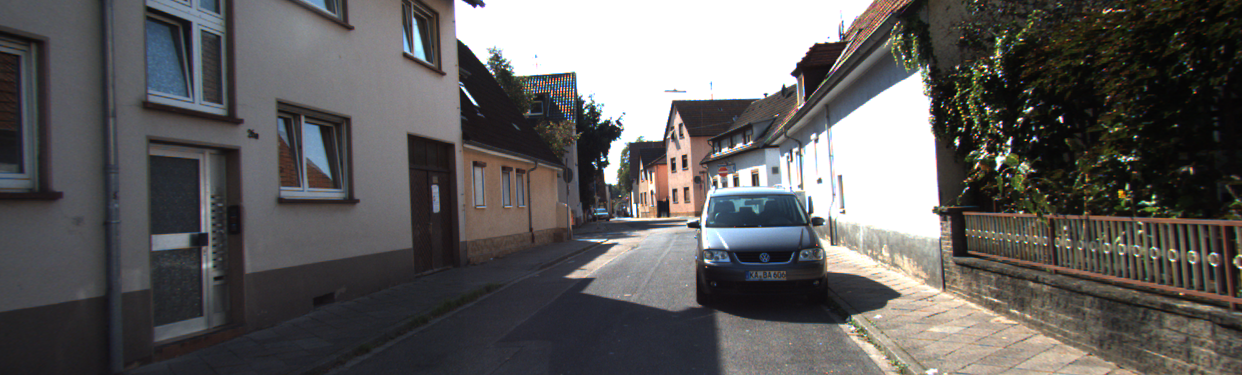

In [ ]:
img

In [ ]:
detr_df = pd.read_csv("/content/drive/MyDrive/8/AI based CV Application/TermProject/detr_kitti_preprocessing_data.csv")

In [ ]:
detr_df.shape

(31460, 10)

In [ ]:
df_filtered = df.iloc[detr_df['Unnamed: 0']]

In [ ]:
df_filtered.shape

(31460, 16)

In [ ]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [ ]:
df_filtered = df_filtered.reset_index()
df_filtered.head()

,index,filename,class,truncated,occluded,observation angle,xmin,ymin,xmax,ymax,height,width,length,xloc,yloc,zloc,rot_y
0,24609,004559.txt,Car,0.0,0,1.53,691.43,182.13,834.56,311.59,1.57,1.73,4.15,2.15,1.73,11.02,1.72
1,39563,007282.txt,Car,0.0,0,1.45,767.90,181.48,975.64,349.99,1.57,1.73,4.15,2.90,1.69,8.98,1.75
2,34567,006347.txt,Car,0.0,0,1.43,804.94,177.15,1056.88,372.98,1.57,1.73,4.15,3.13,1.63,7.99,1.79
3,40459,007460.txt,Car,0.1,0,0.35,0.00,189.65,334.80,299.15,1.45,1.68,4.53,-6.88,1.75,11.22,-0.19
4,32440,005956.txt,Car,0.0,0,1.48,731.85,184.44,898.26,330.53,1.57,1.73,4.15,2.57,1.76,10.08,1.73


In [ ]:
detr_df.head()

,Unnamed: 0,filename,class,xmin,ymin,xmax,ymax,angle,zloc,weather
0,24609,004559.png,car,696.141900,181.87436,834.75330,304.45706,1.53,11.02,clone
1,39563,007282.png,car,770.695900,185.25092,957.28860,336.75674,1.45,8.98,clone
2,34567,006347.png,car,806.129330,182.14409,1033.37200,355.73874,1.43,7.99,clone
3,40459,007460.png,car,0.562972,192.60844,327.78198,298.33970,0.35,11.22,clone
4,32440,005956.png,car,730.879900,187.02419,887.85390,320.57460,1.48,10.08,clone


In [ ]:
iou_list = []
for i in tqdm(range(31460)):
  box_origin = tuple(df_filtered.loc[i,['xmin', 'ymin', 'xmax', 'ymax']])
  box_detr = tuple(detr_df.loc[i,['xmin', 'ymin', 'xmax', 'ymax']])

  iou = IoU(box_origin, box_detr)
  iou_list.append(iou)

In [ ]:
np.mean(iou_list)

0.7286436437109608

In [ ]:
pd.DataFrame(iou_list).describe()

,0
count,31460.000000
mean,0.728644
std,0.185377
min,0.000000
25%,0.643723
50%,0.781653
75%,0.864715
max,0.991109


In [ ]:
sum([1 if x < 0.5 else 0 for x in iou_list])

3716

In [ ]:
iou_zero = []
iou_except_zero = []
for i in range(len(iou_list)):
  if iou_list[i] == 0:
    iou_zero.append(i)
  else:
    iou_except_zero.append(i)

In [ ]:
len(iou_zero)

178

In [ ]:
iou_zero

[574,
 893,
 1026,
 1085,
 1729,
 2755,
 3329,
 3748,
 4240,
 4292,
 4556,
 4705,
 4975,
 5244,
 5415,
 5465,
 5524,
 5709,
 5757,
 5825,
 5852,
 5871,
 6051,
 6201,
 6265,
 6465,
 6550,
 6560,
 6568,
 6662,
 6750,
 6832,
 6886,
 7084,
 7324,
 7788,
 7861,
 7867,
 7872,
 7910,
 8802,
 8889,
 9342,
 9366,
 10272,
 12366,
 12453,
 12561,
 12618,
 14058,
 14239,
 14628,
 14658,
 15027,
 15084,
 15441,
 15851,
 15957,
 16071,
 16272,
 16885,
 17393,
 17513,
 17514,
 17617,
 17922,
 17986,
 18187,
 18224,
 18416,
 18454,
 18497,
 18789,
 18861,
 19203,
 19719,
 19742,
 19827,
 20030,
 20075,
 20661,
 20782,
 21003,
 21019,
 21261,
 21381,
 21541,
 21544,
 21555,
 21711,
 21921,
 21927,
 21972,
 21977,
 21983,
 21990,
 22698,
 22715,
 22963,
 23189,
 23514,
 23546,
 23559,
 23726,
 24247,
 24309,
 24345,
 24457,
 24642,
 24704,
 24770,
 25253,
 25570,
 25950,
 25962,
 25974,
 26059,
 26248,
 26255,
 26262,
 26458,
 26470,
 26494,
 26724,
 26838,
 26916,
 26993,
 26998,
 27086,
 27319,
 27766

In [ ]:
iou_list_except_zero = pd.DataFrame(iou_list).loc[iou_except_zero]

In [ ]:
iou_list_except_zero.describe()

,0
count,31282.000000
mean,0.732790
std,0.177544
min,0.002299
25%,0.647064
50%,0.782965
75%,0.865055
max,0.991109
